# Preâmbulo

Imports básicos


In [ ]:
! pip install torchtext==0.8.1
! pip install unidecode

# Basic imports.
import osW
import unidecode, re
import csv
import time
import random
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from sklearn import metrics
from sklearn.model_selection import train_test_split

from torchvision import models

from torchtext import data
from torchtext import datasets

import spacy
! python -m spacy download en
! python -m spacy download fr

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

cudnn.benchmark = True

SEED = 1234
torch.manual_seed(SEED)

     |████████████████████████████████| 7.0MB 8.4MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0
     |████████████████████████████████| 245kB 18.1MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.7MB 16.2MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp37-none-any.whl size=14727027 sha256=14a7e86f82cbafbe

In [ ]:
# Setting predefined arguments.
args = {
    'epoch_num': 100,       # Number of epochs.
    'lr': 1e-3,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 6,     # Number of workers on data loader.
    'batch_size': 10,     # Mini-batch size.
    'max_length': 50,    # Maximun length of predicted sentence
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


# Generating Sequences


Dentre os tipos de problemas solucionáveis com modelos recorrentes, dois deles são baseados em geração de sequências: Os problemas One-to-Many,  e os Many-to-Many não sincronizados. <br>

Tipicamente os modelos de geração de sequências são baseados em arquiteturas **Encoder-Decoder**, onde a entrada é codificada para uma forma fixa, e então decodificada passo a passo em uma sequência.

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" width="600">


## Sequence-to-sequence models (Seq2Seq)

Modelos Sequence-to-Sequence (Seq2Seq) partem do mesmo princípio do Image Captioning, porém a entrada também é sequencial, de modo que a codificação também é realizada por um modelo recorrente. 

A atividade de hoje é no contexto de Neural Machine Translation (NMT), cujo pipeline é representado de forma simplificada a seguir. Note que o idioma source (francês) necessita apenas do token de finalização de sentença, enquanto o idioma target precisa de ambos os inicializadores e os finalizadores (```<sos>```, ```<eos>```), visto que a entrada da rede precisa do token de inicialização, mas a saída, através da qual será calculada a loss, é produzida apenas com a finalização.

![](https://pytorch.org/tutorials/_images/seq2seq.png)

Imagem retirada do tutorial de NMT do Pytorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Encontre modelos de linguagem pré-treinados e arquiteturas implementadas em: http://opennmt.net/


In [ ]:
# Baixando Dataset
!wget https://www.dropbox.com/s/gq36ksk347d36ln/translation_data.zip
!unzip translation_data.zip

--2021-03-16 22:29:43--  https://www.dropbox.com/s/gq36ksk347d36ln/translation_data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gq36ksk347d36ln/translation_data.zip [following]
--2021-03-16 22:29:43--  https://www.dropbox.com/s/raw/gq36ksk347d36ln/translation_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca365af9acc30ae1d624670d8a3.dl.dropboxusercontent.com/cd/0/inline/BK2SsG4kod4Mi4P-JTvAKyaBy3cfdsSb5C0KDhH_4IgjQP2OCH3-F-uxzIoQEnaGEUHBfChfdcEl8rLaAan8_xQbmO-HQrkkUKpvx8Ezd_HDNDIXtwUClBl4QAAbS4A8LBG-n_OgVBGnsHh4YuZe1lpQ/file# [following]
--2021-03-16 22:29:44--  https://uca365af9acc30ae1d624670d8a3.dl.dropboxusercontent.com/cd/0/inline/BK2SsG4kod4Mi4P-JTvAKyaBy3cfdsSb5C0KDhH_4IgjQP2OCH3-F-uxzIoQEnaGEU

In [ ]:
# Criando CSV de treino e teste para carregar com o TabularDataset

translation_path = 'data/eng-fra.txt'

samples = open(translation_path).read().split('\n')
  
# Write txt to csv
lines = (line.split("\t") for line in samples)
with open('translation_data.csv', 'w') as out_file:
    writer = csv.writer(out_file)
    writer.writerow(('English', 'French'))
    writer.writerows(lines)
    
df = pd.read_csv('translation_data.csv')

# Reducing data (throwing out samples)
train, _ = train_test_split(df, test_size=0.95)

# Split train and test set 
train, test = train_test_split(train, test_size=0.02)

train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)


df = pd.read_csv('test.csv')
df.tail()

English                                             French
131         He was destined never to meet her again.       Il était destiné à ne plus jamais la revoir.
132  Why don't you tell me what happened last night?  Pourquoi ne me dis-tu pas ce qui s'est passé l...
133                              I walked to school.                     Je suis allé à pied à l'école.
134     Whatever he may say, I won't change my mind.       Quoi qu'il dise, je ne changerai pas d'avis.
135                            I just want you back.      Je veux simplement que tu reviennes avec moi.

In [ ]:
# Preparação do dataset:
# Tokenização e inclusão dos tokens especiais (<eos>, <sos>, <pad>, <unk>)

def normalize_string(sentence):
  
  new_sentence = []
  for word in sentence:
    s = unidecode.unidecode(word.lower())
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)

    if s.strip() == '': continue 

    new_sentence.append(s.strip())

  return new_sentence


TEXT_FR = data.Field(tokenize = 'spacy', 
                     tokenizer_language='fr', 
                     preprocessing = normalize_string,
                     include_lengths=True, 
                     eos_token = "<eos>")
TEXT_EN = data.Field(tokenize = 'spacy', 
                     tokenizer_language='en', 
                     preprocessing = normalize_string,
                     include_lengths=True, 
                     init_token = "<sos>", 
                     eos_token = "<eos>")

fields = [('text_en', TEXT_EN), ('text_fr', TEXT_FR)]
train_data, test_data = data.TabularDataset.splits(
                                  path = '.',
                                  train = 'train.csv',
                                  test = 'test.csv',
                                  format = 'csv',
                                  fields = fields,
                                  skip_header = True)

for sample in train_data:
  print(sample.text_fr)
  print(sample.text_en)
  break
  
print(len(train_data), len(test_data))

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

['c', 'est', 'toi', 'le', 'plus', 'vieux', '.']
['you', 're', 'the', 'oldest', '.']
6656 136


In [ ]:
# Criando vocabulário
MAX_VOCAB_SIZE = 25000

TEXT_EN.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE)

TEXT_FR.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE)


# Instanciando bucket iterator
# Note que a ordenação é definida pelo 
# comprimento do par ** (en, fr) **
# Precisaremos empacotar ambas as sequências 
# para realizar o forward encapsulado.
train_iterator = data.BucketIterator(
    train_data, 
    batch_size = 1,
    sort_key = lambda x:(len(x.text_fr), len(x.text_en)),
    sort_within_batch = True,
    device = args['device'])


test_iterator = data.BucketIterator(
    test_data, 
    batch_size = 1,
    sort_within_batch = False,
    device = args['device'])

for k, batch in enumerate(train_iterator):
  text_fr, lengths_fr = batch.text_fr
  text_en, lengths_en = batch.text_en
  
  print(text_fr)
  print(text_en)
  print(lengths_fr)
  print(lengths_en)
  break


tensor([[   4],
        [ 148],
        [  52],
        [1207],
        [ 189],
        [   6],
        [  13],
        [ 393],
        [   3],
        [   2]])
tensor([[  2],
        [  5],
        [ 64],
        [ 44],
        [610],
        [ 42],
        [  6],
        [ 62],
        [300],
        [ 62],
        [  8],
        [364],
        [  4],
        [  3]])
tensor([10])
tensor([14])


/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Bahdanau Attention

Tutorial com gifs animados do Towards Data Science: https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3

Tutorial do Tensorflow usado como referência para a implementação: https://www.tensorflow.org/tutorials/text/nmt_with_attention

![](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

### Passo a passo
<img width=650 src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg">

<img width=650 src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg">

Pseudo-código:

* `score = FC(tanh(FC(encoder_outputs) + FC(decoder_hidden)))`
* `attention weights = softmax(score, axis = 0)`. 
   * Softmax é aplicada à dimensão 0 já que o score de alinhamento tem dimensionalidade `(seq_length, batch_size, hidden_size)`. `seq_length` é a quantidade de elementos da sequência. Já que buscamos associar um peso a cada elemento, devemos aplicar a softmax na dimensão correspondente.
* `context vector = sum(attention weights * EO, axis = 0)`. 
* `embedding_output` = A entrada para o decoder (X) é passada por uma camada de embedding.
* `merged_vector = concat(embedding output, context vector)`. O vetor com a entrada e o `context_vector` são alimentados para a GRU do decoder.

In [ ]:
class BahdanauAttention(nn.Module):
  def __init__(self, encoder_size, decoder_size):

    super(BahdanauAttention, self).__init__()
    
    self.W1 = nn.Linear(decoder_size, decoder_size)
    self.W2 = nn.Linear(encoder_size, decoder_size)
    self.V  = nn.Linear(decoder_size, 1) # values

  def forward(self, decoder_hidden, encoder_outputs): # query, keys
    
    # decoder_hidden   (1 x B x H)
    # encoder_outputs  (S x B x H)

    # score de alinhamento (S x B x 1)
    score = self.V( F.tanh(self.W1(decoder_hidden) + self.W2(encoder_outputs)) )

    # score como distribuição de probabilidades
    # softmax aplicada na dimensão da sequência
    # queremos um peso para cada elemento da sequência.
    attention_weights = F.softmax(score, dim=0)

    # aplica os scores (S x B x 1) no encoder_outputs (S x B x H)
    context_vector = attention_weights * encoder_outputs

    # Soma na dimensão da sequência -> (B x H)
    context_vector = torch.sum(context_vector, axis=0)
    
    return context_vector, attention_weights.squeeze(-1)

### EncoderRNN

Implemente a classe **EncoderRNN** composta de um passo de representação de palavras e um passo de caracterização de sequência, ou seja, implemente as seguintes camadas:
*  Embedding: como não usaremos vetores pré-treinados, a dimensão de saída dessa camada é um hiperparâmetro livre. Sugestão de tamanho: ```100```. Sua entrada é definida pelo tamanho do dicionário do idioma source (nesse caso o francês).
*  Dropout: ```0.1``` <br><br>
*  GRU: Defina ```hidden_size = 128``` para o encoder

### DecoderRNN

Implemente a classe **DecoderRNN**. Novamente é necessário uma camada de representação de palavras, seguida de uma camada de caracterização de sequências. Além disso, o decoder também deve possuir uma camada Linear de classificação, que transformará a representação de cada timestep (saída da RNN) em uma predição da próxima palavra.

* Embedding: A entrada definida pelo vocabulário do idioma target (inglês), saída é um hiperparâmetro livre (sugestão: ```100```).
* Dropout: ```0.1``` <br><br>
* GRU: Seus hiperparâmetros são inferíveis a partir das outras informações. **Lembre-se que a inicialização do hidden state é dada pelo último hidden state do encoder** (veja na função train). <br><br>
* Linear: Parâmetros inferíveis pelas outras informações. Quantas classes tem a predição de palavras em inglês?
* LogSoftmax: ativação da classificação.

No decoder, **implemente ambos os forward** para treinamento (encapsulado em batches) e para inferência (loop explícito sem targets).

<img src="https://drive.google.com/uc?export=view&id=1j8aLVymyvhGtM0lpfON0aDyPvUf4700U" width="850">

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1, num_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.dropout_p   = dropout_p
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, inputs, lengths):
      
        batch_size = inputs.size(1)
        hidden = self.initHidden(batch_size)
        
        embedded = self.dropout(self.embedding(inputs))
      
        packed_inputs = nn.utils.rnn.pack_padded_sequence(embedded, lengths)
        packed_outputs, hidden = self.gru(packed_inputs, hidden)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        
        return outputs, hidden[-1:]

    def initHidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(args['device'])
      
      
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length

        self.attention = BahdanauAttention(hidden_size, hidden_size)
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        ## GRU's input is [context, embed] (2*hidden_size)
        self.gru = nn.GRU(2*self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=-1)


    def forward(self, hidden, encoder_outputs, target=None, lengths=None):

        if target is not None:
          return self.teacher_forcing(hidden, encoder_outputs, target, lengths)

        token = torch.tensor(TEXT_EN.vocab.stoi["<sos>"]).unsqueeze(0).to(args['device'])
        
        outputs = []
        att_list = []
        for i in range(self.max_length):
          
          # Build context vector with the attention layer
          context_vector, attention_weights = self.attention(hidden, encoder_outputs)
          att_list.append(attention_weights.detach().cpu())

          # concatenate embedded representation with context vector
          embedded = self.embedding(token).unsqueeze(0)
          input = torch.cat( [ context_vector.unsqueeze(0), embedded ], axis=-1 )

          # recurrent forward and inference
          output_rnn, hidden = self.gru(input, hidden)
          output = self.softmax(self.out(output_rnn[0]))
          
          topv, topi = output.topk(1)
          token = topi.squeeze(0).detach()  # detach from history as input

          outputs.append(output)
          if token == TEXT_EN.vocab.stoi["<eos>"]:
            break
            
        return torch.stack(outputs), torch.stack(att_list)


    def teacher_forcing(self, hidden, encoder_outputs, target, lengths):

        outputs = []
        att_list = []
        for i in range( target.size(0) ):
          
          # Build context vector with the attention layer
          context_vector, attention_weights = self.attention(hidden, encoder_outputs)
          att_list.append(attention_weights.detach().cpu())
          
          # concatenate embedded representation with context vector
          embedded = self.embedding(target[i:i+1])
          input = torch.cat( [ context_vector.unsqueeze(0), embedded ], axis=-1 )
          
          # recurrent forward and inference
          output_rnn, hidden = self.gru(input, hidden)
          output = self.softmax(self.out(output_rnn[0]))
          outputs.append(output)

        return torch.stack(outputs), torch.stack(att_list)
      
           

vocab_size_en = len(TEXT_EN.vocab)
hidden_size   = 128

vocab_size_fr = len(TEXT_FR.vocab)
max_length    = args['max_length']

encoder = EncoderRNN(vocab_size_fr, hidden_size).to(args['device'])
decoder = DecoderRNN(hidden_size, vocab_size_en, max_length).to(args['device'])

print(encoder)
print(decoder)

EncoderRNN(
  (embedding): Embedding(5400, 128)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(128, 128)
)
DecoderRNN(
  (attention): BahdanauAttention(
    (W1): Linear(in_features=128, out_features=128, bias=True)
    (W2): Linear(in_features=128, out_features=128, bias=True)
    (V): Linear(in_features=128, out_features=1, bias=True)
  )
  (embedding): Embedding(3878, 128)
  (gru): GRU(256, 128)
  (out): Linear(in_features=128, out_features=3878, bias=True)
  (softmax): LogSoftmax(dim=-1)
)


In [ ]:
# Setting optimizer.
encoder_optimizer = optim.Adam(encoder.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'],
                       betas=(args['momentum'], 0.999))

decoder_optimizer = optim.Adam(decoder.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'],
                       betas=(args['momentum'], 0.999))

# Setting loss.
criterion = nn.NLLLoss().to(args['device'])


In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy().squeeze(-1), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def train(train_loader, criterion, epoch):

    tic = time.time()
    teacher_forcing_p = 0.5

    # Setting network for training mode.
    encoder.train()
    decoder.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        text, text_lengths = batch_data.text_fr
        labs, labs_lengths = batch_data.text_en
        
        # Ignorando batches não ordenados para acelerar o treinamento
        if sorted(labs_lengths, reverse=True) != list(labs_lengths.data):
          continue

        # Clears the gradients of optimizer.
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Forwarding.
        enc, enc_hidden = encoder(text, text_lengths.cpu())
        if np.random.rand() > teacher_forcing_p:
          outs, att = decoder(enc_hidden, enc)  
          minlen = min(len(labs)-1, len(outs))
        else:
          outs, att = decoder(enc_hidden, enc, labs[:-1], labs_lengths.cpu()-1)
          minlen = len(outs)

        # Computing loss.
        loss = 0.
        for k in range(minlen):
          loss += criterion(outs[k], labs[k+1])
        loss = loss.mean()
        
        # Computing backpropagation.
        loss.backward()
        
        # Weight update
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        # Updating lists.
        train_loss.append(loss.data.item())

        if (i+1) % 300 == 0:
          input = [TEXT_FR.vocab.itos[t] for t in text[:,0]]
          labels = [TEXT_EN.vocab.itos[t] for t in labs[:,0]]
          output = [TEXT_EN.vocab.itos[np.argmax(t.cpu().data)] for t in outs[:,0]]
          print(f'Input:{input}\nLabel:{labels}\nOutput:{output}',  )
          
          epoch_loss_ = np.asarray(train_loss)

          print('--------------------------------------------------------------------')
          print('[epoch %d iter %d], [train loss %.4f +/- %.4f], [epoch elapsed time %.2f]' % (
              epoch, i+1, epoch_loss_.mean(), epoch_loss_.std(), (time.time() - tic)))
          print('--------------------------------------------------------------------')

          showAttention(input, output, att)
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
    print('--------------------------------------------------------------------')

def test(test_loader, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode (not computing gradients).
    encoder.eval()
    decoder.eval()

    # Lists for losses and metrics.
    test_loss = []
    
    print('********************************************************************')
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images, labels and paths for batch.
        text, text_lengths = batch_data.text_fr
        labs, labs_lengths = batch_data.text_en
        
        
        # Forwarding.
        enc, enc_hidden  = encoder(text, text_lengths.cpu())
        outs, att = decoder(enc_hidden, enc)
        
        if i < 2:
          input = [TEXT_FR.vocab.itos[t] for t in text[:,0]]
          labels = [TEXT_EN.vocab.itos[t] for t in labs[:,0]]
          output = [TEXT_EN.vocab.itos[np.argmax(t.cpu().data)] for t in outs[:,0]]
          print(f'Input:{input}\nLabel:{labels}\nOutput:{output}',  )

          showAttention(input, output, att)
        
        # Computing approximate loss 
        labs = labs[1:]
        minlen = min(len(labs), len(outs))
        
        loss = 0.
        for k in range(minlen):
          loss += criterion(outs[k], labs[k])
        loss = loss.mean()
                
        # Updating lists.
        test_loss.append(loss.data.item())
    
    toc = time.time()

    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
   
    print('[epoch %d], [test loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), (toc - tic)))
    print('********************************************************************')


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Input:['j', 'ai', 'passe', 'la', 'plus', 'grande', 'partie', 'de', 'ma', 'vie', 'ici', 'a', 'boston', '.', '<eos>']
Label:['<sos>', 'i', 've', 'spent', 'most', 'of', 'my', 'life', 'here', 'in', 'boston', '.', '<eos>']
Output:['i', 'was', 'is', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 300], [train loss 40.4999 +/- 19.4300], [epoch elapsed time 18.62]
--------------------------------------------------------------------


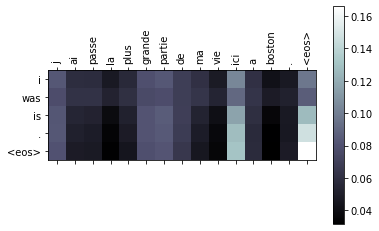

Input:['vois', 'tu', 'un', 'inconvenient', 'a', 'ce', 'que', 'j', 'y', 'aille', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'mind', 'if', 'i', 'go', '?', '<eos>']
Output:['are', 'you', 'you', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 600], [train loss 38.9870 +/- 17.3544], [epoch elapsed time 36.00]
--------------------------------------------------------------------


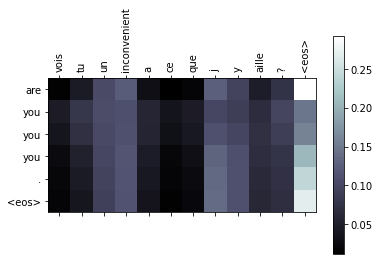

Input:['il', 'se', 'dressa', '.', '<eos>']
Label:['<sos>', 'he', 'stood', 'up', '.', '<eos>']
Output:['he', 'is', 'a', '.', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 900], [train loss 38.8712 +/- 16.7456], [epoch elapsed time 54.42]
--------------------------------------------------------------------


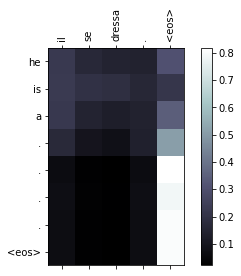

Input:['ne', 'rejetez', 'aucune', 'possibilite', '!', '<eos>']
Label:['<sos>', 'do', 'n t', 'dismiss', 'any', 'possibility', '.', '<eos>']
Output:['what', 'n t', 'you', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 1200], [train loss 38.0828 +/- 16.6916], [epoch elapsed time 72.48]
--------------------------------------------------------------------


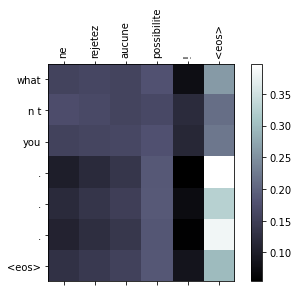

Input:['je', 'viens', 'de', 'finir', 'de', 'nettoyer', 'le', 'garage', '.', '<eos>']
Label:['<sos>', 'i', 'just', 'finished', 'cleaning', 'the', 'garage', '.', '<eos>']
Output:['i', 'm', 'to', 'to', '.', 'door', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 1500], [train loss 37.6673 +/- 16.2989], [epoch elapsed time 93.12]
--------------------------------------------------------------------


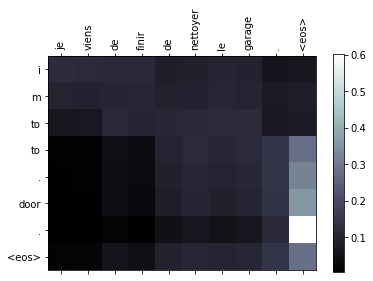

Input:['il', 'porte', 'toujours', 'des', 'chemises', 'bleues', '.', '<eos>']
Label:['<sos>', 'he', 'always', 'wears', 'blue', 'shirts', '.', '<eos>']
Output:['he', 'was', 'the', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 1800], [train loss 37.5847 +/- 16.4424], [epoch elapsed time 118.07]
--------------------------------------------------------------------


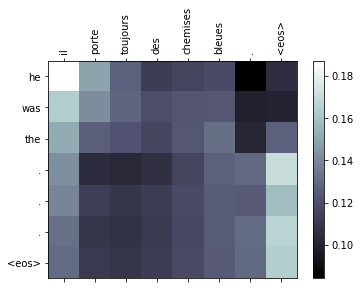

Input:['je', 'pensais', 'que', 'tom', 'aurait', 'dit', 'cela', '.', '<eos>']
Label:['<sos>', 'i', 'thought', 'tom', 'would', 'say', 'that', '.', '<eos>']
Output:['i', 'do', 'n t', 'know', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 2100], [train loss 36.9744 +/- 15.9605], [epoch elapsed time 142.95]
--------------------------------------------------------------------


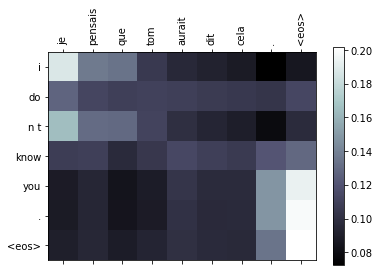

Input:['tom', 'm', 'a', 'dit', 'que', 'je', 'ne', 'devrais', 'pas', 'nager', 'la', 'bas', '.', '<eos>']
Label:['<sos>', 'tom', 'told', 'me', 'i', 'should', 'n t', 'swim', 'there', '.', '<eos>']
Output:['i', 'ca', 'i', 'i', 'm', 'n t', 'i', 'i', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 2400], [train loss 36.6388 +/- 15.8655], [epoch elapsed time 168.09]
--------------------------------------------------------------------


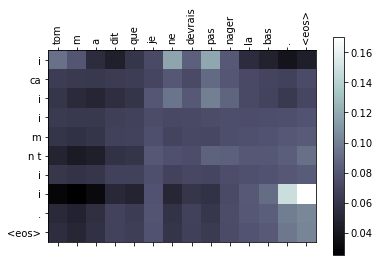

Input:['ce', 'seisme', 'fut', 'le', 'plus', 'important', 'que', 'l', 'on', 'ait', 'jamais', 'vecu', '.', '<eos>']
Label:['<sos>', 'the', 'earthquake', 'was', 'the', 'biggest', 'one', 'that', 'we', 'had', 'ever', 'experienced', '.', '<eos>']
Output:['that', 's', 'the', 'the', 'to', 'be', 'the', 'of', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 2700], [train loss 36.2877 +/- 15.6434], [epoch elapsed time 193.77]
--------------------------------------------------------------------


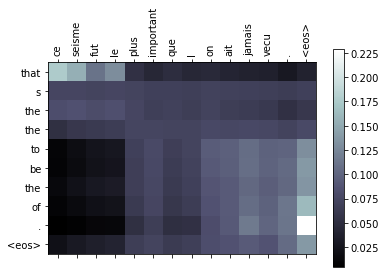

Input:['ca', 'n', 'a', 'rien', 'a', 'voir', 'avec', 'lui', '.', '<eos>']
Label:['<sos>', 'that', 'has', 'nothing', 'to', 'do', 'with', 'him', '.', '<eos>']
Output:['it', 's', 'not', 'to', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 3000], [train loss 36.1481 +/- 15.5489], [epoch elapsed time 219.61]
--------------------------------------------------------------------


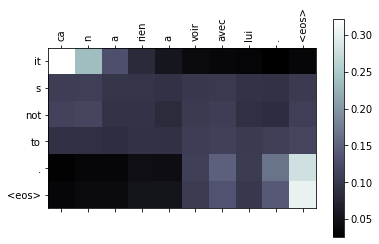

Input:['je', 'prends', 'conscience', 'qu', 'il', 'est', 'probablement', 'trop', 'tard', '.', '<eos>']
Label:['<sos>', 'i', 'realize', 'it', 's', 'probably', 'too', 'late', '.', '<eos>']
Output:['i', 'm', 'that', 's', 'a', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 3300], [train loss 36.0334 +/- 15.5402], [epoch elapsed time 245.70]
--------------------------------------------------------------------


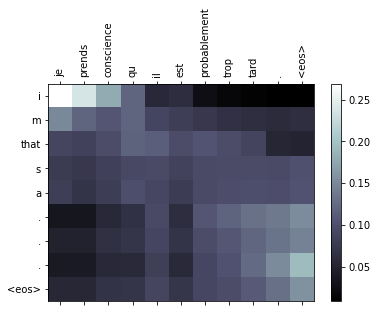

Input:['a', 'la', 'fin', 'elle', 'a', 'eu', 'une', 'bonne', 'idee', '.', '<eos>']
Label:['<sos>', 'at', 'last', 'she', 'hit', 'on', 'a', 'good', 'idea', '.', '<eos>']
Output:['the', 'the', 'the', 'a', 'a', 'the', '<eos>', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 3600], [train loss 35.9785 +/- 15.5580], [epoch elapsed time 271.73]
--------------------------------------------------------------------


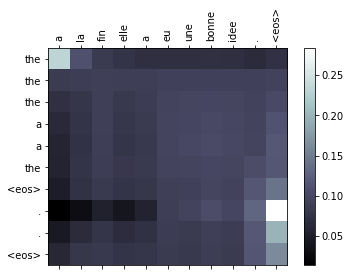

Input:['mettez', 'cette', 'note', 'sur', 'mon', 'compte', '.', '<eos>']
Label:['<sos>', 'charge', 'this', 'bill', 'to', 'me', '.', '<eos>']
Output:['the', 'is', 'is', 'is', 'her', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 3900], [train loss 35.7947 +/- 15.5649], [epoch elapsed time 297.58]
--------------------------------------------------------------------


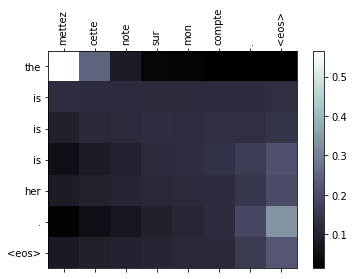

Input:['je', 'n', 'ai', 'jamais', 'ete', 'dormir', '.', '<eos>']
Label:['<sos>', 'i', 'never', 'went', 'to', 'sleep', '.', '<eos>']
Output:['i', 'm', 'never', 'to', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 4200], [train loss 35.5504 +/- 15.4100], [epoch elapsed time 322.89]
--------------------------------------------------------------------


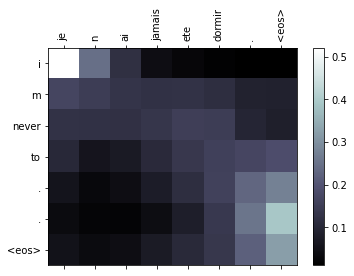

Input:['je', 'veux', 'voir', 'ton', 'patron', '.', '<eos>']
Label:['<sos>', 'i', 'want', 'to', 'see', 'your', 'boss', '.', '<eos>']
Output:['i', 'm', 'i', 'want', 'to', 'i', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 4500], [train loss 35.2796 +/- 15.3159], [epoch elapsed time 347.98]
--------------------------------------------------------------------


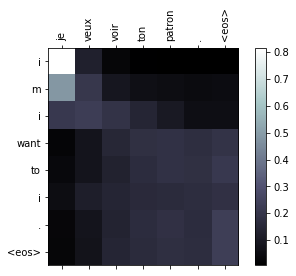

Input:['que', 'cherches', 'tu', '?', '<eos>']
Label:['<sos>', 'what', 'do', 'you', 'seek', '?', '<eos>']
Output:['do', 'do', 'you', 'want', '?', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 4800], [train loss 35.1806 +/- 15.2736], [epoch elapsed time 374.28]
--------------------------------------------------------------------


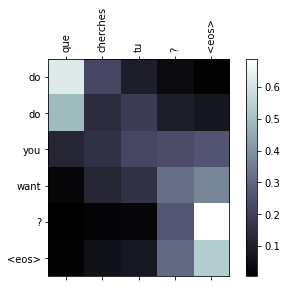

Input:['nous', 'mettrons', 'tout', 'en', 'oeuvre', 'pour', 'le', 'faire', '.', '<eos>']
Label:['<sos>', 'we', 'will', 'make', 'every', 'effort', 'to', 'do', 'so', '.', '<eos>']
Output:['we', 're', 'we', 'to', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 5100], [train loss 34.9966 +/- 15.2633], [epoch elapsed time 399.56]
--------------------------------------------------------------------


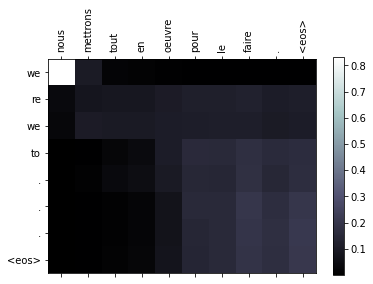

Input:['je', 'viens', 'de', 'sortir', 'd', 'une', 'relation', '.', '<eos>']
Label:['<sos>', 'i', 'just', 'got', 'out', 'of', 'a', 'relationship', '.', '<eos>']
Output:['i', 'm', 'sorry', 'to', 'a', 'a', '.', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 5400], [train loss 34.8447 +/- 15.2858], [epoch elapsed time 425.44]
--------------------------------------------------------------------


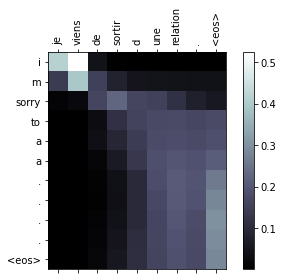

Input:['comment', 'savais', 'tu', 'que', 'nous', 'etions', 'la', '?', '<eos>']
Label:['<sos>', 'how', 'did', 'you', 'know', 'we', 'were', 'here', '?', '<eos>']
Output:['how', 'do', 'you', 'you', 'you', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 5700], [train loss 34.6902 +/- 15.2375], [epoch elapsed time 451.07]
--------------------------------------------------------------------


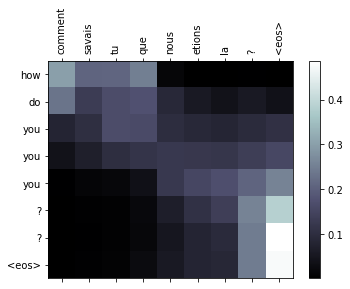

Input:['y', 'a', 't', 'il', 'quelque', 'chose', 'de', 'particulier', 'que', 'vous', 'vouliez', 'entendre', '?', '<eos>']
Label:['<sos>', 'is', 'there', 'something', 'in', 'particular', 'that', 'you', 'want', 'to', 'hear', '?', '<eos>']
Output:['is', 'there', 'to', 'see', 'you', '?', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 6000], [train loss 34.4851 +/- 15.1364], [epoch elapsed time 476.98]
--------------------------------------------------------------------


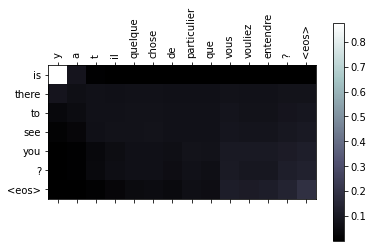

Input:['elle', 's', 'eloigna', 'lentement', 'de', 'moi', '.', '<eos>']
Label:['<sos>', 'she', 'walked', 'slowly', 'away', 'from', 'me', '.', '<eos>']
Output:['she', 'was', 'to', 'to', '.', 'me', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 6300], [train loss 34.3571 +/- 15.0851], [epoch elapsed time 502.83]
--------------------------------------------------------------------


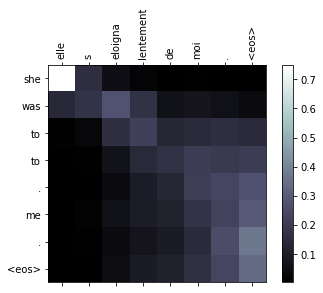

Input:['je', 'pense', 'qu', 'elle', 'doit', 'etre', 'arrivee', 'maintenant', '.', '<eos>']
Label:['<sos>', 'she', 'will', 'be', 'there', 'by', 'now', '.', '<eos>']
Output:['i', 'i', 'never', 'she', 'to', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 1 iter 6600], [train loss 34.3165 +/- 15.0925], [epoch elapsed time 529.52]
--------------------------------------------------------------------


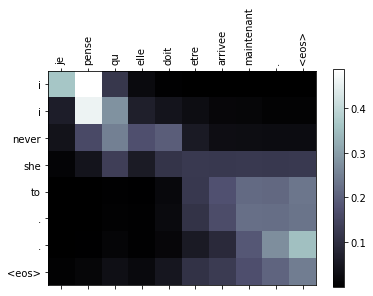

--------------------------------------------------------------------
[epoch 1], [train loss 34.2744 +/- 15.0855], [training time 534.37]
--------------------------------------------------------------------
********************************************************************
Input:['tu', 'es', 'le', 'seul', 'qui', 'puisse', 'm', 'aider', '.', '<eos>']
Label:['<sos>', 'you', 're', 'the', 'only', 'one', 'who', 'can', 'help', 'me', '.', '<eos>']
Output:['you', 're', 'the', 'the', '.', '.', '.', '<eos>']


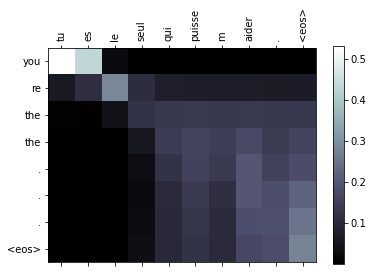

Input:['il', 'ne', '<unk>', 'pas', 'a', 'expliquer', 'ce', 'qu', 'il', 'voulait', '.', '<eos>']
Label:['<sos>', 'he', 'did', 'n t', 'succeed', 'in', '<unk>', 'what', 'he', 'wanted', '.', '<eos>']
Output:['he', 's', 'not', 'he', 'he', 'he', 'he', 'he', 'he', '.', '<eos>']


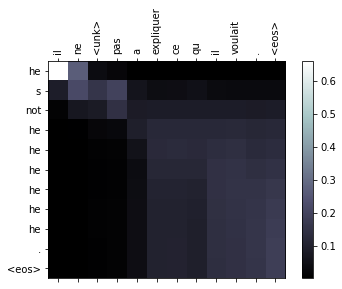

[epoch 1], [test loss 32.8862 +/- 13.9418], [testing time 2.02]
********************************************************************
Input:['ai', 'je', 'des', 'visions', '?', '<eos>']
Label:['<sos>', 'am', 'i', 'seeing', 'things', '?', '<eos>']
Output:['can', 'i', 'i', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 300], [train loss 29.6074 +/- 14.4984], [epoch elapsed time 25.66]
--------------------------------------------------------------------


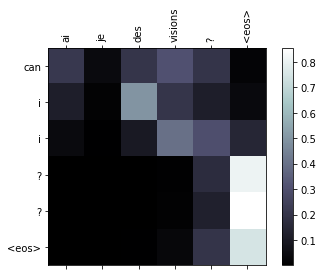

Input:['tom', 'accepterait', 'il', 'ceci', '?', '<eos>']
Label:['<sos>', 'would', 'tom', 'agree', 'to', 'this', '?', '<eos>']
Output:['tom', 'did', 'he', '?', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 600], [train loss 29.7668 +/- 14.2457], [epoch elapsed time 51.56]
--------------------------------------------------------------------


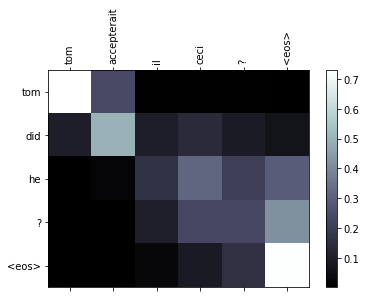

Input:['l', 'homme', 'blesse', 'dans', 'l', 'accident', 'fut', 'emmene', 'a', 'l', 'hopital', '.', '<eos>']
Label:['<sos>', 'the', 'man', 'injured', 'in', 'the', 'accident', 'was', 'taken', 'to', 'the', 'hospital', '.', '<eos>']
Output:['the', 'the', 'was', 'was', 'in', 'the', 'the', 'the', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 900], [train loss 29.6866 +/- 13.9724], [epoch elapsed time 77.71]
--------------------------------------------------------------------


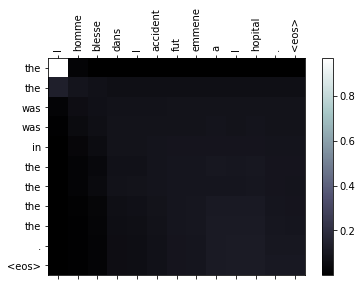

Input:['il', 'ne', 'faudrait', 'pas', 'que', 'tu', 'commettes', 'quelque', 'chose', 'd', 'imprudent', '.', '<eos>']
Label:['<sos>', 'you', 'do', 'n t', 'want', 'to', 'do', 'anything', 'rash', '.', '<eos>']
Output:['it', 'do', 'n t', 'be', 'to', 'be', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 1200], [train loss 29.6814 +/- 13.7394], [epoch elapsed time 103.65]
--------------------------------------------------------------------


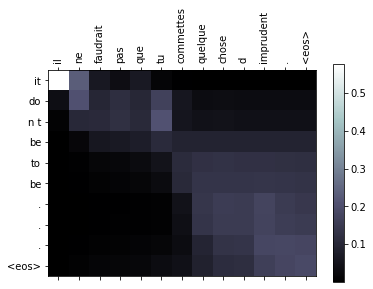

Input:['il', 'a', 'deux', 'fois', 'plus', 'de', 'livres', 'que', 'moi', '.', '<eos>']
Label:['<sos>', 'he', 'has', 'twice', 'as', 'many', 'books', 'as', 'i', 'do', '.', '<eos>']
Output:['he', 'has', 'me', 'to', 'me', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 1500], [train loss 29.4469 +/- 13.6268], [epoch elapsed time 132.13]
--------------------------------------------------------------------


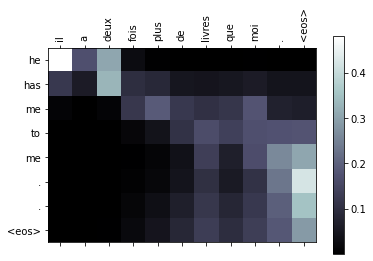

Input:['mangez', 'vous', 'trois', 'repas', 'complets', 'par', 'jour', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'eat', 'three', 'square', 'meals', 'a', 'day', '?', '<eos>']
Output:['do', 'you', 'you', 'your', 'your', '?', '?', '<eos>', '?', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 1800], [train loss 29.5840 +/- 13.9058], [epoch elapsed time 157.60]
--------------------------------------------------------------------


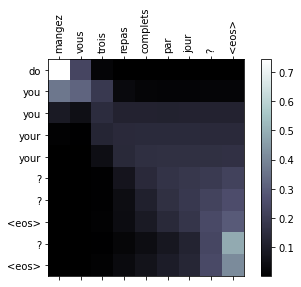

Input:['la', 'marijuana', 'therapeutique', 'est', 'legale', 'dans', 'cet', 'etat', '.', '<eos>']
Label:['<sos>', 'medical', 'marijuana', 'is', 'legal', 'in', 'this', 'state', '.', '<eos>']
Output:['the', 'cat', 'is', 'is', 'to', '.', '.', '.', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 2100], [train loss 29.9491 +/- 14.1331], [epoch elapsed time 183.97]
--------------------------------------------------------------------


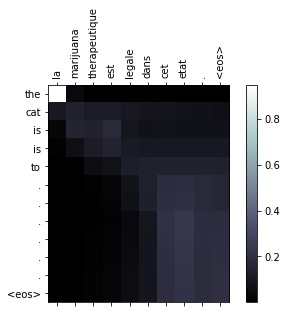

Input:['tom', 'est', 'la', 'seule', 'personne', 'qui', 'puisse', 'm', 'aider', '.', '<eos>']
Label:['<sos>', 'tom', 'is', 'the', 'only', 'person', 'who', 'can', 'help', 'me', '.', '<eos>']
Output:['tom', 'is', 'the', 'the', 'the', 'i', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 2400], [train loss 29.7700 +/- 14.1641], [epoch elapsed time 208.98]
--------------------------------------------------------------------


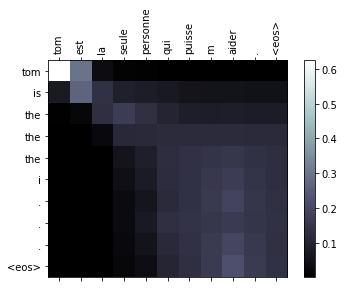

Input:['comment', 'sais', 'tu', 'tout', 'cela', '?', '<eos>']
Label:['<sos>', 'how', 'do', 'you', 'know', 'all', 'that', '?', '<eos>']
Output:['how', 'did', 'you', 'think', 'it', '?', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 2700], [train loss 29.8213 +/- 14.5395], [epoch elapsed time 234.36]
--------------------------------------------------------------------


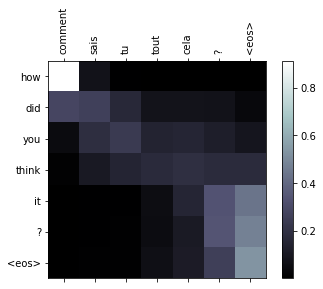

Input:['la', 'violence', 'ne', 'sera', 'pas', 'toleree', '.', '<eos>']
Label:['<sos>', 'violence', 'will', 'not', 'be', 'tolerated', '.', '<eos>']
Output:['the', 'is', 'not', 'not', 'not', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 3000], [train loss 29.8593 +/- 14.7680], [epoch elapsed time 259.78]
--------------------------------------------------------------------


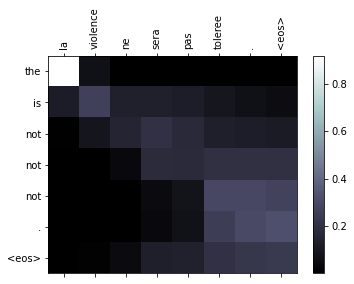

Input:['sa', 'colere', 'est', 'comprehensible', '.', '<eos>']
Label:['<sos>', 'her', 'anger', 'is', 'understandable', '.', '<eos>']
Output:['his', 'name', 'is', 'is', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 3300], [train loss 29.8577 +/- 14.7322], [epoch elapsed time 284.64]
--------------------------------------------------------------------


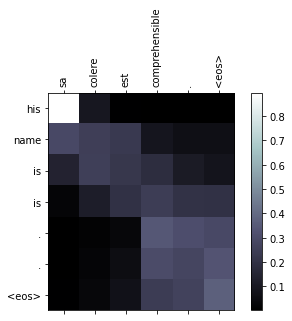

Input:['ne', 'nous', 'en', 'soucions', 'pas', '!', '<eos>']
Label:['<sos>', 'let', 's', 'not', 'worry', 'about', 'it', '.', '<eos>']
Output:['do', 'do', 'not', 'be', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 3600], [train loss 29.8166 +/- 14.7466], [epoch elapsed time 309.66]
--------------------------------------------------------------------


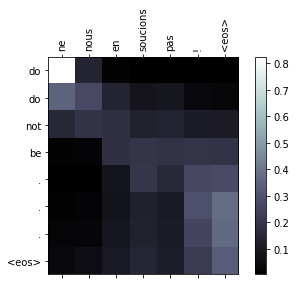

Input:['je', 'ne', 'pouvais', 'pas', 'parler', '.', '<eos>']
Label:['<sos>', 'i', 'could', 'n t', 'speak', '.', '<eos>']
Output:['i', 'do', 'n t', 'know', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 3900], [train loss 29.9543 +/- 14.8641], [epoch elapsed time 334.63]
--------------------------------------------------------------------


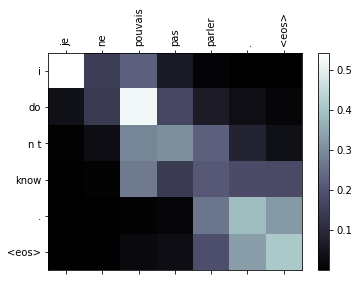

Input:['je', 'suis', 'ingenieur', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'an', 'engineer', '.', '<eos>']
Output:['i', 'm', 'not', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 4200], [train loss 29.8757 +/- 14.7505], [epoch elapsed time 359.06]
--------------------------------------------------------------------


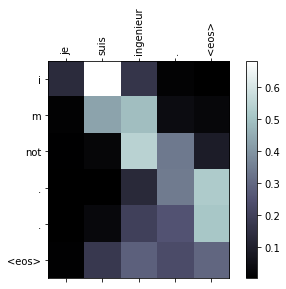

Input:['c', 'est', 'ce', 'que', 'nous', 'pensions', 'toutes', '.', '<eos>']
Label:['<sos>', 'that', 's', 'what', 'we', 'all', 'thought', '.', '<eos>']
Output:['that', 's', 'that', 'we', 're', 'all', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 4500], [train loss 29.7995 +/- 14.8421], [epoch elapsed time 383.57]
--------------------------------------------------------------------


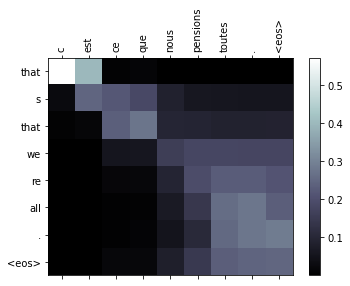

Input:['pouvez', 'vous', 'm', 'envoyer', 'un', 'catalogue', 'par', 'la', 'poste', 'je', 'vous', 'prie', '?', '<eos>']
Label:['<sos>', 'would', 'you', 'please', 'send', 'me', 'a', 'catalogue', 'by', 'mail', '?', '<eos>']
Output:['do', 'you', 'please', 'me', 'the', 'in', 'window', '?', 'the', '?', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 4800], [train loss 29.7014 +/- 14.7636], [epoch elapsed time 407.79]
--------------------------------------------------------------------


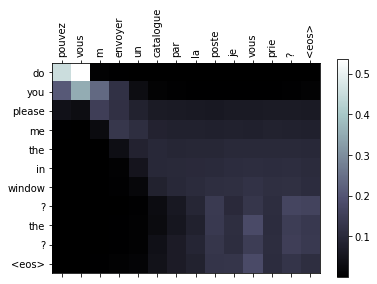

Input:['je', 'dois', 'les', 'prevenir', '.', '<eos>']
Label:['<sos>', 'i', 'must', 'warn', 'them', '.', '<eos>']
Output:['i', 'must', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 5100], [train loss 29.6633 +/- 14.7882], [epoch elapsed time 432.58]
--------------------------------------------------------------------


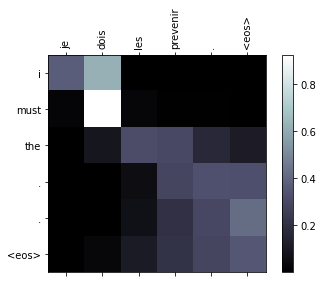

Input:['posez', 'vos', 'crayons', '.', '<eos>']
Label:['<sos>', 'put', 'down', 'your', 'pencil', '.', '<eos>']
Output:['let', 'your', 'your', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 5400], [train loss 29.5286 +/- 14.7449], [epoch elapsed time 456.74]
--------------------------------------------------------------------


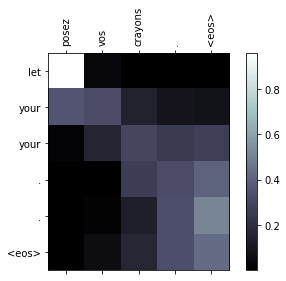

Input:['peux', 'tu', 'te', 'renseigner', '?', '<eos>']
Label:['<sos>', 'can', 'you', 'find', 'out', '?', '<eos>']
Output:['can', 'you', 'please', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 5700], [train loss 29.5120 +/- 14.7068], [epoch elapsed time 480.91]
--------------------------------------------------------------------


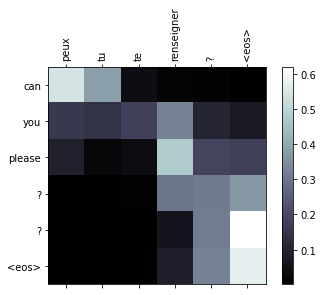

Input:['tom', 'se', 'deshabilla', 'et', 'entra', 'dans', 'la', 'baignoire', '.', '<eos>']
Label:['<sos>', 'tom', 'undressed', 'and', 'got', 'in', 'the', 'bathtub', '.', '<eos>']
Output:['tom', 'and', 'in', 'in', 'in', 'the', 'table', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 6000], [train loss 29.5265 +/- 14.6779], [epoch elapsed time 505.57]
--------------------------------------------------------------------


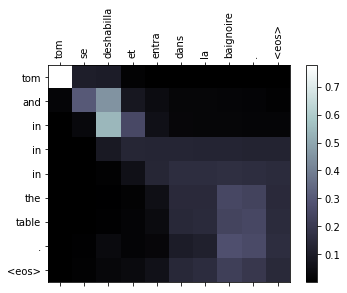

Input:['j', 'aimerais', 'desormais', 'aller', 'quelque', 'part', 'ailleurs', '.', '<eos>']
Label:['<sos>', 'i', 'd', 'like', 'to', 'go', 'somewhere', 'else', 'now', '.', '<eos>']
Output:['i', 'd', 'like', 'to', 'you', 'to', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 6300], [train loss 29.4761 +/- 14.6725], [epoch elapsed time 529.79]
--------------------------------------------------------------------


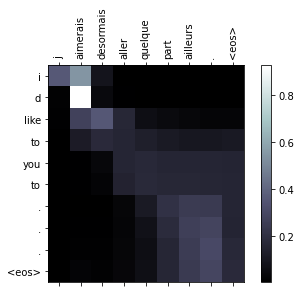

Input:['ce', 'ne', 'fut', 'pas', 'a', 'la', 'mesure', 'de', 'mes', 'attentes', '.', '<eos>']
Label:['<sos>', 'it', 'fell', 'short', 'of', 'my', 'expectation', '.', '<eos>']
Output:['it', 'was', 'n t', 'to', 'to', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 2 iter 6600], [train loss 29.4341 +/- 14.7395], [epoch elapsed time 553.88]
--------------------------------------------------------------------


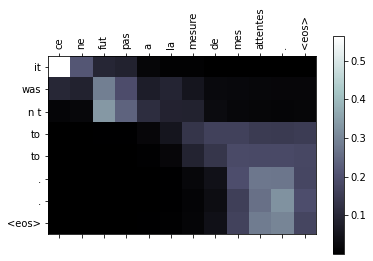

--------------------------------------------------------------------
[epoch 2], [train loss 29.4386 +/- 14.7399], [training time 558.60]
--------------------------------------------------------------------
********************************************************************
Input:['elle', 'joue', 'du', '<unk>', '.', '<eos>']
Label:['<sos>', 'she', 'plays', '<unk>', '.', '<eos>']
Output:['she', 'made', 'him', 'for', 'him', '.', '<eos>']


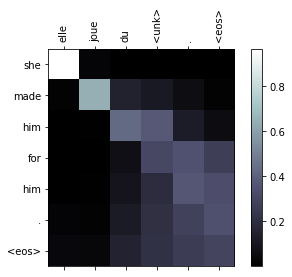

Input:['vous', 'semblez', 'contrariees', '.', '<eos>']
Label:['<sos>', 'you', 'seem', 'upset', '.', '<eos>']
Output:['you', 're', 'very', '.', '.', '<eos>']


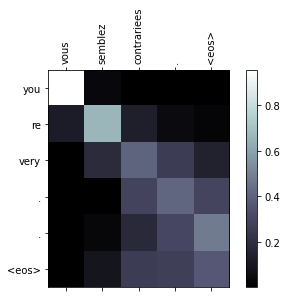

[epoch 2], [test loss 33.7198 +/- 17.7704], [testing time 2.14]
********************************************************************
Input:['tom', 'a', 'une', 'dent', 'qui', 'bouge', '.', '<eos>']
Label:['<sos>', 'tom', 'has', 'a', 'loose', 'tooth', '.', '<eos>']
Output:['tom', 'has', 'a', 'a', 'who', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 300], [train loss 25.3340 +/- 13.7042], [epoch elapsed time 23.70]
--------------------------------------------------------------------


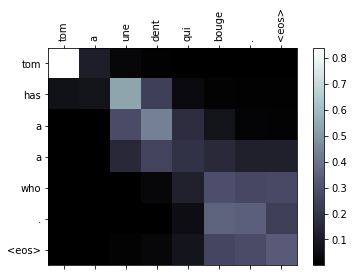

Input:['quand', 'etes', 'vous', 'devenue', 'institutrice', '?', '<eos>']
Label:['<sos>', 'when', 'did', 'you', 'become', 'a', 'teacher', '?', '<eos>']
Output:['when', 'did', 'you', 'have', '?', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 600], [train loss 25.4104 +/- 13.5805], [epoch elapsed time 47.78]
--------------------------------------------------------------------


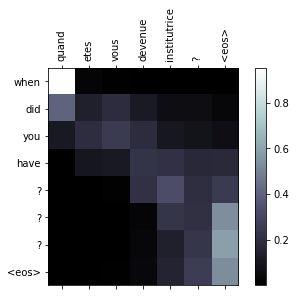

Input:['chaque', 'personne', 'qui', 'le', 'connait', 'le', 'respecte', '.', '<eos>']
Label:['<sos>', 'everyone', 'who', 'knows', 'him', 'respects', 'him', '.', '<eos>']
Output:['our', 'the', 'is', 'the', 'the', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 900], [train loss 25.4507 +/- 14.1752], [epoch elapsed time 72.18]
--------------------------------------------------------------------


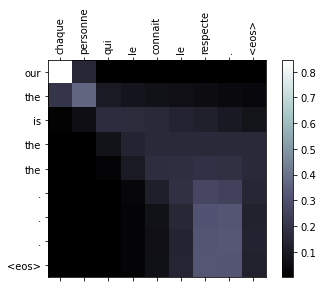

Input:['j', 'ai', 'ete', 'surpris', 'par', 'la', 'nouvelle', 'de', 'son', 'deces', 'soudain', '.', '<eos>']
Label:['<sos>', 'i', 'was', 'surprised', 'at', 'the', 'news', 'of', 'his', 'sudden', 'death', '.', '<eos>']
Output:['i', 'was', 'been', 'by', 'by', 'his', 'his', 'his', 'his', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 1200], [train loss 25.8803 +/- 14.1927], [epoch elapsed time 96.45]
--------------------------------------------------------------------


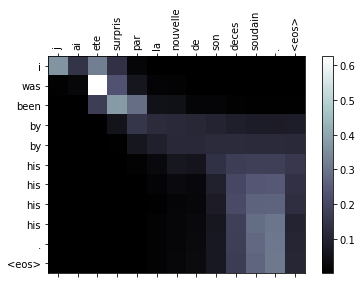

Input:['je', 'ne', 't', 'ai', 'pas', 'vu', 'depuis', 'des', 'lustres', '.', '<eos>']
Label:['<sos>', 'i', 'have', 'n t', 'seen', 'you', 'in', 'ages', '.', '<eos>']
Output:['i', 'did', 'n t', 'believe', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 1500], [train loss 25.9710 +/- 14.2833], [epoch elapsed time 120.43]
--------------------------------------------------------------------


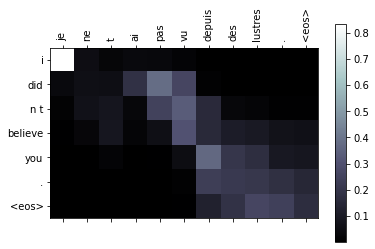

Input:['sa', 'voix', 'est', 'tres', 'belle', '.', '<eos>']
Label:['<sos>', 'her', 'voice', 'sounds', 'very', 'beautiful', '.', '<eos>']
Output:['his', 'is', 'is', 'very', 'very', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 1800], [train loss 25.7758 +/- 14.1910], [epoch elapsed time 144.06]
--------------------------------------------------------------------


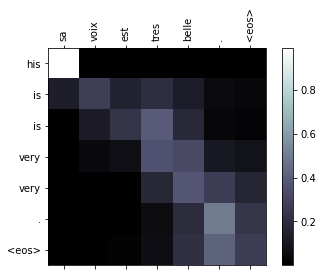

Input:['il', 'est', 'alle', 'a', 'hokkaido', '.', '<eos>']
Label:['<sos>', 'he', 'has', 'gone', 'to', 'hokkaido', '.', '<eos>']
Output:['he', 's', 'to', 'to', 'to', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 2100], [train loss 26.0089 +/- 14.2566], [epoch elapsed time 168.68]
--------------------------------------------------------------------


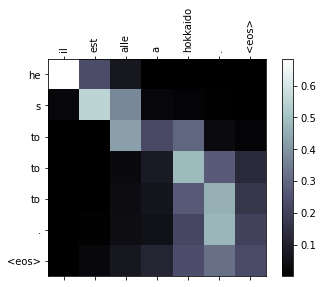

Input:['je', 'ne', 'peux', 'pas', 'etre', 'sans', 'vous', '.', '<eos>']
Label:['<sos>', 'i', 'ca', 'n t', 'be', 'without', 'you', '.', '<eos>']
Output:['i', 'ca', 'n t', 'be', 'you', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 2400], [train loss 26.0920 +/- 14.2499], [epoch elapsed time 193.32]
--------------------------------------------------------------------


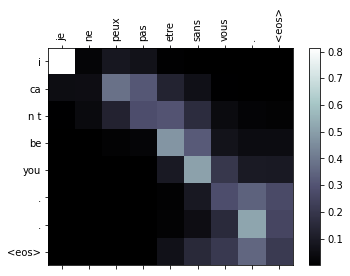

Input:['tom', 'n', 'a', 'rien', 'remarque', '.', '<eos>']
Label:['<sos>', 'tom', 'did', 'n t', 'notice', 'a', 'thing', '.', '<eos>']
Output:['tom', 'did', 'n t', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 2700], [train loss 26.1199 +/- 14.2830], [epoch elapsed time 217.66]
--------------------------------------------------------------------


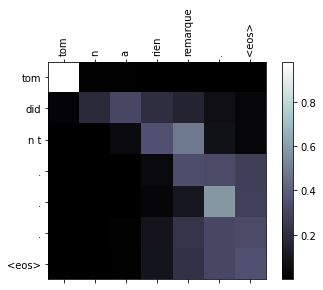

Input:['une', 'moustache', 'pousse', 'sur', 'la', 'levre', 'superieure', '.', '<eos>']
Label:['<sos>', 'a', 'mustache', 'grows', 'on', 'the', 'upper', 'lip', '.', '<eos>']
Output:['a', 'man', 'is', 'the', 'to', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 3000], [train loss 26.1906 +/- 14.3027], [epoch elapsed time 242.35]
--------------------------------------------------------------------


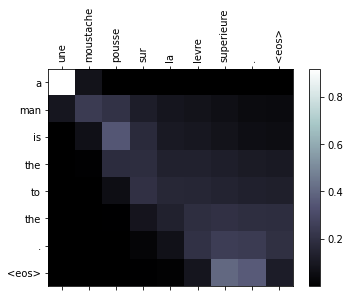

Input:['il', 'servit', 'fidelement', 'son', 'souverain', '.', '<eos>']
Label:['<sos>', 'he', 'served', 'his', 'king', 'faithfully', '.', '<eos>']
Output:['he', 'went', 'his', 'his', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 3300], [train loss 26.2100 +/- 14.2480], [epoch elapsed time 266.11]
--------------------------------------------------------------------


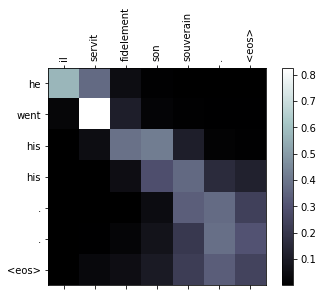

Input:['il', 'attribua', 'son', 'succes', 'a', 'la', 'chance', '.', '<eos>']
Label:['<sos>', 'he', 'attributed', 'his', 'success', 'to', 'good', 'luck', '.', '<eos>']
Output:['he', 'was', 'his', 'his', 'in', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 3600], [train loss 26.2610 +/- 14.2209], [epoch elapsed time 290.49]
--------------------------------------------------------------------


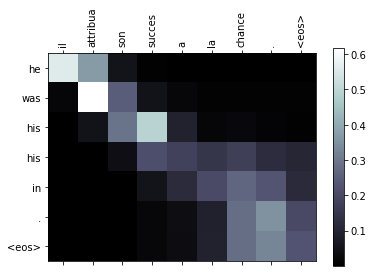

Input:['je', 'me', 'demande', 'si', 'vous', 'nous', 'aideriez', '.', '<eos>']
Label:['<sos>', 'i', 'wonder', 'if', 'you', 'd', 'help', 'us', '.', '<eos>']
Output:['i', 'wonder', 'if', 'if', 're', 'me', 'me', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 3900], [train loss 26.3235 +/- 14.2892], [epoch elapsed time 314.36]
--------------------------------------------------------------------


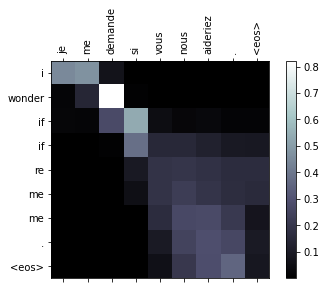

Input:['je', 'suis', 'content', 'd', 'avoir', 'autant', 'de', 'bons', 'amis', '.', '<eos>']
Label:['<sos>', 'i', 'am', 'happy', 'to', 'have', 'so', 'many', 'good', 'friends', '.', '<eos>']
Output:['i', 'm', 'a', 'to', 'to', 'to', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 4200], [train loss 26.3537 +/- 14.2873], [epoch elapsed time 338.66]
--------------------------------------------------------------------


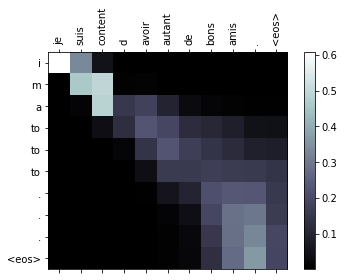

Input:['je', 'partage', 'une', 'maison', 'avec', 'deux', 'de', 'mes', 'amis', '.', '<eos>']
Label:['<sos>', 'i', 'share', 'a', 'house', 'with', 'two', 'of', 'my', 'friends', '.', '<eos>']
Output:['i', 'll', 'a', 'with', 'of', 'my', 'of', 'my', 'friends', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 4500], [train loss 26.3234 +/- 14.2971], [epoch elapsed time 362.62]
--------------------------------------------------------------------


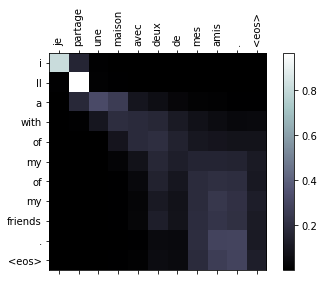

Input:['alors', 'comment', 's', 'est', 'passe', 'le', 'rendez', 'vous', '?', '<eos>']
Label:['<sos>', 'so', 'how', 'did', 'the', 'date', 'go', '?', '<eos>']
Output:['what', 'did', 'it', 'the', 'the', 'the', '?', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 4800], [train loss 26.3140 +/- 14.3090], [epoch elapsed time 386.36]
--------------------------------------------------------------------


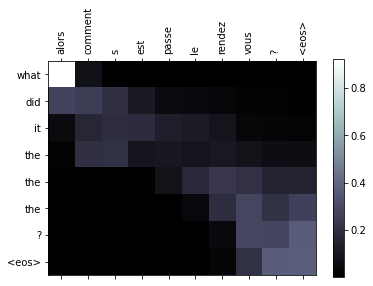

Input:['la', 'vie', 'urbaine', 'me', 'convient', 'tres', 'bien', '.', '<eos>']
Label:['<sos>', 'city', 'life', 'suits', 'me', 'very', 'well', '.', '<eos>']
Output:['the', 'your', 'gave', 'me', 'very', 'very', 'very', 'very', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 5100], [train loss 26.3508 +/- 14.3250], [epoch elapsed time 410.67]
--------------------------------------------------------------------


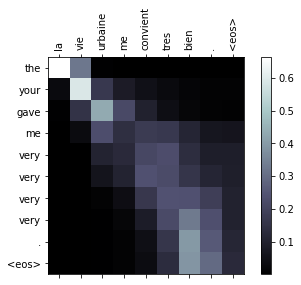

Input:['il', 'a', 'vu', 'une', 'lumiere', 'au', 'loin', '.', '<eos>']
Label:['<sos>', 'he', 'saw', 'a', 'light', 'far', 'away', '.', '<eos>']
Output:['he', 'saw', 'a', 'man', 'in', 'in', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 5400], [train loss 26.3528 +/- 14.2820], [epoch elapsed time 434.40]
--------------------------------------------------------------------


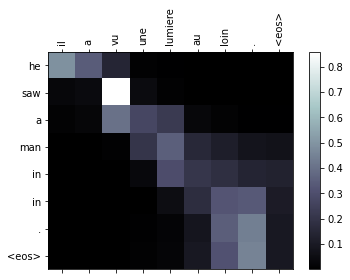

Input:['je', 'l', 'apprecie', '.', '<eos>']
Label:['<sos>', 'i', 'appreciate', 'that', '.', '<eos>']
Output:['i', 'like', 'it', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 5700], [train loss 26.3300 +/- 14.3770], [epoch elapsed time 458.07]
--------------------------------------------------------------------


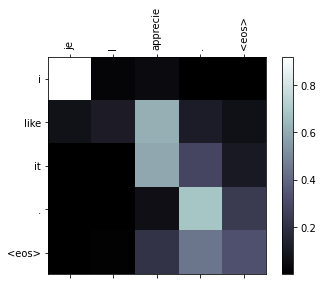

Input:['comporte', 'toi', 'simplement', 'comme', 'si', 'rien', 'n', 'etait', 'arrive', '.', '<eos>']
Label:['<sos>', 'just', 'act', 'as', 'if', 'nothing', 'has', 'happened', '.', '<eos>']
Output:['you', 'just', 'like', 'to', 'say', 'this', 'this', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 6000], [train loss 26.2743 +/- 14.3804], [epoch elapsed time 481.68]
--------------------------------------------------------------------


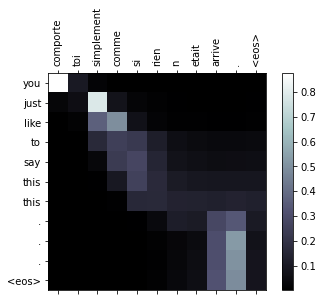

Input:['avez', 'vous', 'dit', 'a', 'tom', 'ce', 'qu', 'il', 'avait', 'besoin', 'de', 'savoir', '?', '<eos>']
Label:['<sos>', 'did', 'you', 'tell', 'tom', 'what', 'he', 'needed', 'to', 'know', '?', '<eos>']
Output:['have', 'you', 'tell', 'what', 'he', 'would', 'you', 'want', 'to', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 6300], [train loss 26.2120 +/- 14.3462], [epoch elapsed time 504.79]
--------------------------------------------------------------------


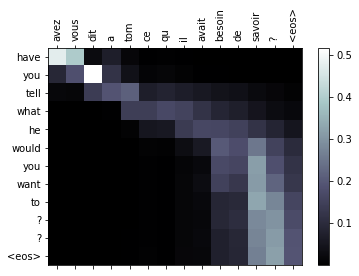

Input:['la', 'politique', 'gouvernementale', 'a', 'ete', 'critiquee', 'par', 'le', 'parti', 'd', 'opposition', '.', '<eos>']
Label:['<sos>', 'the', 'policy', 'of', 'the', 'government', 'was', 'criticized', 'by', 'the', 'opposition', 'party', '.', '<eos>']
Output:['the', 'door', 'was', 'the', 'was', 'was', '.', '.', '.', 'door', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 3 iter 6600], [train loss 26.2025 +/- 14.3432], [epoch elapsed time 528.18]
--------------------------------------------------------------------


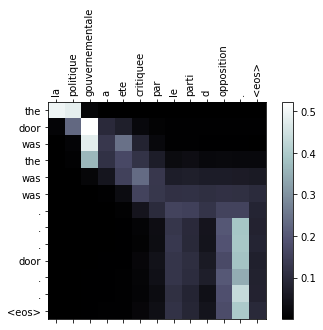

--------------------------------------------------------------------
[epoch 3], [train loss 26.2148 +/- 14.3364], [training time 532.96]
--------------------------------------------------------------------
********************************************************************
Input:['je', 'veux', 'simplement', 'que', 'tu', '<unk>', 'avec', 'moi', '.', '<eos>']
Label:['<sos>', 'i', 'just', 'want', 'you', 'back', '.', '<eos>']
Output:['i', 'just', 'want', 'to', 'to', 'to', 'with', 'you', '.', '<eos>']


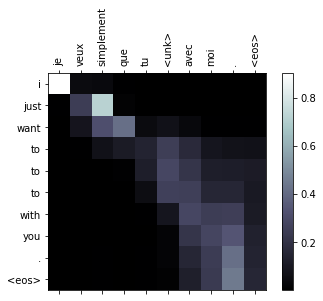

Input:['nous', 'devrions', 'probablement', 'demander', 'a', 'tom', 'd', 'abord', '.', '<eos>']
Label:['<sos>', 'we', 'should', 'probably', 'ask', 'tom', 'first', '.', '<eos>']
Output:['we', 'should', 'be', 'a', 'tom', 'to', '.', '.', '.', '.', '.', '.', '<eos>']


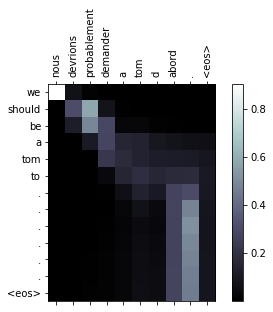

[epoch 3], [test loss 30.1277 +/- 16.2862], [testing time 2.17]
********************************************************************
Input:['n', 'utilise', 'pas', 'son', 'vrai', 'nom', '.', '<eos>']
Label:['<sos>', 'do', 'n t', 'use', 'his', 'real', 'name', '.', '<eos>']
Output:['do', 'n t', 'forget', 'his', 'name', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 300], [train loss 23.9412 +/- 13.9519], [epoch elapsed time 23.29]
--------------------------------------------------------------------


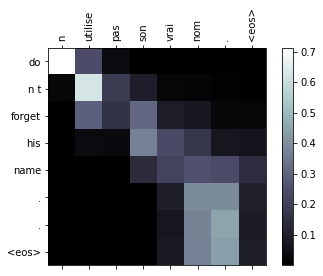

Input:['j', 'ai', 'perdu', 'ma', 'montre', '.', '<eos>']
Label:['<sos>', 'i', 'lost', 'my', 'watch', '.', '<eos>']
Output:['i', 'lost', 'my', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 600], [train loss 23.2549 +/- 14.1963], [epoch elapsed time 46.15]
--------------------------------------------------------------------


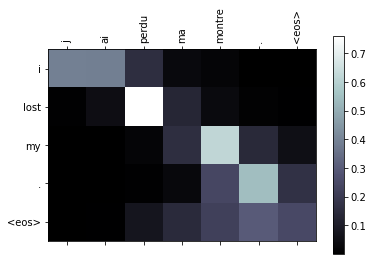

Input:['tout', 'le', 'monde', 'est', 'mort', '.', '<eos>']
Label:['<sos>', 'everyone', 's', 'dead', '.', '<eos>']
Output:['everyone', 'died', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 900], [train loss 23.4495 +/- 13.9496], [epoch elapsed time 69.49]
--------------------------------------------------------------------


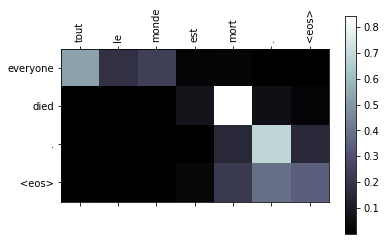

Input:['je', 'ne', 'peux', 'simplement', 'pas', 'm', 'empecher', 'de', 'me', 'faire', 'du', 'souci', 'a', 'ton', 'sujet', '.', '<eos>']
Label:['<sos>', 'i', 'just', 'ca', 'n t', 'help', 'worrying', 'about', 'you', '.', '<eos>']
Output:['i', 'just', 'just', 'n t', 'remember', 'me', 'to', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 1200], [train loss 23.3916 +/- 13.7337], [epoch elapsed time 92.44]
--------------------------------------------------------------------


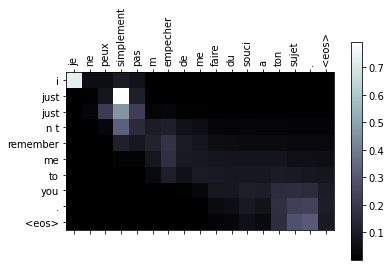

Input:['je', 'regrette', 'd', 'avoir', 'mange', 'ces', 'huitres', '.', '<eos>']
Label:['<sos>', 'i', 'regret', 'eating', 'those', 'oysters', '.', '<eos>']
Output:['i', 'll', 'to', 'but', 'and', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 1500], [train loss 23.5538 +/- 13.5667], [epoch elapsed time 115.79]
--------------------------------------------------------------------


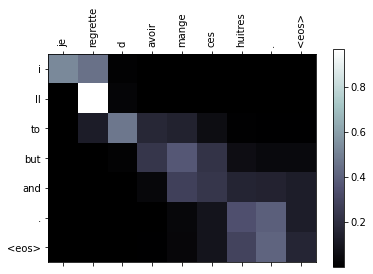

Input:['y', 'a', 't', 'il', 'quelque', 'chose', 'de', 'particulier', 'que', 'vous', 'vouliez', 'entendre', '?', '<eos>']
Label:['<sos>', 'is', 'there', 'something', 'in', 'particular', 'that', 'you', 'want', 'to', 'hear', '?', '<eos>']
Output:['are', 'you', 'sure', 'you', 'you', 'want', 'to', '?', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 1800], [train loss 23.7086 +/- 13.8394], [epoch elapsed time 139.75]
--------------------------------------------------------------------


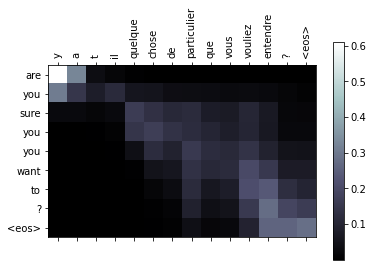

Input:['les', 'oreillons', 'sont', 'une', 'maladie', 'infectieuse', '.', '<eos>']
Label:['<sos>', 'mumps', 'is', 'an', 'infectious', 'disease', '.', '<eos>']
Output:['the', 'are', 'a', 'a', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 2100], [train loss 23.5813 +/- 14.0264], [epoch elapsed time 163.24]
--------------------------------------------------------------------


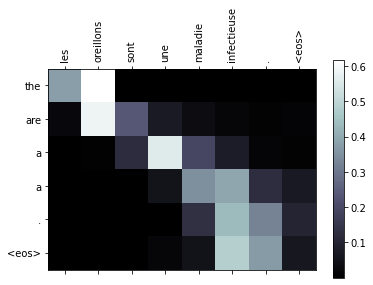

Input:['je', 'les', 'ai', 'vus', '.', '<eos>']
Label:['<sos>', 'i', 'saw', 'them', '.', '<eos>']
Output:['i', 'saw', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 2400], [train loss 23.7267 +/- 14.3533], [epoch elapsed time 186.92]
--------------------------------------------------------------------


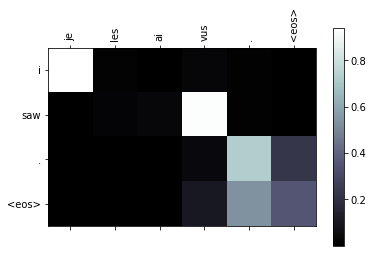

Input:['mon', 'frere', 'est', 'en', 'bonne', 'sante', '.', '<eos>']
Label:['<sos>', 'my', 'brother', 'is', 'healthy', '.', '<eos>']
Output:['my', 'brother', 'is', 'well', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 2700], [train loss 23.7772 +/- 14.4280], [epoch elapsed time 210.42]
--------------------------------------------------------------------


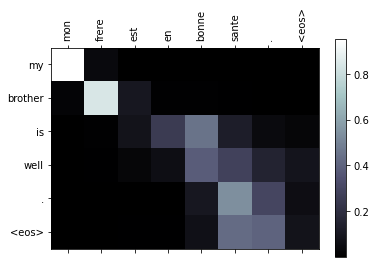

Input:['elle', 'etudie', 'ardemment', '.', '<eos>']
Label:['<sos>', 'she', 'studies', 'hard', '.', '<eos>']
Output:['she', 'walked', 'up', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 3000], [train loss 23.6614 +/- 14.3127], [epoch elapsed time 233.66]
--------------------------------------------------------------------


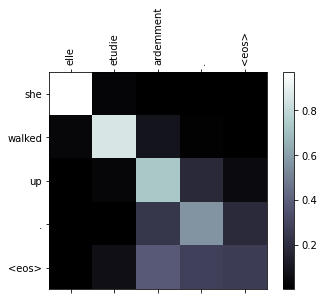

Input:['c', 'est', 'l', 'endroit', 'ou', 'travaille', 'mon', 'pere', '.', '<eos>']
Label:['<sos>', 'this', 'is', 'where', 'my', 'father', 'works', '.', '<eos>']
Output:['it', 's', 'my', 'one', 'my', 'my', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 3300], [train loss 23.6028 +/- 14.1954], [epoch elapsed time 257.02]
--------------------------------------------------------------------


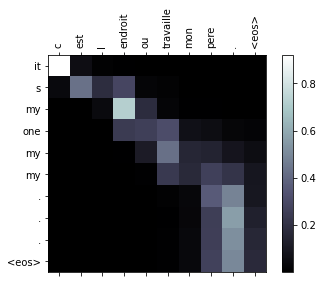

Input:['tom', 'a', 'recu', 'un', 'appel', 'urgent', 'et', 'a', 'du', 'partir', 'du', 'travail', '.', '<eos>']
Label:['<sos>', 'tom', 'got', 'an', 'emergency', 'call', 'and', 'had', 'to', 'leave', 'work', '.', '<eos>']
Output:['tom', 'had', 'a', 'a', 'and', 'a', 'a', 'a', 'work', 'a', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 3600], [train loss 23.5656 +/- 14.3186], [epoch elapsed time 280.11]
--------------------------------------------------------------------


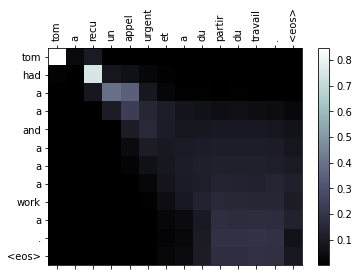

Input:['vous', 'n', 'etes', 'pas', 'seule', '.', '<eos>']
Label:['<sos>', 'you', 're', 'not', 'alone', '.', '<eos>']
Output:['you', 're', 'not', 'not', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 3900], [train loss 23.5447 +/- 14.3196], [epoch elapsed time 303.71]
--------------------------------------------------------------------


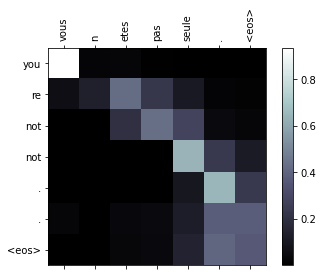

Input:['c', 'est', 'tres', 'gentil', 'a', 'vous', '.', '<eos>']
Label:['<sos>', 'that', 's', 'very', 'sweet', 'of', 'you', '.', '<eos>']
Output:['it', 's', 'very', 'very', 'to', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 4200], [train loss 23.6339 +/- 14.3356], [epoch elapsed time 327.02]
--------------------------------------------------------------------


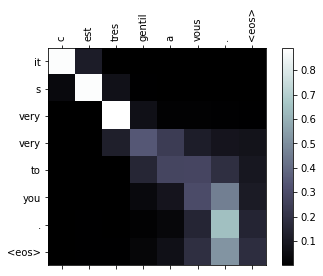

Input:['ne', 'laisse', 'personne', 'echapper', '!', '<eos>']
Label:['<sos>', 'let', 'no', 'one', 'escape', '.', '<eos>']
Output:['do', 'n t', 'be', 'again', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 4500], [train loss 23.6813 +/- 14.3266], [epoch elapsed time 350.44]
--------------------------------------------------------------------


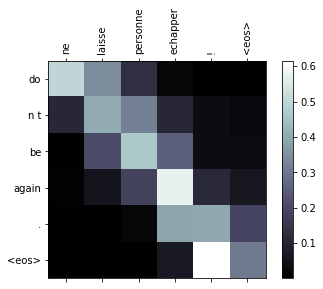

Input:['elles', 'ont', 'demenage', 'ici', 'il', 'y', 'a', 'trois', 'ans', '.', '<eos>']
Label:['<sos>', 'they', 'moved', 'here', 'three', 'years', 'ago', '.', '<eos>']
Output:['they', 'found', 'here', 'to', 'three', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 4800], [train loss 23.7209 +/- 14.2763], [epoch elapsed time 373.60]
--------------------------------------------------------------------


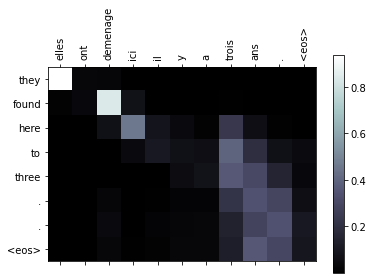

Input:['tom', 'verrouilla', 'la', 'porte', '.', '<eos>']
Label:['<sos>', 'tom', 'bolted', 'the', 'door', '.', '<eos>']
Output:['tom', 'is', 'the', 'door', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 5100], [train loss 23.7144 +/- 14.3159], [epoch elapsed time 396.56]
--------------------------------------------------------------------


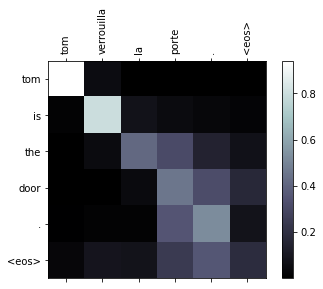

Input:['ce', 'n', 'est', 'pas', 'que', 'je', 'suis', 'antipathique', 'mais', 'je', 'ne', 'peux', 'pas', 'vous', 'aider', '.', '<eos>']
Label:['<sos>', 'it', 's', 'not', 'that', 'i', 'am', 'unsympathetic', 'but', 'i', 'am', 'not', 'able', 'to', 'help', 'you', '.', '<eos>']
Output:['it', 's', 'not', 'what', 'i', 'i', 'i', 'you', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 5400], [train loss 23.7001 +/- 14.2872], [epoch elapsed time 419.25]
--------------------------------------------------------------------


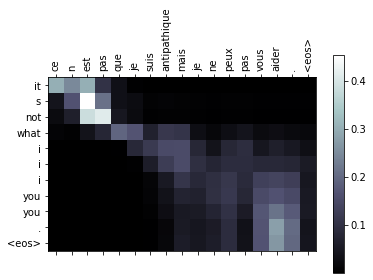

Input:['nous', 'ne', 'pouvons', 'par', 'perdre', '.', '<eos>']
Label:['<sos>', 'we', 'ca', 'n t', 'lose', '.', '<eos>']
Output:['we', 'ca', 'n t', 'find', 'to', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 5700], [train loss 23.7531 +/- 14.3298], [epoch elapsed time 442.43]
--------------------------------------------------------------------


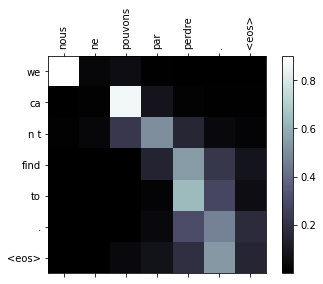

Input:['ma', 'place', 'est', 'avec', 'eux', 'desormais', '.', '<eos>']
Label:['<sos>', 'my', 'place', 'is', 'with', 'them', 'now', '.', '<eos>']
Output:['my', 'is', 'is', 'with', 'now', 'with', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 6000], [train loss 23.7868 +/- 14.2769], [epoch elapsed time 465.30]
--------------------------------------------------------------------


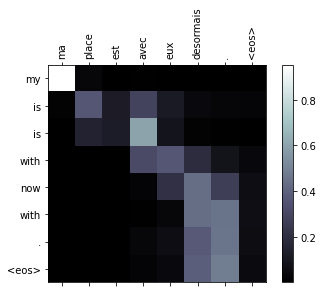

Input:['je', 'paye', 'euros', 'chaque', 'fois', 'que', 'je', 'vais', 'chez', 'le', 'dentiste', '.', '<eos>']
Label:['<sos>', 'i', 'pay', 'euros', 'for', 'every', 'visit', 'to', 'the', 'dentist', '.', '<eos>']
Output:['i', 'm', 'to', 'by', 'i', 'i', '.', 'go', 'plan', '.', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 6300], [train loss 23.7757 +/- 14.2070], [epoch elapsed time 488.07]
--------------------------------------------------------------------


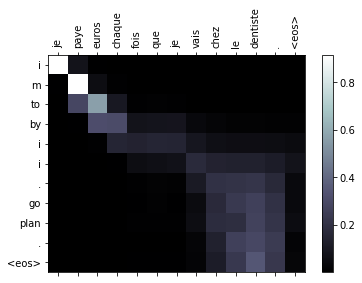

Input:['pour', 'qui', 'as', 'tu', 'vote', 'a', 'l', 'election', '?', '<eos>']
Label:['<sos>', 'who', 'did', 'you', 'vote', 'for', 'in', 'the', 'election', '?', '<eos>']
Output:['who', 'did', 'you', 'have', 'to', '?', 'the', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 4 iter 6600], [train loss 23.8021 +/- 14.1814], [epoch elapsed time 510.55]
--------------------------------------------------------------------


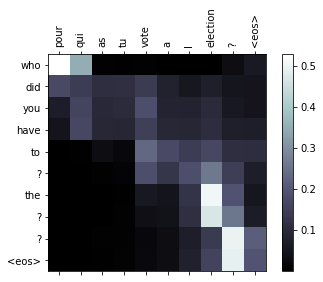

--------------------------------------------------------------------
[epoch 4], [train loss 23.8254 +/- 14.2056], [training time 515.44]
--------------------------------------------------------------------
********************************************************************
Input:['la', 'raison', 'est', '<unk>', '.', '<eos>']
Label:['<sos>', 'the', 'reason', 'is', 'clear', '.', '<eos>']
Output:['the', 'is', 'is', '.', '.', '<eos>']


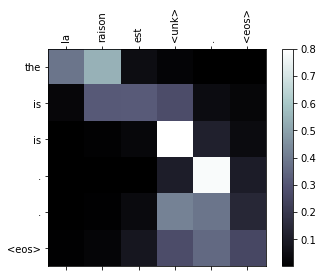

Input:['il', 'fait', 'une', 'chaleur', '<unk>', '.', '<eos>']
Label:['<sos>', 'the', 'heat', 'is', '<unk>', '.', '<eos>']
Output:['he', 's', 'a', 'big', '.', '.', '<eos>']


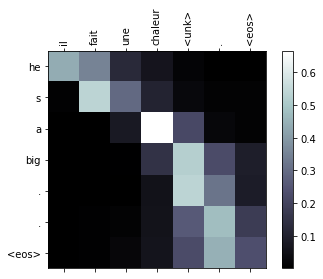

[epoch 4], [test loss 28.2728 +/- 14.5852], [testing time 1.95]
********************************************************************
Input:['nous', 'sommes', 'toutes', 'folles', '.', '<eos>']
Label:['<sos>', 'we', 're', 'all', 'crazy', '.', '<eos>']
Output:['we', 're', 'all', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 300], [train loss 20.2628 +/- 13.6789], [epoch elapsed time 22.70]
--------------------------------------------------------------------


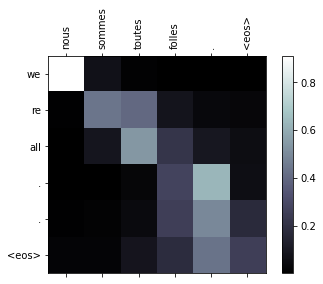

Input:['je', 'pourrai', 'etre', 'le', 'prochain', '.', '<eos>']
Label:['<sos>', 'i', 'could', 'be', 'next', '.', '<eos>']
Output:['i', 'll', 'be', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 600], [train loss 20.3732 +/- 13.2037], [epoch elapsed time 45.29]
--------------------------------------------------------------------


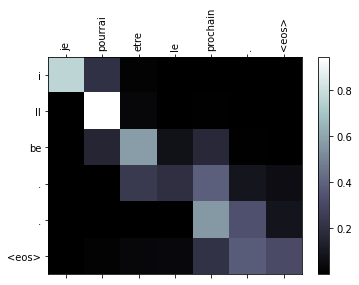

Input:['les', 'personnes', 'rousses', 'ont', 'tendance', 'a', 'avoir', 'des', 'taches', 'de', 'rousseur', '.', '<eos>']
Label:['<sos>', 'red', 'haired', 'people', 'tend', 'to', 'have', 'freckles', '.', '<eos>']
Output:['the', 'people', 'are', 'to', 'to', 'have', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 900], [train loss 20.8416 +/- 13.4981], [epoch elapsed time 68.43]
--------------------------------------------------------------------


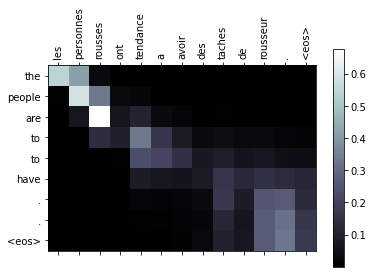

Input:['as', 'tu', 'ete', 'a', 'boston', '?', '<eos>']
Label:['<sos>', 'have', 'you', 'been', 'to', 'boston', '?', '<eos>']
Output:['do', 'you', 'been', 'boston', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 1200], [train loss 20.9164 +/- 13.6544], [epoch elapsed time 91.53]
--------------------------------------------------------------------


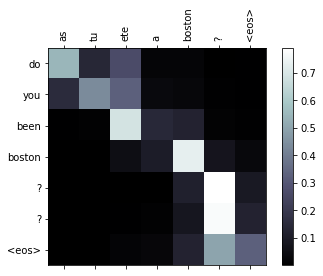

Input:['j', 'ai', 'demande', 'ses', 'cles', 'a', 'tom', '.', '<eos>']
Label:['<sos>', 'i', 'asked', 'tom', 'for', 'his', 'keys', '.', '<eos>']
Output:['i', 'wonder', 'his', 'tom', 'tom', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 1500], [train loss 20.7522 +/- 13.5203], [epoch elapsed time 114.07]
--------------------------------------------------------------------


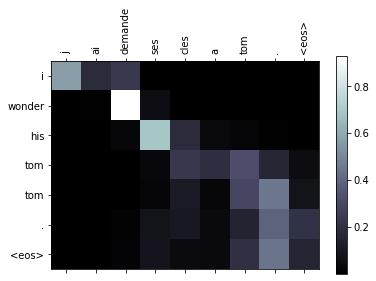

Input:['es', 'tu', 'droguee', 'au', 'crack', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'on', 'crack', '?', '<eos>']
Output:['are', 'you', 'sure', 'the', '?', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 1800], [train loss 20.8209 +/- 13.3559], [epoch elapsed time 136.82]
--------------------------------------------------------------------


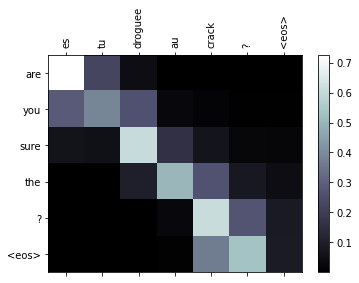

Input:['s', 'il', 'vous', 'plait', 'ne', 'me', 'laissez', 'pas', 'tout', 'seul', 'ici', '.', '<eos>']
Label:['<sos>', 'please', 'do', 'n t', 'leave', 'me', 'here', 'by', 'myself', '.', '<eos>']
Output:['i', 'll', 'do', 'n t', 'you', 'to', 'me', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 2100], [train loss 21.0319 +/- 13.4226], [epoch elapsed time 160.14]
--------------------------------------------------------------------


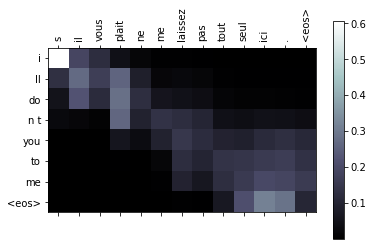

Input:['c', 'est', 'ironique', '.', '<eos>']
Label:['<sos>', 'it', 's', 'ironic', '.', '<eos>']
Output:['it', 's', 'a', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 2400], [train loss 21.0089 +/- 13.3529], [epoch elapsed time 182.98]
--------------------------------------------------------------------


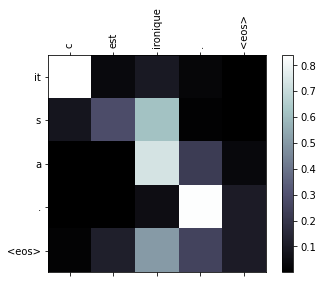

Input:['ne', 'me', 'le', 'dites', 'pas', 'si', 'vous', 'ne', 'voulez', 'pas', '.', '<eos>']
Label:['<sos>', 'do', 'n t', 'tell', 'me', 'if', 'you', 'do', 'n t', 'want', 'to', '.', '<eos>']
Output:['do', 'n t', 'tell', 'me', 'if', 'you', 'do', 'n t', 'do', 'you', 'do', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 2700], [train loss 21.1304 +/- 13.5092], [epoch elapsed time 206.23]
--------------------------------------------------------------------


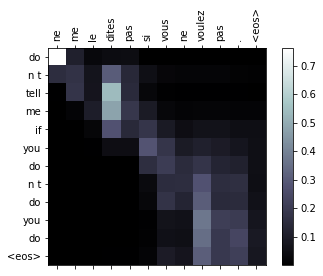

Input:['j', 'adore', 'la', 'nourriture', 'italienne', '.', '<eos>']
Label:['<sos>', 'i', 'love', 'italian', 'food', '.', '<eos>']
Output:['i', 'love', 'the', 'teacher', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 3000], [train loss 21.2448 +/- 13.8149], [epoch elapsed time 229.39]
--------------------------------------------------------------------


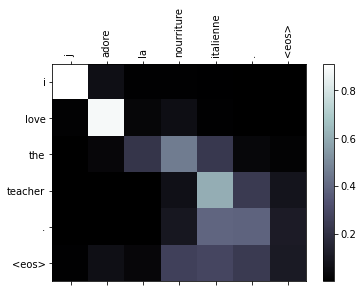

Input:['j', 'aimerais', 'vous', 'poser', 'quelques', 'questions', '.', '<eos>']
Label:['<sos>', 'i', 'd', 'like', 'to', 'ask', 'you', 'a', 'couple', 'of', 'questions', '.', '<eos>']
Output:['i', 'd', 'like', 'to', 'ask', 'you', 'a', 'questions', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 3300], [train loss 21.4515 +/- 13.9423], [epoch elapsed time 252.95]
--------------------------------------------------------------------


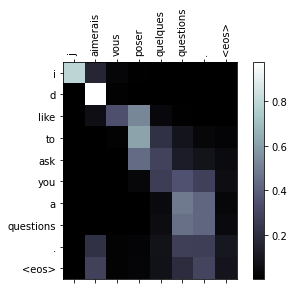

Input:['vous', 'etes', 'deloyales', '.', '<eos>']
Label:['<sos>', 'you', 're', 'disloyal', '.', '<eos>']
Output:['you', 're', 'upset', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 3600], [train loss 21.4810 +/- 13.9592], [epoch elapsed time 275.86]
--------------------------------------------------------------------


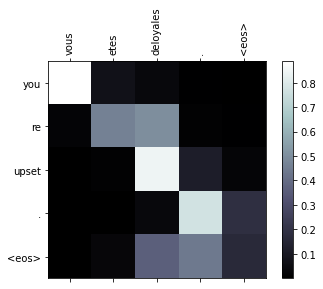

Input:['on', 'dirait', 'que', 'vous', 'avez', 'pleure', '.', '<eos>']
Label:['<sos>', 'it', 'looks', 'like', 'you', 've', 'been', 'crying', '.', '<eos>']
Output:['you', 'looks', 'you', 'you', 've', 'been', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 3900], [train loss 21.5344 +/- 13.9327], [epoch elapsed time 298.90]
--------------------------------------------------------------------


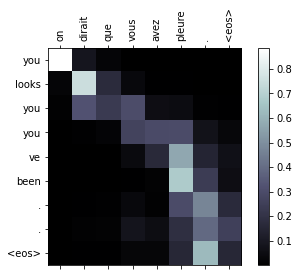

Input:['vous', 'n', 'auriez', 'pas', 'du', 'payer', 'la', 'facture', '.', '<eos>']
Label:['<sos>', 'you', 'should', 'n t', 'have', 'paid', 'the', 'bill', '.', '<eos>']
Output:['you', 'should', 'have', 'n t', 'have', 'the', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 4200], [train loss 21.6089 +/- 13.9234], [epoch elapsed time 322.36]
--------------------------------------------------------------------


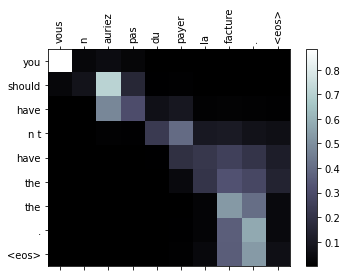

Input:['est', 'ce', 'de', 'l', 'or', 'pur', '?', '<eos>']
Label:['<sos>', 'is', 'that', 'pure', 'gold', '?', '<eos>']
Output:['is', 'it', 'the', 'of', '?', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 4500], [train loss 21.6175 +/- 13.9848], [epoch elapsed time 345.33]
--------------------------------------------------------------------


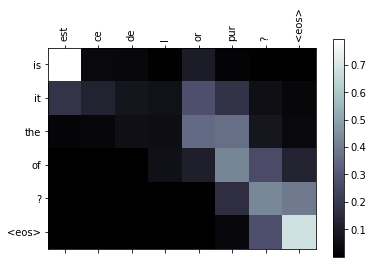

Input:['j', 'aimerais', 'vivre', 'a', 'new', 'york', '.', '<eos>']
Label:['<sos>', 'i', 'd', 'like', 'to', 'live', 'in', 'new', 'york', '.', '<eos>']
Output:['i', 'd', 'like', 'to', 'to', 'in', 'the', 'car', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 4800], [train loss 21.6739 +/- 14.0096], [epoch elapsed time 368.65]
--------------------------------------------------------------------


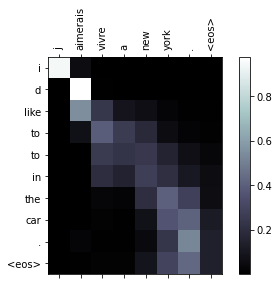

Input:['tout', 'le', 'monde', 'eut', 'l', 'air', 'perplexe', '.', '<eos>']
Label:['<sos>', 'everyone', 'looked', 'puzzled', '.', '<eos>']
Output:['everyone', 'looked', 'look', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 5100], [train loss 21.7372 +/- 14.0463], [epoch elapsed time 391.84]
--------------------------------------------------------------------


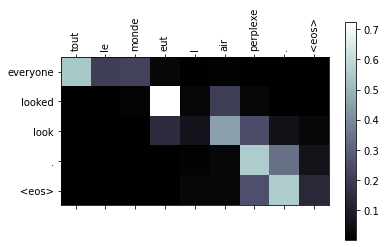

Input:['mes', 'lunettes', 'glissent', 'constamment', 'au', 'bout', 'de', 'mon', 'nez', '.', '<eos>']
Label:['<sos>', 'my', 'glasses', 'keep', 'slipping', 'down', 'my', 'nose', '.', '<eos>']
Output:['my', 'parents', 'are', 'people', 'to', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 5400], [train loss 21.8333 +/- 14.1246], [epoch elapsed time 415.08]
--------------------------------------------------------------------


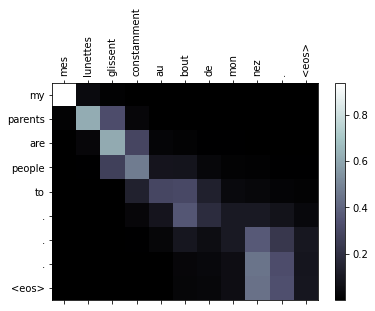

Input:['penses', 'tu', 'qu', 'elle', 'soit', 'mignonne', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'think', 'she', 's', 'pretty', '?', '<eos>']
Output:['do', 'you', 'think', 'that', 'she', 'is', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 5700], [train loss 21.8953 +/- 14.1433], [epoch elapsed time 437.71]
--------------------------------------------------------------------


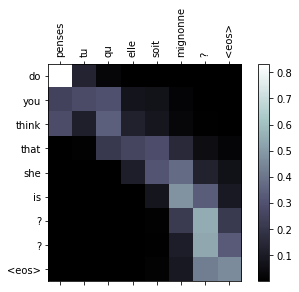

Input:['le', 'criminel', 'implora', 'la', 'clemence', 'du', 'juge', '.', '<eos>']
Label:['<sos>', 'the', 'criminal', 'begged', 'the', 'judge', 'for', 'mercy', '.', '<eos>']
Output:['the', 'doctor', 'made', 'the', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 6000], [train loss 21.9416 +/- 14.1556], [epoch elapsed time 460.40]
--------------------------------------------------------------------


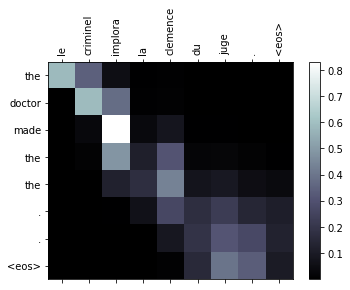

Input:['ne', 'depense', 'pas', 'trop', 'd', 'argent', '.', '<eos>']
Label:['<sos>', 'do', 'n t', 'spend', 'too', 'much', 'money', '.', '<eos>']
Output:['do', 'n t', 'leave', 'too', 'much', 'money', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 6300], [train loss 21.9921 +/- 14.1874], [epoch elapsed time 483.07]
--------------------------------------------------------------------


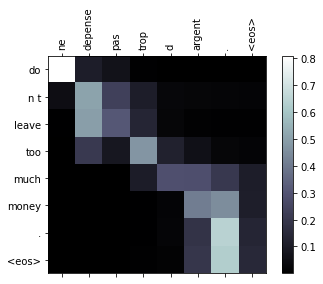

Input:['resserre', 'cette', 'vis', '!', '<eos>']
Label:['<sos>', 'tighten', 'this', 'screw', '.', '<eos>']
Output:['let', 'it', 'one', '.', '<eos>']
--------------------------------------------------------------------
[epoch 5 iter 6600], [train loss 22.0793 +/- 14.2503], [epoch elapsed time 506.06]
--------------------------------------------------------------------


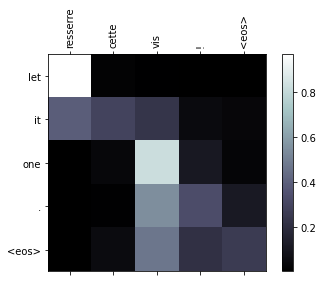

--------------------------------------------------------------------
[epoch 5], [train loss 22.0800 +/- 14.2654], [training time 510.45]
--------------------------------------------------------------------
********************************************************************
Input:['pourquoi', 'n', 'y', 'a', 't', 'il', 'aucun', 'argent', 'dans', 'mon', 'portefeuille', '?', '<eos>']
Label:['<sos>', 'why', 'is', 'n t', 'there', 'any', 'money', 'in', 'my', 'wallet', '?', '<eos>']
Output:['why', 'do', 'n t', 'you', 'have', 'a', '?', '<eos>']


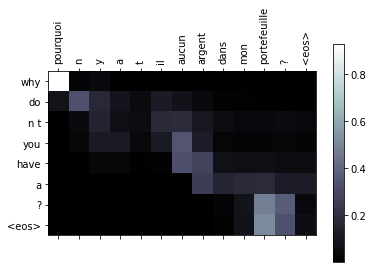

Input:['il', '<unk>', 'le', '<unk>', 'de', 'la', '<unk>', '.', '<eos>']
Label:['<sos>', 'he', 'demanded', 'payment', 'of', 'the', '<unk>', '.', '<eos>']
Output:['he', 'was', 'the', 'the', 'the', '.', '.', '<eos>']


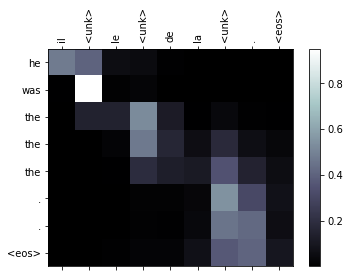

[epoch 5], [test loss 28.0080 +/- 16.0005], [testing time 2.02]
********************************************************************
Input:['ce', 'livre', 'est', 'trop', 'cher', '.', '<eos>']
Label:['<sos>', 'this', 'book', 'is', 'too', 'expensive', '.', '<eos>']
Output:['this', 'book', 'is', 'too', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 300], [train loss 17.5654 +/- 12.2472], [epoch elapsed time 21.90]
--------------------------------------------------------------------


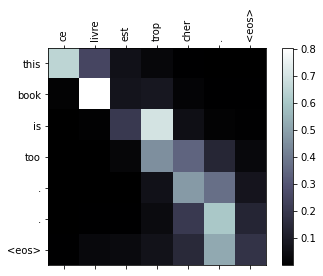

Input:['les', 'scientifiques', 'commencent', 'lentement', 'a', 'assembler', 'les', 'mecanismes', 'de', 'la', 'vieillesse', '.', '<eos>']
Label:['<sos>', 'scientists', 'are', 'slowly', 'piecing', 'together', 'the', 'mechanism', 'of', 'aging', '.', '<eos>']
Output:['scientists', 'are', 'playing', 'at', 'the', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 600], [train loss 18.3334 +/- 12.4676], [epoch elapsed time 44.90]
--------------------------------------------------------------------


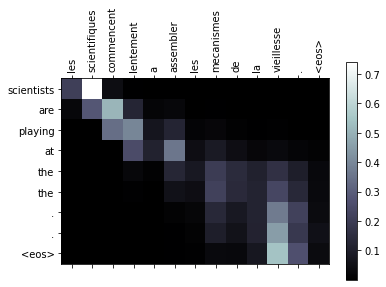

Input:['je', 'pense', 'que', 'le', 'jogging', 'est', 'un', 'bon', 'exercice', '.', '<eos>']
Label:['<sos>', 'i', 'think', 'jogging', 'is', 'good', 'exercise', '.', '<eos>']
Output:['i', 'think', 'the', 'is', 'is', 'a', 'good', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 900], [train loss 18.9131 +/- 12.6026], [epoch elapsed time 67.76]
--------------------------------------------------------------------


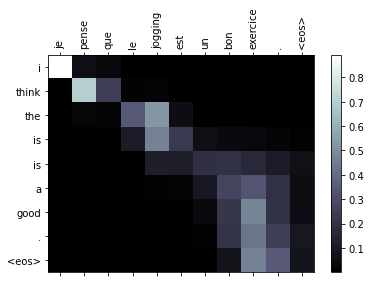

Input:['je', 'pense', 'qu', 'elles', 'veulent', 'que', 'vous', 'le', 'fassiez', '.', '<eos>']
Label:['<sos>', 'i', 'think', 'they', 'want', 'you', 'to', 'do', 'it', '.', '<eos>']
Output:['i', 'think', 'they', 'want', 'you', 'to', 'do', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 1200], [train loss 19.4064 +/- 12.8470], [epoch elapsed time 90.89]
--------------------------------------------------------------------


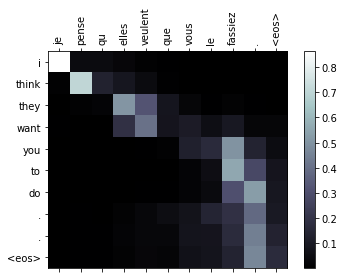

Input:['il', 'me', 'faut', 'vraiment', 'm', 'en', 'aller', '.', '<eos>']
Label:['<sos>', 'i', 'really', 'need', 'to', 'go', '.', '<eos>']
Output:['i', 'really', 'need', 'to', 'go', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 1500], [train loss 19.4053 +/- 12.8994], [epoch elapsed time 113.80]
--------------------------------------------------------------------


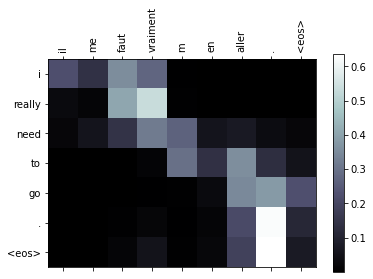

Input:['il', 'a', 'arrete', 'de', 'boire', '.', '<eos>']
Label:['<sos>', 'he', 'stopped', 'drinking', '.', '<eos>']
Output:['he', 'fell', 'a', 'drink', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 1800], [train loss 19.3468 +/- 12.8847], [epoch elapsed time 136.61]
--------------------------------------------------------------------


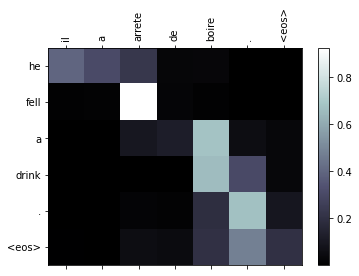

Input:['puis', 'je', 'etre', 'excuse', '?', '<eos>']
Label:['<sos>', 'can', 'i', 'be', 'excused', '?', '<eos>']
Output:['may', 'i', 'need', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 2100], [train loss 19.2917 +/- 12.7678], [epoch elapsed time 159.37]
--------------------------------------------------------------------


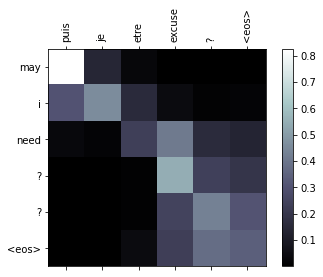

Input:['cette', 'soupe', 'est', 'trop', 'epicee', '.', '<eos>']
Label:['<sos>', 'this', 'soup', 'is', 'too', 'spicy', '.', '<eos>']
Output:['this', 'is', 'is', 'too', 'too', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 2400], [train loss 19.4968 +/- 13.0948], [epoch elapsed time 183.11]
--------------------------------------------------------------------


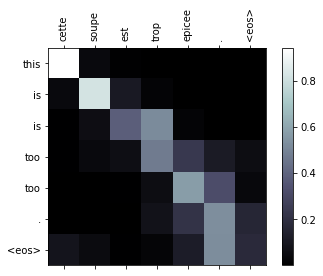

Input:['je', 'suis', 'certainement', 'reconnaissant', 'pour', 'toute', 'votre', 'aide', '.', '<eos>']
Label:['<sos>', 'i', 'sure', 'appreciate', 'all', 'your', 'help', '.', '<eos>']
Output:['i', 'm', 'very', 'for', 'all', 'your', 'help', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 2700], [train loss 19.6817 +/- 13.3238], [epoch elapsed time 206.20]
--------------------------------------------------------------------


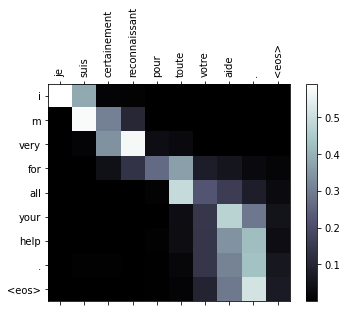

Input:['je', 'suis', 'juste', 'paresseuse', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'just', 'lazy', '.', '<eos>']
Output:['i', 'm', 'just', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 3000], [train loss 19.6683 +/- 13.3716], [epoch elapsed time 229.21]
--------------------------------------------------------------------


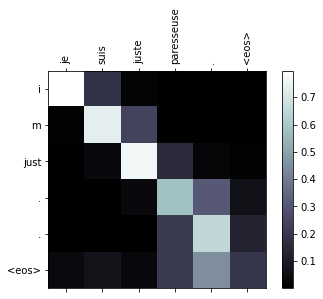

Input:['nous', 'perdons', 'tous', 'du', 'temps', '.', '<eos>']
Label:['<sos>', 'we', 're', 'all', 'wasting', 'time', '.', '<eos>']
Output:['we', 're', 'all', 'time', 'time', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 3300], [train loss 19.7137 +/- 13.3871], [epoch elapsed time 251.91]
--------------------------------------------------------------------


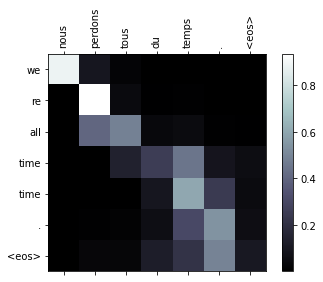

Input:['nous', 'n', 'avons', 'pas', 'ete', 'par', 'ici', 'aussi', 'longtemps', '.', '<eos>']
Label:['<sos>', 'we', 'have', 'n t', 'been', 'around', 'that', 'long', '.', '<eos>']
Output:['we', 'were', 'not', 'by', 'here', 'long', 'long', 'long', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 3600], [train loss 19.9049 +/- 13.5404], [epoch elapsed time 274.82]
--------------------------------------------------------------------


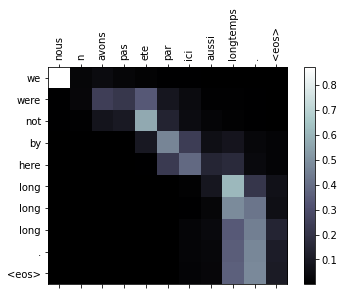

Input:['pourquoi', 'est il', 'occupe', '?', '<eos>']
Label:['<sos>', 'why', 'is', 'he', 'busy', '?', '<eos>']
Output:['why', 'is', 'he', 'busy', '?', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 3900], [train loss 19.9789 +/- 13.5195], [epoch elapsed time 297.94]
--------------------------------------------------------------------


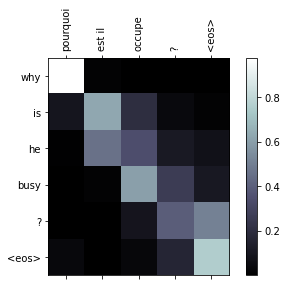

Input:['je', 'n', 'arrive', 'pas', 'a', 'croire', 'que', 'tu', 'etais', 'le', 'gamin', 'le', 'plus', 'intelligent', 'de', 'ta', 'classe', '.', '<eos>']
Label:['<sos>', 'i', 'ca', 'n t', 'believe', 'that', 'you', 'were', 'the', 'smartest', 'kid', 'in', 'your', 'class', '.', '<eos>']
Output:['i', 'ca', 'n t', 'believe', 'you', 's', 'the', 'the', 'man', '.', '.', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 4200], [train loss 19.9986 +/- 13.5194], [epoch elapsed time 320.76]
--------------------------------------------------------------------


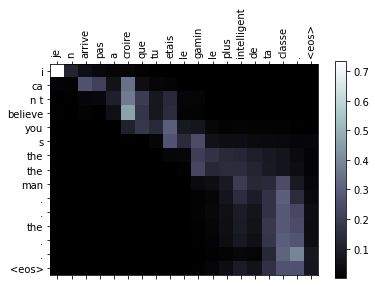

Input:['le', 'meilleur', 'aspect', 'du', 'travail', 'en', 'equipe', 'est', 'que', 'si', 'quelque', 'chose', 'va', 'de', 'travers', 'on', 'peut', 'toujours', 'le', 'mettre', 'sur', 'le', 'dos', 'de', 'quelqu', 'un', 'd', 'autre', '.', '<eos>']
Label:['<sos>', 'the', 'best', 'thing', 'about', 'working', 'in', 'a', 'team', 'is', 'that', 'when', 'something', 'goes', 'wrong', 'you', 'can', 'always', 'blame', 'someone', 'else', '.', '<eos>']
Output:['the', 'better', 'will', 'of', 'a', 'in', 'japan', 'little', 'is', 'about', 'something', 'japan', 'is', 'in', 'in', 'came', 'be', 'japan', 'in', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 4500], [train loss 20.0864 +/- 13.5586], [epoch elapsed time 344.25]
--------------------------------------------------------------------


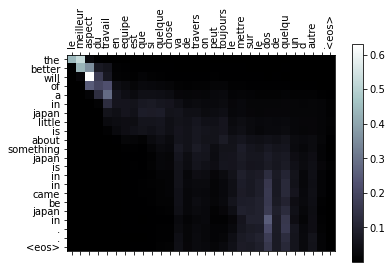

Input:['il', 'l', 'a', 'interrompu', 'en', 'lui', 'disant', 'non', '.', '<eos>']
Label:['<sos>', 'he', 'cut', 'him', 'short', 'by', 'saying', 'no', '.', '<eos>']
Output:['he', 'was', 'out', 'to', 'do', 'it', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 4800], [train loss 20.2825 +/- 13.6542], [epoch elapsed time 368.32]
--------------------------------------------------------------------


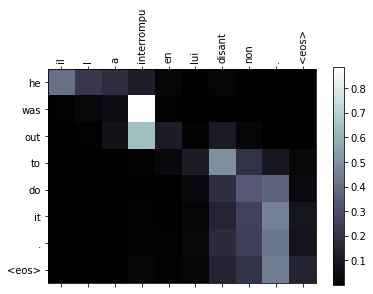

Input:['j', 'aimerais', 'me', 'faire', 'rembourser', '.', '<eos>']
Label:['<sos>', 'i', 'd', 'like', 'to', 'get', 'a', 'refund', '.', '<eos>']
Output:['i', 'd', 'like', 'to', 'make', 'a', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 5100], [train loss 20.3155 +/- 13.6783], [epoch elapsed time 391.58]
--------------------------------------------------------------------


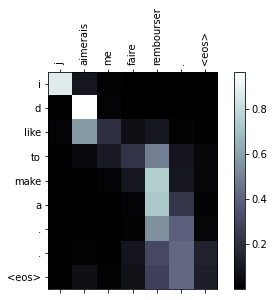

Input:['je', 'pensais', 'que', 'tu', 'avais', 'faim', '.', '<eos>']
Label:['<sos>', 'i', 'thought', 'you', 'were', 'hungry', '.', '<eos>']
Output:['i', 'thought', 'you', 'were', 'hungry', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 5400], [train loss 20.3800 +/- 13.7193], [epoch elapsed time 414.97]
--------------------------------------------------------------------


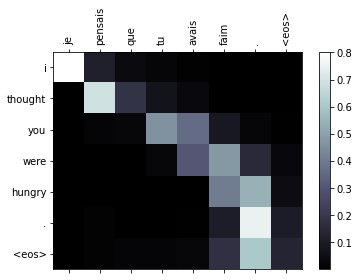

Input:['j', 'aurais', 'du', 'te', 'demander', 'conseil', '.', '<eos>']
Label:['<sos>', 'i', 'wish', 'i', 'had', 'asked', 'you', 'for', 'advice', '.', '<eos>']
Output:['i', 'had', 'have', 'to', 'ask', 'you', 'advice', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 5700], [train loss 20.4995 +/- 13.8224], [epoch elapsed time 438.40]
--------------------------------------------------------------------


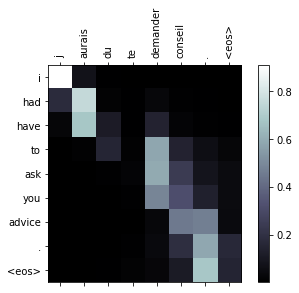

Input:['c', 'est', 'pourquoi', 'je', 'ne', 'me', 'marie', 'pas', '.', '<eos>']
Label:['<sos>', 'that', 's', 'why', 'i', 'm', 'not', 'getting', 'married', '.', '<eos>']
Output:['it', 'is', 'why', 'i', 'm', 'not', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 6000], [train loss 20.5592 +/- 13.8207], [epoch elapsed time 461.25]
--------------------------------------------------------------------


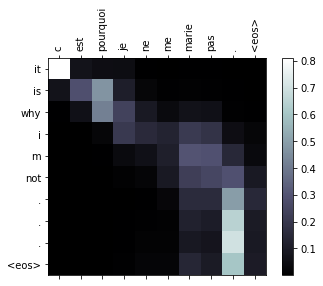

Input:['obtenez', 'moi', 'les', 'preuves', '!', '<eos>']
Label:['<sos>', 'get', 'me', 'the', 'evidence', '.', '<eos>']
Output:['get', 'me', 'the', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 6300], [train loss 20.5582 +/- 13.7599], [epoch elapsed time 484.16]
--------------------------------------------------------------------


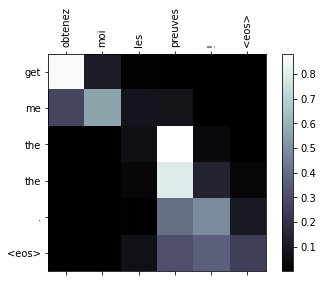

Input:['je', 'ne', 'vois', 'aucune', 'option', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'see', 'any', 'options', '.', '<eos>']
Output:['i', 'do', 'n t', 'see', 'you', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 6 iter 6600], [train loss 20.6786 +/- 13.8331], [epoch elapsed time 507.27]
--------------------------------------------------------------------


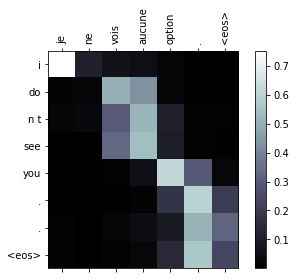

--------------------------------------------------------------------
[epoch 6], [train loss 20.6856 +/- 13.8152], [training time 511.61]
--------------------------------------------------------------------
********************************************************************
Input:['rien', 'ne', 'semblait', 'fonctionner', '.', '<eos>']
Label:['<sos>', 'nothing', 'seemed', 'to', 'work', '.', '<eos>']
Output:['nothing', 'll', 'be', 'be', '.', '<eos>']


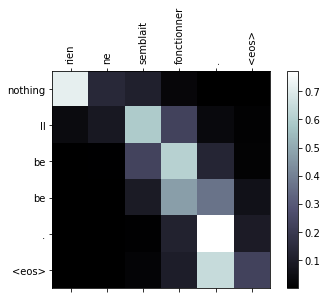

Input:['avez', 'vous', 'deja', 'regle', 'la', 'note', '?', '<eos>']
Label:['<sos>', 'have', 'you', 'already', 'settled', 'the', 'bill', '?', '<eos>']
Output:['have', 'you', 'already', 'any', 'at', '?', '<eos>']


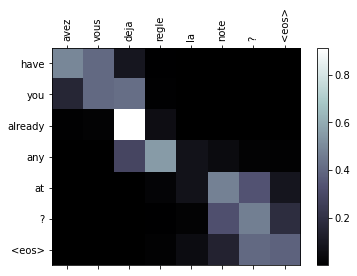

[epoch 6], [test loss 28.4861 +/- 17.9160], [testing time 2.16]
********************************************************************
Input:['je', 'suis', 'desole', 'mais', 'l', 'heure', 'd', 'aller', 'te', 'coucher', 'est', 'passee', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'sorry', 'but', 'it', 's', 'past', 'your', 'bedtime', '.', '<eos>']
Output:['i', 'm', 'but', 'but', 'the', 's', 'going', 'you', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 300], [train loss 17.5977 +/- 12.5220], [epoch elapsed time 22.83]
--------------------------------------------------------------------


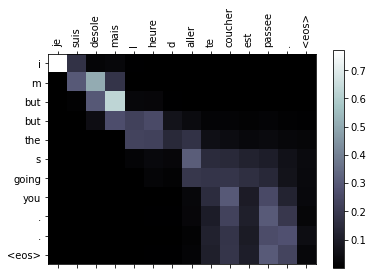

Input:['a', 'ta', 'place', 'je', 'ne', 'le', 'ferais', 'pas', '.', '<eos>']
Label:['<sos>', 'if', 'i', 'were', 'you', 'i', 'would', 'not', 'do', 'it', '.', '<eos>']
Output:['no', 'i', 'were', 'n t', 'i', 'have', 'it', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 600], [train loss 17.6315 +/- 12.5460], [epoch elapsed time 45.73]
--------------------------------------------------------------------


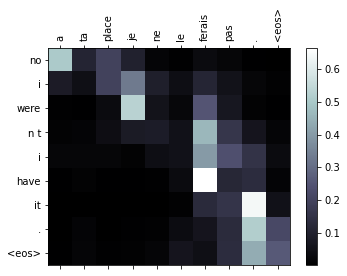

Input:['il', 'a', 'refuse', 'de', 'nous', 'croire', '.', '<eos>']
Label:['<sos>', 'he', 'would', 'n t', 'believe', 'us', '.', '<eos>']
Output:['he', 'did', 'n t', 'believe', 'it', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 900], [train loss 18.6257 +/- 13.2175], [epoch elapsed time 69.27]
--------------------------------------------------------------------


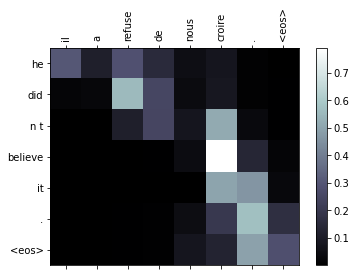

Input:['chacun', 'devrait', 'etre', 'maitre', 'de', 'son', 'destin', '.', '<eos>']
Label:['<sos>', 'everyone', 'ought', 'to', 'be', 'the', 'master', 'of', 'his', 'own', 'destiny', '.', '<eos>']
Output:['it', 'should', 'be', 'to', 'be', 'a', 'of', 'his', 'of', 'his', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 1200], [train loss 18.4614 +/- 13.2085], [epoch elapsed time 92.23]
--------------------------------------------------------------------


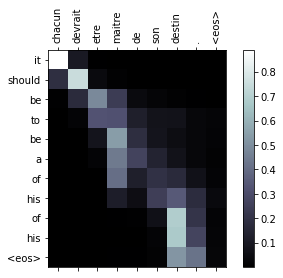

Input:['j', 'ai', 'deja', 'memorise', 'votre', 'numero', 'de', 'telephone', '.', '<eos>']
Label:['<sos>', 'i', 've', 'already', 'memorized', 'your', 'phone', 'number', '.', '<eos>']
Output:['i', 've', 'already', 'your', 'phone', 'number', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 1500], [train loss 18.3333 +/- 12.8497], [epoch elapsed time 114.67]
--------------------------------------------------------------------


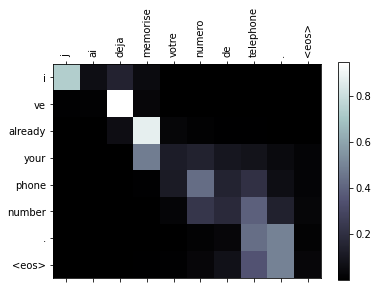

Input:['beaucoup', 'de', 'temps', 'fut', 'gache', '.', '<eos>']
Label:['<sos>', 'a', 'lot', 'of', 'time', 'was', 'wasted', '.', '<eos>']
Output:['a', 'lot', 'of', 'time', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 1800], [train loss 18.1484 +/- 12.8751], [epoch elapsed time 137.35]
--------------------------------------------------------------------


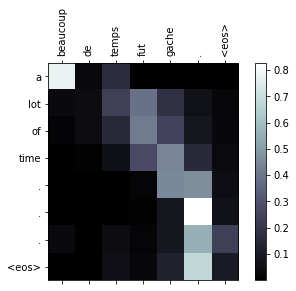

Input:['je', 'suis', 'quasiment', 'pret', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'about', 'ready', '.', '<eos>']
Output:['i', 'am', 'ready', 'ready', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 2100], [train loss 18.2245 +/- 12.8695], [epoch elapsed time 160.03]
--------------------------------------------------------------------


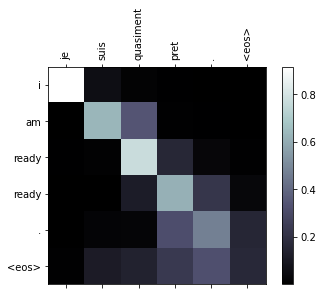

Input:['c', 'est', 'beaucoup', 'plus', 'amusant', 'que', 'je', 'ne', 'le', 'pensais', '.', '<eos>']
Label:['<sos>', 'it', 's', 'a', 'lot', 'more', 'fun', 'than', 'i', 'thought', 'it', 'would', 'be', '.', '<eos>']
Output:['it', 's', 'a', 'lot', 'than', 'than', 'i', 'i', 'was', 'it', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 2400], [train loss 18.3417 +/- 12.9838], [epoch elapsed time 183.14]
--------------------------------------------------------------------


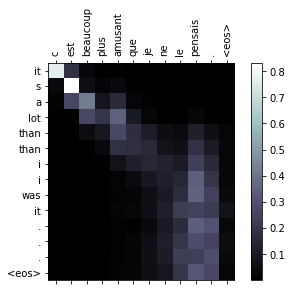

Input:['nous', 'avons', 'entendu', 'un', 'bruit', '.', '<eos>']
Label:['<sos>', 'we', 'heard', 'a', 'noise', '.', '<eos>']
Output:['we', 'heard', 'an', 'big', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 2700], [train loss 18.4517 +/- 13.0182], [epoch elapsed time 206.57]
--------------------------------------------------------------------


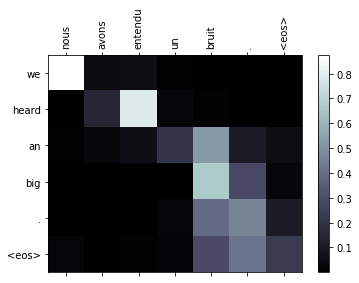

Input:['c', 'est', 'une', 'idee', 'dingue', '.', '<eos>']
Label:['<sos>', 'that', 's', 'a', 'crazy', 'idea', '.', '<eos>']
Output:['that', 's', 'a', 'nice', 'idea', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 3000], [train loss 18.6192 +/- 13.0900], [epoch elapsed time 229.46]
--------------------------------------------------------------------


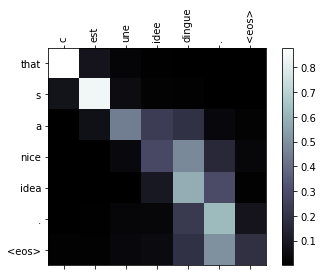

Input:['tu', 'gaspilles', 'du', 'temps', '.', '<eos>']
Label:['<sos>', 'you', 're', 'wasting', 'time', '.', '<eos>']
Output:['you', 're', 'looking', 'in', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 3300], [train loss 18.6666 +/- 13.0707], [epoch elapsed time 252.28]
--------------------------------------------------------------------


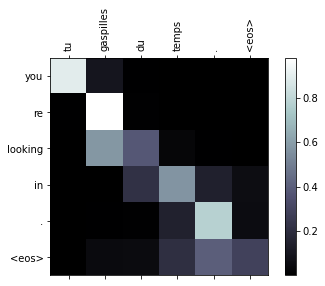

Input:['il', 'a', 'pousse', 'le', 'chat', 'dans', 'la', 'piscine', '.', '<eos>']
Label:['<sos>', 'he', 'pushed', 'the', 'cat', 'into', 'the', 'swimming', 'pool', '.', '<eos>']
Output:['he', 'left', 'the', 'cat', 'the', 'the', 'world', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 3600], [train loss 18.8522 +/- 13.1440], [epoch elapsed time 275.60]
--------------------------------------------------------------------


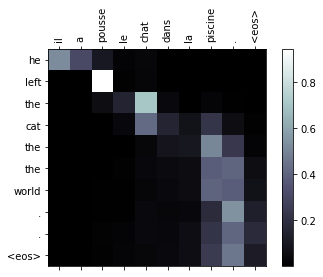

Input:['il', 'ne', 'restera', 'rien', '.', '<eos>']
Label:['<sos>', 'there', 'wo', 'n t', 'be', 'anything', 'left', '.', '<eos>']
Output:['he', 'wo', 'n t', 'be', 'anything', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 3900], [train loss 18.8489 +/- 13.2299], [epoch elapsed time 298.22]
--------------------------------------------------------------------


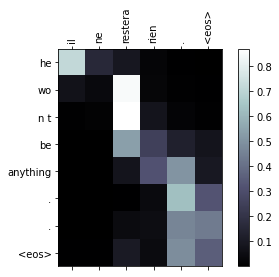

Input:['ils', 'l', 'ont', 'change', 'tres', 'recemment', '.', '<eos>']
Label:['<sos>', 'they', 'changed', 'it', 'very', 'recently', '.', '<eos>']
Output:['they', 'made', 'her', 'very', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 4200], [train loss 18.8550 +/- 13.2441], [epoch elapsed time 321.02]
--------------------------------------------------------------------


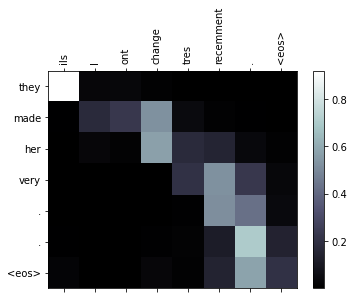

Input:['nous', 'avons', 'trouve', 'un', 'pepin', 'dans', 'le', 'programme', 'qui', 'devra', 'etre', 'traite', 'avant', 'que', 'nous', 'puissions', 'proceder', '.', '<eos>']
Label:['<sos>', 'we', 'found', 'a', 'glitch', 'in', 'the', 'program', 'that', 'will', 'have', 'to', 'be', 'dealt', 'with', 'before', 'we', 'move', 'on', '.', '<eos>']
Output:['we', 'found', 'a', 'cold', 'in', 'the', 'we', 'we', 'i', 'be', 'be', 'be', 'before', 'before', 'we', '.', 'before', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 4500], [train loss 18.8658 +/- 13.3150], [epoch elapsed time 343.32]
--------------------------------------------------------------------


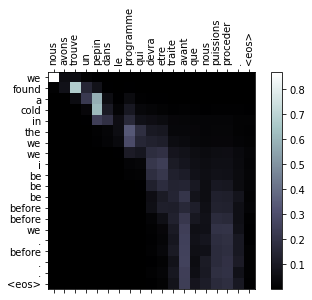

Input:['sa', 'maison', 'de', 'campagne', 'est', 'sur', 'la', 'cote', '.', '<eos>']
Label:['<sos>', 'his', 'cottage', 'is', 'on', 'the', 'coast', '.', '<eos>']
Output:['his', 'house', 'is', 'in', 'the', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 4800], [train loss 18.9324 +/- 13.3071], [epoch elapsed time 366.15]
--------------------------------------------------------------------


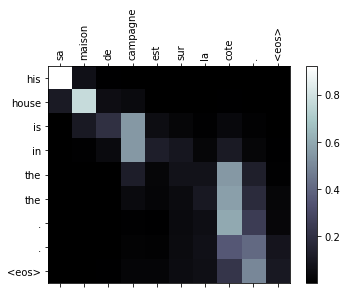

Input:['les', 'tiroirs', 'du', 'classeur', 'sont', 'ouverts', '.', '<eos>']
Label:['<sos>', 'the', 'file', 'cabinet', 'drawers', 'are', 'open', '.', '<eos>']
Output:['the', 'and', 'came', 'are', 'are', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 5100], [train loss 19.0356 +/- 13.3950], [epoch elapsed time 389.44]
--------------------------------------------------------------------


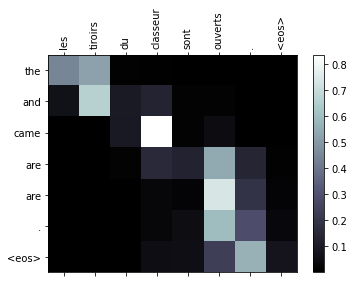

Input:['vous', 'le', 'surestimez', '.', '<eos>']
Label:['<sos>', 'you', 'overestimate', 'him', '.', '<eos>']
Output:['you', 'll', 'it', 'it', 'it', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 5400], [train loss 19.1153 +/- 13.4373], [epoch elapsed time 412.15]
--------------------------------------------------------------------


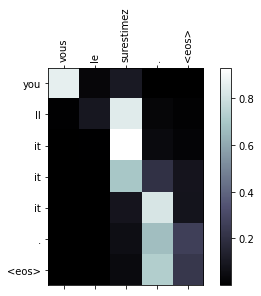

Input:['j', 'ignorais', 'que', 'vous', 'etiez', 'eveille', '.', '<eos>']
Label:['<sos>', 'i', 'did', 'n t', 'know', 'you', 'were', 'awake', '.', '<eos>']
Output:['i', 'was', 'n t', 'know', 'you', 'yesterday', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 5700], [train loss 19.1763 +/- 13.3802], [epoch elapsed time 434.87]
--------------------------------------------------------------------


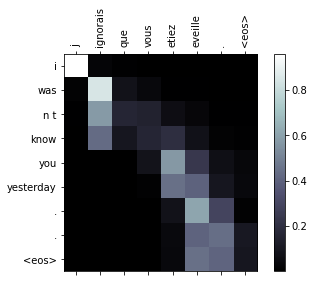

Input:['il', 'a', 'deja', 'dit', 'oui', '.', '<eos>']
Label:['<sos>', 'he', 'has', 'already', 'said', 'yes', '.', '<eos>']
Output:['he', 'has', 'already', 'already', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 6000], [train loss 19.2312 +/- 13.4402], [epoch elapsed time 457.03]
--------------------------------------------------------------------


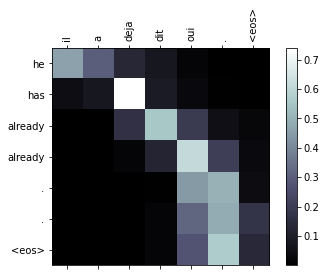

Input:['aimez', 'vous', 'le', 'saumon', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'like', 'salmon', '?', '<eos>']
Output:['do', 'you', 'like', 'it', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 6300], [train loss 19.2958 +/- 13.5215], [epoch elapsed time 479.62]
--------------------------------------------------------------------


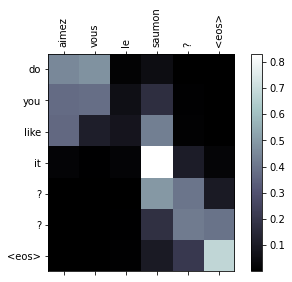

Input:['j', 'ai', 'pense', 'que', 'tu', 'voulais', 'ceci', '.', '<eos>']
Label:['<sos>', 'i', 'thought', 'you', 'wanted', 'this', '.', '<eos>']
Output:['i', 'thought', 'you', 'wanted', 'this', '.', '<eos>']
--------------------------------------------------------------------
[epoch 7 iter 6600], [train loss 19.3553 +/- 13.5140], [epoch elapsed time 502.19]
--------------------------------------------------------------------


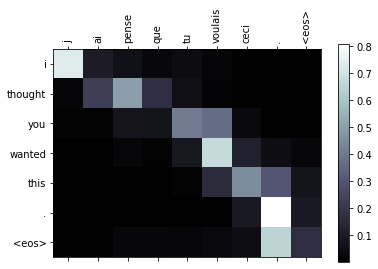

--------------------------------------------------------------------
[epoch 7], [train loss 19.4038 +/- 13.5392], [training time 506.64]
--------------------------------------------------------------------
********************************************************************
Input:['je', 'viens', 'de', 'm', 'en', 'souvenir', '.', '<eos>']
Label:['<sos>', 'i', 'just', 'remembered', '.', '<eos>']
Output:['i', 'come', 'to', '.', '<eos>']


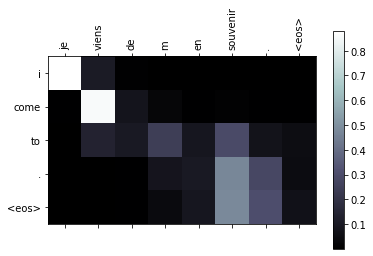

Input:['alors', 'cela', 'vous', 'plait', 'il', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'like', 'it', 'then', '?', '<eos>']
Output:['how', 'would', 'you', 'find', 'it', '?', '<eos>']


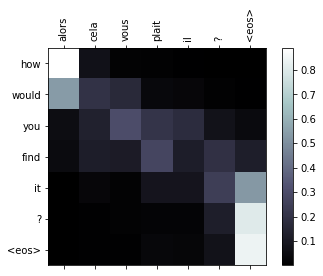

[epoch 7], [test loss 27.9597 +/- 17.1201], [testing time 2.08]
********************************************************************
Input:['nous', 'avons', 'finalement', 'conclu', 'une', 'affaire', '.', '<eos>']
Label:['<sos>', 'we', 'finally', 'struck', 'a', 'bargain', '.', '<eos>']
Output:['we', 'finally', 'got', 'a', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 300], [train loss 17.1942 +/- 11.5881], [epoch elapsed time 22.06]
--------------------------------------------------------------------


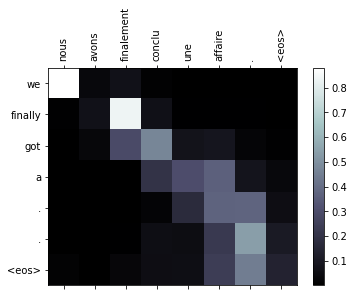

Input:['je', 'dois', 'savoir', 'pourquoi', '.', '<eos>']
Label:['<sos>', 'i', 'have', 'to', 'know', 'why', '.', '<eos>']
Output:['i', 'have', 'to', 'why', 'why', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 600], [train loss 16.7783 +/- 12.1281], [epoch elapsed time 44.72]
--------------------------------------------------------------------


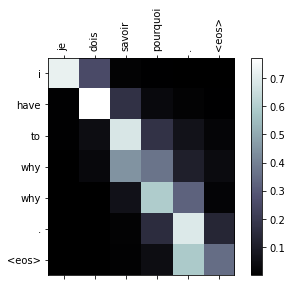

Input:['il', 'prenait', 'plaisir', 'a', 'ces', 'visites', '.', '<eos>']
Label:['<sos>', 'he', 'enjoyed', 'those', 'visits', '.', '<eos>']
Output:['he', 'saw', 'his', 'all', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 900], [train loss 16.6333 +/- 11.8548], [epoch elapsed time 67.06]
--------------------------------------------------------------------


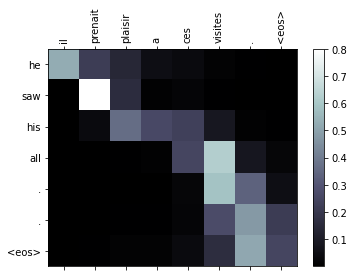

Input:['tu', 'veux', 'que', 'je', 'fasse', 'ton', 'sale', 'boulot', 'pour', 'toi', 'n', 'est', 'ce', 'pas', '?', '<eos>']
Label:['<sos>', 'you', 'want', 'me', 'to', 'do', 'your', 'dirty', 'work', 'for', 'you', 'do', 'n t', 'you', '?', '<eos>']
Output:['you', 'want', 'to', 'to', 'do', 'your', 'your', 'for', 'for', 'you', 'do', 'n t', 'you', '?', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 1200], [train loss 17.0139 +/- 12.0565], [epoch elapsed time 89.77]
--------------------------------------------------------------------


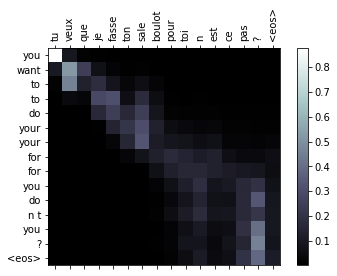

Input:['as', 'tu', 'des', 'difficultes', 'a', 'faire', 'cela', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'having', 'any', 'difficulty', 'doing', 'that', '?', '<eos>']
Output:['are', 'you', 'having', 'any', 'any', 'hard', '?', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 1500], [train loss 16.9586 +/- 11.9728], [epoch elapsed time 111.95]
--------------------------------------------------------------------


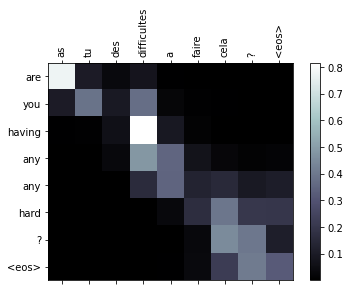

Input:['je', 'te', 'verrai', 'dans', 'le', 'coin', '.', '<eos>']
Label:['<sos>', 'i', 'll', 'see', 'you', 'around', '.', '<eos>']
Output:['i', 'll', 'let', 'you', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 1800], [train loss 17.2934 +/- 12.1434], [epoch elapsed time 134.72]
--------------------------------------------------------------------


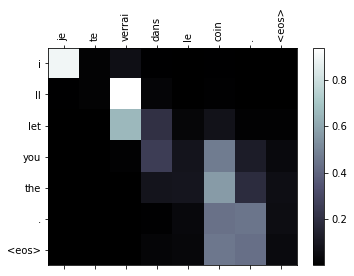

Input:['te', 'sens', 'tu', 'indisposee', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'feeling', 'under', 'the', 'weather', '?', '<eos>']
Output:['are', 'you', 'in', 'in', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 2100], [train loss 17.3386 +/- 12.2881], [epoch elapsed time 157.39]
--------------------------------------------------------------------


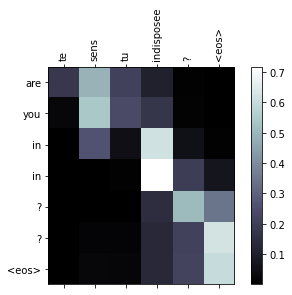

Input:['je', 'pense', 'que', 'nous', 'allons', 'gagner', '.', '<eos>']
Label:['<sos>', 'i', 'think', 'we', 're', 'going', 'to', 'win', '.', '<eos>']
Output:['i', 'think', 'we', 're', 'going', 'going', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 2400], [train loss 17.3641 +/- 12.3344], [epoch elapsed time 179.84]
--------------------------------------------------------------------


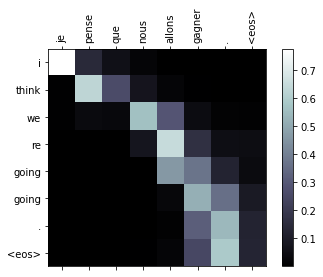

Input:['pourquoi', 'ne', 'pas', 'me', 'l', 'avoir', 'dit', '?', '<eos>']
Label:['<sos>', 'why', 'did', 'n t', 'you', 'tell', 'me', '?', '<eos>']
Output:['why', 'did', 'n t', 'tell', 'me', 'me', '?', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 2700], [train loss 17.5622 +/- 12.4860], [epoch elapsed time 203.06]
--------------------------------------------------------------------


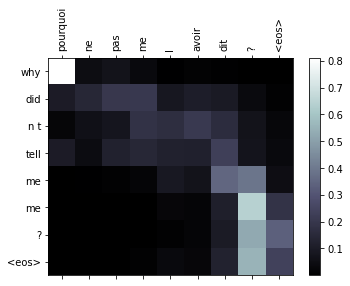

Input:['ne', 'le', 'faites', 'pas', '!', 'c', 'est', 'stupide', 'et', 'dangereux', '.', '<eos>']
Label:['<sos>', 'do', 'n t', 'do', 'it', '!', 'it', 's', 'stupid', 'and', 'dangerous', '.', '<eos>']
Output:['do', 'n t', 'make', 'this', 's', 'this', 'is', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 3000], [train loss 17.6278 +/- 12.6377], [epoch elapsed time 226.12]
--------------------------------------------------------------------


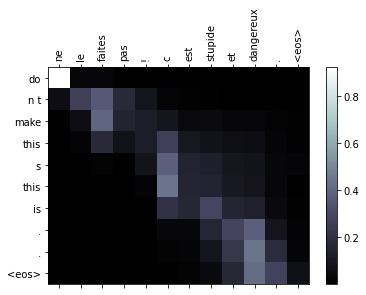

Input:['j', 'oubliai', 'de', 'fermer', 'la', 'porte', 'a', 'cle', '.', '<eos>']
Label:['<sos>', 'i', 'forgot', 'to', 'lock', 'the', 'door', '.', '<eos>']
Output:['i', 'll', 'on', 'the', 'door', 'door', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 3300], [train loss 17.7196 +/- 12.7701], [epoch elapsed time 249.04]
--------------------------------------------------------------------


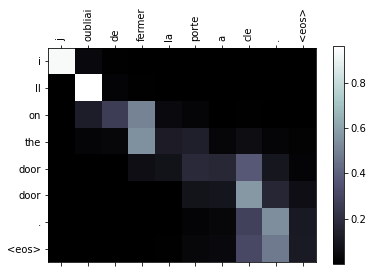

Input:['je', 'suis', 'desole', 'mais', 'je', 'ne', 'peux', 'pas', 'repondre', 'tout', 'de', 'suite', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'sorry', 'but', 'i', 'ca', 'n t', 'answer', 'right', 'away', '.', '<eos>']
Output:['i', 'm', 'sorry', 'but', 'i', 'ca', 'n t', 'answer', 'all', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 3600], [train loss 17.9024 +/- 13.0285], [epoch elapsed time 272.25]
--------------------------------------------------------------------


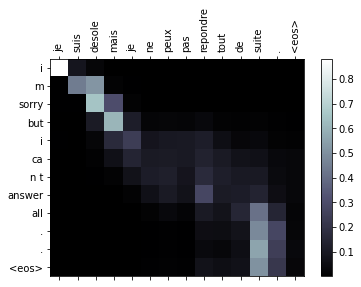

Input:['je', 'me', 'suis', 'vraiment', 'depechee', '.', '<eos>']
Label:['<sos>', 'i', 'really', 'hurried', '.', '<eos>']
Output:['i', 'really', 'really', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 3900], [train loss 17.9820 +/- 13.1341], [epoch elapsed time 295.17]
--------------------------------------------------------------------


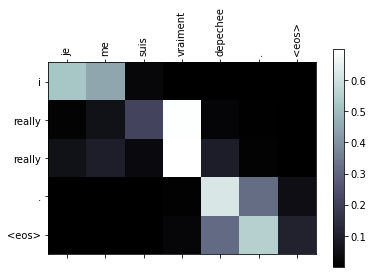

Input:['elles', 'sont', 'la', 'pour', 'moi', '.', '<eos>']
Label:['<sos>', 'they', 're', 'here', 'for', 'me', '.', '<eos>']
Output:['they', 'are', 'the', 'for', 'me', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 4200], [train loss 17.9828 +/- 13.1059], [epoch elapsed time 318.10]
--------------------------------------------------------------------


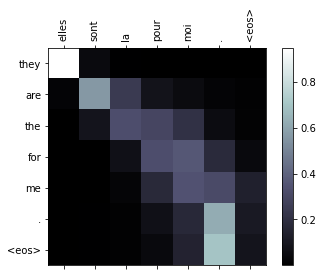

Input:['elle', 'a', 'gare', 'sa', 'voiture', 'sur', 'une', 'place', 'libre', '.', '<eos>']
Label:['<sos>', 'she', 'parked', 'her', 'car', 'in', 'a', 'vacant', 'lot', '.', '<eos>']
Output:['she', 'told', 'her', 'car', 'in', 'a', 'while', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 4500], [train loss 18.0893 +/- 13.1472], [epoch elapsed time 341.44]
--------------------------------------------------------------------


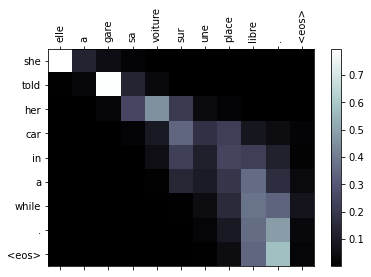

Input:['je', 'suis', 'content', 'que', 'tom', 'soit', 'la', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'glad', 'that', 'tom', 'is', 'here', '.', '<eos>']
Output:['i', 'm', 'glad', 'tom', 'tom', 'is', 'here', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 4800], [train loss 18.0429 +/- 13.1143], [epoch elapsed time 363.98]
--------------------------------------------------------------------


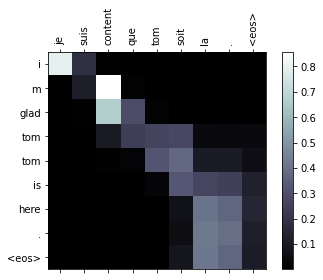

Input:['un', 'gros', 'homme', 'n', 'a', 'jamais', 'une', 'tres', 'forte', 'ou', 'tres', 'longue', 'aversion', 'envers', 'qui', 'que', 'ce', 'soit', '.', '<eos>']
Label:['<sos>', 'a', 'fat', 'man', 'seldom', 'dislikes', 'anybody', 'very', 'hard', 'or', 'for', 'very', 'long', '.', '<eos>']
Output:['a', 'great', 'man', 'has', 'a', 'a', 'fish', 'is', 'very', 'a', 'a', 'a', 'a', 'a', 'a', 'a', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 5100], [train loss 18.1725 +/- 13.2671], [epoch elapsed time 386.42]
--------------------------------------------------------------------


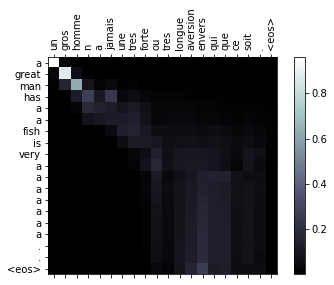

Input:['n', 'etes', 'vous', 'toujours', 'pas', 'convaincues', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'still', 'not', 'convinced', '?', '<eos>']
Output:['are', 'you', 'still', 'still', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 5400], [train loss 18.2810 +/- 13.3132], [epoch elapsed time 409.47]
--------------------------------------------------------------------


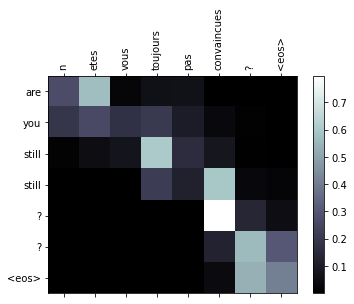

Input:['je', 'pense', 'qu', 'il', 'est', 'temps', 'que', 'je', 'me', 'fasse', 'de', 'nouveaux', 'amis', '.', '<eos>']
Label:['<sos>', 'i', 'think', 'it', 's', 'time', 'for', 'me', 'to', 'make', 'some', 'new', 'friends', '.', '<eos>']
Output:['i', 'think', 'it', 'time', 'time', 'for', 'me', 'to', 'me', 'with', 'many', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 5700], [train loss 18.3413 +/- 13.2688], [epoch elapsed time 432.02]
--------------------------------------------------------------------


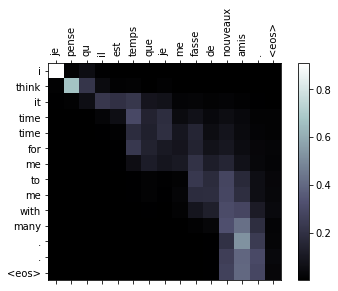

Input:['l', 'accident', 'le', 'priva', 'de', 'la', 'vue', '.', '<eos>']
Label:['<sos>', 'the', 'accident', 'deprived', 'him', 'of', 'his', 'sight', '.', '<eos>']
Output:['the', 'accident', 'is', 'the', 'to', 'her', 'face', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 6000], [train loss 18.4542 +/- 13.3254], [epoch elapsed time 454.91]
--------------------------------------------------------------------


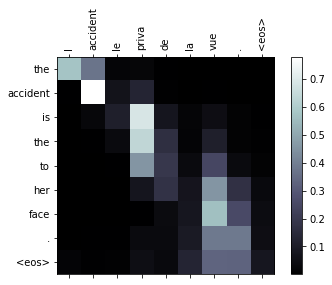

Input:['peut', 'etre', 'qu', 'elle', 'ne', 'viendra', 'pas', '.', '<eos>']
Label:['<sos>', 'maybe', 'she', 'wo', 'n t', 'come', '.', '<eos>']
Output:['maybe', 'she', 'did', 'n t', 'come', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 6300], [train loss 18.5289 +/- 13.3530], [epoch elapsed time 477.71]
--------------------------------------------------------------------


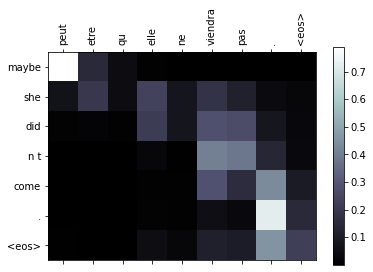

Input:['c', 'est', 'tellement', 'idiot', '!', '<eos>']
Label:['<sos>', 'this', 'is', 'so', 'stupid', '.', '<eos>']
Output:['it', 's', 'so', 'stupid', '.', '<eos>']
--------------------------------------------------------------------
[epoch 8 iter 6600], [train loss 18.6091 +/- 13.3534], [epoch elapsed time 500.18]
--------------------------------------------------------------------


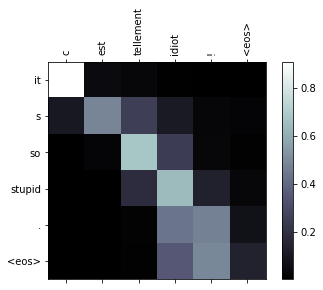

--------------------------------------------------------------------
[epoch 8], [train loss 18.6145 +/- 13.3449], [training time 504.45]
--------------------------------------------------------------------
********************************************************************
Input:['tu', 'devrais', 't', 'assurer', 'que', 'tu', 'as', 'assez', 'd', 'argent', 'en', 'poche', 'pour', 'payer', 'le', 'billet', '.', '<eos>']
Label:['<sos>', 'you', 'should', 'make', 'sure', 'that', 'you', 'have', 'enough', 'money', 'in', 'your', 'pocket', 'to', 'pay', 'for', 'the', 'ticket', '.', '<eos>']
Output:['you', 'should', 'have', 'have', 'you', 'have', 'have', 'have', 'a', 'time', 'for', 'you', 'have', 'a', 'a', '.', '<eos>']


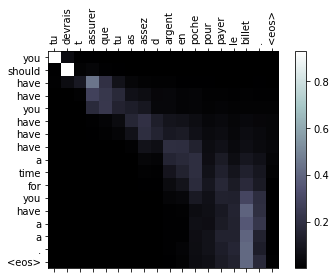

Input:['lorsque', 'je', 'me', 'trouve', 'avec', 'toi', 'je', 'suis', 'heureux', '.', '<eos>']
Label:['<sos>', 'when', 'i', 'm', 'with', 'you', 'i', 'm', 'happy', '.', '<eos>']
Output:['when', 'i', 'i', 'love', 'you', '.', '.', '<eos>']


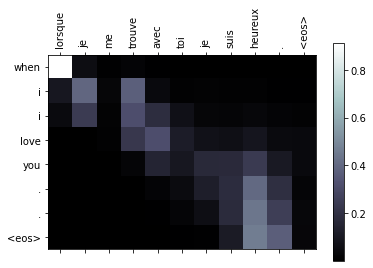

[epoch 8], [test loss 28.4031 +/- 17.4989], [testing time 2.66]
********************************************************************
Input:['il', 's', 'est', 'blesse', 'au', 'pied', 'gauche', 'lorsqu', 'il', 'est', 'tombe', '.', '<eos>']
Label:['<sos>', 'he', 'hurt', 'his', 'left', 'foot', 'when', 'he', 'fell', '.', '<eos>']
Output:['he', 'has', 'his', 'left', 'left', 'when', 'when', 'he', 'fell', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 300], [train loss 16.5971 +/- 11.8914], [epoch elapsed time 22.27]
--------------------------------------------------------------------


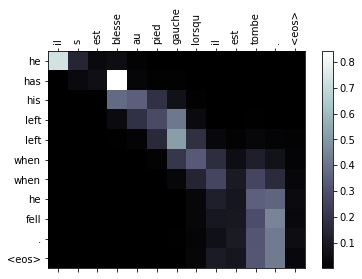

Input:['es', 'tu', 'sure', 'de', 'ne', 'pas', 'etre', 'fatiguee', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'sure', 'you', 're', 'not', 'tired', '?', '<eos>']
Output:['are', 'you', 'sure', 'you', 'do', 'n t', 'tired', '?', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 600], [train loss 16.1706 +/- 11.9905], [epoch elapsed time 44.88]
--------------------------------------------------------------------


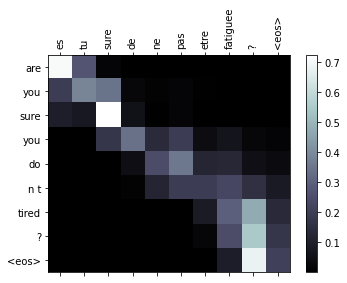

Input:['ouf', '!', 'il', 'etait', 'grand', 'temps', '!', '<eos>']
Label:['<sos>', 'phew', '!', 'that', 'was', 'close', '!', '<eos>']
Output:['please', '!', 'it', 'was', 'a', '!', '!', '!', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 900], [train loss 15.8022 +/- 11.6625], [epoch elapsed time 67.00]
--------------------------------------------------------------------


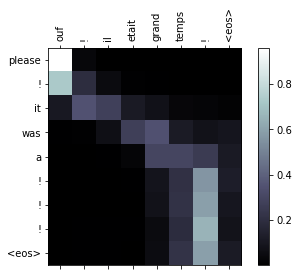

Input:['je', 'm', 'en', 'suis', 'debarrasse', '.', '<eos>']
Label:['<sos>', 'i', 'got', 'rid', 'of', 'it', '.', '<eos>']
Output:['i', 'm', 'sure', 'of', 'this', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 1200], [train loss 15.7895 +/- 11.7508], [epoch elapsed time 90.00]
--------------------------------------------------------------------


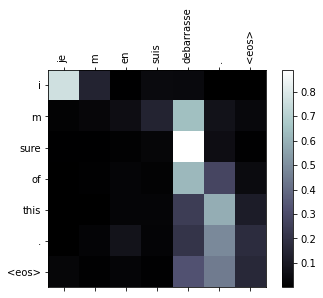

Input:['tu', 'ne', 'devrais', 'pas', 'dire', 'une', 'telle', 'chose', 'lorsque', 'les', 'enfants', 'sont', 'dans', 'les', 'parages', '.', '<eos>']
Label:['<sos>', 'you', 'should', 'n t', 'say', 'that', 'kind', 'of', 'thing', 'when', 'children', 'are', 'around', '.', '<eos>']
Output:['you', 'should', 'n t', 'tell', 'a', 'such', 'of', 'the', 'in', 'the', 'are', 'in', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 1500], [train loss 15.8939 +/- 11.7470], [epoch elapsed time 112.70]
--------------------------------------------------------------------


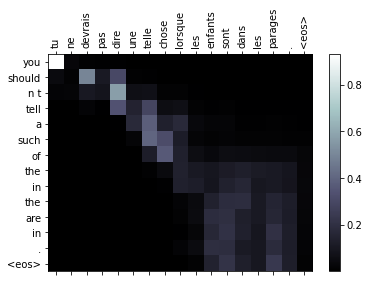

Input:['ce', 'jour', 'entrera', 'dans', 'l', 'histoire', '.', '<eos>']
Label:['<sos>', 'this', 'day', 'will', 'go', 'down', 'in', 'history', '.', '<eos>']
Output:['this', 'day', 'will', 'be', 'in', 'in', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 1800], [train loss 16.0153 +/- 11.7725], [epoch elapsed time 135.60]
--------------------------------------------------------------------


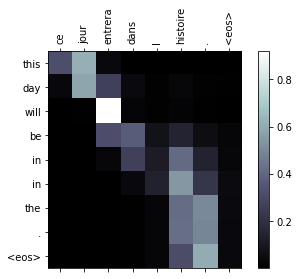

Input:['ma', 'mere', 'aime', 'beaucoup', 'les', 'tulipes', 'et', 'ma', 'soeur', 'aussi', '.', '<eos>']
Label:['<sos>', 'my', 'mother', 'likes', 'tulips', 'very', 'much', 'and', 'so', 'does', 'my', 'sister', '.', '<eos>']
Output:['my', 'mother', 'likes', 'very', 'very', 'much', 'with', 'father', '.', '.', 'sister', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 2100], [train loss 16.2725 +/- 12.0102], [epoch elapsed time 158.50]
--------------------------------------------------------------------


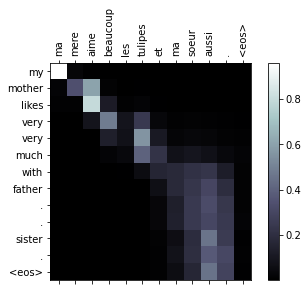

Input:['ou', 'avez', 'vous', 'appris', 'a', 'tirer', '?', '<eos>']
Label:['<sos>', 'where', 'did', 'you', 'learn', 'to', 'shoot', '?', '<eos>']
Output:['where', 'did', 'you', 'learn', 'to', 'give', '?', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 2400], [train loss 16.3318 +/- 12.0236], [epoch elapsed time 181.02]
--------------------------------------------------------------------


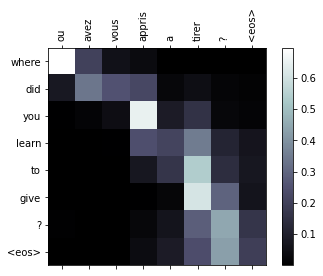

Input:['il', 'se', 'serra', 'la', 'ceinture', 'pendant', 'de', 'nombreuses', 'annees', 'afin', 'd', 'economiser', 'de', 'l', 'argent', '.', '<eos>']
Label:['<sos>', 'he', 'pinched', 'and', 'scraped', 'for', 'many', 'years', 'to', 'save', 'money', '.', '<eos>']
Output:['he', 'seldom', 'the', 'money', 'for', 'a', 'money', 'to', 'money', 'money', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 2700], [train loss 16.3352 +/- 12.0123], [epoch elapsed time 203.49]
--------------------------------------------------------------------


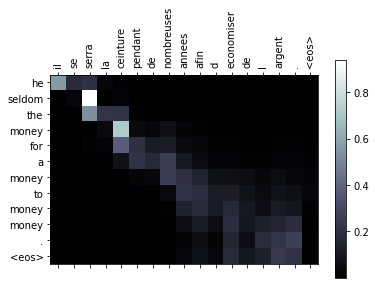

Input:['vous', 'n', 'avez', 'pas', 'idee', 'de', 'la', 'detresse', 'dans', 'laquelle', 'elle', 'etait', '.', '<eos>']
Label:['<sos>', 'you', 'have', 'no', 'idea', 'how', 'distressed', 'she', 'was', '.', '<eos>']
Output:['you', 'have', 'n t', 'idea', 'of', 'the', 'was', 'was', 'was', '.']
--------------------------------------------------------------------
[epoch 9 iter 3000], [train loss 16.4635 +/- 12.0683], [epoch elapsed time 226.86]
--------------------------------------------------------------------


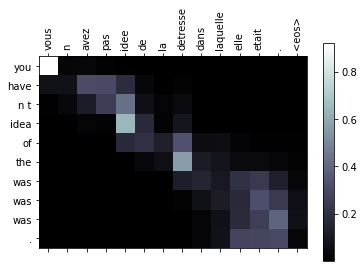

Input:['pourquoi', 'ne', 'passons', 'nous', 'pas', 'la', 'voir', '?', '<eos>']
Label:['<sos>', 'why', 'do', 'n t', 'we', 'drop', 'by', 'to', 'see', 'her', '?', '<eos>']
Output:['why', 'do', 'n t', 'we', 'take', 'to', 'see', 'a', 'party', '?', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 3300], [train loss 16.7800 +/- 12.1946], [epoch elapsed time 251.17]
--------------------------------------------------------------------


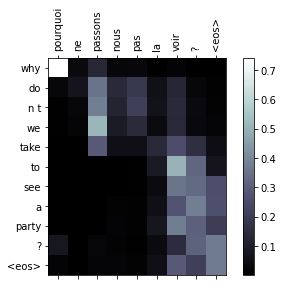

Input:['garde', 'toujours', 'ton', 'espace', 'de', 'travail', 'en', 'ordre', '.', '<eos>']
Label:['<sos>', 'always', 'keep', 'your', 'workplace', 'organized', '.', '<eos>']
Output:['always', 'take', 'your', 'easy', 'to', 'work', 'job', 'in', 'a', 'job', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 3600], [train loss 16.8825 +/- 12.2871], [epoch elapsed time 276.38]
--------------------------------------------------------------------


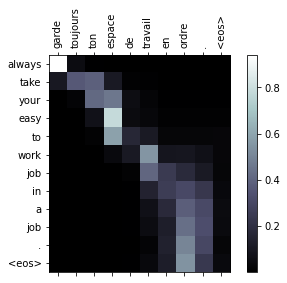

Input:['avez', 'vous', 'regarde', 'la', 'television', 'la', 'nuit', 'derniere', '?', '<eos>']
Label:['<sos>', 'did', 'you', 'watch', 'tv', 'last', 'night', '?', '<eos>']
Output:['have', 'you', 'look', 'the', 'last', 'last', '?', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 3900], [train loss 17.1036 +/- 12.4690], [epoch elapsed time 299.53]
--------------------------------------------------------------------


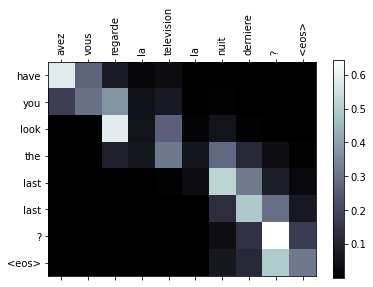

Input:['je', 'commence', 'a', 'me', 'sentir', 'desesperee', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'starting', 'to', 'feel', 'desperate', '.', '<eos>']
Output:['i', 'm', 'happy', 'to', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 4200], [train loss 17.2003 +/- 12.5328], [epoch elapsed time 322.55]
--------------------------------------------------------------------


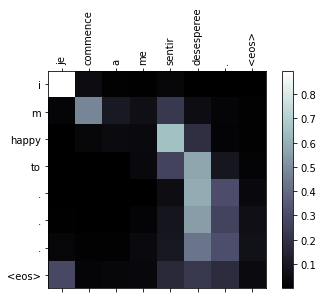

Input:['je', 'veux', 'vraiment', 't', 'embrasser', '.', '<eos>']
Label:['<sos>', 'i', 'really', 'want', 'to', 'kiss', 'you', '.', '<eos>']
Output:['i', 'really', 'want', 'to', 'see', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 4500], [train loss 17.2587 +/- 12.5800], [epoch elapsed time 345.53]
--------------------------------------------------------------------


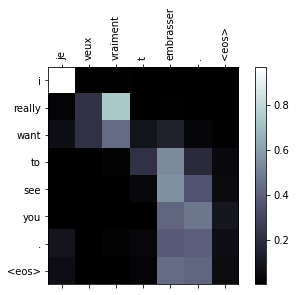

Input:['n', 'avais', 'tu', 'pas', 'verrouille', 'ta', 'voiture', '?', '<eos>']
Label:['<sos>', 'did', 'n t', 'you', 'lock', 'up', 'your', 'car', '?', '<eos>']
Output:['did', 'n t', 'you', 'write', 'your', 'car', '?', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 4800], [train loss 17.3070 +/- 12.7153], [epoch elapsed time 368.39]
--------------------------------------------------------------------


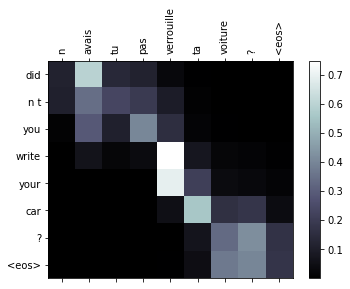

Input:['s', 'il', 'vous', 'plait', 'envoyez', 'moi', 'une', 'reponse', 'des', 'que', 'vous', 'recevrez', 'ce', 'courrier', '.', '<eos>']
Label:['<sos>', 'please', 'send', 'me', 'a', 'reply', 'as', 'soon', 'as', 'you', 'receive', 'this', 'mail', '.', '<eos>']
Output:['please', 'close', 'me', 'a', 'a', 'way', 'what', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 5100], [train loss 17.4747 +/- 12.8524], [epoch elapsed time 391.80]
--------------------------------------------------------------------


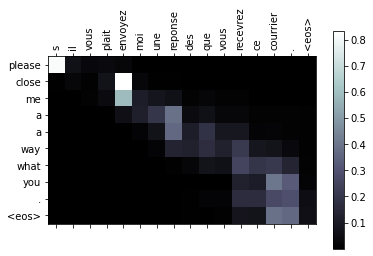

Input:['maintenant', 'il', 'est', 'temps', 'd', 'agir', '.', '<eos>']
Label:['<sos>', 'now', 'is', 'the', 'time', 'for', 'action', '.', '<eos>']
Output:['now', 'is', 'time', 'time', 'to', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 5400], [train loss 17.4527 +/- 12.8007], [epoch elapsed time 414.35]
--------------------------------------------------------------------


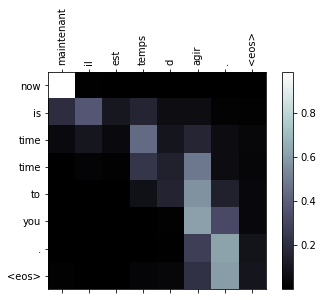

Input:['c', 'est', 'moi', 'qui', 'me', 'suis', 'rendu', 'la', 'bas', 'hier', '.', '<eos>']
Label:['<sos>', 'it', 's', 'me', 'that', 'went', 'there', 'yesterday', '.', '<eos>']
Output:['it', 's', 'me', 'for', 'that', 'i', 'was', 'yesterday', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 5700], [train loss 17.4920 +/- 12.8357], [epoch elapsed time 437.94]
--------------------------------------------------------------------


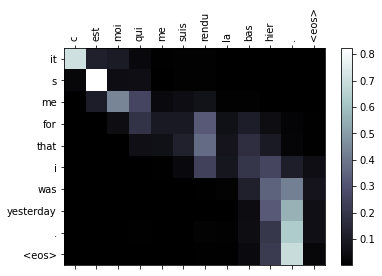

Input:['lorsque', 'tu', 'navigues', 'sur', 'la', 'toile', 'il', 'se', 'peut', 'que', 'tu', 'sois', 'piste', 'par', 'des', 'sites', '.', '<eos>']
Label:['<sos>', 'when', 'you', 'surf', 'the', 'web', 'you', 'may', 'be', 'tracked', 'by', 'websites', '.', '<eos>']
Output:['when', 'you', 'sure', 'the', 'you', 'you', 'came', 'be', 'in', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 6000], [train loss 17.6231 +/- 12.8976], [epoch elapsed time 461.30]
--------------------------------------------------------------------


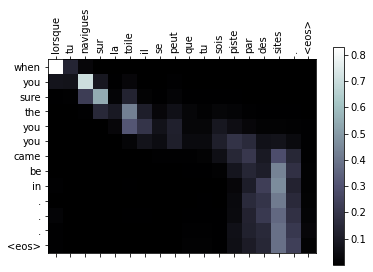

Input:['je', 'prefererais', 'vraiment', 'etre', 'seule', 'a', 'l', 'instant', '.', '<eos>']
Label:['<sos>', 'i', 'really', 'would', 'rather', 'be', 'alone', 'right', 'now', '.', '<eos>']
Output:['i', 'just', 'only', 'really', 'be', 'to', 'right', 'right', '.', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 6300], [train loss 17.6656 +/- 12.9226], [epoch elapsed time 483.85]
--------------------------------------------------------------------


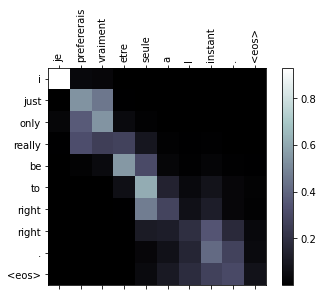

Input:['pourquoi', 'tom', 'n', 'etait', 'il', 'pas', 'la', '?', '<eos>']
Label:['<sos>', 'why', 'was', 'n t', 'tom', 'there', '?', '<eos>']
Output:['why', 'did', 'tom', 'did', 'did', '?', '<eos>']
--------------------------------------------------------------------
[epoch 9 iter 6600], [train loss 17.6874 +/- 12.9218], [epoch elapsed time 506.21]
--------------------------------------------------------------------


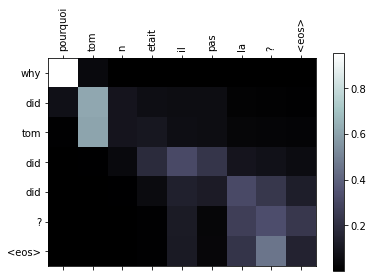

--------------------------------------------------------------------
[epoch 9], [train loss 17.6679 +/- 12.8981], [training time 510.42]
--------------------------------------------------------------------
********************************************************************
Input:['j', 'ai', 'besoin', 'de', 'm', 'exercer', '.', '<eos>']
Label:['<sos>', 'i', 'have', 'to', 'exercise', '.', '<eos>']
Output:['i', 'need', 'to', 'help', 'me', '.', '<eos>']


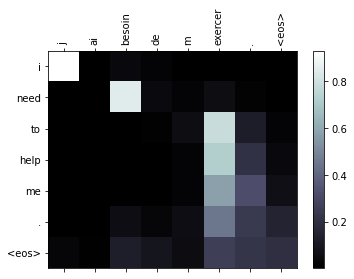

Input:['je', 'viens', 'de', 'm', 'en', 'souvenir', '.', '<eos>']
Label:['<sos>', 'i', 'just', 'remembered', '.', '<eos>']
Output:['i', 'just', 'just', '.', '<eos>']


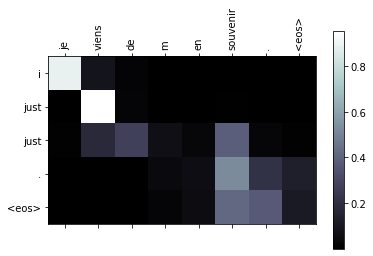

[epoch 9], [test loss 27.4315 +/- 15.7527], [testing time 2.06]
********************************************************************
Input:['joues', 'tu', 'dans', 'un', 'groupe', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'play', 'in', 'a', 'band', '?', '<eos>']
Output:['do', 'you', 'playing', 'in', 'a', 'bit', '?', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 300], [train loss 14.5254 +/- 10.3788], [epoch elapsed time 22.10]
--------------------------------------------------------------------


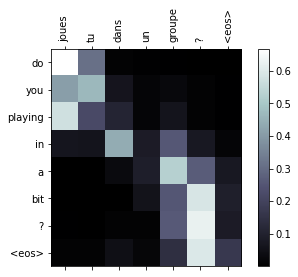

Input:['seul', 'toi', 'peut', 'repondre', 'a', 'cette', 'question', '.', '<eos>']
Label:['<sos>', 'only', 'you', 'can', 'answer', 'the', 'question', '.', '<eos>']
Output:['please', 'can', 'can', 'see', 'the', 'question', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 600], [train loss 14.7245 +/- 10.7832], [epoch elapsed time 44.66]
--------------------------------------------------------------------


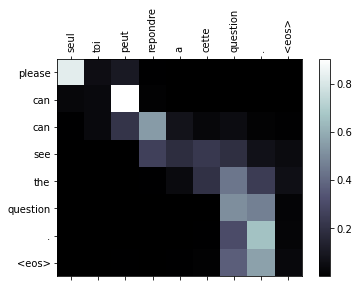

Input:['tout', 'le', 'monde', 'etait', 'inquiet', '.', '<eos>']
Label:['<sos>', 'everyone', 'was', 'apprehensive', '.', '<eos>']
Output:['everybody', 'was', 'first', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 900], [train loss 15.3706 +/- 11.4997], [epoch elapsed time 67.39]
--------------------------------------------------------------------


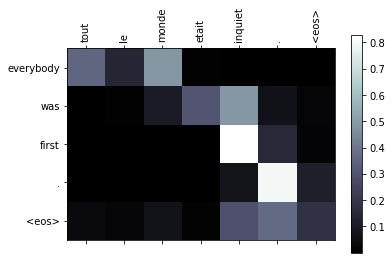

Input:['il', 'n', 'est', 'pas', 'disponible', '.', '<eos>']
Label:['<sos>', 'he', 'is', 'not', 'available', '.', '<eos>']
Output:['he', 'is', 'not', 'now', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 1200], [train loss 15.4457 +/- 11.4617], [epoch elapsed time 89.96]
--------------------------------------------------------------------


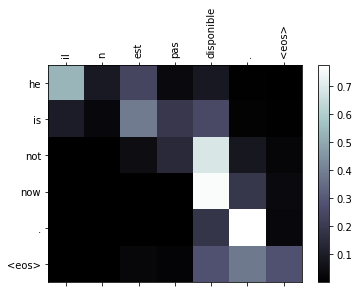

Input:['j', 'admire', 'ta', 'perseverance', 'et', 'ta', 'determination', '.', '<eos>']
Label:['<sos>', 'i', 'admire', 'your', 'perseverance', 'and', 'determination', '.', '<eos>']
Output:['i', 'm', 'your', 'your', 'best', 'and', 'your', 'keys', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 1500], [train loss 15.2684 +/- 11.6326], [epoch elapsed time 112.85]
--------------------------------------------------------------------


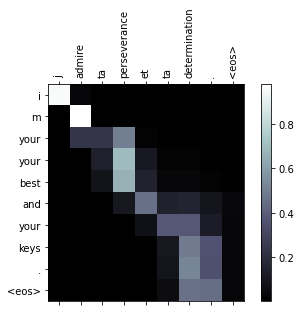

Input:['il', 'est', 'marie', 'a', 'une', 'americaine', '.', '<eos>']
Label:['<sos>', 'he', 'is', 'married', 'to', 'an', 'american', 'lady', '.', '<eos>']
Output:['he', 's', 'married', 'to', 'an', 'an', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 1800], [train loss 15.3914 +/- 11.7458], [epoch elapsed time 135.57]
--------------------------------------------------------------------


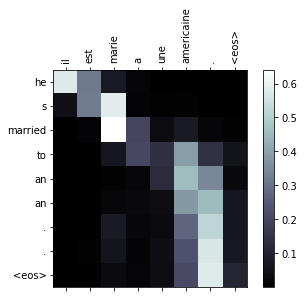

Input:['vous', 'etes', 'bonnes', '.', '<eos>']
Label:['<sos>', 'you', 're', 'good', '.', '<eos>']
Output:['you', 're', 'good', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 2100], [train loss 15.5246 +/- 11.8981], [epoch elapsed time 158.58]
--------------------------------------------------------------------


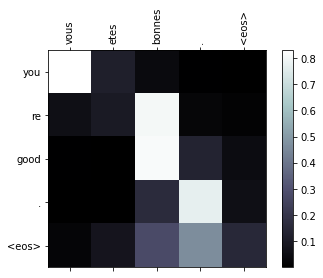

Input:['tom', 'ne', 'sait', 'pas', 'quelle', 'couleur', 'choisir', '.', '<eos>']
Label:['<sos>', 'tom', 'does', 'n t', 'know', 'which', 'color', 'to', 'choose', '.', '<eos>']
Output:['tom', 'ca', 'n t', 'just', 'which', 'up', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 2400], [train loss 15.7447 +/- 12.1493], [epoch elapsed time 181.94]
--------------------------------------------------------------------


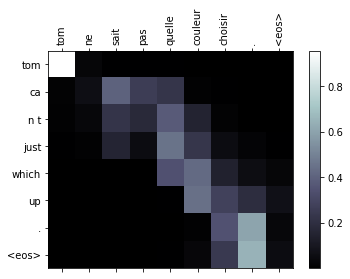

Input:['je', 'sais', 'que', 'vous', 'avez', 'ete', 'occupe', '.', '<eos>']
Label:['<sos>', 'i', 'know', 'you', 've', 'been', 'busy', '.', '<eos>']
Output:['i', 'know', 'you', 've', 'been', 'busy', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 2700], [train loss 15.8996 +/- 12.2918], [epoch elapsed time 204.89]
--------------------------------------------------------------------


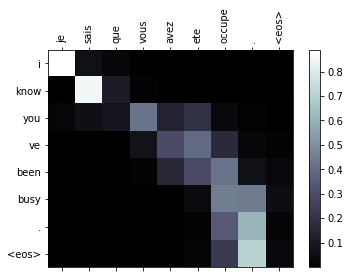

Input:['que', 'peux', 'tu', 'voir', '?', '<eos>']
Label:['<sos>', 'what', 'can', 'you', 'see', '?', '<eos>']
Output:['what', 'can', 'you', 'see', 'see', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 3000], [train loss 15.9676 +/- 12.2631], [epoch elapsed time 227.63]
--------------------------------------------------------------------


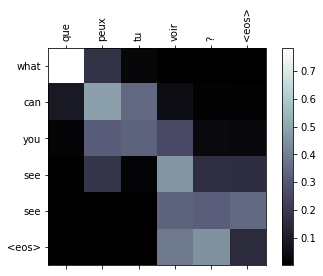

Input:['il', 'm', 'a', 'demande', 'si', 'je', 'l', 'avais', 'trouve', '.', '<eos>']
Label:['<sos>', 'he', 'asked', 'me', 'if', 'i', 'had', 'found', 'it', '.', '<eos>']
Output:['i', 'asked', 'me', 'if', 'i', 'had', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 3300], [train loss 16.0877 +/- 12.2503], [epoch elapsed time 250.43]
--------------------------------------------------------------------


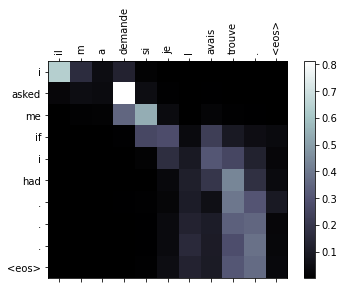

Input:['je', 'suis', 'raisonnable', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'not', 'being', 'unreasonable', '.', '<eos>']
Output:['i', 'm', 'not', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 3600], [train loss 16.2578 +/- 12.3232], [epoch elapsed time 273.93]
--------------------------------------------------------------------


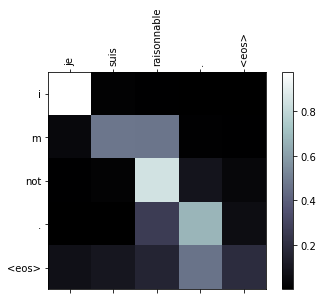

Input:['ne', 'me', 'lache', 'pas', 'encore', 'une', 'fois', '!', '<eos>']
Label:['<sos>', 'do', 'n t', 'disappear', 'on', 'me', 'again', '.', '<eos>']
Output:['do', 'n t', 'n t', 'like', 'me', 'any', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 3900], [train loss 16.3000 +/- 12.4109], [epoch elapsed time 297.32]
--------------------------------------------------------------------


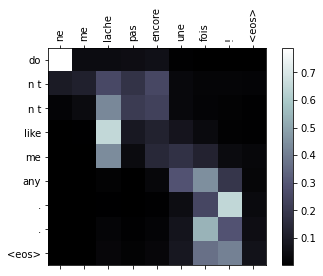

Input:['je', 'suis', 'juste', 'en', 'train', 'de', 'regarder', 'la', 'tele', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'just', 'watching', 'television', '.', '<eos>']
Output:['i', 'm', 'just', 'watching', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 4200], [train loss 16.3600 +/- 12.4335], [epoch elapsed time 320.15]
--------------------------------------------------------------------


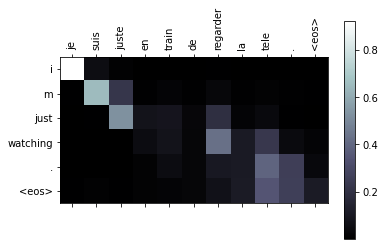

Input:['je', 'ne', 'suis', 'pas', 'anglais', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'not', 'english', '.', '<eos>']
Output:['i', 'am', 'not', 'english', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 4500], [train loss 16.5208 +/- 12.4168], [epoch elapsed time 343.44]
--------------------------------------------------------------------


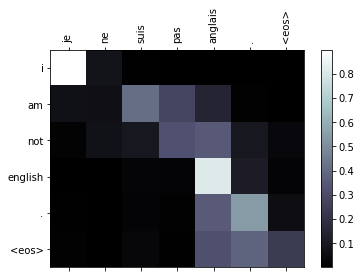

Input:['je', 'suis', 'restee', '.', '<eos>']
Label:['<sos>', 'i', 'stayed', '.', '<eos>']
Output:['i', 'came', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 4800], [train loss 16.5891 +/- 12.4702], [epoch elapsed time 366.07]
--------------------------------------------------------------------


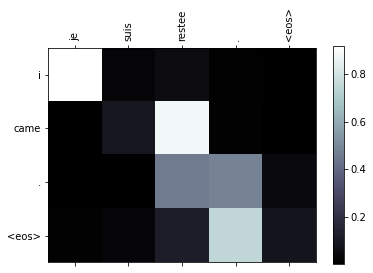

Input:['tu', 'm', 'ennuies', '.', '<eos>']
Label:['<sos>', 'you', 're', 'annoying', '.', '<eos>']
Output:['you', 're', 'me', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 5100], [train loss 16.6476 +/- 12.5819], [epoch elapsed time 388.65]
--------------------------------------------------------------------


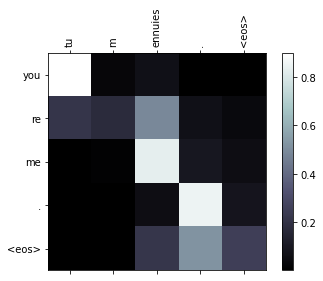

Input:['j', 'ai', 'songe', 'que', 'vous', 'voudriez', 'savoir', '.', '<eos>']
Label:['<sos>', 'i', 'figured', 'you', 'd', 'want', 'to', 'know', '.', '<eos>']
Output:['i', 'm', 'what', 'you', 'd', 'want', 'to', 'know', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 5400], [train loss 16.8124 +/- 12.6467], [epoch elapsed time 411.51]
--------------------------------------------------------------------


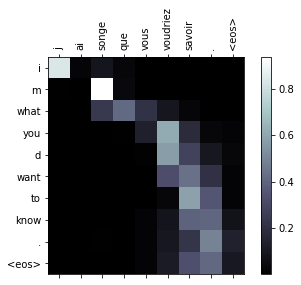

Input:['il', 'ne', 'sait', 'meme', 'pas', 'comment', 'signer', 'de', 'son', 'nom', '.', '<eos>']
Label:['<sos>', 'he', 'does', 'not', 'even', 'know', 'how', 'to', 'sign', 'his', 'name', '.', '<eos>']
Output:['he', 'does', 'n t', 'even', 'know', 'how', 'he', 's', 'his', 'his', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 5700], [train loss 16.9356 +/- 12.6884], [epoch elapsed time 434.50]
--------------------------------------------------------------------


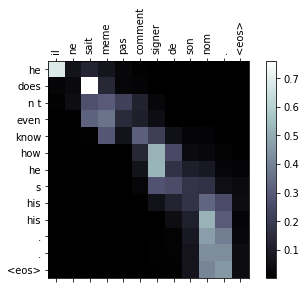

Input:['tu', 'ne', 'devrais', 'pas', 'dire', 'une', 'telle', 'chose', 'lorsque', 'les', 'enfants', 'sont', 'dans', 'les', 'parages', '.', '<eos>']
Label:['<sos>', 'you', 'should', 'n t', 'say', 'that', 'kind', 'of', 'thing', 'when', 'children', 'are', 'around', '.', '<eos>']
Output:['you', 'should', 'n t', 'tell', 'a', 'a', 'for', 'when', 'you', 'are', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 6000], [train loss 16.9962 +/- 12.7590], [epoch elapsed time 458.11]
--------------------------------------------------------------------


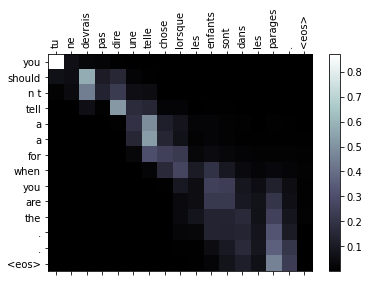

Input:['elle', 'a', 'un', 'cottage', 'en', 'bord', 'de', 'mer', '.', '<eos>']
Label:['<sos>', 'she', 'has', 'a', 'cottage', 'by', 'the', 'sea', '.', '<eos>']
Output:['she', 'has', 'a', 'a', 'in', 'the', 'sea', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 6300], [train loss 17.0539 +/- 12.7703], [epoch elapsed time 481.32]
--------------------------------------------------------------------


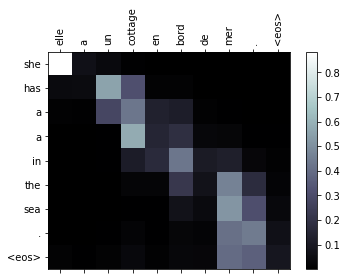

Input:['je', 'veux', 'faire', 'comme', 'si', 'ca', 'n', 'etait', 'jamais', 'arrive', '.', '<eos>']
Label:['<sos>', 'i', 'want', 'to', 'pretend', 'it', 'never', 'happened', '.', '<eos>']
Output:['i', 'want', 'to', 'to', 'if', 'was', 'was', '.', '<eos>']
--------------------------------------------------------------------
[epoch 10 iter 6600], [train loss 17.1123 +/- 12.7437], [epoch elapsed time 503.21]
--------------------------------------------------------------------


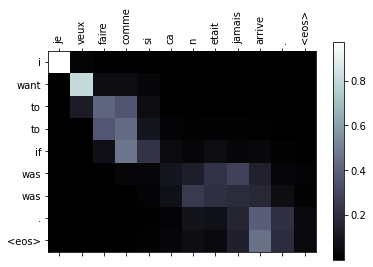

--------------------------------------------------------------------
[epoch 10], [train loss 17.1258 +/- 12.7552], [training time 507.60]
--------------------------------------------------------------------
********************************************************************
Input:['rien', 'ne', 'semblait', 'fonctionner', '.', '<eos>']
Label:['<sos>', 'nothing', 'seemed', 'to', 'work', '.', '<eos>']
Output:['nothing', 'll', 'be', '.', '.', '<eos>']


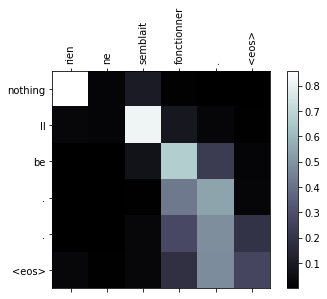

Input:['qui', 'y', 'avez', 'vous', 'rencontre', '?', '<eos>']
Label:['<sos>', 'who', 'did', 'you', 'meet', 'there', '?', '<eos>']
Output:['who', 's', 'you', 'called', '?', '<eos>']


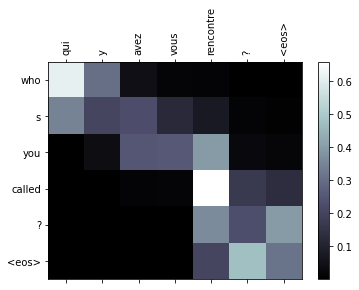

[epoch 10], [test loss 28.4405 +/- 19.0192], [testing time 2.14]
********************************************************************
Input:['ils', 'refusent', 'de', 'me', 'laisser', 'faire', 'ce', 'pour', 'quoi', 'je', 'suis', 'payee', '.', '<eos>']
Label:['<sos>', 'they', 'wo', 'n t', 'allow', 'me', 'to', 'do', 'what', 'i', 'm', 'being', 'paid', 'to', 'do', '.', '<eos>']
Output:['they', 'll', 'n t', 'let', 'to', 'to', 'do', 'what', 'i', 'm', 'being', 'paid', 'what', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 300], [train loss 14.2310 +/- 11.8894], [epoch elapsed time 22.33]
--------------------------------------------------------------------


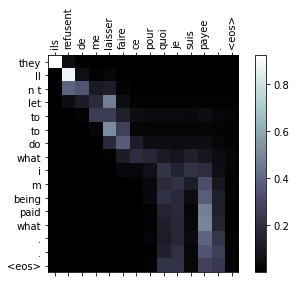

Input:['tom', 'n', 'eut', 'meme', 'pas', 'la', 'politesse', 'de', 'dire', 'qu', 'il', 'etait', 'desole', '.', '<eos>']
Label:['<sos>', 'tom', 'did', 'n t', 'even', 'have', 'the', 'courtesy', 'to', 'say', 'that', 'he', 'was', 'sorry', '.', '<eos>']
Output:['tom', 'did', 'n t', 'even', 'the', 'to', 'say', 'he', 'was', 'sorry', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 600], [train loss 14.3909 +/- 12.3217], [epoch elapsed time 44.79]
--------------------------------------------------------------------


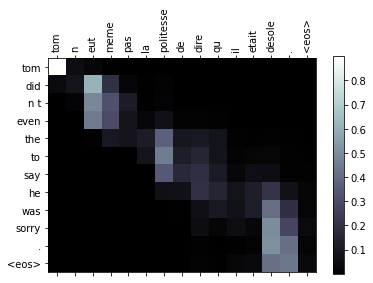

Input:['je', 'ne', 'pense', 'pas', 'que', 'tom', 'soit', 'a', 'boston', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'think', 'tom', 'is', 'in', 'boston', '.', '<eos>']
Output:['i', 'do', 'n t', 'think', 'tom', 'is', 'be', 'boston', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 900], [train loss 15.0438 +/- 12.7482], [epoch elapsed time 68.37]
--------------------------------------------------------------------


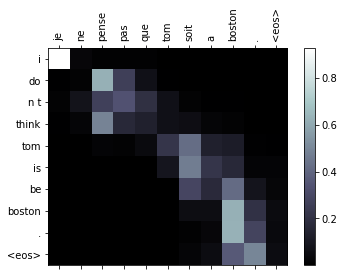

Input:['es', 'tu', 'fatigue', '?', 'non', 'pas', 'du', 'tout', '.', '<eos>']
Label:['<sos>', 'are', 'you', 'tired', '?', 'no', 'not', 'at', 'all', '.', '<eos>']
Output:['are', 'you', 'tired', 'not', 'not', 'not', 'you', '?', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 1200], [train loss 15.0736 +/- 12.5500], [epoch elapsed time 91.16]
--------------------------------------------------------------------


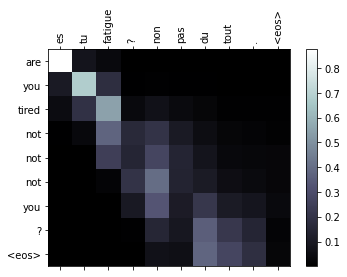

Input:['joues', 'tu', 'dans', 'un', 'groupe', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'play', 'in', 'a', 'band', '?', '<eos>']
Output:['do', 'you', 'play', 'in', 'a', 'band', '?', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 1500], [train loss 15.0934 +/- 12.3686], [epoch elapsed time 113.47]
--------------------------------------------------------------------


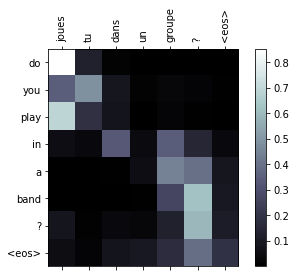

Input:['toutes', 'les', 'regles', 'ont', 'des', 'exceptions', '.', '<eos>']
Label:['<sos>', 'there', 'is', 'an', 'exception', 'to', 'every', 'rule', '.', '<eos>']
Output:['all', 'the', 'students', 'students', 'to', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 1800], [train loss 15.2427 +/- 12.2397], [epoch elapsed time 137.28]
--------------------------------------------------------------------


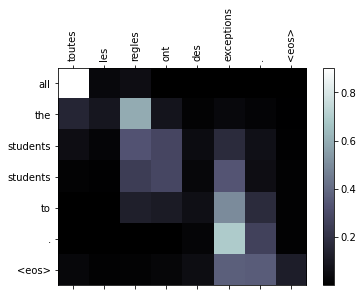

Input:['il', 'est', 'trop', 'sensible', '.', '<eos>']
Label:['<sos>', 'he', 'is', 'too', 'sensitive', '.', '<eos>']
Output:['it', 's', 'too', 'expensive', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 2100], [train loss 15.2242 +/- 12.1558], [epoch elapsed time 159.70]
--------------------------------------------------------------------


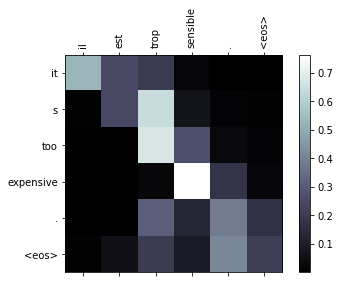

Input:['tom', 'est il', 'tombe', '?', '<eos>']
Label:['<sos>', 'did', 'tom', 'fall', '?', '<eos>']
Output:['did', 'tom', 'given', '?', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 2400], [train loss 15.4384 +/- 12.3012], [epoch elapsed time 182.14]
--------------------------------------------------------------------


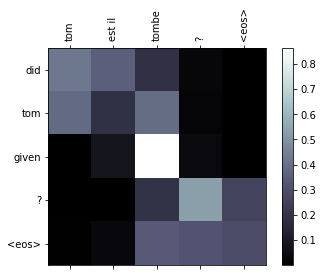

Input:['lequel', 'd', 'entre', 'vous', 'va', 'l', 'essayer', 'en', 'premier', '?', '<eos>']
Label:['<sos>', 'which', 'of', 'you', 'will', 'try', 'it', 'first', '?', '<eos>']
Output:['which', 'can', 'you', 'try', 'it', 'will', 'try', '?', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 2700], [train loss 15.3929 +/- 12.1360], [epoch elapsed time 204.57]
--------------------------------------------------------------------


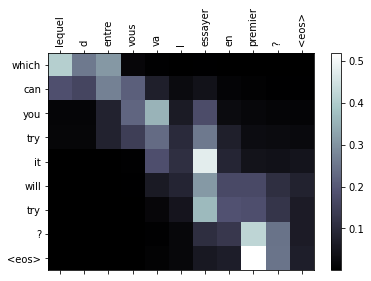

Input:['que', 'vouliez', 'vous', 'me', 'montrer', '?', '<eos>']
Label:['<sos>', 'what', 'did', 'you', 'want', 'to', 'show', 'me', '?', '<eos>']
Output:['what', 'do', 'you', 'want', 'to', 'show', 'me', '?', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 3000], [train loss 15.5056 +/- 12.1065], [epoch elapsed time 227.37]
--------------------------------------------------------------------


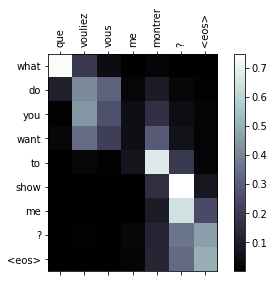

Input:['bill', 'gates', 'est', 'l', 'homme', 'le', 'plus', 'riche', 'au', 'monde', '.', '<eos>']
Label:['<sos>', 'bill', 'gates', 'is', 'the', 'world', 's', 'richest', 'man', '.', '<eos>']
Output:['the', 'is', 'is', 'the', 'world', 'man', 'man', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 3300], [train loss 15.5776 +/- 12.1962], [epoch elapsed time 250.10]
--------------------------------------------------------------------


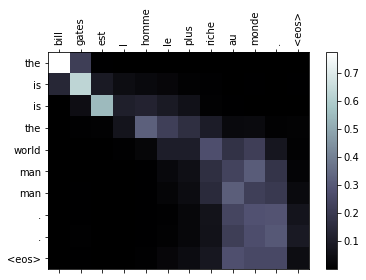

Input:['pourquoi', 'ne', 'm', 'as', 'tu', 'pas', 'appelee', 'la', 'nuit', 'derniere', '?', '<eos>']
Label:['<sos>', 'how', 'come', 'you', 'did', 'n t', 'call', 'me', 'last', 'night', '?', '<eos>']
Output:['why', 'did', 'you', 'not', 'n t', 'call', 'me', 'last', 'night', '?', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 3600], [train loss 15.6558 +/- 12.2047], [epoch elapsed time 272.78]
--------------------------------------------------------------------


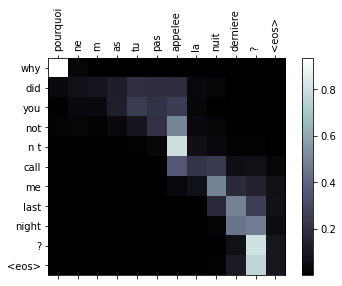

Input:['je', 'voulais', 'te', 'parler', 'au', 'sujet', 'de', 'quelque', 'chose', '.', '<eos>']
Label:['<sos>', 'i', 'wanted', 'to', 'talk', 'to', 'you', 'about', 'something', '.', '<eos>']
Output:['i', 'just', 'wanted', 'talk', 'to', 'talk', 'about', 'something', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 3900], [train loss 15.7025 +/- 12.1496], [epoch elapsed time 295.05]
--------------------------------------------------------------------


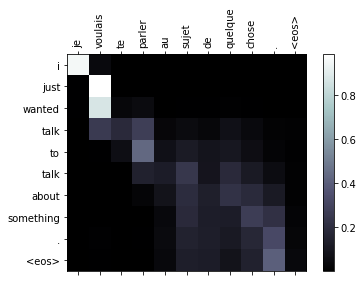

Input:['avez', 'vous', 'un', 'stylo', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'have', 'a', 'pen', '?', '<eos>']
Output:['do', 'you', 'have', 'a', 'new', '?', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 4200], [train loss 15.7618 +/- 12.1844], [epoch elapsed time 317.85]
--------------------------------------------------------------------


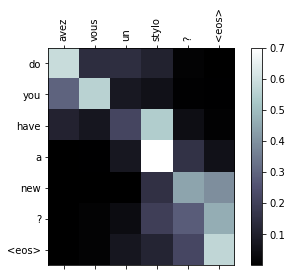

Input:['elle', 'a', 'fait', 'une', 'tarte', 'aux', 'pommes', 'a', 'son', 'mari', '.', '<eos>']
Label:['<sos>', 'she', 'made', 'her', 'husband', 'an', 'apple', 'pie', '.', '<eos>']
Output:['she', 'made', 'her', 'an', 'for', 'her', 'her', 'her', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 4500], [train loss 15.8408 +/- 12.2067], [epoch elapsed time 340.68]
--------------------------------------------------------------------


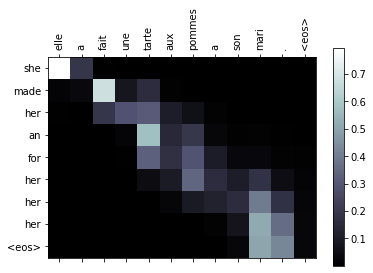

Input:['tom', 'a', 'une', 'fille', 'de', 'treize', 'ans', '.', '<eos>']
Label:['<sos>', 'tom', 'has', 'a', 'year', 'old', 'daughter', '.', '<eos>']
Output:['tom', 'has', 'a', 'daughter', 'old', 'old', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 4800], [train loss 15.9110 +/- 12.1694], [epoch elapsed time 363.38]
--------------------------------------------------------------------


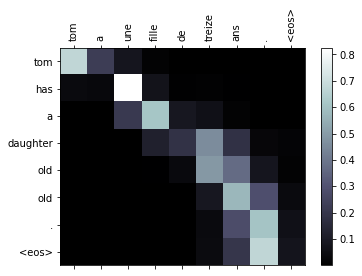

Input:['un', 'jour', 'elle', 'devra', 'payer', 'pour', 'ce', 'qu', 'elle', 'a', 'fait', '.', '<eos>']
Label:['<sos>', 'someday', 'she', 'll', 'have', 'to', 'pay', 'for', 'what', 'she', 's', 'done', '.', '<eos>']
Output:['a', 'she', 'is', 'pay', 'come', 'for', 'for', 'what', 'what', 'did', 'what', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 5100], [train loss 16.0289 +/- 12.2546], [epoch elapsed time 386.86]
--------------------------------------------------------------------


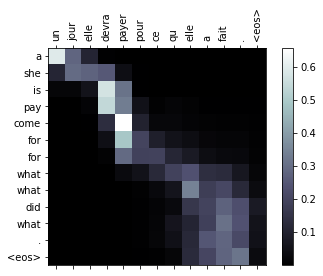

Input:['l', 'instituteur', 's', 'est', 'remis', '.', '<eos>']
Label:['<sos>', 'the', 'teacher', 'got', 'well', 'again', '.', '<eos>']
Output:['the', 'teacher', 'is', 'up', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 5400], [train loss 16.1646 +/- 12.2845], [epoch elapsed time 409.51]
--------------------------------------------------------------------


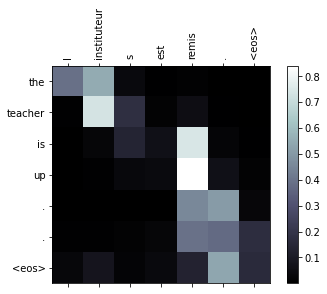

Input:['je', 'n', 'ai', 'rien', 'a', 'dire', '.', '<eos>']
Label:['<sos>', 'i', 'have', 'nothing', 'to', 'say', '.', '<eos>']
Output:['i', 'did', 'nothing', 'to', 'say', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 5700], [train loss 16.2668 +/- 12.3670], [epoch elapsed time 431.98]
--------------------------------------------------------------------


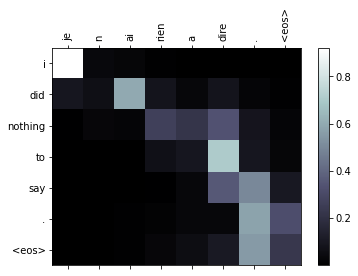

Input:['ne', 't', 'en', 'fais', 'pas', '!', 'nous', 'penserons', 'a', 'tout', '.', '<eos>']
Label:['<sos>', 'do', 'n t', 'worry', '.', 'we', 'll', 'figure', 'everything', 'out', '.', '<eos>']
Output:['do', 'n t', 'make', 'you', 'that', 'to', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 6000], [train loss 16.3740 +/- 12.5054], [epoch elapsed time 454.41]
--------------------------------------------------------------------


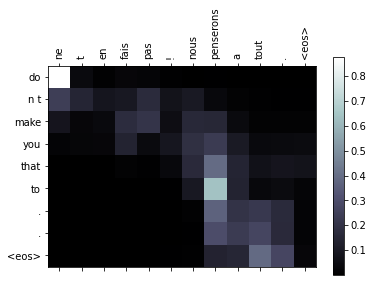

Input:['je', 'dormirai', 'par', 'terre', '.', '<eos>']
Label:['<sos>', 'i', 'll', 'sleep', 'on', 'the', 'floor', '.', '<eos>']
Output:['i', 'was', 'on', 'on', 'on', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 6300], [train loss 16.4689 +/- 12.5277], [epoch elapsed time 476.77]
--------------------------------------------------------------------


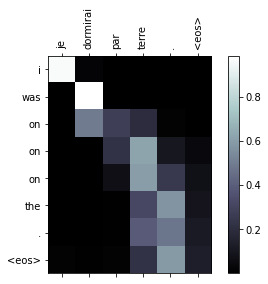

Input:['n', 'accuse', 'pas', 'la', 'victime', '!', '<eos>']
Label:['<sos>', 'do', 'n t', 'blame', 'the', 'victim', '.', '<eos>']
Output:['do', 'n t', 'be', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 11 iter 6600], [train loss 16.6448 +/- 12.6770], [epoch elapsed time 499.86]
--------------------------------------------------------------------


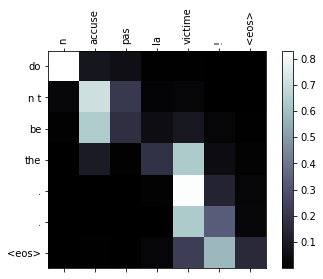

--------------------------------------------------------------------
[epoch 11], [train loss 16.6294 +/- 12.6540], [training time 504.10]
--------------------------------------------------------------------
********************************************************************
Input:['etes', 'vous', 'jaloux', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'jealous', '?', '<eos>']
Output:['are', 'you', 'lost', '?', '<eos>']


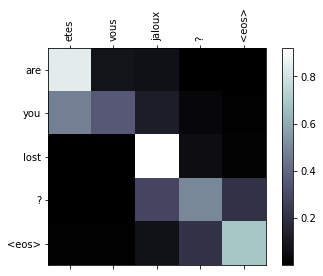

Input:['dis', 'bonjour', '.', '<eos>']
Label:['<sos>', 'say', 'hello', '.', '<eos>']
Output:['tell', 'mary', '.', '<eos>']


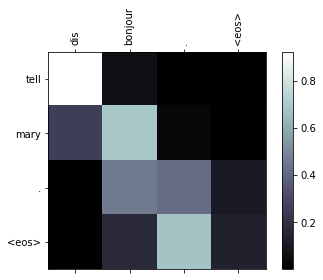

[epoch 11], [test loss 27.4470 +/- 16.4111], [testing time 2.11]
********************************************************************
Input:['elle', 'veut', 'epouser', 'une', 'millionnaire', '.', '<eos>']
Label:['<sos>', 'she', 'wants', 'to', 'marry', 'a', 'millionaire', '.', '<eos>']
Output:['she', 'wants', 'to', 'write', 'a', 'a', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 300], [train loss 15.2458 +/- 12.7136], [epoch elapsed time 22.18]
--------------------------------------------------------------------


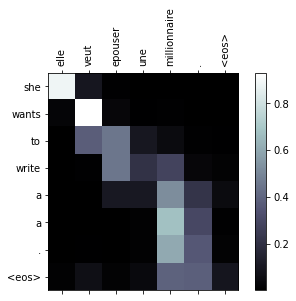

Input:['elles', 'sont', 'capables', 'd', 'augmenter', 'votre', 'loyer', '.', '<eos>']
Label:['<sos>', 'they', 'can', 'raise', 'your', 'rent', '.', '<eos>']
Output:['they', 'can', 'to', 'your', 'your', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 600], [train loss 14.5730 +/- 12.1537], [epoch elapsed time 44.49]
--------------------------------------------------------------------


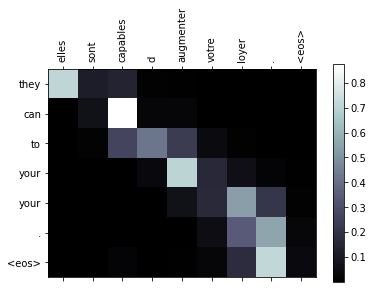

Input:['tom', 'et', 'moi', 'avons', 'du', 'travail', 'a', 'faire', '.', '<eos>']
Label:['<sos>', 'tom', 'and', 'i', 'have', 'work', 'to', 'do', '.', '<eos>']
Output:['tom', 'and', 'i', 'have', 'to', 'to', 'do', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 900], [train loss 14.6521 +/- 11.9905], [epoch elapsed time 66.51]
--------------------------------------------------------------------


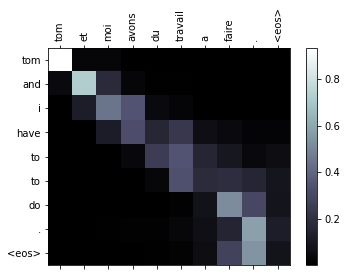

Input:['tous', 'les', 'chevaux', 'sont', 'des', 'animaux', 'toutefois', 'les', 'animaux', 'ne', 'sont', 'pas', 'tous', 'des', 'chevaux', '.', '<eos>']
Label:['<sos>', 'all', 'horses', 'are', 'animals', 'but', 'not', 'all', 'animals', 'are', 'horses', '.', '<eos>']
Output:['all', 'of', 'is', 'are', 'but', 'but', 'all', 'all', '.', 'all', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 1200], [train loss 14.7695 +/- 12.2215], [epoch elapsed time 89.12]
--------------------------------------------------------------------


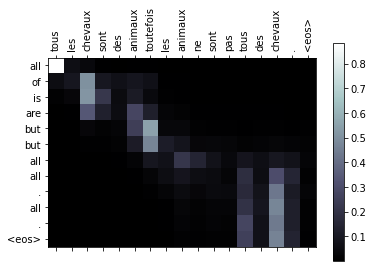

Input:['eprouves', 'tu', 'toujours', 'des', 'sentiments', 'pour', 'elle', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'still', 'have', 'feelings', 'for', 'her', '?', '<eos>']
Output:['do', 'you', 'still', 'have', 'feelings', 'for', 'her', '?', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 1500], [train loss 14.9377 +/- 12.4895], [epoch elapsed time 111.58]
--------------------------------------------------------------------


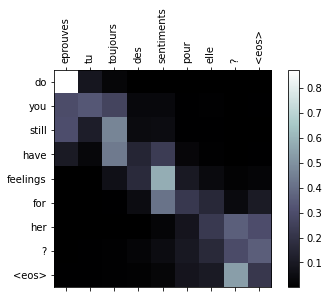

Input:['il', 'pleuvait', 'quand', 'je', 'suis', 'monte', 'dans', 'le', 'bus', 'ce', 'matin', '.', '<eos>']
Label:['<sos>', 'it', 'was', 'raining', 'when', 'i', 'got', 'on', 'the', 'bus', 'this', 'morning', '.', '<eos>']
Output:['it', 'was', 'raining', 'when', 'i', 'got', 'on', 'the', 'bus', 'this', 'morning', 'this', 'morning', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 1800], [train loss 15.1108 +/- 12.5482], [epoch elapsed time 134.06]
--------------------------------------------------------------------


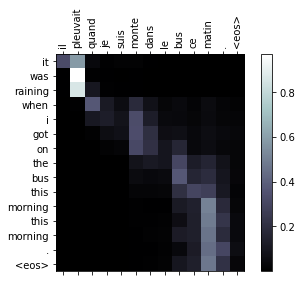

Input:['je', 'veux', 'partir', 'en', 'vacances', 'avec', 'toi', '.', '<eos>']
Label:['<sos>', 'i', 'want', 'to', 'go', 'on', 'a', 'trip', 'with', 'you', '.', '<eos>']
Output:['i', 'want', 'to', 'go', 'on', 'on', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 2100], [train loss 15.0773 +/- 12.5419], [epoch elapsed time 156.16]
--------------------------------------------------------------------


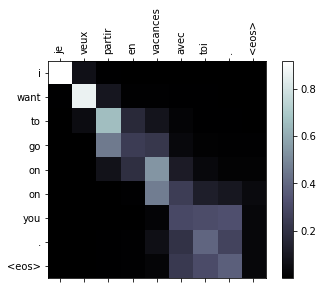

Input:['ma', 'mere', 'aime', 'beaucoup', 'les', 'tulipes', 'et', 'ma', 'soeur', 'aussi', '.', '<eos>']
Label:['<sos>', 'my', 'mother', 'likes', 'tulips', 'very', 'much', 'and', 'so', 'does', 'my', 'sister', '.', '<eos>']
Output:['my', 'mother', 'take', 'a', 'very', 'long', 'and', 'my', '.', '.', 'sister', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 2400], [train loss 15.2520 +/- 12.5362], [epoch elapsed time 179.22]
--------------------------------------------------------------------


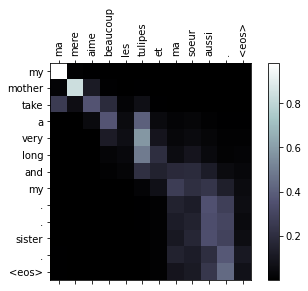

Input:['montre les moi', '.', '<eos>']
Label:['<sos>', 'show', 'them', 'to', 'me', '.', '<eos>']
Output:['show', 'it', 'to', 'me', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 2700], [train loss 15.2485 +/- 12.5077], [epoch elapsed time 201.27]
--------------------------------------------------------------------


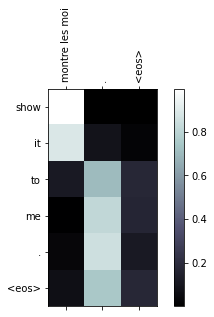

Input:['j', 'aime', 'dormir', '.', '<eos>']
Label:['<sos>', 'i', 'like', 'sleeping', '.', '<eos>']
Output:['i', 'like', 'to', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 3000], [train loss 15.3104 +/- 12.5283], [epoch elapsed time 223.82]
--------------------------------------------------------------------


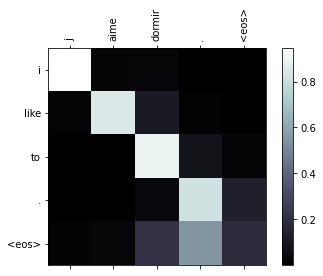

Input:['elle', 'a', 'un', 'grand', 'nez', '.', '<eos>']
Label:['<sos>', 'she', 'has', 'a', 'long', 'nose', '.', '<eos>']
Output:['she', 'has', 'a', 'big', 'nose', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 3300], [train loss 15.3630 +/- 12.4683], [epoch elapsed time 247.31]
--------------------------------------------------------------------


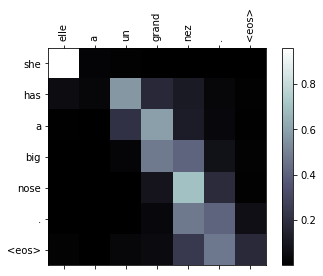

Input:['je', 'pense', 'qu', 'il', 'est', 'temps', 'que', 'je', 'discute', 'du', 'probleme', 'avec', 'elle', '.', '<eos>']
Label:['<sos>', 'i', 'think', 'it', 's', 'time', 'for', 'me', 'to', 'discuss', 'the', 'problem', 'with', 'her', '.', '<eos>']
Output:['i', 'think', 'it', 's', 'time', 'for', 'me', 'to', 'the', 'the', 'the', 'with', 'with', 'her', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 3600], [train loss 15.4508 +/- 12.4685], [epoch elapsed time 271.19]
--------------------------------------------------------------------


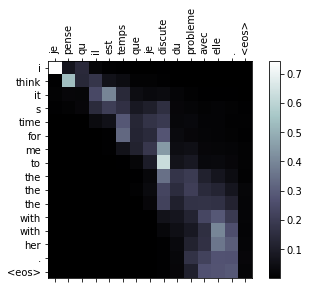

Input:['il', 'nous', 'faut', 'nous', 'echapper', '.', '<eos>']
Label:['<sos>', 'we', 'must', 'escape', '.', '<eos>']
Output:['we', 'have', 'to', 'us', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 3900], [train loss 15.5214 +/- 12.4930], [epoch elapsed time 294.76]
--------------------------------------------------------------------


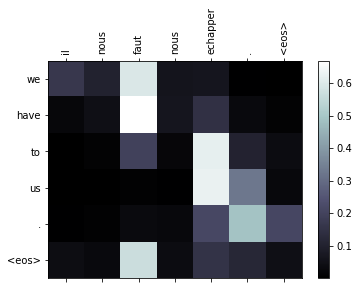

Input:['les', 'eleves', 'se', 'levent', 'lorsque', 'leur', 'professeur', 'entre', '.', '<eos>']
Label:['<sos>', 'students', 'stand', 'up', 'when', 'their', 'teacher', 'enters', '.', '<eos>']
Output:['the', 'school', 'they', 'when', 'their', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 4200], [train loss 15.5988 +/- 12.4787], [epoch elapsed time 317.51]
--------------------------------------------------------------------


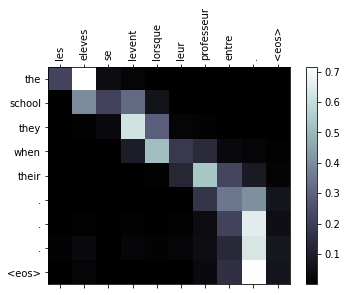

Input:['je', 'ne', 'pense', 'pas', 'que', 'je', 'pourrais', 'faire', 'ca', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'think', 'i', 'could', 'do', 'that', '.', '<eos>']
Output:['i', 'do', 'n t', 'think', 'i', 'could', 'do', 'that', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 4500], [train loss 15.6233 +/- 12.4321], [epoch elapsed time 340.42]
--------------------------------------------------------------------


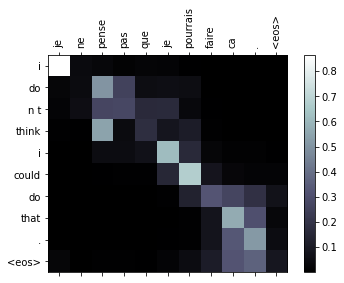

Input:['ca', 'm', 'est', 'egal', 'que', 'vous', 'soyez', 'occupes', '.', 'je', 'vous', 'prie', 'de', 'm', 'aider', 'maintenant', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'care', 'if', 'you', 're', 'busy', '.', 'please', 'help', 'me', 'now', '.', '<eos>']
Output:['it', 'does', 'n t', 'know', 'how', 'to', 'i', 'get', 'up', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 4800], [train loss 15.7764 +/- 12.5456], [epoch elapsed time 363.74]
--------------------------------------------------------------------


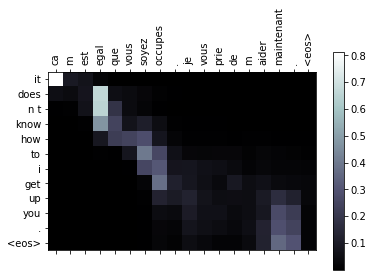

Input:['je', 'suis', 'tres', 'heureux', 'd', 'apprendre', 'tes', 'fiancailles', '.', '<eos>']
Label:['<sos>', 'i', 'am', 'very', 'happy', 'to', 'hear', 'about', 'your', 'engagement', '.', '<eos>']
Output:['i', 'm', 'very', 'happy', 'to', 'to', 'up', 'your', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 5100], [train loss 15.8392 +/- 12.5767], [epoch elapsed time 386.38]
--------------------------------------------------------------------


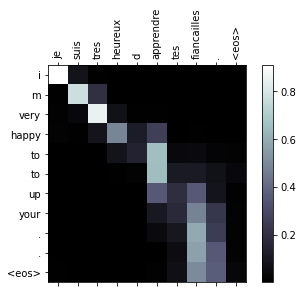

Input:['resserre', 'cette', 'vis', '!', '<eos>']
Label:['<sos>', 'tighten', 'this', 'screw', '.', '<eos>']
Output:['leave', 'this', 'house', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 5400], [train loss 15.9151 +/- 12.5577], [epoch elapsed time 409.67]
--------------------------------------------------------------------


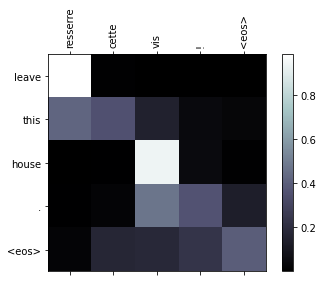

Input:['j', 'aimerais', 'vraiment', 'savoir', 'pourquoi', 'il', 'a', 'fait', 'une', 'telle', 'chose', '.', '<eos>']
Label:['<sos>', 'i', 'would', 'really', 'like', 'to', 'know', 'why', 'he', 'did', 'such', 'a', 'thing', '.', '<eos>']
Output:['i', 'really', 'would', 'really', 'know', 'what', 'he', 'did', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 5700], [train loss 15.9598 +/- 12.5338], [epoch elapsed time 432.92]
--------------------------------------------------------------------


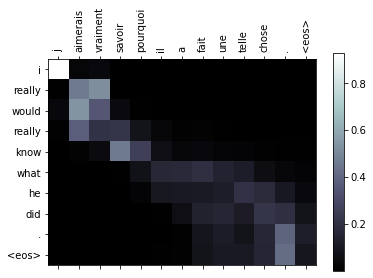

Input:['je', 'suis', 'tres', 'content', 'que', 'l', 'ecole', 'soit', 'finie', '.', '<eos>']
Label:['<sos>', 'i', 'am', 'very', 'glad', 'school', 'is', 'over', '.', '<eos>']
Output:['i', 'am', 'very', 'happy', 'school', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 6000], [train loss 16.0721 +/- 12.6002], [epoch elapsed time 456.24]
--------------------------------------------------------------------


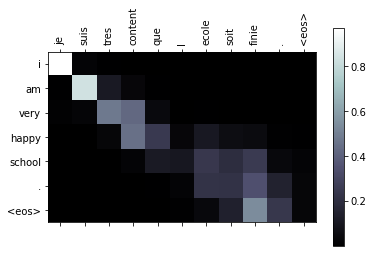

Input:['nous', 'avons', 'de', 'la', 'place', 'pour', 'trois', 'autres', '.', '<eos>']
Label:['<sos>', 'we', 'have', 'room', 'for', 'three', 'more', '.', '<eos>']
Output:['we', 'have', 'in', 'for', 'three', 'times', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 6300], [train loss 16.1665 +/- 12.6361], [epoch elapsed time 479.19]
--------------------------------------------------------------------


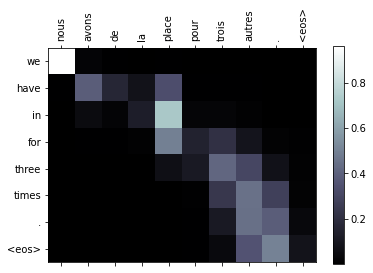

Input:['ce', 'n', 'est', 'pas', 'sans', 'danger', 'ici', '.', '<eos>']
Label:['<sos>', 'it', 's', 'not', 'safe', 'here', '.', '<eos>']
Output:['it', 'is', 'not', 'safe', 'in', '.', '<eos>']
--------------------------------------------------------------------
[epoch 12 iter 6600], [train loss 16.2137 +/- 12.6258], [epoch elapsed time 501.15]
--------------------------------------------------------------------


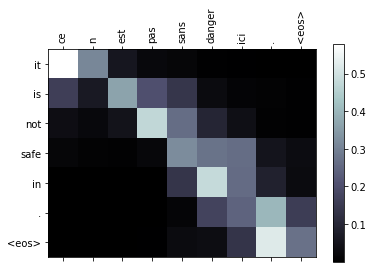

--------------------------------------------------------------------
[epoch 12], [train loss 16.2216 +/- 12.6312], [training time 505.42]
--------------------------------------------------------------------
********************************************************************
Input:['elle', 'lui', 'a', 'demande', 'de', 'l', 'appeler', 'plus', 'tard', '.', '<eos>']
Label:['<sos>', 'she', 'asked', 'him', 'to', 'call', 'her', 'later', '.', '<eos>']
Output:['she', 'asked', 'him', 'to', 'the', 'next', '.', '<eos>']


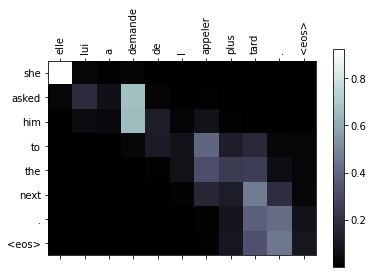

Input:['nous', 'avons', 'decouvert', 'les', '<unk>', 'd', 'une', '<unk>', '<unk>', '.', '<eos>']
Label:['<sos>', 'we', 'discovered', '<unk>', 'of', 'an', 'ancient', '<unk>', '.', '<eos>']
Output:['we', 'got', 'out', 'of', 'the', 'a', '.', '<eos>']


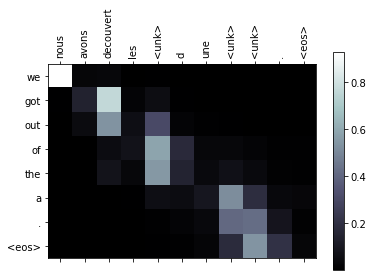

[epoch 12], [test loss 27.8364 +/- 16.9315], [testing time 2.16]
********************************************************************
Input:['l', 'incident', 'l', 'a', 'rendu', 'celebre', '.', '<eos>']
Label:['<sos>', 'the', 'event', 'made', 'him', 'famous', '.', '<eos>']
Output:['the', 'english', 'made', 'him', 'by', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 300], [train loss 12.5061 +/- 11.0344], [epoch elapsed time 21.93]
--------------------------------------------------------------------


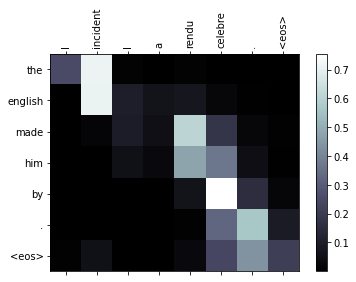

Input:['ils', 'ont', 'voyage', 'a', 'l', 'etranger', 'pour', 'la', 'premiere', 'fois', '.', '<eos>']
Label:['<sos>', 'they', 'went', 'on', 'a', 'trip', 'abroad', 'for', 'the', 'first', 'time', '.', '<eos>']
Output:['they', 'went', 'on', 'you', 'trip', 'for', 'the', 'the', 'first', 'time', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 600], [train loss 13.1896 +/- 10.8587], [epoch elapsed time 45.09]
--------------------------------------------------------------------


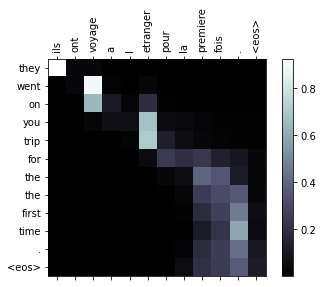

Input:['attends', 'jusqu', 'a', 'demain', '.', '<eos>']
Label:['<sos>', 'wait', 'until', 'tomorrow', '.', '<eos>']
Output:['wait', 'of', 'tomorrow', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 900], [train loss 13.3849 +/- 11.2826], [epoch elapsed time 66.97]
--------------------------------------------------------------------


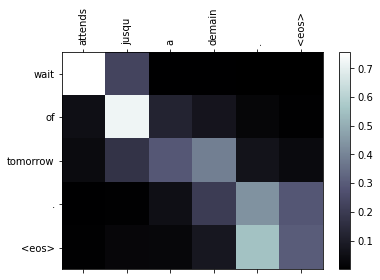

Input:['ce', 'jeune', 'homme', 'en', 'connait', 'peu', 'sur', 'son', 'pays', '.', '<eos>']
Label:['<sos>', 'this', 'young', 'man', 'knows', 'little', 'about', 'his', 'country', '.', '<eos>']
Output:['this', 'young', 'man', 'knows', 'little', 'about', 'about', 'country', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 1200], [train loss 13.5387 +/- 11.5638], [epoch elapsed time 89.48]
--------------------------------------------------------------------


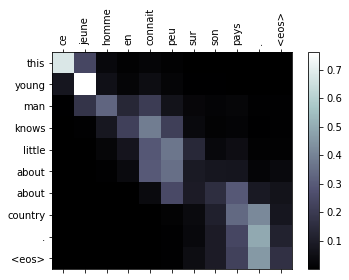

Input:['il', 'tire', 'le', 'meilleur', 'parti', 'de', 'ses', 'opportunites', '.', '<eos>']
Label:['<sos>', 'he', 'makes', 'the', 'most', 'of', 'his', 'opportunities', '.', '<eos>']
Output:['he', 'is', 'the', 'the', 'of', 'his', 'his', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 1500], [train loss 13.9487 +/- 11.7369], [epoch elapsed time 111.87]
--------------------------------------------------------------------


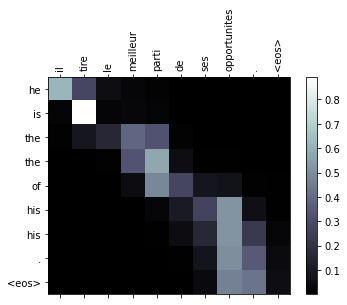

Input:['je', 'ne', 'suis', 'pas', 'devin', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'not', 'a', 'psychic', '.', '<eos>']
Output:['i', 'm', 'not', 'a', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 1800], [train loss 14.0536 +/- 11.7306], [epoch elapsed time 134.47]
--------------------------------------------------------------------


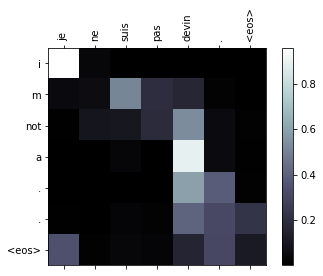

Input:['quel', 'est', 'le', 'prix', 'de', 'cette', 'montre', '?', '<eos>']
Label:['<sos>', 'what', 'is', 'the', 'price', 'of', 'this', 'watch', '?', '<eos>']
Output:['what', 'is', 'the', 'of', 'of', 'this', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 2100], [train loss 14.1331 +/- 11.6701], [epoch elapsed time 156.37]
--------------------------------------------------------------------


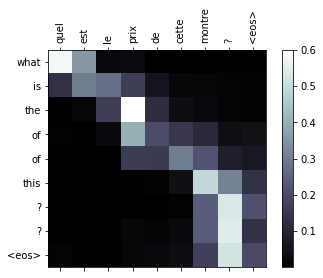

Input:['cela', 'pourrait', 'etre', 'la', 'derniere', 'fois', 'que', 'nous', 'nous', 'voyons', '.', '<eos>']
Label:['<sos>', 'this', 'might', 'be', 'the', 'last', 'time', 'we', 'ever', 'see', 'each', 'other', '.', '<eos>']
Output:['it', 'might', 'be', 'the', 'last', 'time', 'we', 'd', 've', 'time', 'we', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 2400], [train loss 14.1994 +/- 11.5273], [epoch elapsed time 178.69]
--------------------------------------------------------------------


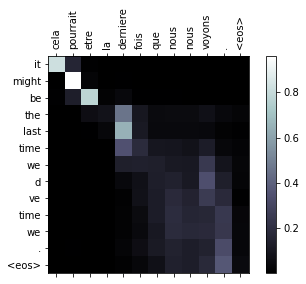

Input:['il', 'disait', 'alors', 'qu', 'il', 'etait', 'occupe', 'mais', 'qu', 'il', 'serait', 'libre', 'le', 'jour', 'suivant', '.', '<eos>']
Label:['<sos>', 'he', 'said', 'that', 'he', 'was', 'busy', 'then', 'but', 'that', 'he', 'would', 'be', 'free', 'the', 'next', 'day', '.', '<eos>']
Output:['he', 'said', 'that', 'was', 'was', 'was', 'was', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 2700], [train loss 14.4136 +/- 11.9884], [epoch elapsed time 201.42]
--------------------------------------------------------------------


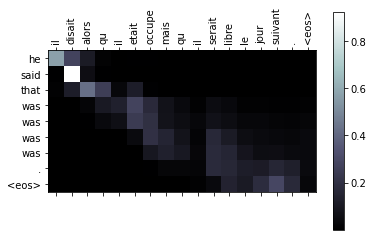

Input:['tout', 'le', 'monde', 'a', 'fait', 'un', 'job', 'fabuleux', '.', '<eos>']
Label:['<sos>', 'everyone', 'did', 'a', 'fabulous', 'job', '.', '<eos>']
Output:['everyone', 'is', 'a', 'job', 'job', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 3000], [train loss 14.4053 +/- 11.9298], [epoch elapsed time 224.09]
--------------------------------------------------------------------


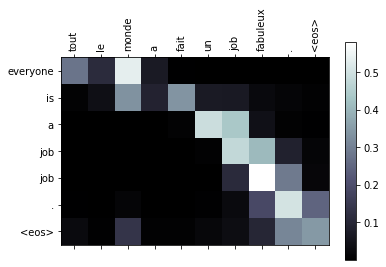

Input:['il', 'faisait', 'un', 'froid', 'de', 'canard', 'dehors', '.', '<eos>']
Label:['<sos>', 'it', 'was', 'bitterly', 'cold', 'outside', '.', '<eos>']
Output:['it', 'was', 'cold', 'cold', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 3300], [train loss 14.6892 +/- 12.1144], [epoch elapsed time 246.79]
--------------------------------------------------------------------


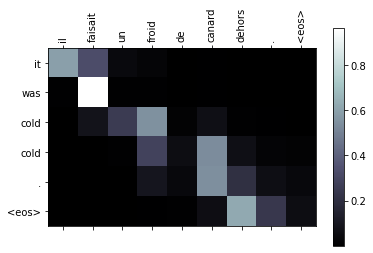

Input:['je', 'ne', 'peux', 'pas', 'm', 'empecher', 'de', 'me', 'demander', 's', 'il', 'viendra', 'a', 'l', 'heure', '.', '<eos>']
Label:['<sos>', 'i', 'can', 'not', 'help', 'wondering', 'if', 'he', 'will', 'come', 'on', 'time', '.', '<eos>']
Output:['i', 'ca', 'n t', 'help', 'if', 'if', 'you', 'll', 'come', 'at', 'time', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 3600], [train loss 14.8475 +/- 12.2854], [epoch elapsed time 270.16]
--------------------------------------------------------------------


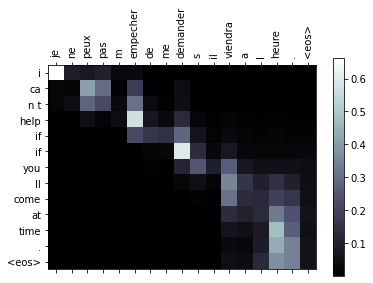

Input:['le', 'prochain', 'jour', 'ferie', 'tombe', 'un', 'dimanche', '.', '<eos>']
Label:['<sos>', 'the', 'next', 'holiday', 'falls', 'on', 'a', 'sunday', '.', '<eos>']
Output:['the', 'next', 'has', 'has', 'in', 'a', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 3900], [train loss 14.9808 +/- 12.3645], [epoch elapsed time 292.71]
--------------------------------------------------------------------


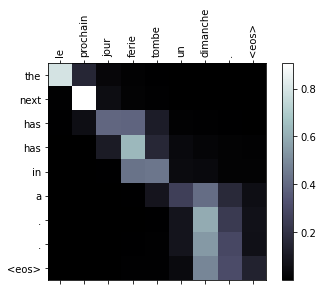

Input:['je', 'savais', 'que', 'ca', 'se', 'produirait', '.', '<eos>']
Label:['<sos>', 'i', 'knew', 'this', 'would', 'happen', '.', '<eos>']
Output:['i', 'knew', 'it', 'would', 'happen', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 4200], [train loss 15.1201 +/- 12.3527], [epoch elapsed time 315.33]
--------------------------------------------------------------------


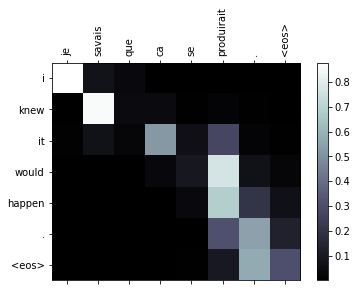

Input:['on', 'peut', 's', 'y', 'rendre', 'a', 'pied', '.', '<eos>']
Label:['<sos>', 'it', 's', 'within', 'walking', 'distance', '.', '<eos>']
Output:['we', 're', 'going', 'up', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 4500], [train loss 15.2016 +/- 12.3760], [epoch elapsed time 338.22]
--------------------------------------------------------------------


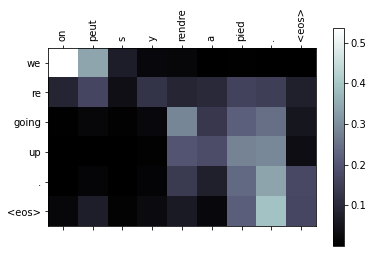

Input:['vous', 'me', 'faites', 'de', 'l', 'ombre', '.', '<eos>']
Label:['<sos>', 'you', 're', 'blocking', 'my', 'light', '.', '<eos>']
Output:['you', 're', 'make', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 4800], [train loss 15.2704 +/- 12.3626], [epoch elapsed time 361.21]
--------------------------------------------------------------------


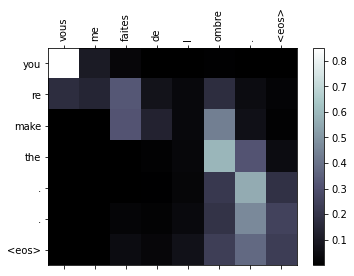

Input:['il', 'est', 'en', 'mauvaise', 'sante', '.', '<eos>']
Label:['<sos>', 'he', 'is', 'in', 'poor', 'health', '.', '<eos>']
Output:['he', 'is', 'in', 'health', 'health', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 5100], [train loss 15.3010 +/- 12.3480], [epoch elapsed time 384.30]
--------------------------------------------------------------------


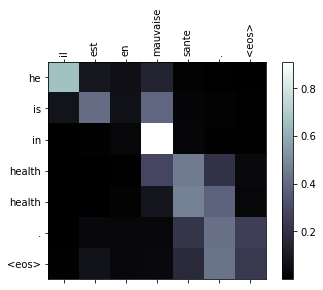

Input:['les', 'choses', 'sont', 'devenues', 'incontrolables', '.', '<eos>']
Label:['<sos>', 'things', 'got', 'out', 'of', 'control', '.', '<eos>']
Output:['things', 'are', 'a', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 5400], [train loss 15.3694 +/- 12.3492], [epoch elapsed time 407.21]
--------------------------------------------------------------------


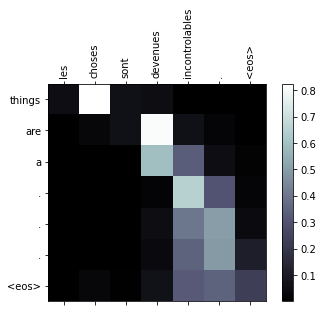

Input:['je', 'suppose', 'que', 'je', 'me', 'suis', 'endormie', '.', '<eos>']
Label:['<sos>', 'i', 'guess', 'i', 'fell', 'asleep', '.', '<eos>']
Output:['i', 'guess', 'i', 'fell', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 5700], [train loss 15.5019 +/- 12.3775], [epoch elapsed time 429.42]
--------------------------------------------------------------------


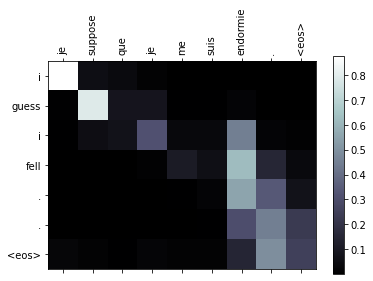

Input:['etes', 'vous', 'contents', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'happy', '?', '<eos>']
Output:['are', 'you', 'ready', '?', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 6000], [train loss 15.6295 +/- 12.4894], [epoch elapsed time 452.25]
--------------------------------------------------------------------


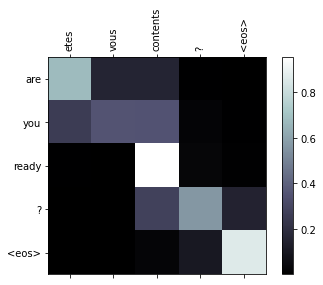

Input:['elles', 'veulent', 'davantage', '.', '<eos>']
Label:['<sos>', 'they', 'want', 'more', '.', '<eos>']
Output:['they', 'want', 'more', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 6300], [train loss 15.6817 +/- 12.5505], [epoch elapsed time 474.64]
--------------------------------------------------------------------


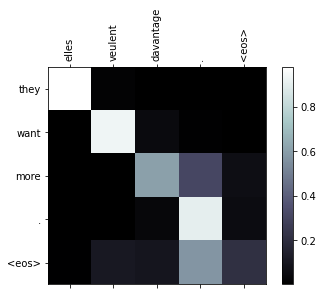

Input:['un', 'singe', 'grimpe', 'sur', 'un', 'grand', 'arbre', '.', '<eos>']
Label:['<sos>', 'a', 'monkey', 'is', 'climbing', 'up', 'a', 'tall', 'tree', '.', '<eos>']
Output:['a', 'look', 'is', 'on', 'an', 'tree', '.', '<eos>']
--------------------------------------------------------------------
[epoch 13 iter 6600], [train loss 15.7576 +/- 12.5623], [epoch elapsed time 497.23]
--------------------------------------------------------------------


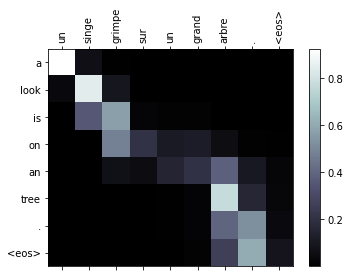

--------------------------------------------------------------------
[epoch 13], [train loss 15.7666 +/- 12.5775], [training time 501.72]
--------------------------------------------------------------------
********************************************************************
Input:['nous', 'avons', 'decouvert', 'les', '<unk>', 'd', 'une', '<unk>', '<unk>', '.', '<eos>']
Label:['<sos>', 'we', 'discovered', '<unk>', 'of', 'an', 'ancient', '<unk>', '.', '<eos>']
Output:['we', 'found', 'out', 'of', 'a', 'a', '.', '.', '<eos>']


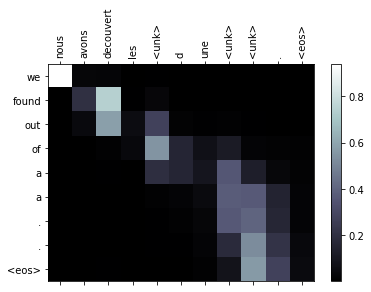

Input:['cela', 'ne', '<unk>', 't', 'il', 'rien', 'pour', 'toi', '?', '<eos>']
Label:['<sos>', 'does', 'n t', 'that', 'mean', 'anything', 'to', 'you', '?', '<eos>']
Output:['does', 'n t', 'you', 'say', 'anything', 'you', 'you', '?', '<eos>']


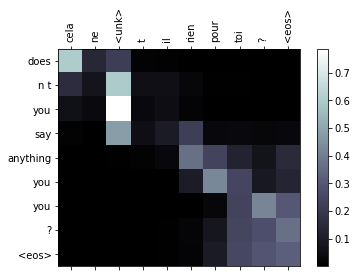

[epoch 13], [test loss 27.3779 +/- 17.1524], [testing time 2.26]
********************************************************************
Input:['je', 'ne', 'sais', 'pas', 'comment', 'acheter', 'un', 'billet', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'know', 'how', 'to', 'buy', 'a', 'ticket', '.', '<eos>']
Output:['i', 'do', 'n t', 'know', 'how', 'to', 'buy', 'a', 'ticket', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 300], [train loss 13.0131 +/- 10.8302], [epoch elapsed time 21.52]
--------------------------------------------------------------------


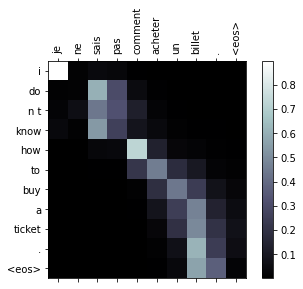

Input:['tom', 'n', 'a', 'pas', 'porte', 'de', 'costume', '.', '<eos>']
Label:['<sos>', 'tom', 'did', 'n t', 'wear', 'a', 'suit', '.', '<eos>']
Output:['tom', 'did', 'n t', 'wear', 'him', 'to', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 600], [train loss 13.4717 +/- 11.5956], [epoch elapsed time 43.67]
--------------------------------------------------------------------


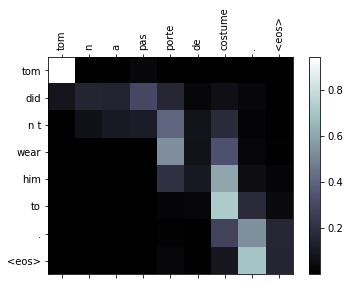

Input:['les', 'gens', 'ont', 'tendance', 'a', 'elever', 'la', 'voix', 'quand', 'ils', 'sont', 'excites', '.', '<eos>']
Label:['<sos>', 'people', 'tend', 'to', 'raise', 'their', 'voices', 'when', 'they', 'get', 'excited', '.', '<eos>']
Output:['people', 'people', 'to', 'see', 'the', 'when', 'when', 'they', 'when', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 900], [train loss 13.4071 +/- 11.3568], [epoch elapsed time 66.20]
--------------------------------------------------------------------


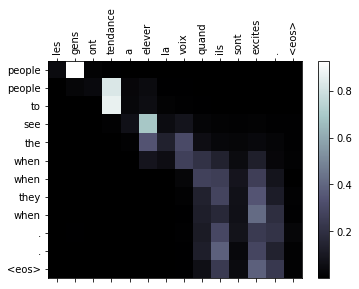

Input:['je', 'n', 'aurai', 'pas', 'assez', 'de', 'temps', 'pour', 'tout', 'ce', 'que', 'je', 'veux', 'faire', '.', '<eos>']
Label:['<sos>', 'i', 'wo', 'n t', 'have', 'enough', 'time', 'for', 'everything', 'i', 'want', 'to', 'do', '.', '<eos>']
Output:['i', 'do', 'n t', 'have', 'enough', 'for', 'about', 'everything', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 1200], [train loss 13.6613 +/- 11.2430], [epoch elapsed time 88.49]
--------------------------------------------------------------------


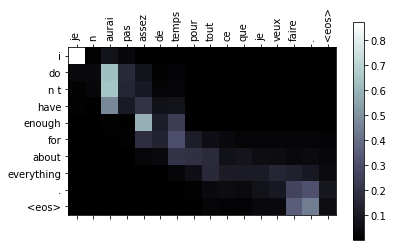

Input:['est', 'ce', 'de', 'l', 'or', 'pur', '?', '<eos>']
Label:['<sos>', 'is', 'that', 'pure', 'gold', '?', '<eos>']
Output:['is', 'it', 'gold', 'gold', '?', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 1500], [train loss 13.5256 +/- 11.1560], [epoch elapsed time 110.46]
--------------------------------------------------------------------


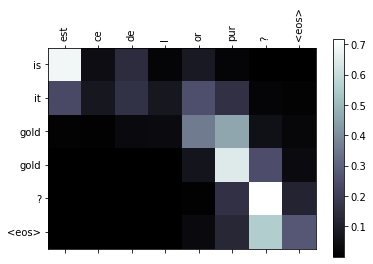

Input:['pourquoi', 'tom', 'et', 'mary', 'se', 'battent', 'ils', 'si', 'souvent', '?', '<eos>']
Label:['<sos>', 'why', 'do', 'tom', 'and', 'mary', 'fight', 'so', 'much', '?', '<eos>']
Output:['why', 'tom', 'and', 'mary', 'they', 'so', 'much', '?', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 1800], [train loss 13.6976 +/- 11.1833], [epoch elapsed time 132.82]
--------------------------------------------------------------------


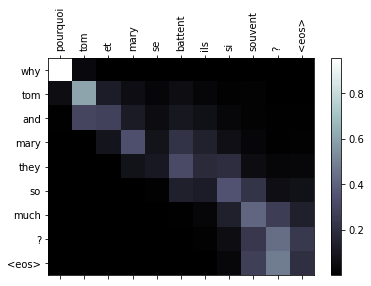

Input:['comportez', 'vous', 'simplement', 'comme', 'si', 'rien', 'ne', 's', 'etait', 'passe', '.', '<eos>']
Label:['<sos>', 'just', 'act', 'as', 'if', 'nothing', 'has', 'happened', '.', '<eos>']
Output:['just', 'just', 'as', 'if', 'nothing', 'happened', 'happened', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 2100], [train loss 13.7947 +/- 11.3063], [epoch elapsed time 155.30]
--------------------------------------------------------------------


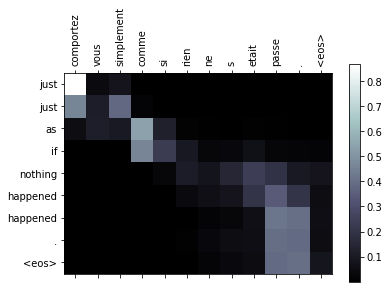

Input:['comment', 'se', 'porte', 'l', 'economie', '?', '<eos>']
Label:['<sos>', 'how', 'is', 'the', 'economy', '?', '<eos>']
Output:['how', 'is', 'the', 'the', '?', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 2400], [train loss 13.8361 +/- 11.1556], [epoch elapsed time 178.38]
--------------------------------------------------------------------


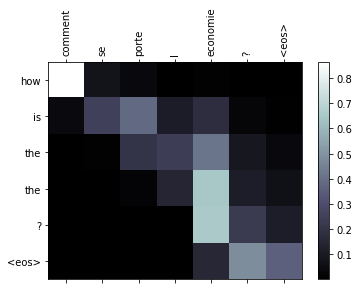

Input:['m', 'avez', 'vous', 'compris', '?', '<eos>']
Label:['<sos>', 'did', 'you', 'understand', 'me', '?', '<eos>']
Output:['did', 'you', 'understand', 'me', '?', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 2700], [train loss 13.9946 +/- 11.1909], [epoch elapsed time 201.35]
--------------------------------------------------------------------


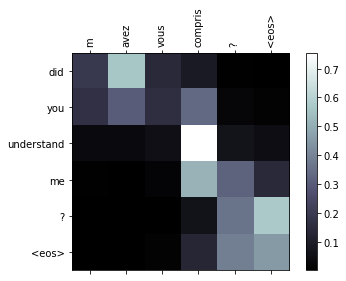

Input:['il', 'faudrait', 'que', 'je', 'me', 'remette', 'a', 'l', 'ecriture', 'de', 'mon', 'rapport', '.', '<eos>']
Label:['<sos>', 'i', 'should', 'get', 'back', 'to', 'writing', 'my', 'report', '.', '<eos>']
Output:['i', 'll', 'i', 'my', 'to', 'to', 'my', 'my', 'my', '.']
--------------------------------------------------------------------
[epoch 14 iter 3000], [train loss 14.0038 +/- 11.1481], [epoch elapsed time 224.33]
--------------------------------------------------------------------


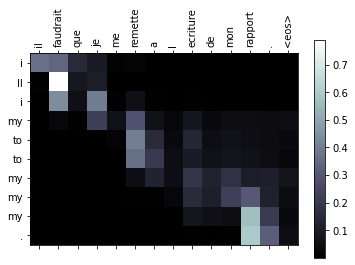

Input:['je', 'songe', 'au', 'projet', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'thinking', 'of', 'the', 'plan', '.', '<eos>']
Output:['i', 'm', 'playing', 'of', 'the', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 3300], [train loss 14.1490 +/- 11.3054], [epoch elapsed time 247.52]
--------------------------------------------------------------------


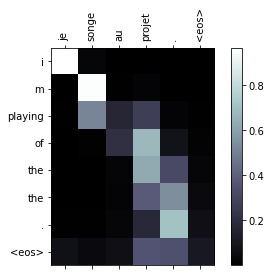

Input:['brosse', 'toi', 'les', 'dents', 'a', 'l', 'issue', 'de', 'chaque', 'repas', '.', '<eos>']
Label:['<sos>', 'brush', 'your', 'teeth', 'after', 'every', 'meal', '.', '<eos>']
Output:['you', 'eat', 'the', 'every', 'every', 'every', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 3600], [train loss 14.2692 +/- 11.3376], [epoch elapsed time 269.87]
--------------------------------------------------------------------


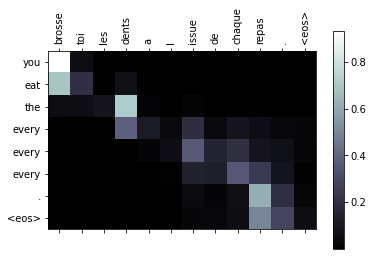

Input:['j', 'ai', 'couru', 'tout', 'le', 'long', 'du', 'chemin', 'jusqu', 'a', 'chez', 'moi', '.', '<eos>']
Label:['<sos>', 'i', 'ran', 'all', 'the', 'way', 'home', '.', '<eos>']
Output:['i', 'ran', 'all', 'the', 'way', 'way', 'home', 'home']
--------------------------------------------------------------------
[epoch 14 iter 3900], [train loss 14.3867 +/- 11.4783], [epoch elapsed time 293.01]
--------------------------------------------------------------------


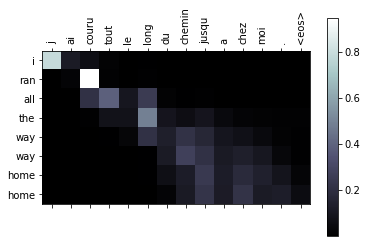

Input:['rien', 'de', 'tout', 'ca', 'n', 'a', 'de', 'sens', '.', '<eos>']
Label:['<sos>', 'the', 'whole', 'thing', 'does', 'n t', 'make', 'sense', '.', '<eos>']
Output:['nothing', 'whole', 'is', 'is', 'make', 'make', 'sense', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 4200], [train loss 14.5446 +/- 11.5993], [epoch elapsed time 316.14]
--------------------------------------------------------------------


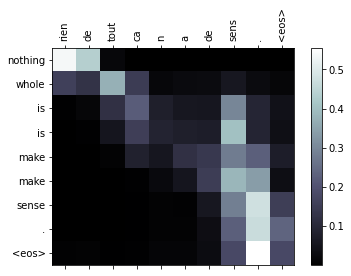

Input:['tom', 'voulait', 'divorcer', '.', '<eos>']
Label:['<sos>', 'tom', 'wanted', 'a', 'divorce', '.', '<eos>']
Output:['tom', 'wanted', 'a', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 4500], [train loss 14.6711 +/- 11.7084], [epoch elapsed time 338.98]
--------------------------------------------------------------------


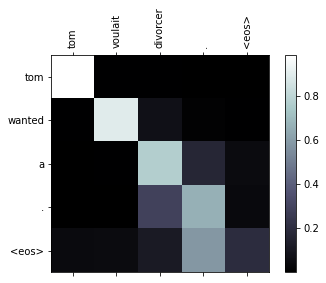

Input:['tom', 'ressemble', 'a', 'un', 'comptable', '.', '<eos>']
Label:['<sos>', 'tom', 'looks', 'like', 'an', 'accountant', '.', '<eos>']
Output:['tom', 'looks', 'like', 'a', 'a', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 4800], [train loss 14.8199 +/- 11.7589], [epoch elapsed time 361.96]
--------------------------------------------------------------------


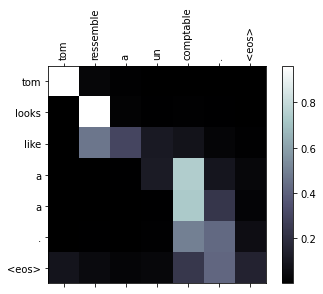

Input:['lache', 'moi', '!', '<eos>']
Label:['<sos>', 'give', 'me', 'a', 'break', '.', '<eos>']
Output:['let', 'me', 'me', 'back', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 5100], [train loss 14.8784 +/- 11.8492], [epoch elapsed time 384.64]
--------------------------------------------------------------------


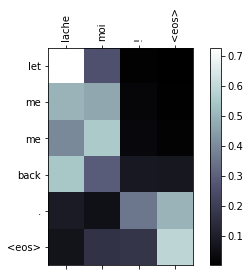

Input:['je', 'pense', 'que', 'le', 'jogging', 'est', 'un', 'bon', 'exercice', '.', '<eos>']
Label:['<sos>', 'i', 'think', 'jogging', 'is', 'good', 'exercise', '.', '<eos>']
Output:['i', 'think', 'it', 's', 'a', 'good', 'girl', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 5400], [train loss 14.9325 +/- 11.8669], [epoch elapsed time 407.33]
--------------------------------------------------------------------


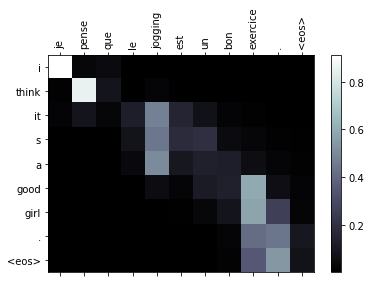

Input:['etes', 'vous', 'encore', 'endormi', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'still', 'sleepy', '?', '<eos>']
Output:['are', 'you', 'still', 'sleepy', '?', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 5700], [train loss 15.0865 +/- 11.9945], [epoch elapsed time 430.91]
--------------------------------------------------------------------


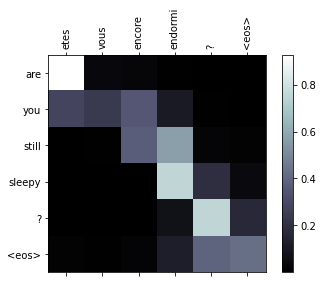

Input:['on', 'peut', 'se', 'fier', 'a', 'lui', '.', '<eos>']
Label:['<sos>', 'you', 'can', 'rely', 'on', 'him', '.', '<eos>']
Output:['you', 'can', 'make', 'to', 'him', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 6000], [train loss 15.2300 +/- 12.1638], [epoch elapsed time 453.60]
--------------------------------------------------------------------


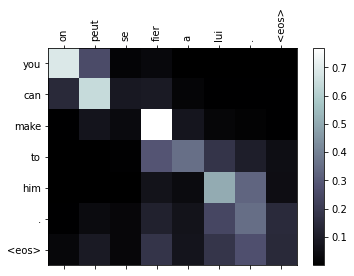

Input:['sois', 'attentif', '.', '<eos>']
Label:['<sos>', 'be', 'attentive', '.', '<eos>']
Output:['be', 'on', 'on', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 6300], [train loss 15.3598 +/- 12.2361], [epoch elapsed time 476.56]
--------------------------------------------------------------------


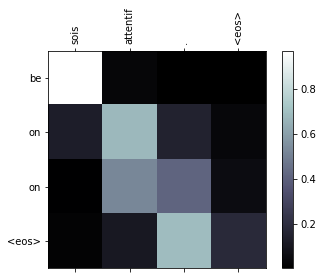

Input:['c', 'est', 'a', 'toi', 'de', 'chanter', '.', '<eos>']
Label:['<sos>', 'it', 's', 'your', 'turn', 'to', 'sing', '.', '<eos>']
Output:['it', 's', 'your', 'best', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 14 iter 6600], [train loss 15.4381 +/- 12.2670], [epoch elapsed time 498.76]
--------------------------------------------------------------------


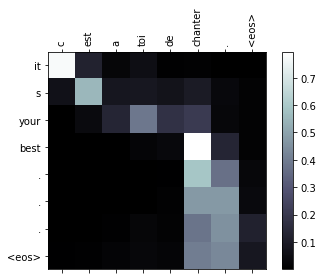

--------------------------------------------------------------------
[epoch 14], [train loss 15.4305 +/- 12.2476], [training time 502.97]
--------------------------------------------------------------------
********************************************************************
Input:['je', 'peux', 'lire', '.', '<eos>']
Label:['<sos>', 'i', 'can', 'read', '.', '<eos>']
Output:['i', 'can', 'read', '.', '<eos>']


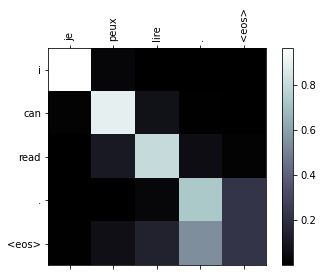

Input:['il', 'est', '<unk>', '.', '<eos>']
Label:['<sos>', 'he', 's', 'loaded', '.', '<eos>']
Output:['he', 's', 'out', '.', '<eos>']


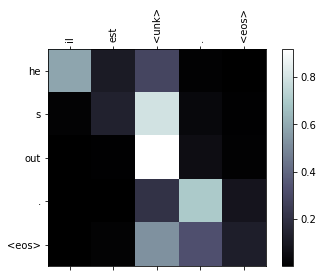

[epoch 14], [test loss 27.5640 +/- 17.6868], [testing time 2.10]
********************************************************************
Input:['j', 'aimerais', 'que', 'ma', 'copine', 'passe', 'davantage', 'de', 'temps', 'avec', 'moi', '.', '<eos>']
Label:['<sos>', 'i', 'wish', 'my', 'girlfriend', 'would', 'spend', 'more', 'time', 'with', 'me', '.', '<eos>']
Output:['i', 'wish', 'like', 'to', 'live', 'more', 'more', 'with', 'me', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 300], [train loss 12.8545 +/- 10.9213], [epoch elapsed time 22.27]
--------------------------------------------------------------------


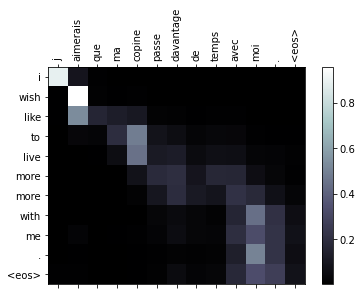

Input:['la', 'vie', 'n', 'est', 'elle', 'pas', 'simplement', 'formidable', '?', '<eos>']
Label:['<sos>', 'is', 'n t', 'life', 'just', 'great', '?', '<eos>']
Output:['is', 'n t', 'life', 'just', 'just', '?', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 600], [train loss 12.7907 +/- 10.7027], [epoch elapsed time 44.93]
--------------------------------------------------------------------


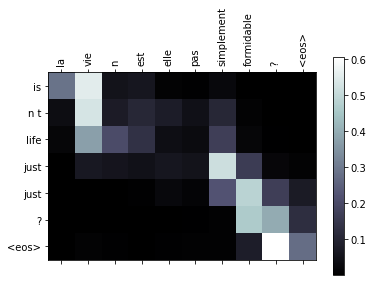

Input:['ils', 'ne', 'te', 'meprisent', 'pas', '.', '<eos>']
Label:['<sos>', 'they', 'do', 'n t', 'despise', 'you', '.', '<eos>']
Output:['they', 'do', 'n t', 'you', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 900], [train loss 12.8408 +/- 10.7098], [epoch elapsed time 67.34]
--------------------------------------------------------------------


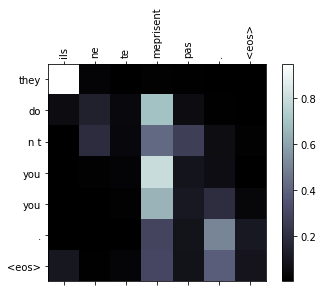

Input:['j', 'ai', 'entendu', 'cette', 'chanson', 'tellement', 'de', 'fois', 'a', 'la', 'radio', 'que', 'je', 'me', 'suis', 'mis', 'a', 'la', 'detester', '.', '<eos>']
Label:['<sos>', 'i', 'heard', 'that', 'song', 'so', 'many', 'times', 'on', 'the', 'radio', 'that', 'i', 'grew', 'to', 'hate', 'it', '.', '<eos>']
Output:['i', 'heard', 'that', 'song', 'so', 'times', 'times', 'i', 'i', 'i', 'i', 'i', 'was', 'to', 'her', 'it', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 1200], [train loss 12.8472 +/- 10.5627], [epoch elapsed time 89.61]
--------------------------------------------------------------------


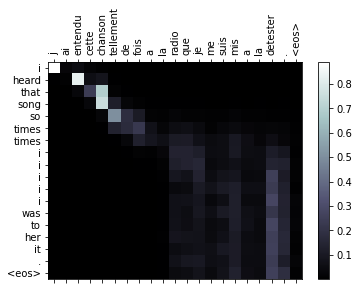

Input:['ils', 'vivent', 'a', 'l', 'etage', 'en', 'dessous', '.', '<eos>']
Label:['<sos>', 'they', 'live', 'on', 'the', 'floor', 'below', '.', '<eos>']
Output:['they', 'live', 'on', 'the', 'floor', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 1500], [train loss 13.1164 +/- 11.3016], [epoch elapsed time 112.92]
--------------------------------------------------------------------


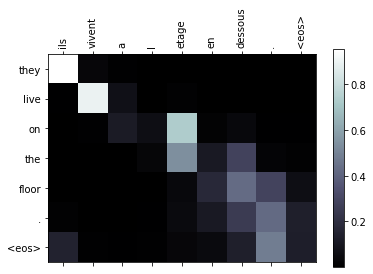

Input:['qui', 'en', 'a', 'eu', 'assez', '?', '<eos>']
Label:['<sos>', 'who', 's', 'had', 'enough', '?', '<eos>']
Output:['who', 'was', 'enough', 'enough', '?', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 1800], [train loss 13.1066 +/- 11.0419], [epoch elapsed time 135.60]
--------------------------------------------------------------------


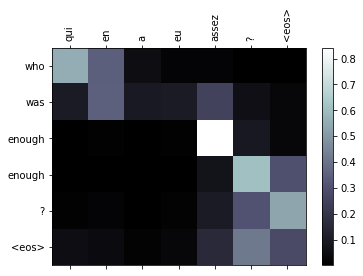

Input:['il', 'y', 'a', 'peu', 'de', 'contraintes', 'legale', 'concernant', 'la', 'vente', 'd', 'armes', 'aux', 'etats', 'unis', '.', '<eos>']
Label:['<sos>', 'there', 'are', 'few', 'legal', 'constraints', 'on', 'the', 'sale', 'of', 'firearms', 'in', 'the', 'u.s.', '<eos>']
Output:['there', 'are', 'a', 'few', 'on', 'the', 'the', 'the', 'the', 'the', 'the', 'in', 'the', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 2100], [train loss 13.2588 +/- 11.3391], [epoch elapsed time 159.35]
--------------------------------------------------------------------


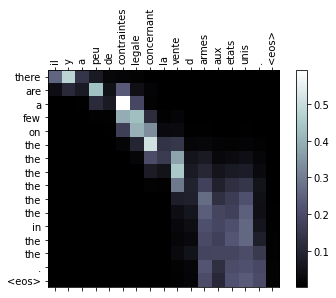

Input:['un', 'chien', 'l', 'a', 'mordue', 'a', 'la', 'jambe', '.', '<eos>']
Label:['<sos>', 'a', 'dog', 'bit', 'her', 'on', 'the', 'leg', '.', '<eos>']
Output:['a', 'dog', 'a', 'the', '.', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 2400], [train loss 13.4510 +/- 11.4476], [epoch elapsed time 182.91]
--------------------------------------------------------------------


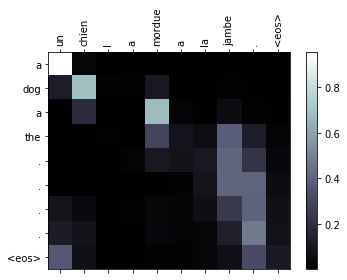

Input:['j', 'ai', 'quelques', 'amis', '.', '<eos>']
Label:['<sos>', 'i', 've', 'got', 'a', 'few', 'friends', '.', '<eos>']
Output:['i', 've', 'a', 'a', 'a', 'a', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 2700], [train loss 13.6275 +/- 11.6921], [epoch elapsed time 206.40]
--------------------------------------------------------------------


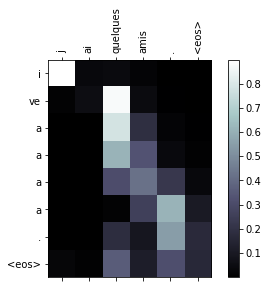

Input:['es', 'tu', 'd', 'accord', 'avec', 'cette', 'proposition', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'in', 'favor', 'of', 'this', 'motion', '?', '<eos>']
Output:['are', 'you', 'proud', 'your', 'of', 'this', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 3000], [train loss 13.7324 +/- 11.6953], [epoch elapsed time 230.04]
--------------------------------------------------------------------


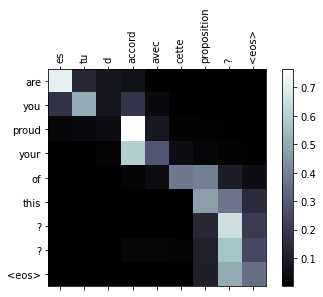

Input:['lis', 'le', 'message', 'encore', 'une', 'fois', '.', '<eos>']
Label:['<sos>', 'read', 'the', 'message', 'once', 'more', '.', '<eos>']
Output:['read', 'the', 'road', 'once', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 3300], [train loss 13.8129 +/- 11.6288], [epoch elapsed time 253.68]
--------------------------------------------------------------------


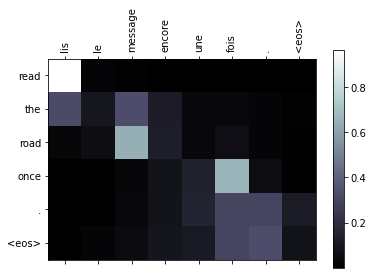

Input:['il', 'n', 'y', 'a', 'pas', 'de', 'retour', 'en', 'arriere', 'possible', '.', '<eos>']
Label:['<sos>', 'there', 's', 'no', 'turning', 'back', '.', '<eos>']
Output:['there', 'are', 'no', 'back', 'from', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 3600], [train loss 13.9213 +/- 11.6771], [epoch elapsed time 278.32]
--------------------------------------------------------------------


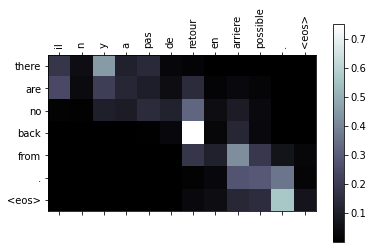

Input:['c', 'est', 'bon', 'd', 'etre', 'chez', 'soi', '.', '<eos>']
Label:['<sos>', 'it', 's', 'good', 'to', 'be', 'home', '.', '<eos>']
Output:['it', 's', 'good', 'to', 'home', 'home', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 3900], [train loss 13.9929 +/- 11.7033], [epoch elapsed time 301.38]
--------------------------------------------------------------------


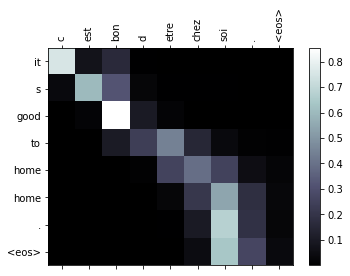

Input:['puis', 'je', 'venir', '?', '<eos>']
Label:['<sos>', 'can', 'i', 'come', '?', '<eos>']
Output:['can', 'i', 'come', '?', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 4200], [train loss 14.1074 +/- 11.7363], [epoch elapsed time 324.56]
--------------------------------------------------------------------


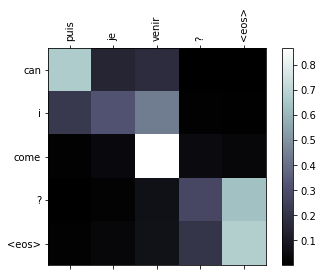

Input:['tom', 'est', 'mort', 'de', 'la', 'tuberculose', '.', '<eos>']
Label:['<sos>', 'tom', 'died', 'from', 'tuberculosis', '.', '<eos>']
Output:['tom', 'died', 'from', 'of', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 4500], [train loss 14.2318 +/- 11.7646], [epoch elapsed time 347.45]
--------------------------------------------------------------------


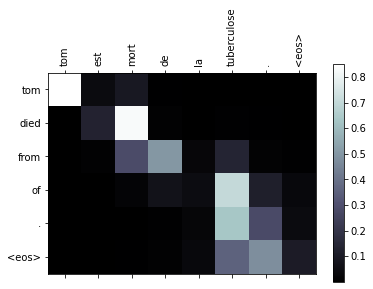

Input:['j', 'adore', 'jouer', 'au', 'golf', '.', '<eos>']
Label:['<sos>', 'i', 'love', 'to', 'play', 'golf', '.', '<eos>']
Output:['i', 'love', 'to', 'play', 'play', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 4800], [train loss 14.3981 +/- 11.9145], [epoch elapsed time 369.79]
--------------------------------------------------------------------


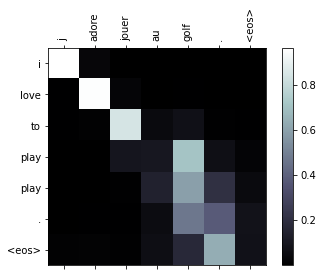

Input:['il', 'est', 'tombe', 'en', 'amour', 'avec', 'moi', '.', '<eos>']
Label:['<sos>', 'he', 'has', 'fallen', 'in', 'love', 'with', 'me', '.', '<eos>']
Output:['he', 'has', 'in', 'in', 'my', 'with', 'me', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 5100], [train loss 14.4673 +/- 11.9256], [epoch elapsed time 391.75]
--------------------------------------------------------------------


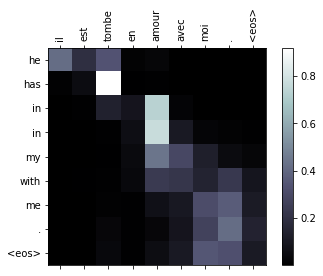

Input:['je', 'vous', 'ai', 'dit', 'de', 'vous', 'tenir', 'a', 'l', 'ecart', 'de', 'ma', 'fille', '.', '<eos>']
Label:['<sos>', 'i', 'told', 'you', 'to', 'stay', 'away', 'from', 'my', 'daughter', '.', '<eos>']
Output:['i', 'told', 'you', 'to', 'stay', 'from', 'from', 'my', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 5400], [train loss 14.6893 +/- 12.0463], [epoch elapsed time 414.82]
--------------------------------------------------------------------


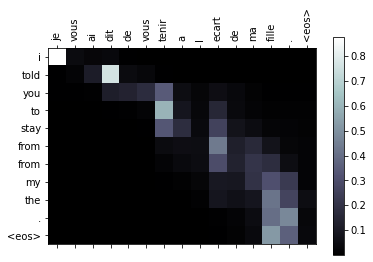

Input:['je', 'n', 'ai', 'pas', 'besoin', 'de', 'plus', 'de', 'conseils', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'need', 'more', 'advice', '.', '<eos>']
Output:['i', 'do', 'n t', 'need', 'to', 'make', 'some', 'more', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 5700], [train loss 14.7285 +/- 12.0081], [epoch elapsed time 437.21]
--------------------------------------------------------------------


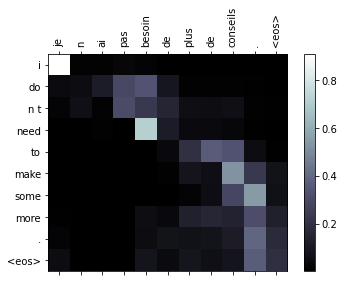

Input:['c', 'est', 'exactement', 'ce', 'que', 'je', 'veux', '.', '<eos>']
Label:['<sos>', 'that', 's', 'exactly', 'what', 'i', 'want', '.', '<eos>']
Output:['that', 's', 'exactly', 'what', 'i', 'want', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 6000], [train loss 14.7694 +/- 12.0621], [epoch elapsed time 459.55]
--------------------------------------------------------------------


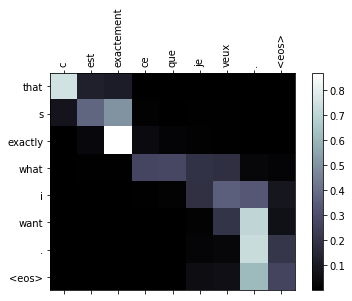

Input:['pourriez', 'vous', 'me', 'dire', 'ou', 'se', 'trouve', 'l', 'eglise', 'la', 'plus', 'proche', '?', '<eos>']
Label:['<sos>', 'could', 'you', 'please', 'tell', 'me', 'where', 'the', 'nearest', 'church', 'is', '?', '<eos>']
Output:['would', 'you', 'tell', 'tell', 'me', 'where', 'the', 'the', '?', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 6300], [train loss 14.8908 +/- 12.1413], [epoch elapsed time 482.39]
--------------------------------------------------------------------


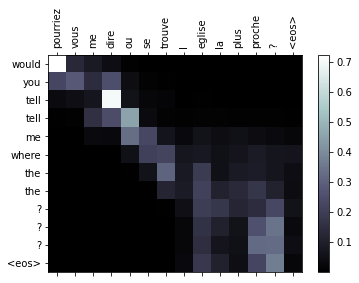

Input:['certains', 'vont', 'a', 'l', 'ecole', 'a', 'bicyclette', 'd', 'autres', 'en', 'bus', '.', '<eos>']
Label:['<sos>', 'some', 'go', 'to', 'school', 'by', 'bicycle', 'others', 'go', 'by', 'bus', '.', '<eos>']
Output:['some', 'go', 'to', 'school', 'to', 'the', 'bus', '.', '<eos>']
--------------------------------------------------------------------
[epoch 15 iter 6600], [train loss 15.0176 +/- 12.1558], [epoch elapsed time 505.41]
--------------------------------------------------------------------


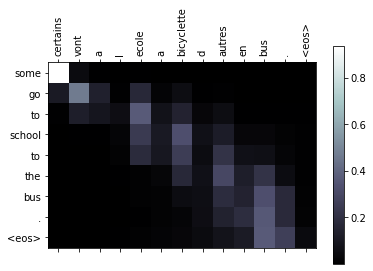

--------------------------------------------------------------------
[epoch 15], [train loss 15.0743 +/- 12.2296], [training time 509.99]
--------------------------------------------------------------------
********************************************************************
Input:['il', 'est', 'alle', 'aux', 'etats', 'unis', 'pour', 'etudier', 'la', 'litterature', '<unk>', '.', '<eos>']
Label:['<sos>', 'he', 'went', 'to', 'america', 'for', 'the', 'purpose', 'of', 'studying', 'american', 'literature', '.', '<eos>']
Output:['he', 'went', 'in', 'the', 'united', 'for', 'to', '.', '.', '<eos>']


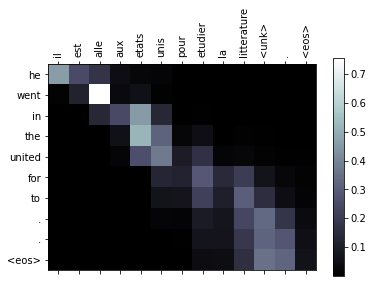

Input:['quel', 'est', 'le', '<unk>', 'que', 'vous', 'aimez', 'le', 'plus', 'regarder', '?', '<eos>']
Label:['<sos>', 'what', 's', 'your', 'favorite', '<unk>', '<unk>', '?', '<eos>']
Output:['what', 's', 'the', 'the', 'of', 'you', 'the', 'the', '<eos>']


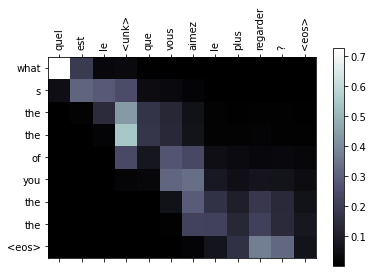

[epoch 15], [test loss 27.1469 +/- 16.8809], [testing time 2.17]
********************************************************************
Input:['il', 'est', 'etudiant', 'a', 'harvard', '.', '<eos>']
Label:['<sos>', 'he', 'is', 'a', 'student', 'at', 'harvard', '.', '<eos>']
Output:['he', 's', 'a', 'student', 'at', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 300], [train loss 12.0514 +/- 9.8544], [epoch elapsed time 21.83]
--------------------------------------------------------------------


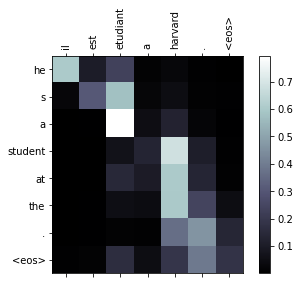

Input:['nous', 'savons', 'que', 'vous', 'etes', 'interessees', '.', '<eos>']
Label:['<sos>', 'we', 'know', 'you', 're', 'interested', '.', '<eos>']
Output:['we', 're', 'glad', 'you', 're', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 600], [train loss 12.1775 +/- 10.2442], [epoch elapsed time 43.75]
--------------------------------------------------------------------


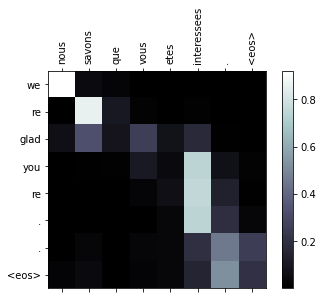

Input:['j', 'aimerais', 'vous', 'poser', 'quelques', 'questions', '.', '<eos>']
Label:['<sos>', 'i', 'd', 'like', 'to', 'ask', 'you', 'a', 'couple', 'of', 'questions', '.', '<eos>']
Output:['i', 'd', 'like', 'to', 'ask', 'you', 'a', 'few', 'questions', 'questions', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 900], [train loss 12.1589 +/- 10.1430], [epoch elapsed time 65.80]
--------------------------------------------------------------------


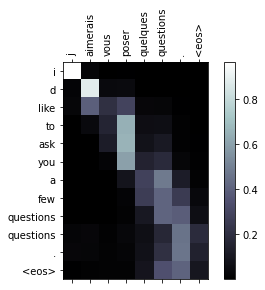

Input:['nous', 'sommes', 'en', 'train', 'de', 'divorcer', '.', '<eos>']
Label:['<sos>', 'we', 're', 'getting', 'divorced', '.', '<eos>']
Output:['we', 're', 'getting', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 1200], [train loss 12.1554 +/- 10.3630], [epoch elapsed time 87.84]
--------------------------------------------------------------------


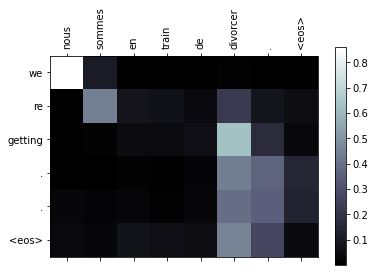

Input:['elle', 'porte', 'un', 'manteau', 'ample', '.', '<eos>']
Label:['<sos>', 'she', 's', 'wearing', 'a', 'loose', 'coat', '.', '<eos>']
Output:['she', 'is', 'a', 'a', 'coat', 'coat', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 1500], [train loss 12.1822 +/- 10.4561], [epoch elapsed time 109.71]
--------------------------------------------------------------------


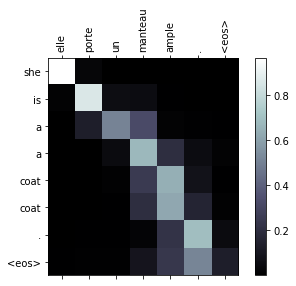

Input:['pensez', 'vous', 'que', 'ce', 'plan', 'est', 'irrealiste', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'think', 'this', 'plan', 'is', 'unrealistic', '?', '<eos>']
Output:['do', 'you', 'think', 'it', 'plan', 'to', 'happen', '?', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 1800], [train loss 12.5860 +/- 10.9332], [epoch elapsed time 133.57]
--------------------------------------------------------------------


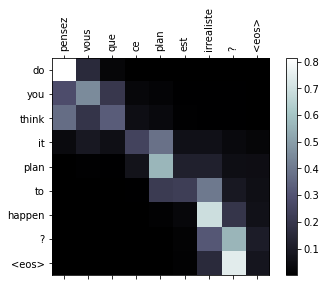

Input:['je', 'vais', 'en', 'europe', 'la', 'semaine', 'prochaine', '.', '<eos>']
Label:['<sos>', 'i', 'am', 'going', 'to', 'europe', 'next', 'week', '.', '<eos>']
Output:['i', 'am', 'going', 'to', 'the', 'next', 'week', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 2100], [train loss 12.8851 +/- 11.1173], [epoch elapsed time 156.44]
--------------------------------------------------------------------


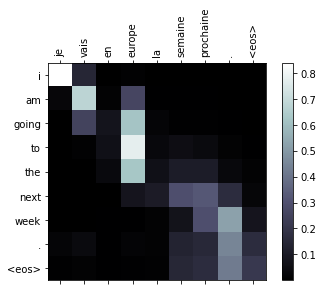

Input:['j', 'ai', 'vecu', 'une', 'experience', 'extra corporelle', '.', '<eos>']
Label:['<sos>', 'i', 'had', 'an', 'out', 'of', 'body', 'experience', '.', '<eos>']
Output:['i', 'had', 'a', 'sudden', 'of', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 2400], [train loss 13.0860 +/- 11.2316], [epoch elapsed time 179.32]
--------------------------------------------------------------------


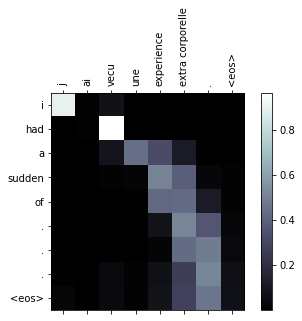

Input:['je', 'ne', 'suis', 'pas', 'sure', 'd', 'etre', 'd', 'accord', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'not', 'sure', 'i', 'agree', '.', '<eos>']
Output:['i', 'm', 'not', 'sure', 'of', 'i', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 2700], [train loss 13.3697 +/- 11.4788], [epoch elapsed time 201.70]
--------------------------------------------------------------------


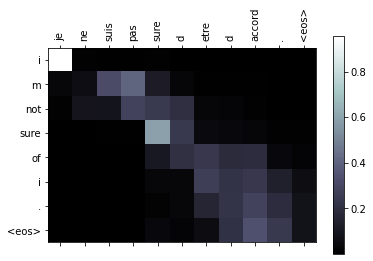

Input:['c', 'est', 'plus', 'facile', 'que', 'ca', 'n', 'en', 'a', 'l', 'air', '.', '<eos>']
Label:['<sos>', 'it', 's', 'easier', 'than', 'it', 'sounds', '.', '<eos>']
Output:['it', 's', 'the', 'so', 'it', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 3000], [train loss 13.5639 +/- 11.5940], [epoch elapsed time 224.50]
--------------------------------------------------------------------


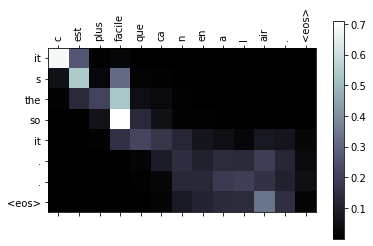

Input:['ca', 'a', 'ete', 'une', 'journee', 'horrible', '.', '<eos>']
Label:['<sos>', 'it', 's', 'been', 'a', 'terrible', 'day', '.', '<eos>']
Output:['it', 's', 'been', 'a', 'day', 'day', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 3300], [train loss 13.7396 +/- 11.6272], [epoch elapsed time 246.94]
--------------------------------------------------------------------


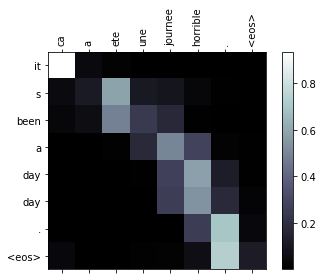

Input:['je', 'suis', 'americaine', '.', '<eos>']
Label:['<sos>', 'i', 'am', 'an', 'american', '.', '<eos>']
Output:['i', 'am', 'an', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 3600], [train loss 13.9369 +/- 11.9824], [epoch elapsed time 269.89]
--------------------------------------------------------------------


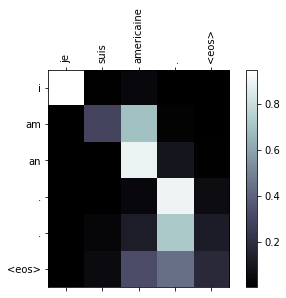

Input:['il', 'a', 'peur', 'de', 'la', 'mer', '.', '<eos>']
Label:['<sos>', 'he', 's', 'afraid', 'of', 'the', 'sea', '.', '<eos>']
Output:['he', 's', 'afraid', 'of', 'the', 'sea', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 3900], [train loss 13.9511 +/- 11.9506], [epoch elapsed time 292.48]
--------------------------------------------------------------------


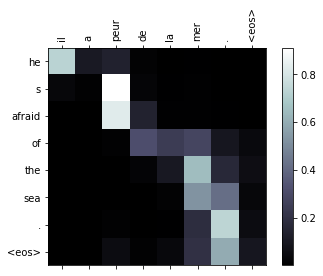

Input:['elle', 'me', 'reproche', 'le', 'fait', 'que', 'notre', 'vie', 'maritale', 'n', 'aille', 'pas', 'bien', '.', '<eos>']
Label:['<sos>', 'she', 'blames', 'me', 'for', 'the', 'fact', 'that', 'our', 'married', 'life', 'is', 'n t', 'going', 'well', '.', '<eos>']
Output:['she', 'looked', 'me', 'of', 'that', 'our', 'life', 'life', 'to', 'not', 'life', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 4200], [train loss 14.0979 +/- 11.9756], [epoch elapsed time 315.37]
--------------------------------------------------------------------


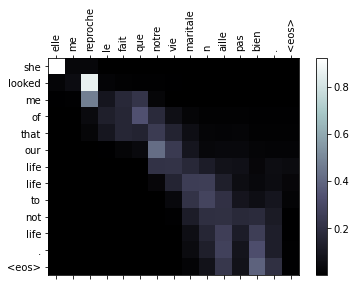

Input:['on', 'trouve', 'des', 'touristes', 'japonais', 'partout', '.', '<eos>']
Label:['<sos>', 'you', 'run', 'into', 'japanese', 'tourists', 'everywhere', '.', '<eos>']
Output:['you', 'can', 'take', 'in', 'japan', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 4500], [train loss 14.1363 +/- 11.9790], [epoch elapsed time 337.58]
--------------------------------------------------------------------


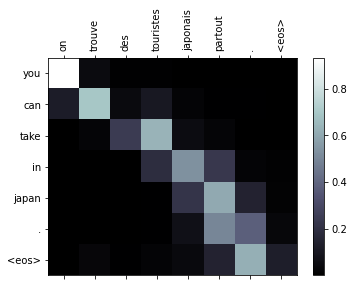

Input:['je', 'pense', 'que', 'vous', 'vous', 'etes', 'paniquee', '.', '<eos>']
Label:['<sos>', 'i', 'think', 'you', 'panicked', '.', '<eos>']
Output:['i', 'think', 'you', 're', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 4800], [train loss 14.2312 +/- 12.0022], [epoch elapsed time 359.70]
--------------------------------------------------------------------


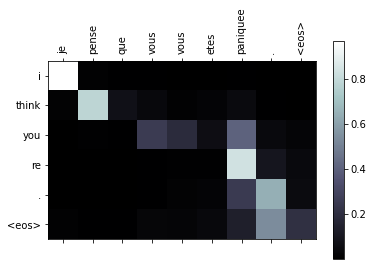

Input:['j', 'irai', 'a', 'pied', 'ou', 'en', 'velo', 'la', 'prochaine', 'fois', '.', '<eos>']
Label:['<sos>', 'i', 'will', 'go', 'there', 'on', 'foot', 'or', 'by', 'bicycle', 'next', 'time', '.', '<eos>']
Output:['i', 'll', 'be', 'in', 'in', 'in', 'in', 'the', 'time', 'time', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 5100], [train loss 14.3552 +/- 12.0703], [epoch elapsed time 382.19]
--------------------------------------------------------------------


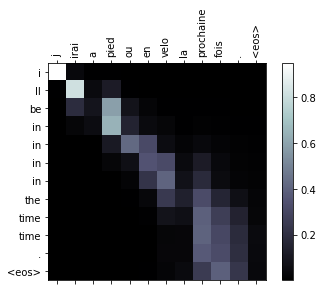

Input:['un', 'lapsus', 'est', 'parfois', 'fatal', 'pour', 'les', 'politiciens', '.', '<eos>']
Label:['<sos>', 'a', 'slip', 'of', 'the', 'tongue', 'is', 'sometimes', 'fatal', 'to', 'a', 'politician', '.', '<eos>']
Output:['a', 'of', 'is', 'the', 'only', 'is', 'to', 'to', '.', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 5400], [train loss 14.4684 +/- 12.1252], [epoch elapsed time 404.96]
--------------------------------------------------------------------


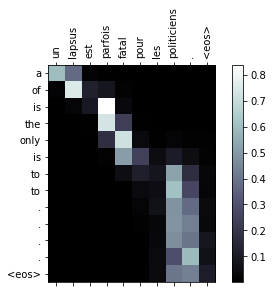

Input:['je', 'ne', 'sais', 'pas', 'si', 'je', 'dois', 'accepter', 'ou', 'refuser', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'know', 'whether', 'to', 'accept', 'or', 'refuse', '.', '<eos>']
Output:['i', 'do', 'n t', 'know', 'if', 'i', 'have', 'to', 'see', 'a', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 5700], [train loss 14.5587 +/- 12.1399], [epoch elapsed time 427.66]
--------------------------------------------------------------------


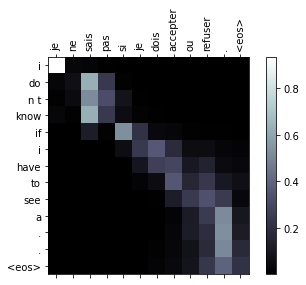

Input:['le', 'mauvais', 'temps', 'nous', 'empecha', 'de', 'partir', '.', '<eos>']
Label:['<sos>', 'bad', 'weather', 'prevented', 'us', 'from', 'departing', '.', '<eos>']
Output:['it', 'for', 'for', 'to', 'to', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 6000], [train loss 14.6638 +/- 12.1629], [epoch elapsed time 449.76]
--------------------------------------------------------------------


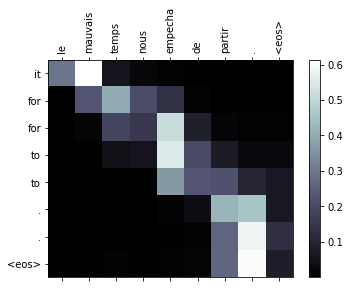

Input:['je', 'pourrai', 'faire', 'du', 'cheval', 'dimanche', 'prochain', '?', '<eos>']
Label:['<sos>', 'can', 'i', 'go', 'horseback', 'riding', 'next', 'sunday', '?', '<eos>']
Output:['i', 'i', 'could', 'a', 'a', 'next', 'sunday', '?', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 6300], [train loss 14.7292 +/- 12.1910], [epoch elapsed time 472.11]
--------------------------------------------------------------------


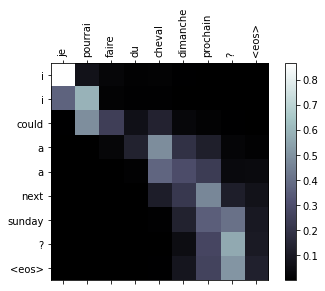

Input:['tom', 'sortit', 'pour', 'fumer', 'une', 'cigarette', '.', '<eos>']
Label:['<sos>', 'tom', 'went', 'outside', 'to', 'smoke', 'a', 'cigarette', '.', '<eos>']
Output:['tom', 'ran', 'out', 'for', 'a', 'a', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 16 iter 6600], [train loss 14.7820 +/- 12.1620], [epoch elapsed time 493.92]
--------------------------------------------------------------------


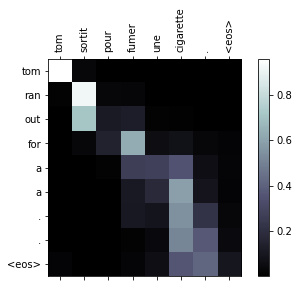

--------------------------------------------------------------------
[epoch 16], [train loss 14.7923 +/- 12.1760], [training time 498.18]
--------------------------------------------------------------------
********************************************************************
Input:['dis', 'bonjour', '.', '<eos>']
Label:['<sos>', 'say', 'hello', '.', '<eos>']
Output:['tell', 'on', '.', '<eos>']


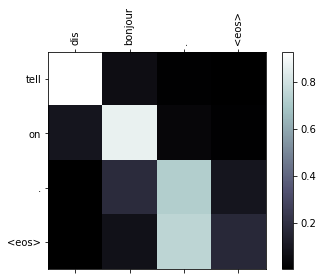

Input:['je', 'ne', 'peux', 'marcher', 'plus', 'loin', '.', '<eos>']
Label:['<sos>', 'i', 'can', 'walk', 'no', '<unk>', '.', '<eos>']
Output:['i', 'ca', 'n t', 'wait', 'without', '.', '<eos>']


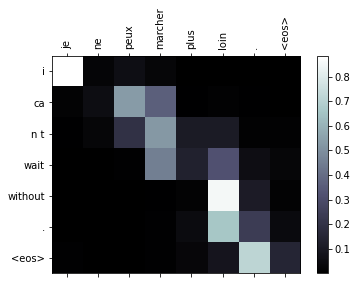

[epoch 16], [test loss 28.6989 +/- 19.8018], [testing time 2.20]
********************************************************************
Input:['arrete', 'de', 'te', 'conduire', 'comme', 'une', 'enfant', '!', '<eos>']
Label:['<sos>', 'quit', 'behaving', 'like', 'a', 'kid', '.', '<eos>']
Output:['stop', 'crying', 'like', 'a', 'child', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 300], [train loss 11.7692 +/- 10.4361], [epoch elapsed time 21.26]
--------------------------------------------------------------------


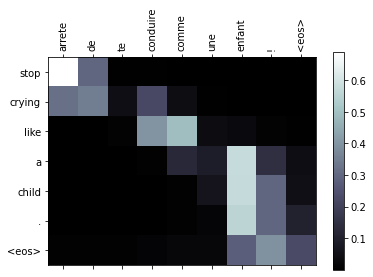

Input:['c', 'est', 'vendu', 'en', 'quincaillerie', '.', '<eos>']
Label:['<sos>', 'that', 'is', 'sold', 'at', 'hardware', 'stores', '.', '<eos>']
Output:['that', 's', 'a', 'at', 'getting', '.', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 600], [train loss 11.6459 +/- 9.9313], [epoch elapsed time 42.74]
--------------------------------------------------------------------


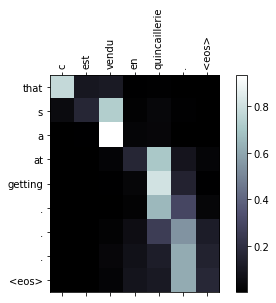

Input:['je', 'devais', 'le', 'faire', 'aujourd hui', '.', '<eos>']
Label:['<sos>', 'i', 'had', 'to', 'do', 'this', 'today', '.', '<eos>']
Output:['i', 'had', 'to', 'do', 'it', 'for', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 900], [train loss 12.0252 +/- 10.5663], [epoch elapsed time 64.67]
--------------------------------------------------------------------


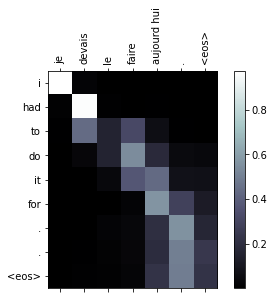

Input:['il', 'y', 'a', 'des', 'restes', 'dans', 'le', 'refrigerateur', '.', '<eos>']
Label:['<sos>', 'there', 's', 'some', 'leftover', 'food', 'in', 'the', 'fridge', '.', '<eos>']
Output:['there', 's', 'some', 'in', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 1200], [train loss 12.3464 +/- 10.7850], [epoch elapsed time 86.58]
--------------------------------------------------------------------


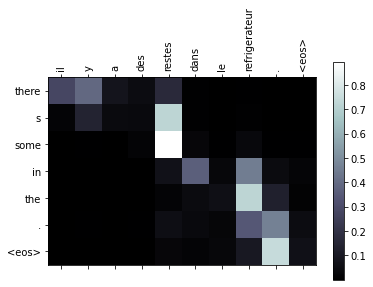

Input:['j', 'ai', 'de', 'bien', 'tristes', 'nouvelles', '.', '<eos>']
Label:['<sos>', 'i', 'have', 'some', 'very', 'sad', 'news', '.', '<eos>']
Output:['i', 'have', 'a', 'very', 'news', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 1500], [train loss 12.7285 +/- 10.8105], [epoch elapsed time 108.80]
--------------------------------------------------------------------


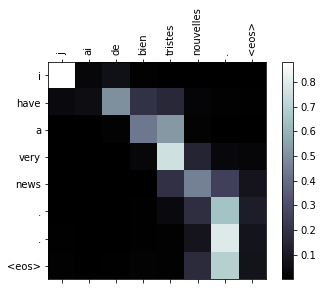

Input:['il', 'jugea', 'impossible', 'de', 's', 'y', 'rendre', 'a', 'pied', '.', '<eos>']
Label:['<sos>', 'he', 'found', 'it', 'impossible', 'to', 'go', 'there', 'on', 'foot', '.', '<eos>']
Output:['he', 'found', 'it', 'for', 'to', 'go', 'on', 'foot', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 1800], [train loss 12.9446 +/- 11.1710], [epoch elapsed time 131.28]
--------------------------------------------------------------------


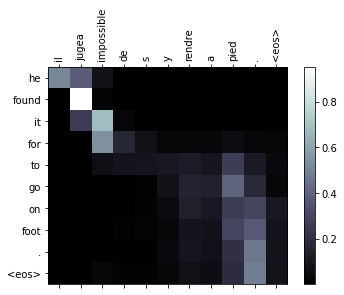

Input:['vous', 'ne', 'm', 'avez', 'jamais', 'dit', 'cela', '.', '<eos>']
Label:['<sos>', 'you', 'never', 'told', 'me', 'that', '.', '<eos>']
Output:['you', 'never', 'told', 'me', 'that', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 2100], [train loss 13.1573 +/- 11.4382], [epoch elapsed time 153.06]
--------------------------------------------------------------------


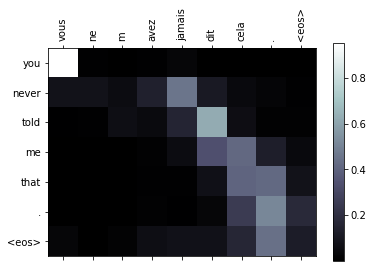

Input:['ses', 'passe temps', 'sont', 'de', 'jouer', 'de', 'la', 'guitare', 'et', 'de', 'chanter', '.', '<eos>']
Label:['<sos>', 'his', 'hobbies', 'are', 'playing', 'the', 'guitar', 'and', 'singing', '.', '<eos>']
Output:['his', 'glasses', 'are', 'playing', 'the', 'and', 's', 'singing', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 2400], [train loss 13.1524 +/- 11.3228], [epoch elapsed time 175.14]
--------------------------------------------------------------------


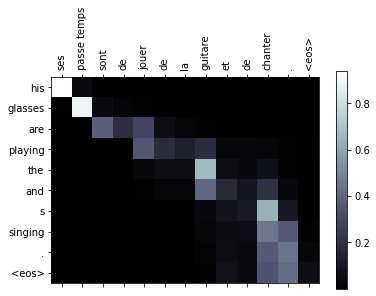

Input:['noue', 'ta', 'chaussure', '.', '<eos>']
Label:['<sos>', 'tie', 'your', 'shoe', '.', '<eos>']
Output:['bring', 'your', 'move', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 2700], [train loss 13.2556 +/- 11.3302], [epoch elapsed time 197.02]
--------------------------------------------------------------------


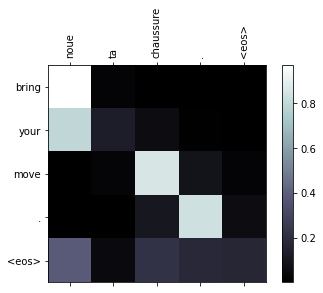

Input:['prends', 'celui', 'que', 'tu', 'preferes', '.', '<eos>']
Label:['<sos>', 'take', 'whichever', 'you', 'like', 'best', '.', '<eos>']
Output:['take', 'that', 'you', 'like', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 3000], [train loss 13.3093 +/- 11.2351], [epoch elapsed time 219.01]
--------------------------------------------------------------------


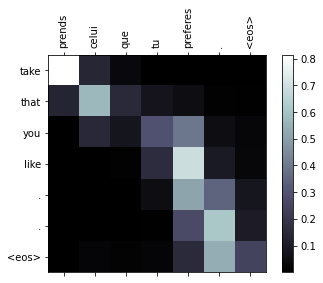

Input:['ce', 'n', 'est', 'pas', 'pour', 'tom', '.', '<eos>']
Label:['<sos>', 'that', 's', 'not', 'for', 'tom', '.', '<eos>']
Output:['that', 's', 'not', 'for', 'tom', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 3300], [train loss 13.4754 +/- 11.2921], [epoch elapsed time 241.23]
--------------------------------------------------------------------


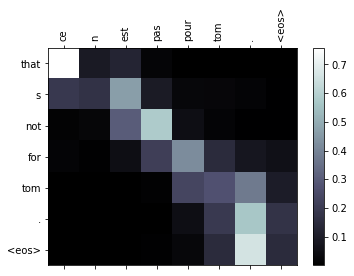

Input:['vous', 'etes', 'un', 'grand', 'malade', '.', '<eos>']
Label:['<sos>', 'you', 'are', 'seriously', 'ill', '.', '<eos>']
Output:['you', 're', 'a', 'big', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 3600], [train loss 13.6416 +/- 11.3663], [epoch elapsed time 263.35]
--------------------------------------------------------------------


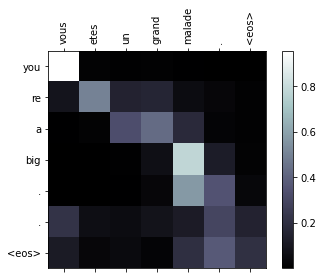

Input:['je', 'vais', 'a', 'hiroshima', 'trois', 'fois', 'par', 'mois', '.', '<eos>']
Label:['<sos>', 'i', 'go', 'to', 'hiroshima', 'three', 'times', 'a', 'month', '.', '<eos>']
Output:['i', 'am', 'going', 'three', 'three', 'month', '.', 'month', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 3900], [train loss 13.8110 +/- 11.4962], [epoch elapsed time 285.97]
--------------------------------------------------------------------


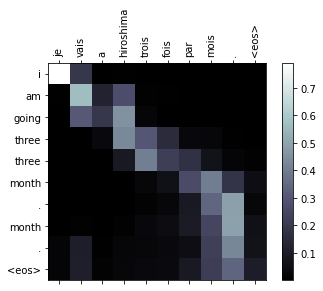

Input:['que', 'veulent', 'dire', 'ces', 'lumieres', '?', '<eos>']
Label:['<sos>', 'what', 'do', 'those', 'lights', 'signify', '?', '<eos>']
Output:['what', 'are', 'these', '?', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 4200], [train loss 13.9042 +/- 11.5495], [epoch elapsed time 307.83]
--------------------------------------------------------------------


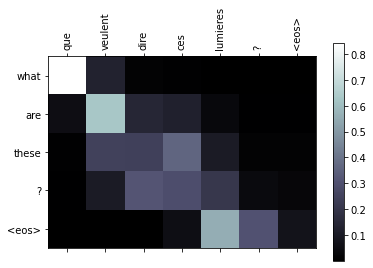

Input:['je', 'paye', 'euros', 'chaque', 'fois', 'que', 'je', 'vais', 'chez', 'le', 'dentiste', '.', '<eos>']
Label:['<sos>', 'i', 'pay', 'euros', 'for', 'every', 'visit', 'to', 'the', 'dentist', '.', '<eos>']
Output:['i', 'went', 'to', 'every', 'll', 'other', 'the', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 4500], [train loss 13.9706 +/- 11.6334], [epoch elapsed time 329.80]
--------------------------------------------------------------------


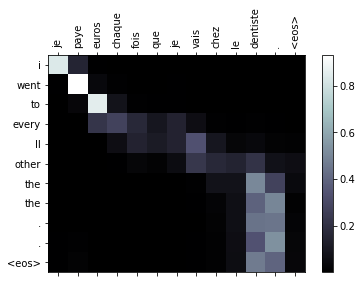

Input:['je', 'veux', 'que', 'vous', 'ouvriez', 'la', 'fenetre', '.', '<eos>']
Label:['<sos>', 'i', 'want', 'you', 'to', 'open', 'the', 'window', '.', '<eos>']
Output:['i', 'want', 'you', 'to', 'open', 'the', 'window', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 4800], [train loss 14.0510 +/- 11.6476], [epoch elapsed time 351.68]
--------------------------------------------------------------------


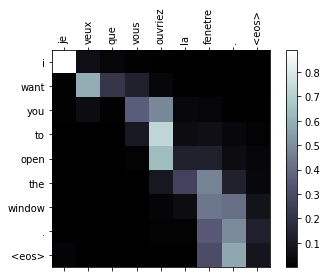

Input:['personne', 'n', 'etait', 'en', 'retard', '.', '<eos>']
Label:['<sos>', 'no', 'one', 'was', 'late', '.', '<eos>']
Output:['no', 'one', 'was', 'late', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 5100], [train loss 14.2357 +/- 11.8184], [epoch elapsed time 373.77]
--------------------------------------------------------------------


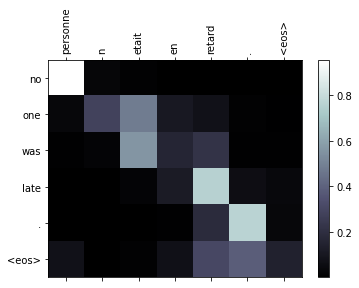

Input:['je', 'pensais', 'ce', 'que', 'j', 'ai', 'dit', '.', '<eos>']
Label:['<sos>', 'i', 'meant', 'what', 'i', 'said', '.', '<eos>']
Output:['i', 'thought', 'what', 'i', 'said', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 5400], [train loss 14.2277 +/- 11.7687], [epoch elapsed time 395.18]
--------------------------------------------------------------------


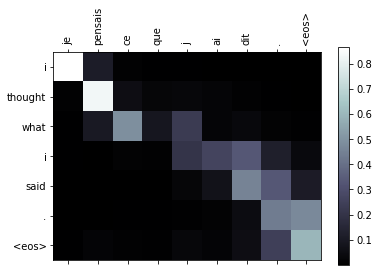

Input:['elle', 'connaissait', 'l', 'adolescente', '.', '<eos>']
Label:['<sos>', 'she', 'knew', 'the', 'teen', '.', '<eos>']
Output:['she', 'knew', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 5700], [train loss 14.3362 +/- 11.8201], [epoch elapsed time 416.82]
--------------------------------------------------------------------


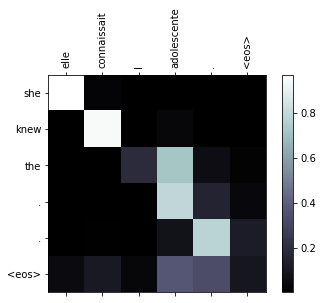

Input:['elle', 'trouva', 'une', 'excuse', 'pour', 'etre', 'en', 'retard', '.', '<eos>']
Label:['<sos>', 'she', 'made', 'an', 'excuse', 'for', 'being', 'late', '.', '<eos>']
Output:['she', 'made', 'an', 'excellent', 'for', 'being', 'late', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 6000], [train loss 14.4304 +/- 11.8287], [epoch elapsed time 438.56]
--------------------------------------------------------------------


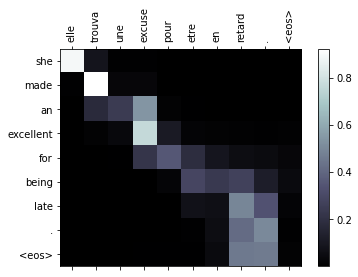

Input:['j', 'ai', 'oublie', 'ma', 'clef', 'de', 'chambre', '.', '<eos>']
Label:['<sos>', 'i', 'forgot', 'the', 'key', 'to', 'my', 'room', '.', '<eos>']
Output:['i', 'my', 'my', 'room', 'from', 'room', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 6300], [train loss 14.4823 +/- 11.8158], [epoch elapsed time 460.43]
--------------------------------------------------------------------


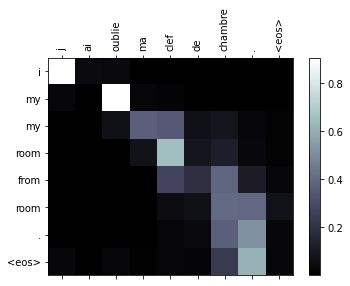

Input:['j', 'espere', 'voir', 'des', 'rennes', 'lors', 'de', 'mon', 'voyage', 'en', 'suede', '.', '<eos>']
Label:['<sos>', 'i', 'hope', 'to', 'see', 'reindeer', 'on', 'my', 'trip', 'to', 'sweden', '.', '<eos>']
Output:['i', 'hope', 'i', 'see', 'my', 'of', 'my', 'house', '.', 'my', '.', '<eos>']
--------------------------------------------------------------------
[epoch 17 iter 6600], [train loss 14.6298 +/- 11.9246], [epoch elapsed time 482.29]
--------------------------------------------------------------------


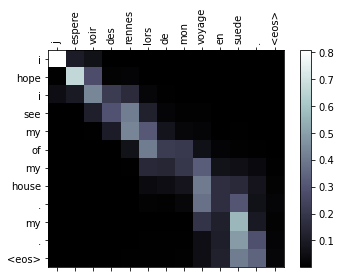

--------------------------------------------------------------------
[epoch 17], [train loss 14.6249 +/- 11.9087], [training time 486.44]
--------------------------------------------------------------------
********************************************************************
Input:['tout', 'd', 'abord', 'je', 'dois', 'dire', 'ceci', '.', '<eos>']
Label:['<sos>', 'first', 'of', 'all', 'i', 'must', 'say', 'this', '.', '<eos>']
Output:['everyone', 'i', 'have', 'to', 'to', 'this', '.', '.', '<eos>']


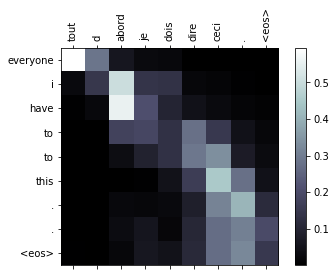

Input:['je', 'ne', 'sais', 'pas', 'de', 'quoi', 'vous', 'vous', 'plaignez', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'know', 'what', 'you', 're', 'complaining', 'about', '.', '<eos>']
Output:['i', 'do', 'n t', 'know', 'what', 'you', 'you', 'you', 'you', '.', '<eos>']


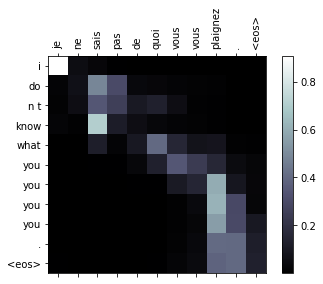

[epoch 17], [test loss 29.1954 +/- 17.7662], [testing time 2.15]
********************************************************************
Input:['je', 'cherche', 'des', 'piles', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'looking', 'for', 'batteries', '.', '<eos>']
Output:['i', 'am', 'looking', 'for', 'an', 'hour', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 300], [train loss 12.4033 +/- 11.8386], [epoch elapsed time 21.57]
--------------------------------------------------------------------


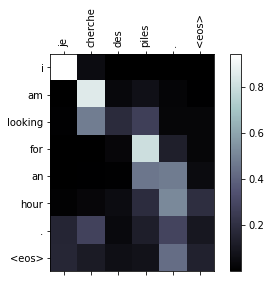

Input:['je', 'veux', 'deposer', 'de', 'l', 'argent', '.', '<eos>']
Label:['<sos>', 'i', 'want', 'to', 'deposit', 'some', 'money', '.', '<eos>']
Output:['i', 'want', 'to', 'choose', 'some', 'money', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 600], [train loss 12.3675 +/- 11.4939], [epoch elapsed time 43.49]
--------------------------------------------------------------------


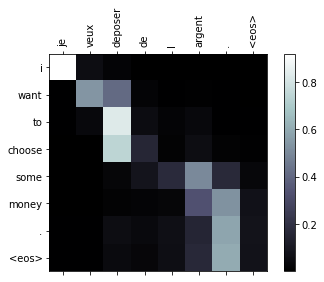

Input:['tu', 'te', 'sens', 'bien', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'feeling', 'ok', '?', '<eos>']
Output:['are', 'you', 'feeling', 'what', '?', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 900], [train loss 12.5392 +/- 11.0855], [epoch elapsed time 65.05]
--------------------------------------------------------------------


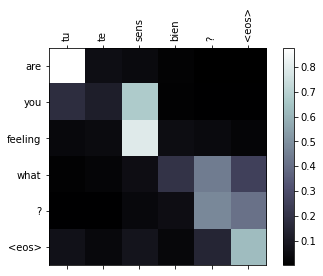

Input:['je', 'ne', 'pense', 'pas', 'qu', 'ils', 'nous', 'ont', 'entendues', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'think', 'they', 'heard', 'us', '.', '<eos>']
Output:['i', 'do', 'n t', 'think', 'they', 'heard', 'us', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 1200], [train loss 12.8031 +/- 11.1047], [epoch elapsed time 86.90]
--------------------------------------------------------------------


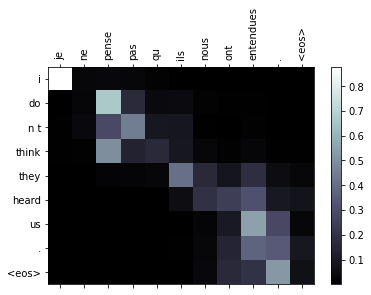

Input:['quelque', 'chose', 'de', 'tres', 'etrange', 'm', 'est', 'arrive', 'hier', '.', '<eos>']
Label:['<sos>', 'something', 'very', 'weird', 'happened', 'to', 'me', 'yesterday', '.', '<eos>']
Output:['something', 'very', 'hard', 'happened', 'to', 'yesterday', 'yesterday', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 1500], [train loss 12.7570 +/- 11.0589], [epoch elapsed time 109.20]
--------------------------------------------------------------------


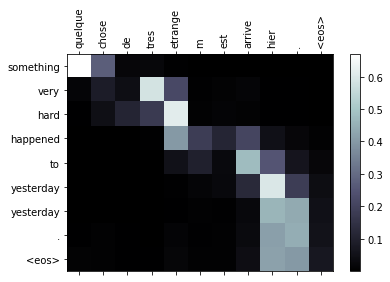

Input:['quelqu', 'un', 'peut', 'il', 'm', 'aider', '?', '<eos>']
Label:['<sos>', 'can', 'somebody', 'help', 'me', '?', '<eos>']
Output:['can', 'somebody', 'help', 'me', '?', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 1800], [train loss 12.8179 +/- 11.0818], [epoch elapsed time 130.71]
--------------------------------------------------------------------


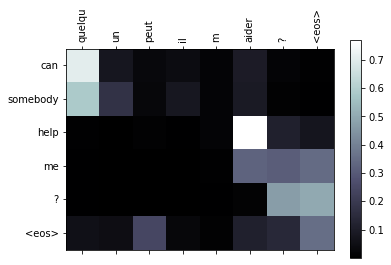

Input:['je', 'pense', 'que', 'nous', 'sommes', 'deja', 'trop', 'en', 'retard', '.', '<eos>']
Label:['<sos>', 'i', 'think', 'we', 're', 'already', 'too', 'late', '.', '<eos>']
Output:['i', 'think', 'we', 're', 'already', 'too', 'late', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 2100], [train loss 12.9861 +/- 11.2379], [epoch elapsed time 152.69]
--------------------------------------------------------------------


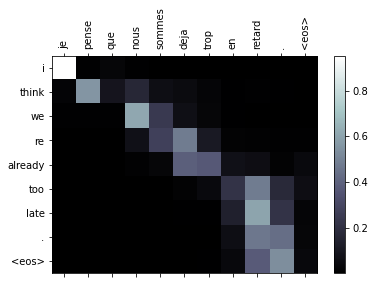

Input:['il', 'n', 'a', 'pas', 'voulu', 'le', 'faire', '.', '<eos>']
Label:['<sos>', 'he', 'did', 'n t', 'want', 'to', 'do', 'it', '.', '<eos>']
Output:['he', 'did', 'n t', 'want', 'to', 'do', 'it', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 2400], [train loss 13.0873 +/- 11.2140], [epoch elapsed time 174.22]
--------------------------------------------------------------------


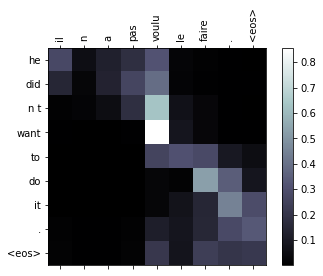

Input:['ma', 'mere', 'aime', 'beaucoup', 'les', 'tulipes', 'et', 'ma', 'soeur', 'aussi', '.', '<eos>']
Label:['<sos>', 'my', 'mother', 'likes', 'tulips', 'very', 'much', 'and', 'so', 'does', 'my', 'sister', '.', '<eos>']
Output:['my', 'mother', 'likes', 'us', 'much', 'much', 'and', 'many', 'so', 'so', 'sister', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 2700], [train loss 13.1644 +/- 11.2433], [epoch elapsed time 196.23]
--------------------------------------------------------------------


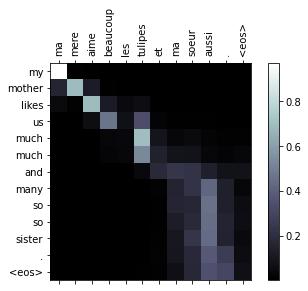

Input:['entre', 'donc', '!', '<eos>']
Label:['<sos>', 'come', 'on', 'in', '!', '<eos>']
Output:['many', 'on', '!', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 3000], [train loss 13.2772 +/- 11.3589], [epoch elapsed time 217.79]
--------------------------------------------------------------------


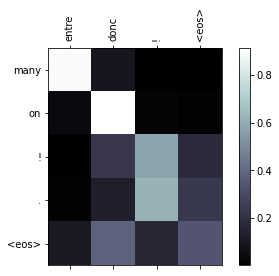

Input:['je', 'dois', 'retourner', 'a', 'boston', 'pour', 'un', 'enterrement', '.', '<eos>']
Label:['<sos>', 'i', 'need', 'to', 'go', 'back', 'to', 'boston', 'for', 'a', 'funeral', '.', '<eos>']
Output:['i', 'must', 'to', 'go', 'back', 'to', 'a', 'for', 'a', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 3300], [train loss 13.3247 +/- 11.4100], [epoch elapsed time 239.56]
--------------------------------------------------------------------


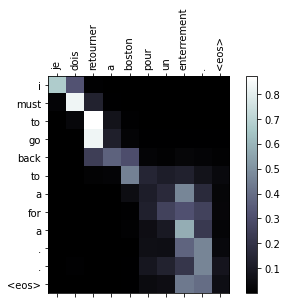

Input:['ce', 'n', 'est', 'pas', 'ce', 'que', 'j', 'etais', 'en', 'train', 'de', 'dire', '.', '<eos>']
Label:['<sos>', 'that', 's', 'not', 'what', 'i', 'was', 'saying', '.', '<eos>']
Output:['that', 'is', 'n t', 'that', 'i', 'was', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 3600], [train loss 13.4618 +/- 11.5262], [epoch elapsed time 261.99]
--------------------------------------------------------------------


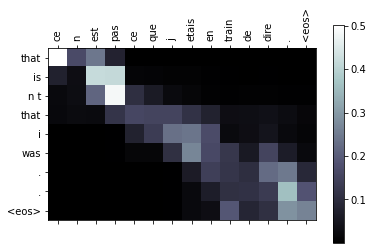

Input:['il', 'porte', 'toujours', 'des', 'chemises', 'bleues', '.', '<eos>']
Label:['<sos>', 'he', 'always', 'wears', 'blue', 'shirts', '.', '<eos>']
Output:['he', 'always', 'n t', 'be', 'hard', 'he', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 3900], [train loss 13.5438 +/- 11.5479], [epoch elapsed time 283.89]
--------------------------------------------------------------------


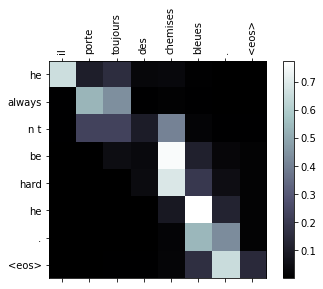

Input:['dis', 'moi', 'que', 'ce', 'n', 'est', 'pas', 'vrai', '!', '<eos>']
Label:['<sos>', 'tell', 'me', 'it', 's', 'not', 'true', '.', '<eos>']
Output:['tell', 'me', 'that', 's', 'not', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 4200], [train loss 13.5752 +/- 11.5145], [epoch elapsed time 305.68]
--------------------------------------------------------------------


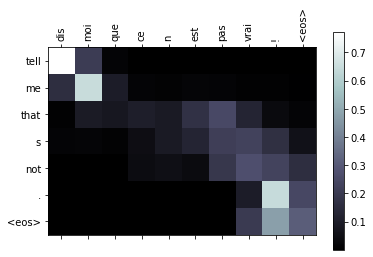

Input:['elle', 'a', 'quitte', 'son', 'emploi', 'le', 'mois', 'dernier', '.', '<eos>']
Label:['<sos>', 'she', 'quit', 'her', 'job', 'last', 'month', '.', '<eos>']
Output:['she', 'called', 'her', 'job', 'last', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 4500], [train loss 13.6848 +/- 11.5807], [epoch elapsed time 328.18]
--------------------------------------------------------------------


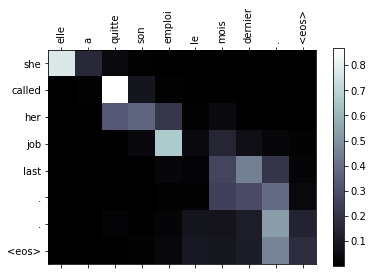

Input:['c', 'est', 'la', 'plus', 'belle', 'femme', '.', '<eos>']
Label:['<sos>', 'she', 's', 'the', 'most', 'beautiful', 'woman', '.', '<eos>']
Output:['she', 'is', 'the', 'most', 'beautiful', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 4800], [train loss 13.8565 +/- 11.6666], [epoch elapsed time 350.28]
--------------------------------------------------------------------


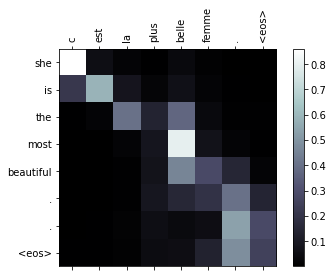

Input:['l', 'idee', 'de', 'la', 'surprendre', 'traversa', 'soudain', 'mon', 'esprit', '.', '<eos>']
Label:['<sos>', 'the', 'idea', 'of', 'surprising', 'her', 'suddenly', 'crossed', 'my', 'mind', '.', '<eos>']
Output:['the', 'idea', 'of', 'the', 'of', 'many', '.', 'my', 'mind', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 5100], [train loss 13.9469 +/- 11.7440], [epoch elapsed time 372.50]
--------------------------------------------------------------------


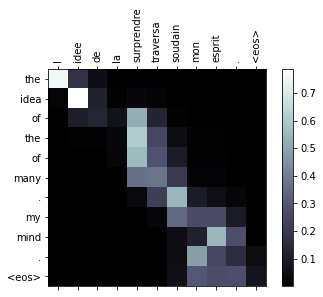

Input:['je', 'suppose', 'que', 'ca', 'n', 'aurait', 'pas', 'grande', 'signification', 'pour', 'vous', '.', '<eos>']
Label:['<sos>', 'i', 'guess', 'that', 'would', 'n t', 'mean', 'much', 'to', 'you', '.', '<eos>']
Output:['i', 'guess', 'it', 'should', 'n t', 'n t', 'with', 'like', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 5400], [train loss 14.0305 +/- 11.7926], [epoch elapsed time 394.32]
--------------------------------------------------------------------


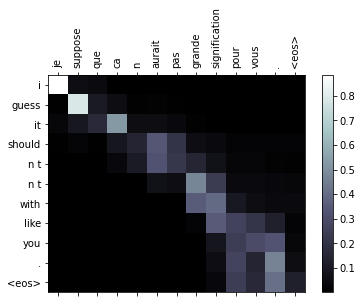

Input:['c', 'est', 'exactement', 'ce', 'que', 'je', 'veux', '.', '<eos>']
Label:['<sos>', 'that', 's', 'exactly', 'what', 'i', 'want', '.', '<eos>']
Output:['that', 's', 'exactly', 'i', 'i', 'want', 'want', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 5700], [train loss 14.1819 +/- 11.8738], [epoch elapsed time 416.51]
--------------------------------------------------------------------


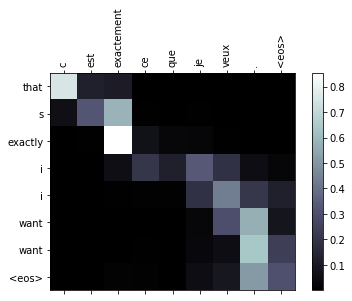

Input:['je', 'n', 'arrive', 'pas', 'a', 'te', 'le', 'montrer', '.', '<eos>']
Label:['<sos>', 'i', 'ca', 'n t', 'show', 'you', '.', '<eos>']
Output:['i', 'ca', 'n t', 'show', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 6000], [train loss 14.2860 +/- 11.9645], [epoch elapsed time 438.88]
--------------------------------------------------------------------


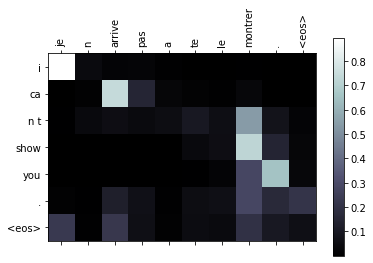

Input:['vous', 'pouvez', 'courir', 'mais', 'vous', 'ne', 'pouvez', 'pas', 'vous', 'cacher', '.', '<eos>']
Label:['<sos>', 'you', 'can', 'run', 'but', 'you', 'ca', 'n t', 'hide', '.', '<eos>']
Output:['you', 'may', 'run', 'but', 'you', 'can', 'n t', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 6300], [train loss 14.3405 +/- 11.9540], [epoch elapsed time 460.38]
--------------------------------------------------------------------


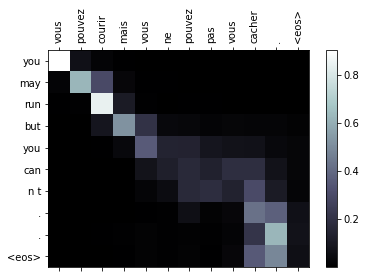

Input:['il', 'a', 'dit', 'qu', 'il', 'etait', 'pauvre', '.', '<eos>']
Label:['<sos>', 'he', 'said', 'he', 'was', 'poor', '.', '<eos>']
Output:['he', 'said', 'he', 'was', 'was', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 18 iter 6600], [train loss 14.4809 +/- 12.0294], [epoch elapsed time 481.93]
--------------------------------------------------------------------


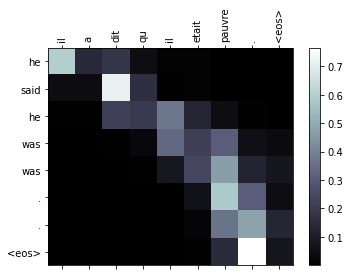

--------------------------------------------------------------------
[epoch 18], [train loss 14.5020 +/- 12.0285], [training time 486.06]
--------------------------------------------------------------------
********************************************************************
Input:['c', 'est', 'la', 'sienne', '.', '<eos>']
Label:['<sos>', 'that', 's', 'his', '.', '<eos>']
Output:['that', 's', 'the', '.', '.', '<eos>']


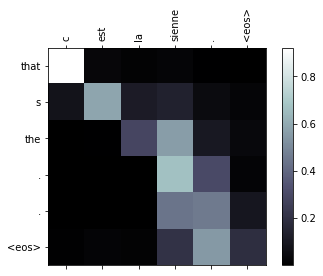

Input:['ils', 'le', '<unk>', 'directeur', '.', '<eos>']
Label:['<sos>', 'they', '<unk>', 'him', 'as', 'a', '<unk>', '.', '<eos>']
Output:['they', 'made', 'him', 'to', '.', '.', '<eos>']


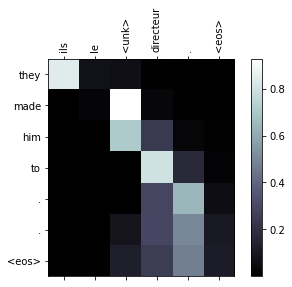

[epoch 18], [test loss 27.9489 +/- 17.7459], [testing time 2.04]
********************************************************************
Input:['il', 'y', 'a', 'un', 'homme', 'a', 'la', 'porte', '.', '<eos>']
Label:['<sos>', 'there', 'is', 'a', 'man', 'at', 'the', 'door', '.', '<eos>']
Output:['there', 'is', 'a', 'man', 'the', 'door', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 300], [train loss 12.1898 +/- 11.1510], [epoch elapsed time 20.86]
--------------------------------------------------------------------


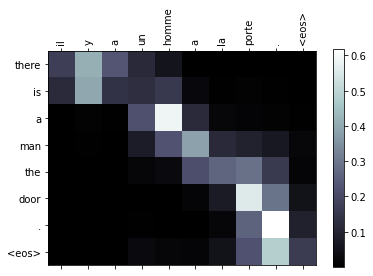

Input:['le', 'poste', 'est', 'agremente', 'de', 'nombreux', 'avantages', 'en', 'nature', '.', '<eos>']
Label:['<sos>', 'the', 'job', 'comes', 'with', 'a', 'lot', 'of', 'fringe', 'benefits', '.', '<eos>']
Output:['the', 'job', 'is', 'to', 'a', 'lot', 'of', 'wine', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 600], [train loss 12.4578 +/- 10.9704], [epoch elapsed time 42.51]
--------------------------------------------------------------------


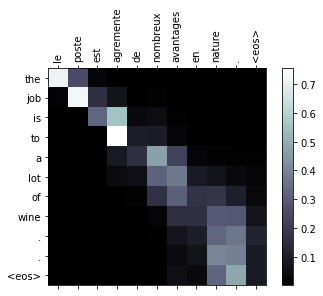

Input:['il', 'prend', 'la', 'plupart', 'des', 'decisions', 'importantes', 'sinon', 'toutes', 'pour', 'sa', 'societe', '.', '<eos>']
Label:['<sos>', 'he', 'makes', 'most', 'if', 'not', 'all', 'of', 'the', 'important', 'decisions', 'for', 'his', 'company', '.', '<eos>']
Output:['it', 'makes', 'the', 'most', 'of', 'the', 'important', 'of', 'his', 'being', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 900], [train loss 12.3441 +/- 10.8631], [epoch elapsed time 64.18]
--------------------------------------------------------------------


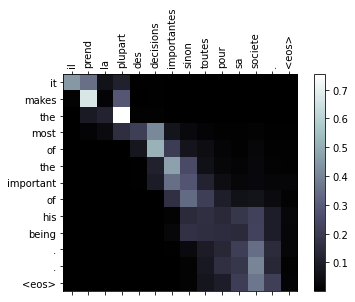

Input:['il', 'est', 'apparu', 'de', 'nulle', 'part', '.', '<eos>']
Label:['<sos>', 'he', 'appeared', 'from', 'nowhere', '.', '<eos>']
Output:['he', 'is', 'from', 'of', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 1200], [train loss 12.2202 +/- 10.7890], [epoch elapsed time 85.85]
--------------------------------------------------------------------


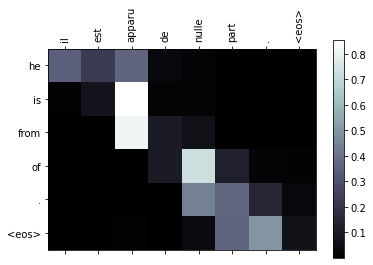

Input:['ne', 'lache', 'pas', 'le', 'chien', '.', '<eos>']
Label:['<sos>', 'do', 'n t', 'let', 'that', 'dog', 'go', '.', '<eos>']
Output:['do', 'n t', 'that', 'that', 'dog', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 1500], [train loss 12.4014 +/- 11.0729], [epoch elapsed time 107.80]
--------------------------------------------------------------------


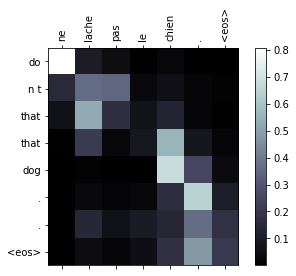

Input:['j', 'ai', 'confesse', '.', '<eos>']
Label:['<sos>', 'i', 'confessed', '.', '<eos>']
Output:['i', 'm', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 1800], [train loss 12.6974 +/- 11.1677], [epoch elapsed time 129.81]
--------------------------------------------------------------------


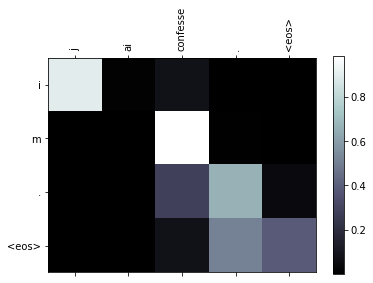

Input:['j', 'en', 'veux', 'une', '!', '<eos>']
Label:['<sos>', 'i', 'want', 'one', '.', '<eos>']
Output:['i', 'want', 'one', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 2100], [train loss 12.8687 +/- 11.3648], [epoch elapsed time 152.01]
--------------------------------------------------------------------


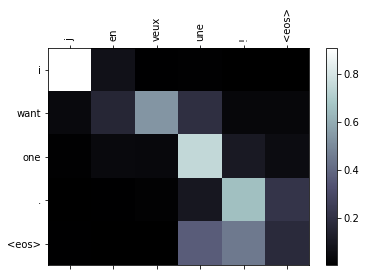

Input:['l', 'une', 'des', 'meilleures', 'manieres', 'de', 'nous', 'aider', 'est', 'de', 'traduire', 'd', 'une', 'langue', 'etrangere', 'que', 'vous', 'connaissez', 'vers', 'votre', 'propre', 'langue', 'natale', 'ou', 'la', 'plus', 'forte', 'de', 'vos', 'langues', '.', '<eos>']
Label:['<sos>', 'one', 'of', 'the', 'best', 'ways', 'to', 'help', 'us', 'is', 'to', 'translate', 'from', 'a', 'foreign', 'language', 'you', 'know', 'into', 'your', 'own', 'native', 'language', 'or', 'strongest', 'language', '.', '<eos>']
Output:['one', 'of', 'the', 'best', 'to', 'help', 'us', 'to', 'to', 'your', 'language', 'language', 'language', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 2400], [train loss 12.9246 +/- 11.5732], [epoch elapsed time 174.01]
--------------------------------------------------------------------


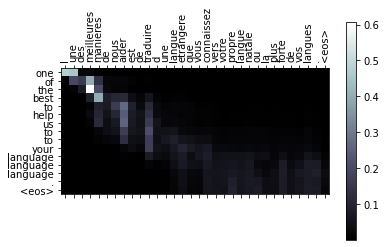

Input:['je', 'pensais', 'que', 'tu', 'serais', 'morte', 'a', 'l', 'heure', 'qu', 'il', 'est', '.', '<eos>']
Label:['<sos>', 'i', 'thought', 'you', 'd', 'be', 'dead', 'by', 'now', '.', '<eos>']
Output:['i', 'thought', 'you', 'd', 'be', 'dead', 'by', 'now', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 2700], [train loss 13.1890 +/- 11.7282], [epoch elapsed time 196.55]
--------------------------------------------------------------------


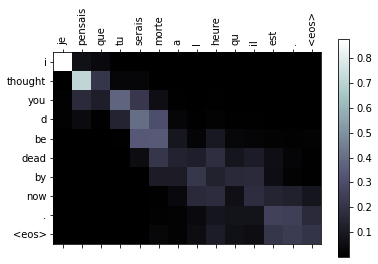

Input:['garde', 'l', 'argent', 'en', 'lieu', 'sur', '.', '<eos>']
Label:['<sos>', 'keep', 'the', 'money', 'in', 'a', 'safe', 'place', '.', '<eos>']
Output:['keep', 'the', 'money', 'where', 'on', 'safe', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 3000], [train loss 13.3192 +/- 11.7798], [epoch elapsed time 218.44]
--------------------------------------------------------------------


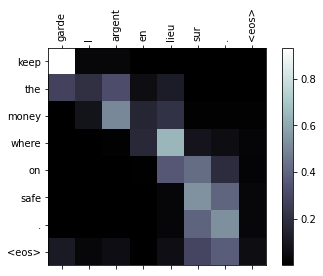

Input:['tu', 'ne', 'veux', 'jamais', 'te', 'debarrasser', 'de', 'quoi', 'que', 'ce', 'soit', '.', '<eos>']
Label:['<sos>', 'you', 'never', 'want', 'to', 'give', 'anything', 'away', '.', '<eos>']
Output:['you', 'never', 'want', 'anything', 'anything', 'anything', 'anything', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 3300], [train loss 13.4113 +/- 11.7280], [epoch elapsed time 240.24]
--------------------------------------------------------------------


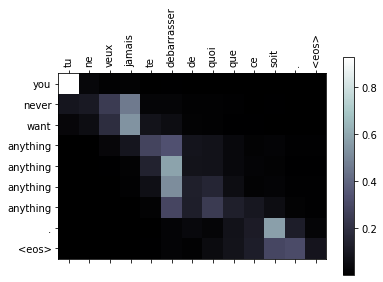

Input:['j', 'aurais', 'pu', 'te', 'rencontrer', 'a', 'l', 'aerodrome', '.', '<eos>']
Label:['<sos>', 'i', 'could', 've', 'met', 'you', 'at', 'the', 'airport', '.', '<eos>']
Output:['i', 'could', 've', 'told', 'you', '.', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 3600], [train loss 13.4087 +/- 11.6673], [epoch elapsed time 262.20]
--------------------------------------------------------------------


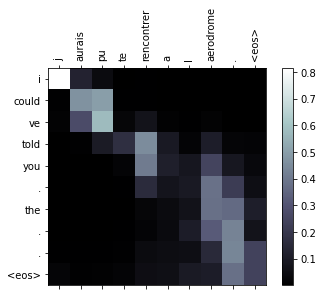

Input:['il', 'travaille', 'dur', 'afin', 'de', 'reussir', 'l', 'examen', 'd', 'entree', '.', '<eos>']
Label:['<sos>', 'he', 's', 'studying', 'hard', 'so', 'he', 'can', 'pass', 'the', 'entrance', 'exam', '.', '<eos>']
Output:['he', 's', 'always', 'hard', 'he', 'he', 'pass', 'pass', 'the', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 3900], [train loss 13.4919 +/- 11.6699], [epoch elapsed time 284.17]
--------------------------------------------------------------------


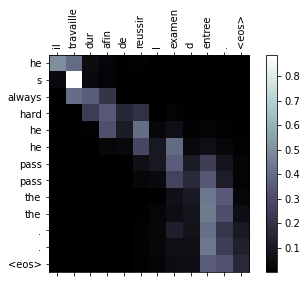

Input:['je', 'suis', 'etranger', '.', '<eos>']
Label:['<sos>', 'i', 'am', 'a', 'foreigner', '.', '<eos>']
Output:['i', 'm', 'a', 'while', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 4200], [train loss 13.6252 +/- 11.8173], [epoch elapsed time 306.69]
--------------------------------------------------------------------


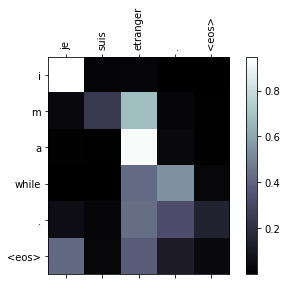

Input:['commencons', '!', '<eos>']
Label:['<sos>', 'let', 's', 'get', 'started', '.', '<eos>']
Output:['get', 'it', 'make', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 4500], [train loss 13.6880 +/- 11.7363], [epoch elapsed time 328.60]
--------------------------------------------------------------------


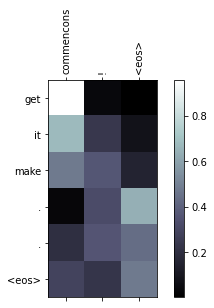

Input:['nous', 'en', 'savons', 'assez', '.', '<eos>']
Label:['<sos>', 'we', 'know', 'enough', '.', '<eos>']
Output:['we', 'know', 'that', 'enough', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 4800], [train loss 13.8191 +/- 11.7473], [epoch elapsed time 350.52]
--------------------------------------------------------------------


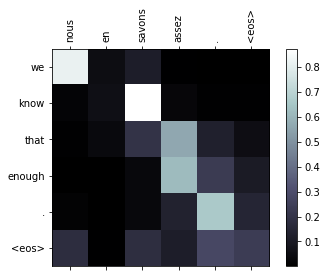

Input:['vous', 'etes', 'toutes', 'folles', '.', '<eos>']
Label:['<sos>', 'you', 're', 'all', 'crazy', '.', '<eos>']
Output:['you', 're', 'crazy', 'crazy', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 5100], [train loss 13.8969 +/- 11.7770], [epoch elapsed time 372.43]
--------------------------------------------------------------------


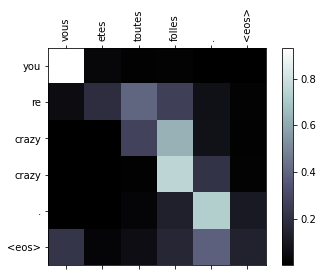

Input:['je', 'veux', 'te', 'remercier', 'personnellement', '.', '<eos>']
Label:['<sos>', 'i', 'want', 'to', 'personally', 'thank', 'you', '.', '<eos>']
Output:['i', 'want', 'to', 'thank', 'you', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 5400], [train loss 13.9579 +/- 11.7428], [epoch elapsed time 394.29]
--------------------------------------------------------------------


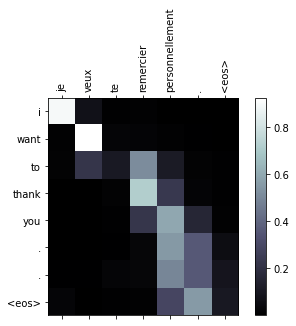

Input:['nous', 'voulons', 'tous', 'deux', 'voir', 'le', 'film', '.', '<eos>']
Label:['<sos>', 'both', 'of', 'us', 'want', 'to', 'see', 'the', 'movie', '.', '<eos>']
Output:['we', 'want', 'to', 'see', 'to', 'the', 'movie', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 5700], [train loss 14.0581 +/- 11.7253], [epoch elapsed time 416.33]
--------------------------------------------------------------------


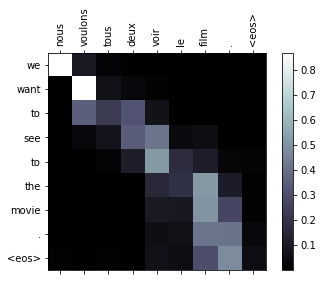

Input:['ca', 'a', 'l', 'air', 'assez', 'mignon', '.', '<eos>']
Label:['<sos>', 'this', 'looks', 'kind', 'of', 'cute', '.', '<eos>']
Output:['it', 'looks', 'drinking', 'in', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 6000], [train loss 14.1401 +/- 11.7825], [epoch elapsed time 438.77]
--------------------------------------------------------------------


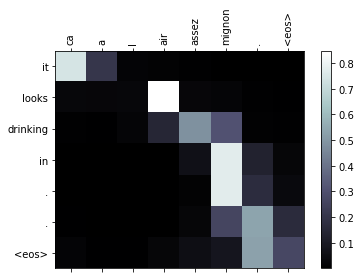

Input:['ne', 'soyez', 'pas', 'desolee', '!', '<eos>']
Label:['<sos>', 'do', 'n t', 'be', 'sorry', '.', '<eos>']
Output:['do', 'n t', 'be', 'sorry', '!', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 6300], [train loss 14.2102 +/- 11.7947], [epoch elapsed time 460.73]
--------------------------------------------------------------------


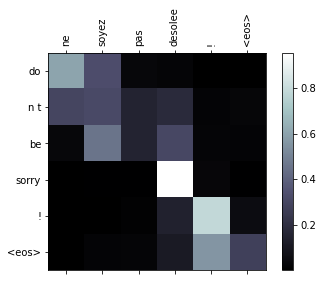

Input:['notre', 'concert', 'a', 'ete', 'remis', '.', '<eos>']
Label:['<sos>', 'our', 'concert', 'has', 'been', 'postponed', '.', '<eos>']
Output:['our', 'concert', 'has', 'been', 'gone', '.', '<eos>']
--------------------------------------------------------------------
[epoch 19 iter 6600], [train loss 14.2905 +/- 11.8394], [epoch elapsed time 482.16]
--------------------------------------------------------------------


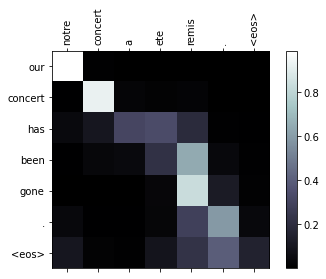

--------------------------------------------------------------------
[epoch 19], [train loss 14.3210 +/- 11.8628], [training time 486.50]
--------------------------------------------------------------------
********************************************************************
Input:['je', 'ne', 'peux', 'marcher', 'plus', 'loin', '.', '<eos>']
Label:['<sos>', 'i', 'can', 'walk', 'no', '<unk>', '.', '<eos>']
Output:['i', 'ca', 'n t', 'go', 'sad', '.', '<eos>']


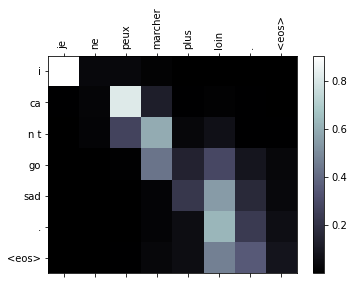

Input:['quel', 'est', 'le', '<unk>', 'que', 'vous', 'aimez', 'le', 'plus', 'regarder', '?', '<eos>']
Label:['<sos>', 'what', 's', 'your', 'favorite', '<unk>', '<unk>', '?', '<eos>']
Output:['which', 's', 'the', 'the', 'you', 'like', 'the', '?', '?', '<eos>']


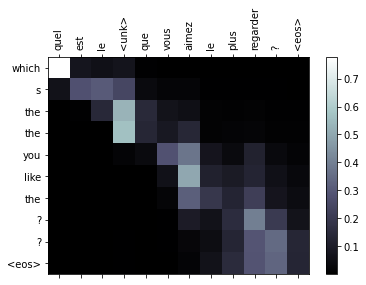

[epoch 19], [test loss 29.0097 +/- 17.9446], [testing time 2.21]
********************************************************************
Input:['je', 'n', 'arrive', 'pas', 'a', 'croire', 'que', 'vous', 'ne', 'm', 'ayez', 'pas', 'reconnu', '.', '<eos>']
Label:['<sos>', 'i', 'ca', 'n t', 'believe', 'you', 'did', 'n t', 'recognize', 'me', '.', '<eos>']
Output:['i', 'ca', 'n t', 'believe', 'you', 're', 'n t', 'recognize', 'me', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 300], [train loss 11.0027 +/- 9.4887], [epoch elapsed time 21.29]
--------------------------------------------------------------------


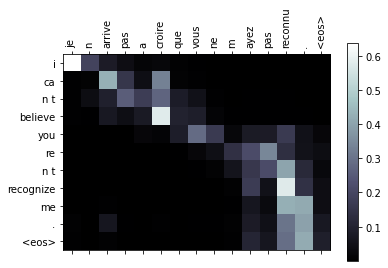

Input:['ce', 'ne', 'fut', 'pas', 'a', 'la', 'mesure', 'de', 'mes', 'attentes', '.', '<eos>']
Label:['<sos>', 'it', 'fell', 'short', 'of', 'my', 'expectation', '.', '<eos>']
Output:['it', 'was', 'was', 'of', 'my', 'my', 'my', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 600], [train loss 11.5271 +/- 10.2699], [epoch elapsed time 43.23]
--------------------------------------------------------------------


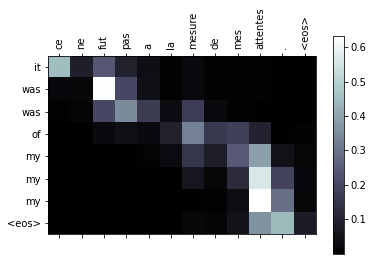

Input:['je', 'n', 'ai', 'pas', 'recu', 'meme', 'une', 'lettre', 'd', 'elle', '.', '<eos>']
Label:['<sos>', 'i', 'did', 'n t', 'receive', 'even', 'one', 'letter', 'from', 'her', '.', '<eos>']
Output:['i', 'have', 'n t', 'really', 'even', 'a', 'letter', '.', 'her', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 900], [train loss 11.8549 +/- 10.7135], [epoch elapsed time 64.92]
--------------------------------------------------------------------


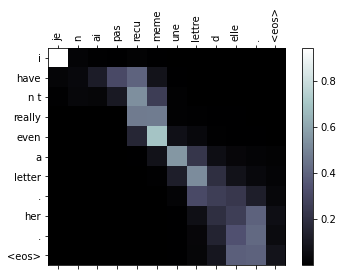

Input:['si', 'tu', 'disposais', 'd', 'un', 'million', 'de', 'dollars', 'que', 'ferais', 'tu', '?', '<eos>']
Label:['<sos>', 'if', 'you', 'had', 'a', 'million', 'dollars', 'what', 'would', 'you', 'do', '?', '<eos>']
Output:['if', 'you', 'had', 'an', 'an', 'dollars', 'what', 'would', 'you', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 1200], [train loss 12.1841 +/- 11.0483], [epoch elapsed time 87.35]
--------------------------------------------------------------------


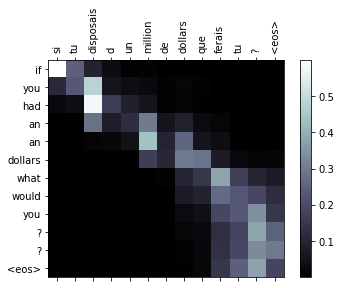

Input:['quelqu', 'un', 's', 'est', 'carapate', 'avec', 'mon', 'crayon', '.', '<eos>']
Label:['<sos>', 'someone', 'has', 'walked', 'off', 'with', 'my', 'pencil', '.', '<eos>']
Output:['someone', 'has', 'has', 'off', 'with', 'my', 'day', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 1500], [train loss 12.0591 +/- 10.8291], [epoch elapsed time 108.82]
--------------------------------------------------------------------


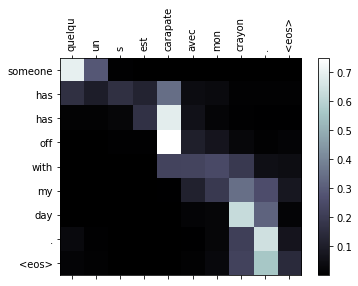

Input:['je', 'suis', 'aussi', 'd', 'accord', 'avec', 'tom', '.', '<eos>']
Label:['<sos>', 'i', 'agree', 'with', 'tom', 'too', '.', '<eos>']
Output:['i', 'm', 'with', 'with', 'with', 'with', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 1800], [train loss 12.2929 +/- 11.1230], [epoch elapsed time 130.97]
--------------------------------------------------------------------


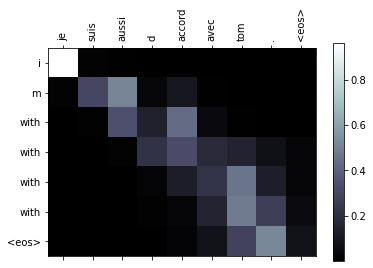

Input:['he', 'tom', 'je', 'peux', 'te', 'demander', 'quelque', 'chose', '?', '<eos>']
Label:['<sos>', 'hey', 'tom', 'can', 'i', 'ask', 'you', 'something', '?', '<eos>']
Output:['can', 'i', 'i', 'ask', 'ask', 'you', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 2100], [train loss 12.1911 +/- 10.9237], [epoch elapsed time 152.41]
--------------------------------------------------------------------


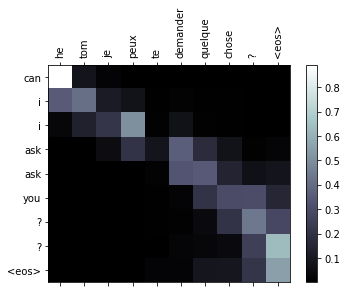

Input:['je', 'ne', 'crois', 'pas', 'que', 'tu', 'l', 'aies', 'rencontre', '.', '<eos>']
Label:['<sos>', 'i', 'do', 'n t', 'believe', 'you', 've', 'met', 'him', '.', '<eos>']
Output:['i', 'do', 'n t', 'believe', 'you', 've', 'met', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 2400], [train loss 12.2957 +/- 11.0866], [epoch elapsed time 174.21]
--------------------------------------------------------------------


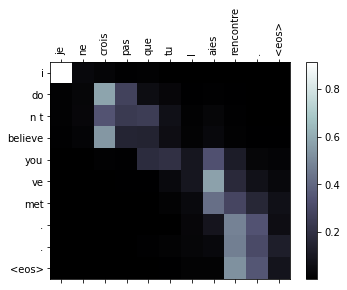

Input:['regardez', 'sous', 'le', 'siege', '.', '<eos>']
Label:['<sos>', 'look', 'under', 'the', 'seat', '.', '<eos>']
Output:['look', 'under', 'the', 'cat', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 2700], [train loss 12.4005 +/- 10.9989], [epoch elapsed time 196.84]
--------------------------------------------------------------------


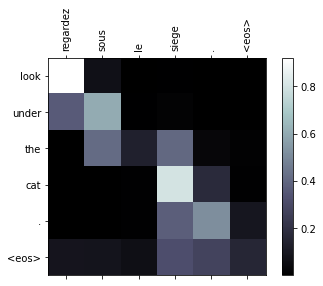

Input:['j', 'en', 'suis', 'sure', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'sure', '.', '<eos>']
Output:['i', 'm', 'sure', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 3000], [train loss 12.5204 +/- 10.9783], [epoch elapsed time 218.71]
--------------------------------------------------------------------


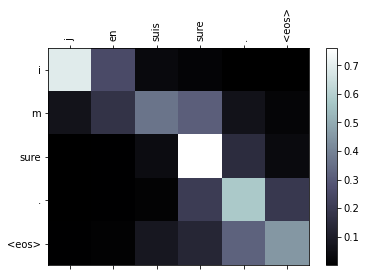

Input:['mon', 'pere', 'doit', 'effectuer', 'le', 'travail', '.', '<eos>']
Label:['<sos>', 'my', 'father', 'must', 'do', 'the', 'work', '.', '<eos>']
Output:['my', 'father', 'must', 'have', 'the', 'job', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 3300], [train loss 12.6070 +/- 10.8994], [epoch elapsed time 241.02]
--------------------------------------------------------------------


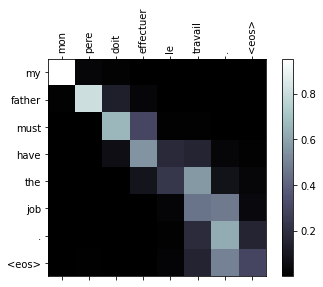

Input:['tu', 'as', 'tout', 'foutu', 'en', 'l', 'air', '.', '<eos>']
Label:['<sos>', 'you', 'ruined', 'everything', '.', '<eos>']
Output:['you', 'll', 'be', 'in', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 3600], [train loss 12.8519 +/- 11.1465], [epoch elapsed time 264.10]
--------------------------------------------------------------------


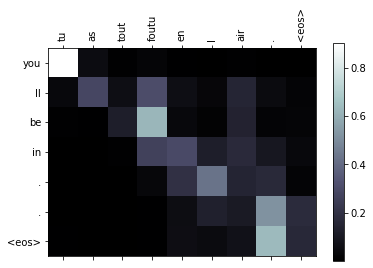

Input:['il', 's', 'est', 'fait', 'catholique', '.', '<eos>']
Label:['<sos>', 'he', 'became', 'a', 'catholic', '.', '<eos>']
Output:['he', 'did', 'a', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 3900], [train loss 13.1661 +/- 11.4441], [epoch elapsed time 286.91]
--------------------------------------------------------------------


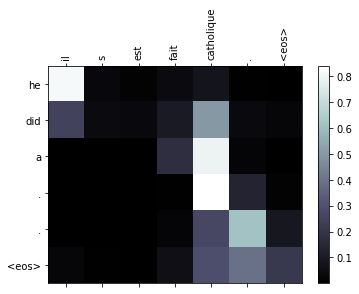

Input:['il', 'attendait', 'les', 'nouvelles', 'avec', 'impatience', '.', '<eos>']
Label:['<sos>', 'he', 'was', 'eager', 'for', 'news', '.', '<eos>']
Output:['he', 'was', 'a', 'with', 'with', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 4200], [train loss 13.2130 +/- 11.4277], [epoch elapsed time 308.54]
--------------------------------------------------------------------


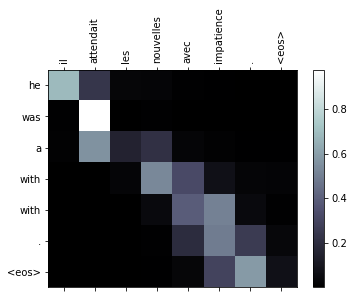

Input:['quel', 'homme', 'epouvantable', '!', '<eos>']
Label:['<sos>', 'what', 'a', 'horrible', 'man', '!', '<eos>']
Output:['what', 'a', 'man', '!', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 4500], [train loss 13.3482 +/- 11.4160], [epoch elapsed time 330.97]
--------------------------------------------------------------------


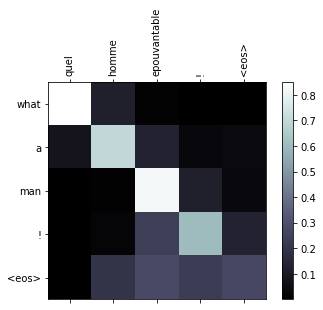

Input:['s', 'il', 'te', 'plait', 'donne', 'moi', 'de', 'l', 'eau', '.', '<eos>']
Label:['<sos>', 'please', 'give', 'me', 'some', 'water', '.', '<eos>']
Output:['i', 'understand', 'you', 'some', 'some', 'water', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 4800], [train loss 13.3661 +/- 11.4175], [epoch elapsed time 352.90]
--------------------------------------------------------------------


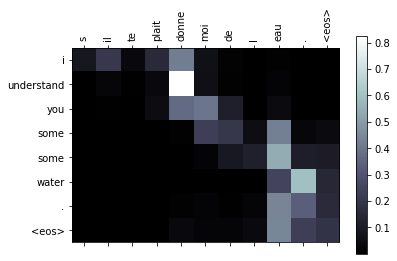

Input:['je', 'sais', 'que', 'tu', 'penses', 'que', 'je', 'suis', 'stupide', '.', '<eos>']
Label:['<sos>', 'i', 'know', 'you', 'think', 'i', 'm', 'stupid', '.', '<eos>']
Output:['i', 'know', 'you', 'think', 'i', 'm', 'stupid', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 5100], [train loss 13.4720 +/- 11.4484], [epoch elapsed time 374.74]
--------------------------------------------------------------------


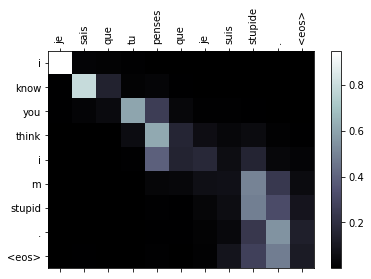

Input:['les', 'oranges', 'contiennent', 'beaucoup', 'de', 'vitamine', 'c.', '<eos>']
Label:['<sos>', 'oranges', 'have', 'a', 'lot', 'of', 'vitamin', 'c.', '<eos>']
Output:['do', 'n t', 'a', 'a', 'lot', 'of', 'homework', 'very', 'much', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 5400], [train loss 13.5915 +/- 11.5484], [epoch elapsed time 396.93]
--------------------------------------------------------------------


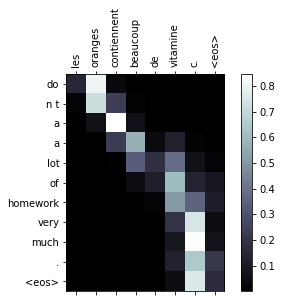

Input:['etes', 'vous', 'sures', 'de', 'vouloir', 'partir', 'maintenant', '?', '<eos>']
Label:['<sos>', 'are', 'you', 'sure', 'you', 'want', 'to', 'leave', 'now', '?', '<eos>']
Output:['are', 'you', 'sure', 'you', 'want', 'to', 'now', '?', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 5700], [train loss 13.6620 +/- 11.6265], [epoch elapsed time 419.27]
--------------------------------------------------------------------


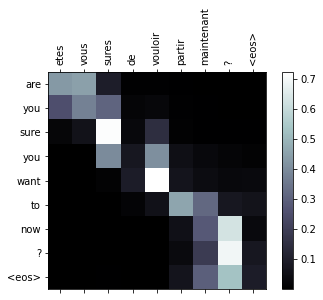

Input:['ne', 'parle', 'pas', '!', '<eos>']
Label:['<sos>', 'do', 'n t', 'talk', '!', '<eos>']
Output:['do', 'n t', 'speak', '!', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 6000], [train loss 13.7444 +/- 11.6719], [epoch elapsed time 441.42]
--------------------------------------------------------------------


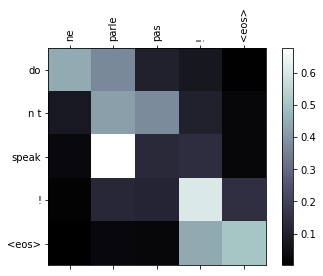

Input:['l', 'italie', 'a', 'envahi', 'l', 'ethiopie', 'en', 'dix neuf cent trente cinq', '.', '<eos>']
Label:['<sos>', 'italy', 'invaded', 'ethiopia', 'in', '.', '<eos>']
Output:['the', 'made', 'of', 'the', 'in', 'by', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 6300], [train loss 13.8642 +/- 11.7169], [epoch elapsed time 463.36]
--------------------------------------------------------------------


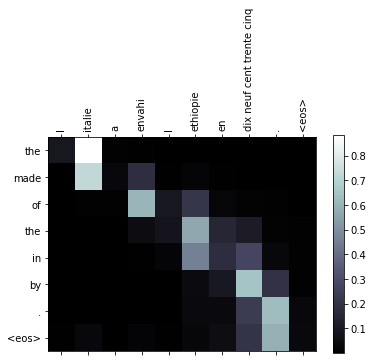

Input:['elle', 's', 'assit', 'aupres', 'de', 'lui', 'et', 'ecouta', 'tranquillement', '.', '<eos>']
Label:['<sos>', 'she', 'sat', 'next', 'to', 'him', 'and', 'listened', 'quietly', '.', '<eos>']
Output:['she', 'sat', 'next', 'to', 'him', 'and', 'and', '.', '<eos>']
--------------------------------------------------------------------
[epoch 20 iter 6600], [train loss 13.9588 +/- 11.7737], [epoch elapsed time 484.82]
--------------------------------------------------------------------


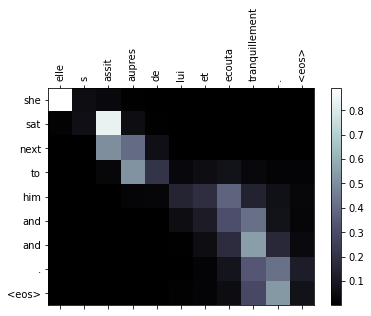

--------------------------------------------------------------------
[epoch 20], [train loss 13.9702 +/- 11.7833], [training time 489.01]
--------------------------------------------------------------------
********************************************************************
Input:['ceux', 'qui', 'se', 'tenaient', 'debout', 'etaient', 'tous', 'des', 'hommes', '.', '<eos>']
Label:['<sos>', 'those', 'standing', 'were', 'all', 'men', '.', '<eos>']
Output:['these', 'who', 'know', 'there', 'were', 'all', '.', '<eos>']


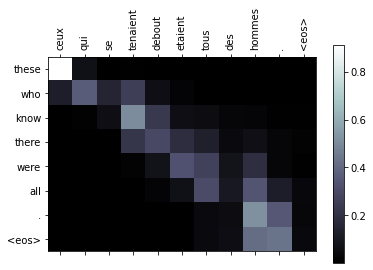

Input:['tout', 'd', 'abord', 'je', 'dois', 'dire', 'ceci', '.', '<eos>']
Label:['<sos>', 'first', 'of', 'all', 'i', 'must', 'say', 'this', '.', '<eos>']
Output:['all', 'i', 'all', 'i', 'what', 'this', '.', '<eos>']


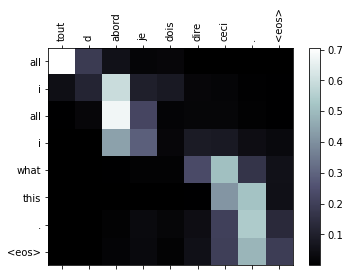

[epoch 20], [test loss 27.8928 +/- 17.3177], [testing time 2.14]
********************************************************************
Input:['restez', 'assis', 'un', 'moment', 's', 'il', 'vous', 'plait', '.', '<eos>']
Label:['<sos>', 'please', 'remain', 'seated', 'for', 'a', 'few', 'minutes', '.', '<eos>']
Output:['stay', 'back', 'from', 'a', 'house', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 300], [train loss 10.3921 +/- 8.4493], [epoch elapsed time 21.22]
--------------------------------------------------------------------


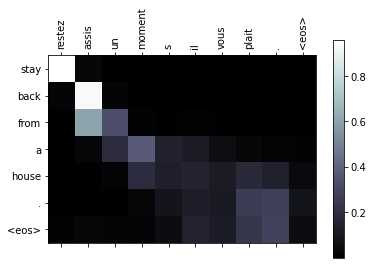

Input:['j', 'aime', 'les', 'vieux', 'films', 'de', 'gangsters', 'd', 'avant', 'guerre', '.', '<eos>']
Label:['<sos>', 'i', 'love', 'old', 'prewar', 'gangster', 'movies', '.', '<eos>']
Output:['i', 'like', 'old', 'movies', 'movies', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 600], [train loss 11.0290 +/- 9.7183], [epoch elapsed time 43.13]
--------------------------------------------------------------------


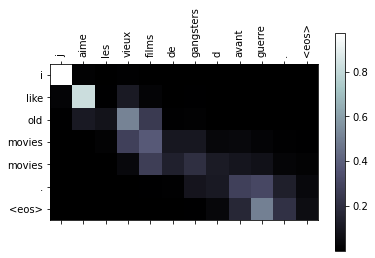

Input:['tu', 'es', 'venue', 'trop', 'tard', '.', '<eos>']
Label:['<sos>', 'you', 'came', 'too', 'late', '.', '<eos>']
Output:['you', 'came', 'too', 'late', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 900], [train loss 11.2307 +/- 9.9780], [epoch elapsed time 65.29]
--------------------------------------------------------------------


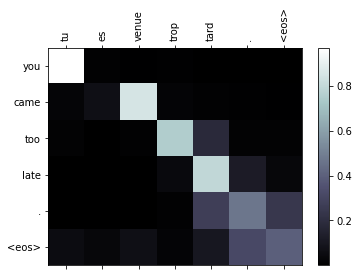

Input:['elle', 'passe', 'a', 'la', 'tele', 'ce', 'soir', '.', '<eos>']
Label:['<sos>', 'she', 'is', 'appearing', 'on', 'tv', 'tonight', '.', '<eos>']
Output:['she', 'is', 'on', 'tv', 'tonight', 'tonight', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 1200], [train loss 11.6973 +/- 10.6483], [epoch elapsed time 87.46]
--------------------------------------------------------------------


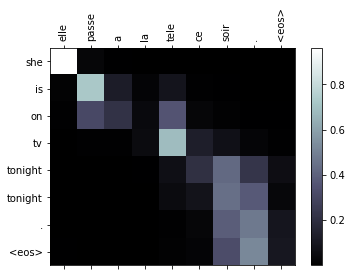

Input:['les', 'filles', 'vont', 'etre', 'en', 'retard', 'ce', 'soir', '.', '<eos>']
Label:['<sos>', 'the', 'girls', 'are', 'going', 'to', 'be', 'late', 'this', 'evening', '.', '<eos>']
Output:['the', 'are', 'are', 'going', 'to', 'be', 'this', 'tonight', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 1500], [train loss 12.1369 +/- 11.0859], [epoch elapsed time 109.93]
--------------------------------------------------------------------


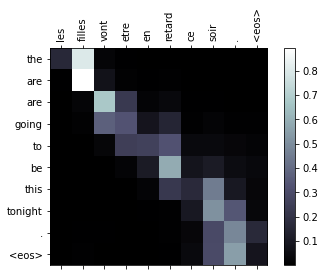

Input:['je', 'ne', 'parviens', 'pas', 'a', 'faire', 'deux', 'choses', 'a', 'la', 'fois', '.', '<eos>']
Label:['<sos>', 'i', 'ca', 'n t', 'do', 'two', 'things', 'at', 'once', '.', '<eos>']
Output:['i', 'ca', 'n t', 'believe', 'two', 'things', 'once', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 1800], [train loss 12.2497 +/- 11.0544], [epoch elapsed time 131.82]
--------------------------------------------------------------------


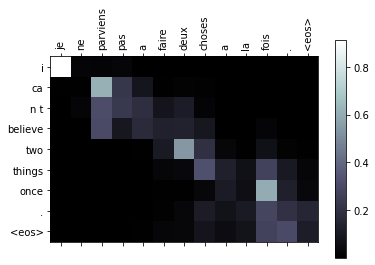

Input:['je', 'pense', 'que', 'nous', 'connaissons', 'toutes', 'les', 'regles', '.', '<eos>']
Label:['<sos>', 'i', 'think', 'we', 'all', 'know', 'the', 'rules', '.', '<eos>']
Output:['i', 'think', 'we', 'all', 'be', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 2100], [train loss 12.1971 +/- 10.9901], [epoch elapsed time 153.78]
--------------------------------------------------------------------


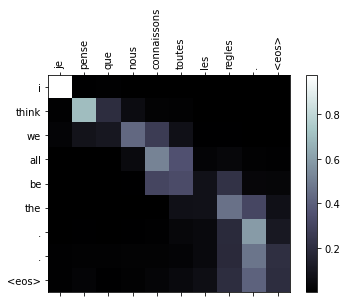

Input:['dans', 'ce', 'cas', 'je', 'pense', 'qu', 'il', 'a', 'raison', '.', '<eos>']
Label:['<sos>', 'in', 'this', 'case', 'i', 'think', 'he', 'is', 'correct', '.', '<eos>']
Output:['in', 'this', 'place', 'i', 'can', 'think', 'it', 's', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 2400], [train loss 12.2651 +/- 11.0641], [epoch elapsed time 175.99]
--------------------------------------------------------------------


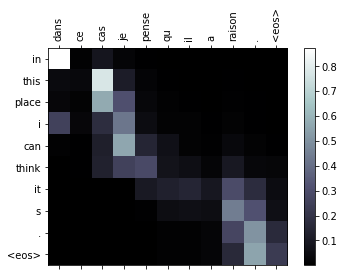

Input:['la', 'france', 'est', 'en', 'europe', 'occidentale', '.', '<eos>']
Label:['<sos>', 'france', 'is', 'in', 'western', 'europe', '.', '<eos>']
Output:['the', 'is', 'is', 'than', 'than', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 2700], [train loss 12.4854 +/- 11.3315], [epoch elapsed time 198.14]
--------------------------------------------------------------------


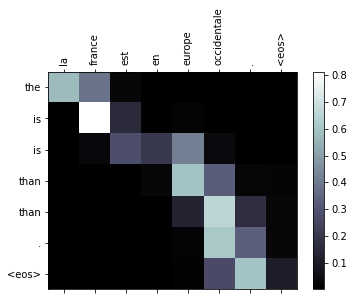

Input:['quand', 'la', 'pomme', 'de', 'terre', 'fut', 'elle', 'introduite', 'au', 'japon', '?', '<eos>']
Label:['<sos>', 'when', 'were', 'potatoes', 'introduced', 'into', 'japan', '?', '<eos>']
Output:['when', 'will', 'we', 'go', 'on', 'the', 'japan', '?', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 3000], [train loss 12.5759 +/- 11.2617], [epoch elapsed time 220.25]
--------------------------------------------------------------------


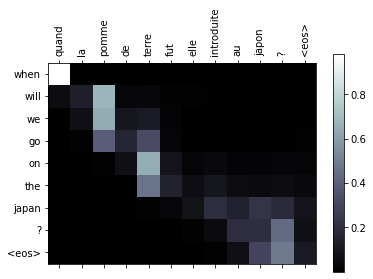

Input:['j', 'ai', 'entendu', 'cette', 'chanson', 'en', 'version', 'francaise', '.', '<eos>']
Label:['<sos>', 'i', 'heard', 'the', 'song', 'sung', 'in', 'french', '.', '<eos>']
Output:['i', 'heard', 'that', 'song', 'in', 'the', 'french', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 3300], [train loss 12.6707 +/- 11.3080], [epoch elapsed time 242.98]
--------------------------------------------------------------------


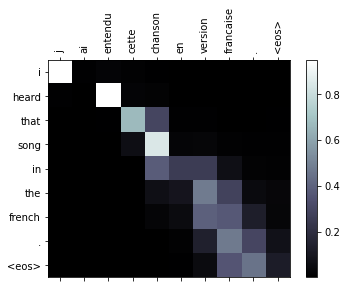

Input:['je', 'n', 'avais', 'rien', 'a', 'dire', '.', '<eos>']
Label:['<sos>', 'i', 'had', 'nothing', 'to', 'say', '.', '<eos>']
Output:['i', 'had', 'nothing', 'to', 'say', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 3600], [train loss 12.8141 +/- 11.3642], [epoch elapsed time 265.00]
--------------------------------------------------------------------


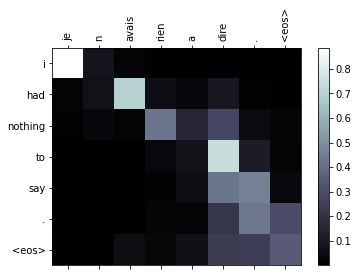

Input:['nous', 'pouvons', 'faire', 'beaucoup', 'mieux', '.', '<eos>']
Label:['<sos>', 'we', 'can', 'do', 'a', 'lot', 'better', '.', '<eos>']
Output:['we', 'can', 'make', 'a', 'better', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 3900], [train loss 12.9189 +/- 11.3958], [epoch elapsed time 286.99]
--------------------------------------------------------------------


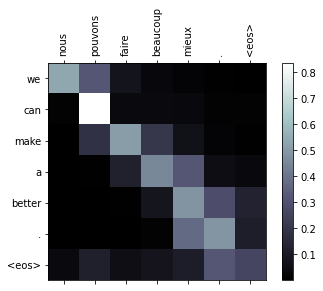

Input:['nous', 'fetons', 'ca', '.', '<eos>']
Label:['<sos>', 'we', 're', 'celebrating', '.', '<eos>']
Output:['we', 're', 'not', 'that', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 4200], [train loss 12.9598 +/- 11.3828], [epoch elapsed time 308.86]
--------------------------------------------------------------------


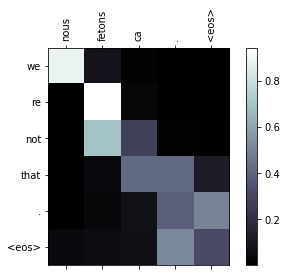

Input:['nous', 'sommes', 'tous', 'd', 'accord', 'avec', 'vous', '.', '<eos>']
Label:['<sos>', 'we', 'all', 'agree', 'with', 'you', '.', '<eos>']
Output:['we', 're', 'out', 'with', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 4500], [train loss 13.0463 +/- 11.4653], [epoch elapsed time 330.93]
--------------------------------------------------------------------


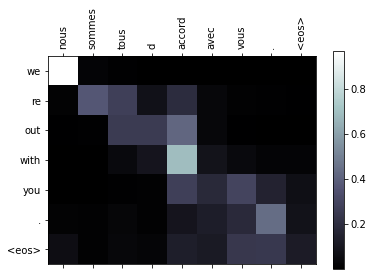

Input:['ne', 'penses', 'tu', 'pas', 'que', 'ce', 'soit', 'un', 'peu', 'etrange', '?', '<eos>']
Label:['<sos>', 'do', 'n t', 'you', 'think', 'that', 's', 'a', 'bit', 'weird', '?', '<eos>']
Output:['do', 'n t', 'you', 'think', 'it', 's', 'a', 'bit', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 4800], [train loss 13.1519 +/- 11.5735], [epoch elapsed time 353.27]
--------------------------------------------------------------------


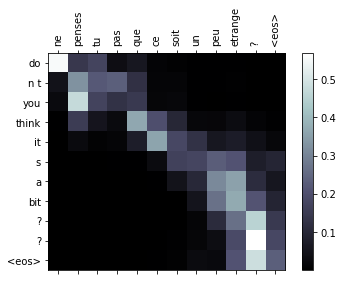

Input:['j', 'adore', 'les', 'fetes', 'sur', 'la', 'plage', '.', '<eos>']
Label:['<sos>', 'i', 'love', 'beach', 'parties', '.', '<eos>']
Output:['i', 'love', 'the', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 5100], [train loss 13.2326 +/- 11.6369], [epoch elapsed time 375.67]
--------------------------------------------------------------------


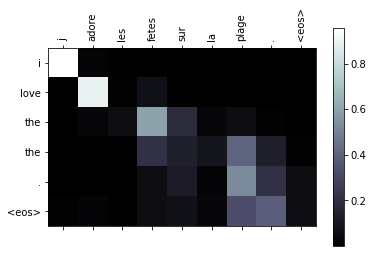

Input:['personne', 'n', 'est', 'tout', 'le', 'temps', 'clairvoyant', '.', '<eos>']
Label:['<sos>', 'no', 'man', 'is', 'wise', 'at', 'all', 'times', '.', '<eos>']
Output:['no', 'is', 'all', 'the', 'time', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 5400], [train loss 13.3915 +/- 11.6700], [epoch elapsed time 398.04]
--------------------------------------------------------------------


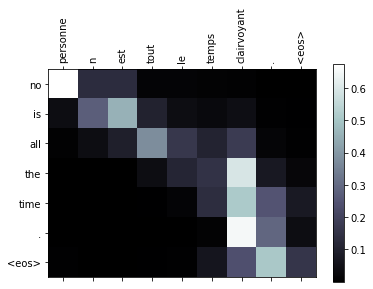

Input:['le', 'cambrioleur', 'fut', 'envoye', 'a', 'la', 'prefecture', 'de', 'police', '.', '<eos>']
Label:['<sos>', 'the', 'thief', 'was', 'marched', 'off', 'to', 'the', 'police', 'station', '.', '<eos>']
Output:['the', 'policeman', 'was', 'a', 'to', 'to', 'the', 'police', 'police', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 5700], [train loss 13.4841 +/- 11.6739], [epoch elapsed time 420.15]
--------------------------------------------------------------------


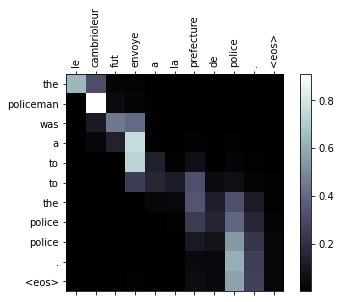

Input:['c', 'est', 'sur', 'ce', 'point', 'que', 'nos', 'opinions', 'different', '.', '<eos>']
Label:['<sos>', 'it', 'is', 'on', 'this', 'point', 'that', 'our', 'opinions', 'differ', '.', '<eos>']
Output:['it', 's', 'on', 'this', 'point', 'that', 'all', 'our', 'different', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 6000], [train loss 13.6349 +/- 11.7872], [epoch elapsed time 442.13]
--------------------------------------------------------------------


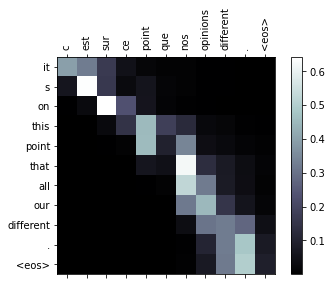

Input:['il', 'ressentit', 'une', 'douleur', 'soudaine', '.', '<eos>']
Label:['<sos>', 'he', 'felt', 'a', 'sudden', 'pain', '.', '<eos>']
Output:['he', 'was', 'a', 'pain', 'he', '.', '<eos>']
--------------------------------------------------------------------
[epoch 21 iter 6300], [train loss 13.7312 +/- 11.8129], [epoch elapsed time 463.86]
--------------------------------------------------------------------


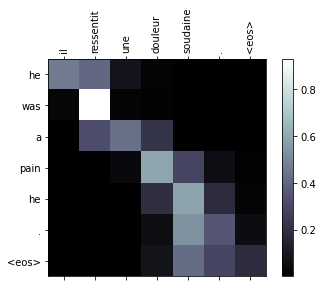

Input:['garde', 'l', 'argent', 'en', 'lieu', 'sur', '.', '<eos>']
Label:['<sos>', 'keep', 'the', 'money', 'in', 'a', 'safe', 'place', '.', '<eos>']
Output:['just', 'the', 'money', 'in', 'in', 'safe', 'place', '.', '.']
--------------------------------------------------------------------
[epoch 21 iter 6600], [train loss 13.8140 +/- 11.8392], [epoch elapsed time 485.41]
--------------------------------------------------------------------


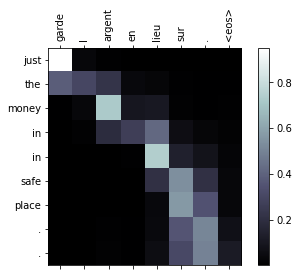

--------------------------------------------------------------------
[epoch 21], [train loss 13.8403 +/- 11.8414], [training time 489.83]
--------------------------------------------------------------------
********************************************************************
Input:['il', 'est', 'alle', 'aux', 'etats', 'unis', 'pour', 'etudier', 'la', 'litterature', '<unk>', '.', '<eos>']
Label:['<sos>', 'he', 'went', 'to', 'america', 'for', 'the', 'purpose', 'of', 'studying', 'american', 'literature', '.', '<eos>']
Output:['he', 'went', 'there', 'in', 'the', 'hard', 'to', 'the', 'the', '.', '.', '<eos>']


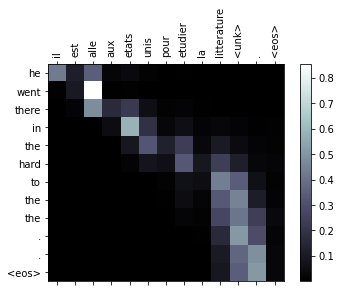

Input:['je', 'vais', 'm', 'en', 'occuper', 'immediatement', '.', '<eos>']
Label:['<sos>', 'i', 'll', 'take', 'care', 'of', 'it', 'right', 'now', '.', '<eos>']
Output:['i', 'll', 'get', 'the', 'right', 'now', '.', '<eos>']


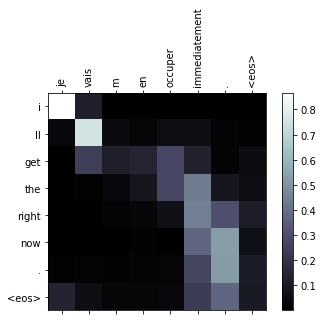

[epoch 21], [test loss 28.6314 +/- 18.1907], [testing time 2.18]
********************************************************************
Input:['je', 'suis', 'sure', 'que', 'tom', 'avait', 'ses', 'raisons', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'sure', 'tom', 'had', 'his', 'reasons', '.', '<eos>']
Output:['i', 'm', 'sure', 'tom', 'tom', 'had', 'his', 'his', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 300], [train loss 10.9415 +/- 10.5836], [epoch elapsed time 21.14]
--------------------------------------------------------------------


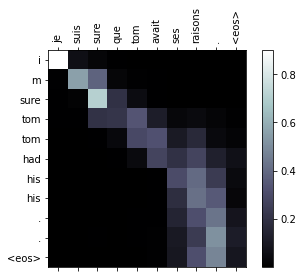

Input:['je', 'vous', 'verrai', 'tous', 'demain', '.', '<eos>']
Label:['<sos>', 'see', 'you', 'all', 'tomorrow', '.', '<eos>']
Output:['i', 'll', 'all', 'all', 'tomorrow', 'tomorrow', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 600], [train loss 10.8085 +/- 9.9568], [epoch elapsed time 42.85]
--------------------------------------------------------------------


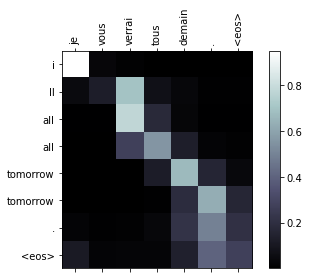

Input:['vous', 'etes', 'tellement', 'gentilles', '!', '<eos>']
Label:['<sos>', 'you', 're', 'so', 'sweet', '.', '<eos>']
Output:['you', 're', 'so', 'sweet', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 900], [train loss 11.2211 +/- 10.0944], [epoch elapsed time 64.97]
--------------------------------------------------------------------


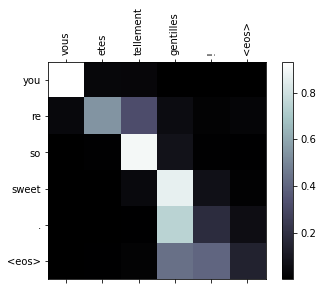

Input:['pensez', 'a', 'poster', 'la', 'lettre', 'sur', 'le', 'chemin', 'de', 'l', 'ecole', '.', '<eos>']
Label:['<sos>', 'remember', 'to', 'mail', 'the', 'letter', 'on', 'your', 'way', 'to', 'school', '.', '<eos>']
Output:['the', 'to', 'to', 'the', 'the', 'to', 'to', 'way', 'way', 'school', 'school', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 1200], [train loss 11.4822 +/- 10.1894], [epoch elapsed time 87.07]
--------------------------------------------------------------------


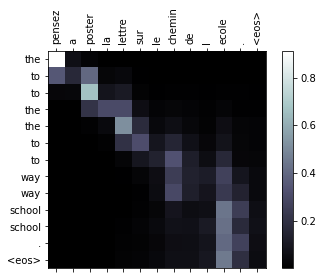

Input:['ca', 'ne', 'vous', 'ferait', 'rien', 'de', 'me', 'frotter', 'les', 'pieds', '?', '<eos>']
Label:['<sos>', 'would', 'you', 'mind', 'rubbing', 'my', 'feet', '?', '<eos>']
Output:['do', 'you', 'mind', 'her', 'me', 'way', '?', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 1500], [train loss 12.0731 +/- 10.9298], [epoch elapsed time 109.43]
--------------------------------------------------------------------


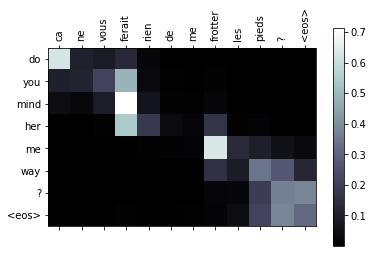

Input:['comment', 'sais', 'tu', 'que', 'tom', 'n', 'est', 'pas', 'un', 'locuteur', 'natif', '?', '<eos>']
Label:['<sos>', 'how', 'do', 'you', 'know', 'that', 'tom', 'is', 'n t', 'a', 'native', 'speaker', '?', '<eos>']
Output:['how', 'do', 'you', 'know', 'it', 'tom', 'is', 'n t', 'a', 'a', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 1800], [train loss 12.1464 +/- 11.0138], [epoch elapsed time 131.06]
--------------------------------------------------------------------


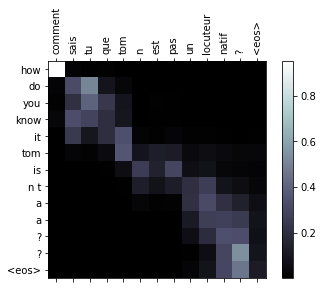

Input:['j', 'ai', 'perdu', 'mon', 'appareil', 'photo', 'l', 'autre', 'jour', '.', '<eos>']
Label:['<sos>', 'i', 'lost', 'my', 'camera', 'the', 'other', 'day', '.', '<eos>']
Output:['i', 'lost', 'my', 'my', 'is', 'the', 'day', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 2100], [train loss 12.2864 +/- 11.1763], [epoch elapsed time 153.77]
--------------------------------------------------------------------


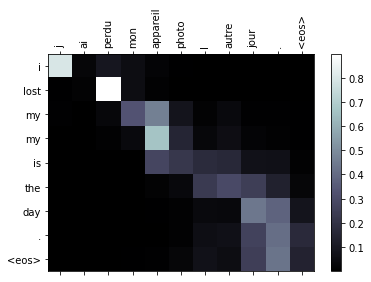

Input:['elle', 'a', 'tort', '.', '<eos>']
Label:['<sos>', 'she', 'is', 'wrong', '.', '<eos>']
Output:['she', 'is', 'wrong', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 2400], [train loss 12.4480 +/- 11.3240], [epoch elapsed time 178.12]
--------------------------------------------------------------------


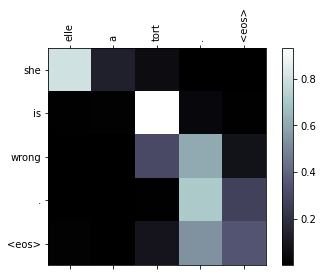

Input:['n', 'oublie', 'pas', 'de', 'prendre', 'un', 'appareil', 'photo', 'avec', 'toi', '.', '<eos>']
Label:['<sos>', 'do', 'n t', 'forget', 'to', 'take', 'a', 'camera', 'with', 'you', '.', '<eos>']
Output:['do', 'n t', 'forget', 'my', 'take', 'a', 'camera', 'with', 'you', 'with', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 2700], [train loss 12.5473 +/- 11.2780], [epoch elapsed time 200.23]
--------------------------------------------------------------------


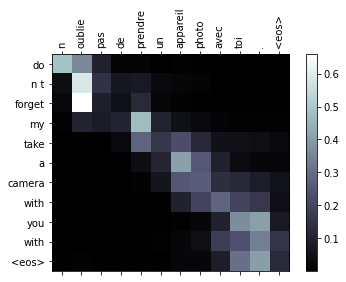

Input:['je', 'ne', 'serai', 'pas', 'tranquille', '.', '<eos>']
Label:['<sos>', 'i', 'wo', 'n t', 'be', 'quiet', '.', '<eos>']
Output:['i', 'wo', 'n t', 'be', 'alone', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 3000], [train loss 12.5407 +/- 11.2291], [epoch elapsed time 222.23]
--------------------------------------------------------------------


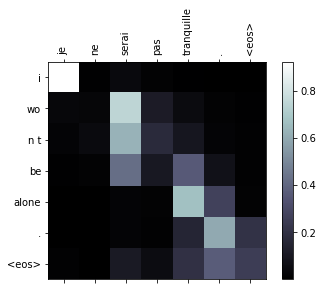

Input:['tom', 'est', 'un', 'des', 'mes', 'amis', 'proches', '.', '<eos>']
Label:['<sos>', 'tom', 'is', 'a', 'close', 'personal', 'friend', 'of', 'mine', '.', '<eos>']
Output:['tom', 'is', 'a', 'of', 'friend', 'friend', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 3300], [train loss 12.6663 +/- 11.3188], [epoch elapsed time 244.41]
--------------------------------------------------------------------


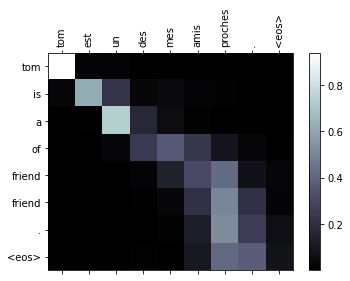

Input:['nous', 'voulons', 'tous', 'deux', 'voir', 'le', 'film', '.', '<eos>']
Label:['<sos>', 'both', 'of', 'us', 'want', 'to', 'see', 'the', 'movie', '.', '<eos>']
Output:['we', 'want', 'to', 'go', 'to', 'see', 'to', 'the', 'movie', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 3600], [train loss 12.8272 +/- 11.4268], [epoch elapsed time 266.40]
--------------------------------------------------------------------


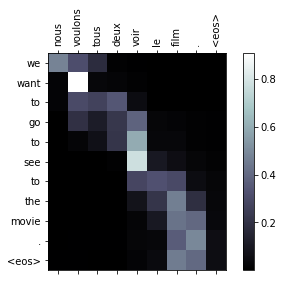

Input:['rien', 'ne', 'lui', 'procurait', 'un', 'plus', 'grand', 'plaisir', 'que', 'de', 'regarder', 'son', 'fils', 'grandir', '.', '<eos>']
Label:['<sos>', 'nothing', 'gave', 'her', 'greater', 'pleasure', 'than', 'to', 'watch', 'her', 'son', 'growing', 'up', '.', '<eos>']
Output:['nothing', 'gave', 'her', 'her', 'man', 'like', 'to', 'watch', 'her', 'son', 'in', 'his', 'son', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 3900], [train loss 12.9510 +/- 11.4697], [epoch elapsed time 288.75]
--------------------------------------------------------------------


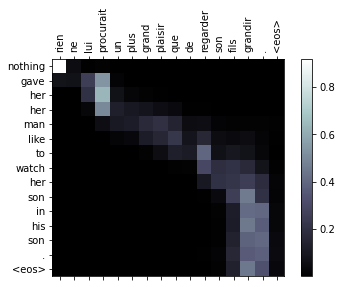

Input:['vous', 'a', 't', 'on', 'dit', 'quand', 'vous', 'etes', 'attendues', 'ici', '?', '<eos>']
Label:['<sos>', 'have', 'you', 'been', 'told', 'when', 'you', 'are', 'expected', 'to', 'be', 'here', '?', '<eos>']
Output:['have', 'you', 'been', 'told', 'when', 'you', 're', 'to', 'to', 'here', 'here', '?', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 4200], [train loss 13.0813 +/- 11.6550], [epoch elapsed time 311.74]
--------------------------------------------------------------------


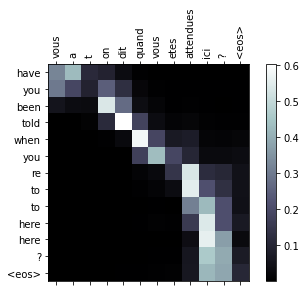

Input:['quand', 'puis', 'je', 'vous', 'rendre', 'visite', '?', '<eos>']
Label:['<sos>', 'when', 'can', 'i', 'visit', 'you', '?', '<eos>']
Output:['when', 'can', 'i', 'see', 'you', '?', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 4500], [train loss 13.1338 +/- 11.5545], [epoch elapsed time 333.58]
--------------------------------------------------------------------


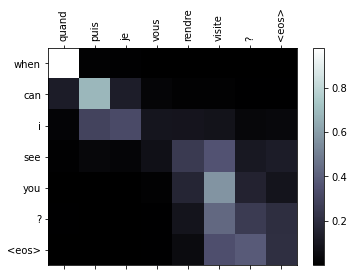

Input:['j', 'aurais', 'pu', 'te', 'rencontrer', 'a', 'l', 'aerodrome', '.', '<eos>']
Label:['<sos>', 'i', 'could', 've', 'met', 'you', 'at', 'the', 'airport', '.', '<eos>']
Output:['i', 'could', 've', 'met', 'you', 'at', 'the', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 4800], [train loss 13.2059 +/- 11.5672], [epoch elapsed time 355.61]
--------------------------------------------------------------------


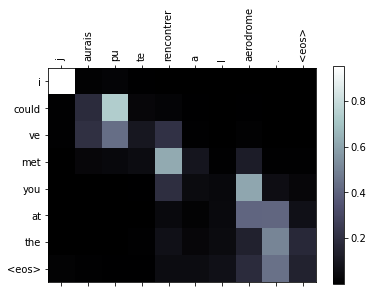

Input:['cela', 'te', 'derangerait', 'il', 'de', 'fermer', 'la', 'porte', '?', '<eos>']
Label:['<sos>', 'would', 'you', 'mind', 'shutting', 'the', 'door', '?', '<eos>']
Output:['would', 'you', 'mind', 'any', 'the', 'door', '?', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 5100], [train loss 13.2768 +/- 11.4975], [epoch elapsed time 377.08]
--------------------------------------------------------------------


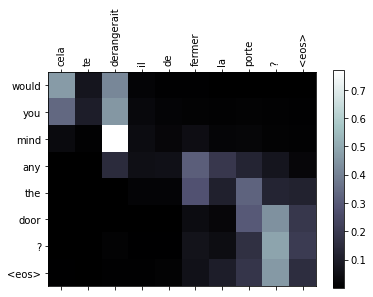

Input:['elle', 'detourna', 'son', 'visage', 'afin', 'qu', 'il', 'ne', 'voie', 'pas', 'ses', 'larmes', '.', '<eos>']
Label:['<sos>', 'she', 'turned', 'her', 'face', 'away', 'so', 'he', 'would', 'n t', 'see', 'her', 'tears', '.', '<eos>']
Output:['she', 'turned', 'her', 'her', 'and', 'he', 'would', 'n t', 'n t', 'her', 'her', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 5400], [train loss 13.3401 +/- 11.5316], [epoch elapsed time 399.09]
--------------------------------------------------------------------


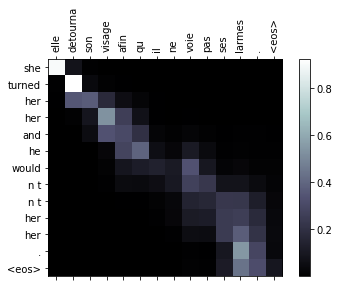

Input:['j', 'entendis', 'un', 'bruit', 'inhabituel', '.', '<eos>']
Label:['<sos>', 'i', 'heard', 'an', 'unusual', 'noise', '.', '<eos>']
Output:['i', 'heard', 'a', 'noise', 'noise', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 5700], [train loss 13.3777 +/- 11.4979], [epoch elapsed time 421.02]
--------------------------------------------------------------------


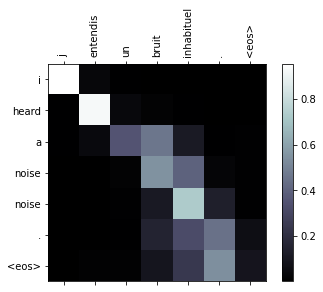

Input:['tout', 'le', 'monde', 'etait', 'inquiet', '.', '<eos>']
Label:['<sos>', 'everyone', 'was', 'apprehensive', '.', '<eos>']
Output:['everyone', 'was', 'the', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 6000], [train loss 13.4831 +/- 11.6282], [epoch elapsed time 442.94]
--------------------------------------------------------------------


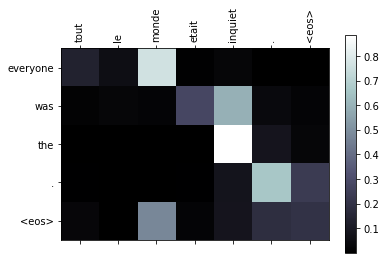

Input:['vous', 'ne', 'pouvez', 'pas', 'en', 'etre', 'sures', '.', '<eos>']
Label:['<sos>', 'you', 'ca', 'n t', 'be', 'sure', 'of', 'that', '.', '<eos>']
Output:['you', 'ca', 'n t', 'be', 'sure', 'be', 'that', '.', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 6300], [train loss 13.6169 +/- 11.6708], [epoch elapsed time 465.41]
--------------------------------------------------------------------


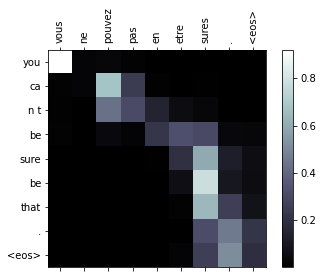

Input:['tu', 'n', 'as', 'pas', 'vu', 'tom', 'ce', 'matin', 'n', 'est', 'ce', 'pas', '?', '<eos>']
Label:['<sos>', 'you', 'have', 'n t', 'seen', 'tom', 'this', 'morning', 'have', 'you', '?', '<eos>']
Output:['do', 'n t', 'n t', 'seen', 'this', 'have', 'have', '?', '?', '?', '<eos>']
--------------------------------------------------------------------
[epoch 22 iter 6600], [train loss 13.6790 +/- 11.6629], [epoch elapsed time 487.17]
--------------------------------------------------------------------


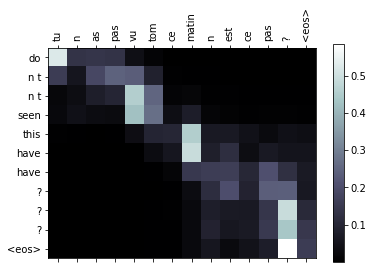

--------------------------------------------------------------------
[epoch 22], [train loss 13.6761 +/- 11.6405], [training time 491.51]
--------------------------------------------------------------------
********************************************************************
Input:['je', 'ne', 'le', 'ressens', 'pas', '.', '<eos>']
Label:['<sos>', 'i', 'ca', 'n t', 'feel', 'it', '.', '<eos>']
Output:['i', 'm', 'not', 'wear', 'him', '.', '<eos>']


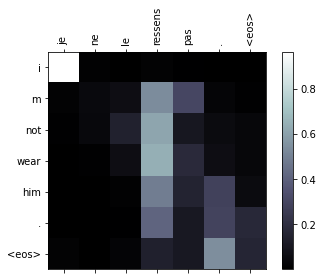

Input:['je', 'pensais', 'que', 'je', 'pourrais', 'ne', 'jamais', 'te', 'revoir', '.', '<eos>']
Label:['<sos>', 'i', 'thought', 'i', 'might', 'never', 'see', 'you', 'again', '.', '<eos>']
Output:['i', 'thought', 'i', 'could', 'n t', 'see', 'you', 'again', 'again', 'again', 'again', 'again', 'again', '.', '<eos>']


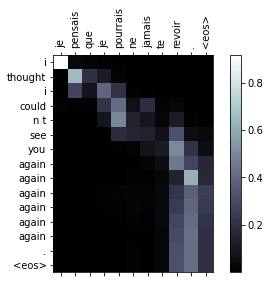

[epoch 22], [test loss 30.2563 +/- 18.6572], [testing time 2.20]
********************************************************************
Input:['je', 'regardais', 'la', 'tele', 'lorsque', 'le', 'telephone', 'a', 'sonne', '.', '<eos>']
Label:['<sos>', 'i', 'was', 'watching', 'tv', 'when', 'the', 'telephone', 'rang', '.', '<eos>']
Output:['i', 'was', 'watching', 'tv', 'the', 'the', 'street', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 300], [train loss 10.1836 +/- 9.9548], [epoch elapsed time 21.23]
--------------------------------------------------------------------


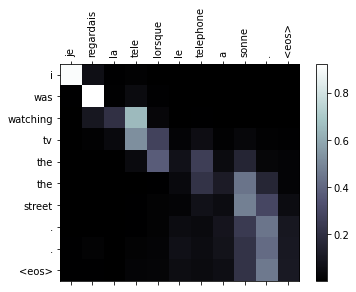

Input:['je', 'craignais', 'de', 'heurter', 'sa', 'sensibilite', '.', '<eos>']
Label:['<sos>', 'i', 'was', 'afraid', 'that', 'i', 'might', 'hurt', 'his', 'feelings', '.', '<eos>']
Output:['i', 'was', 'afraid', 'i', 'would', 'his', 'his', 'his', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 600], [train loss 10.8344 +/- 10.2186], [epoch elapsed time 43.05]
--------------------------------------------------------------------


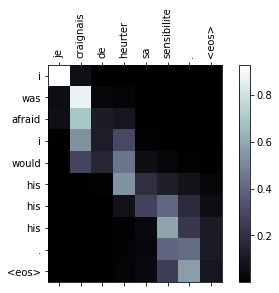

Input:['je', 'suis', 'plus', 'petit', 'que', 'toi', '.', '<eos>']
Label:['<sos>', 'i', 'am', 'shorter', 'than', 'you', '.', '<eos>']
Output:['i', 'am', 'not', 'than', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 900], [train loss 11.3320 +/- 10.6175], [epoch elapsed time 64.72]
--------------------------------------------------------------------


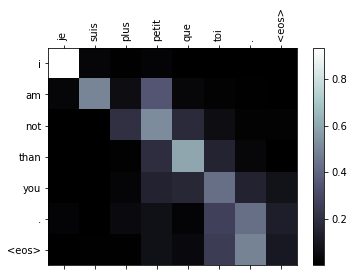

Input:['te', 'rends', 'tu', 'compte', 'de', 'l', 'heure', '?', '<eos>']
Label:['<sos>', 'do', 'you', 'realize', 'how', 'late', 'it', 's', 'gotten', '?', '<eos>']
Output:['do', 'you', 'be', 'how', 'to', 'it', 'time', 'time', '?', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 1200], [train loss 11.4683 +/- 10.5211], [epoch elapsed time 86.27]
--------------------------------------------------------------------


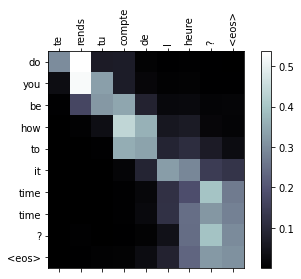

Input:['j', 'en', 'suis', 'sur', '.', '<eos>']
Label:['<sos>', 'i', 'm', 'sure', '.', '<eos>']
Output:['i', 'm', 'sure', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 1500], [train loss 11.4996 +/- 10.5371], [epoch elapsed time 107.92]
--------------------------------------------------------------------


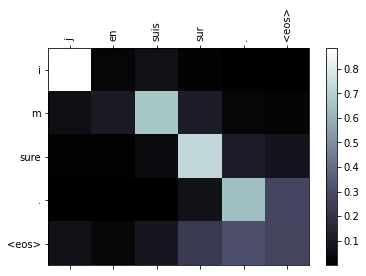

Input:['amenez', 'la', 'en', 'salle', 'd', 'op', '.', '<eos>']
Label:['<sos>', 'take', 'her', 'to', 'the', 'or', '.', '<eos>']
Output:['take', 'her', 'back', 'to', 'the', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 1800], [train loss 11.7155 +/- 10.4671], [epoch elapsed time 130.10]
--------------------------------------------------------------------


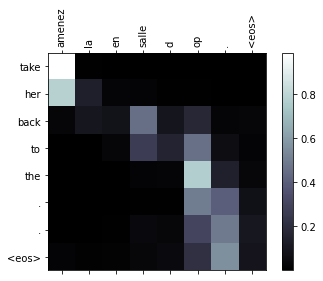

Input:['je', 'vis', 'seul', 'dans', 'cette', 'demeure', '.', '<eos>']
Label:['<sos>', 'i', 'live', 'in', 'this', 'house', 'by', 'myself', '.', '<eos>']
Output:['i', 'live', 'in', 'this', 'house', '.', 'myself', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 2100], [train loss 11.9779 +/- 10.5416], [epoch elapsed time 152.30]
--------------------------------------------------------------------


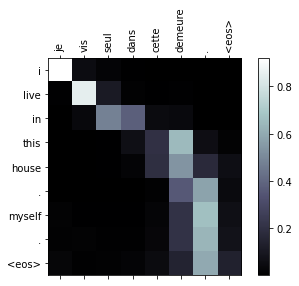

Input:['je', 'parlai', 'fort', 'de', 'maniere', 'a', 'ce', 'que', 'chacun', 'puisse', 'm', 'entendre', '.', '<eos>']
Label:['<sos>', 'i', 'spoke', 'loudly', 'so', 'that', 'everyone', 'could', 'hear', 'me', '.', '<eos>']
Output:['i', 'spoke', 'on', 'so', 'that', 'everyone', 'did', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 2400], [train loss 11.9506 +/- 10.5458], [epoch elapsed time 174.55]
--------------------------------------------------------------------


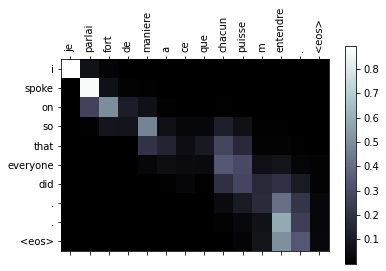

Input:['il', 'joue', 'aux', 'echecs', 'depuis', 'qu', 'il', 'est', 'au', 'lycee', '.', '<eos>']
Label:['<sos>', 'he', 'has', 'been', 'playing', 'chess', 'since', 'he', 'was', 'in', 'high', 'school', '.', '<eos>']
Output:['he', 'has', 'been', 'his', 'his', 'since', 'he', 'was', 'in', 'high', 'school', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 2700], [train loss 12.0444 +/- 10.6491], [epoch elapsed time 197.18]
--------------------------------------------------------------------


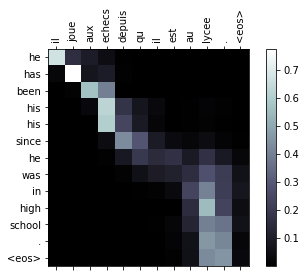

Input:['ce', 'pourrait', 'simplement', 'etre', 'ton', 'imagination', '.', '<eos>']
Label:['<sos>', 'it', 'could', 'just', 'be', 'your', 'imagination', '.', '<eos>']
Output:['it', 'just', 'just', 'be', 'your', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 3000], [train loss 12.1330 +/- 10.8680], [epoch elapsed time 219.79]
--------------------------------------------------------------------


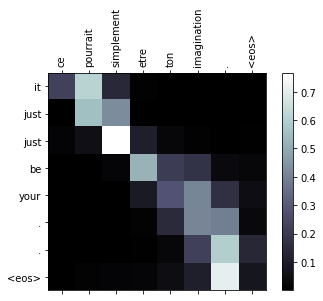

Input:['tom', 'fut', 'embrasse', 'par', 'marie', '.', '<eos>']
Label:['<sos>', 'tom', 'was', 'kissed', 'by', 'mary', '.', '<eos>']
Output:['tom', 'was', 'both', 'by', 'mary', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 3300], [train loss 12.3065 +/- 11.0068], [epoch elapsed time 242.34]
--------------------------------------------------------------------


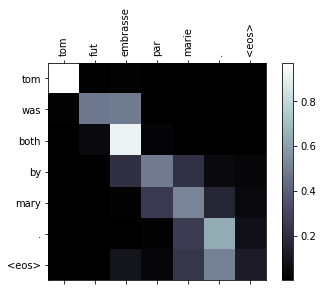

Input:['ceci', 'pourrait', 'prendre', 'un', 'moment', '.', '<eos>']
Label:['<sos>', 'this', 'could', 'take', 'a', 'while', '.', '<eos>']
Output:['this', 'could', 'take', 'a', 'while', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 3600], [train loss 12.5231 +/- 11.2621], [epoch elapsed time 265.42]
--------------------------------------------------------------------


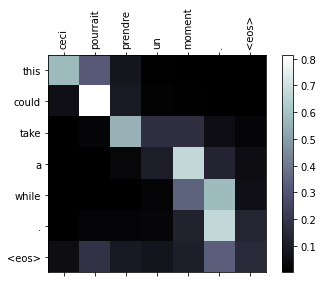

Input:['nous', 'aimerions', 'des', 'notes', 'separees', '.', '<eos>']
Label:['<sos>', 'we', 'd', 'like', 'separate', 'checks', '.', '<eos>']
Output:['we', 'd', 'like', 'very', '.', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 3900], [train loss 12.6794 +/- 11.2904], [epoch elapsed time 288.44]
--------------------------------------------------------------------


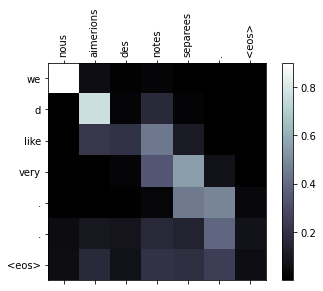

Input:['qu', 'a', 'dit', 'tom', 'a', 'propos', 'de', 'moi', '?', '<eos>']
Label:['<sos>', 'what', 'did', 'tom', 'say', 'about', 'me', '?', '<eos>']
Output:['what', 'did', 'tom', 'tom', 'about', 'about', '?', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 4200], [train loss 12.8206 +/- 11.4799], [epoch elapsed time 310.81]
--------------------------------------------------------------------


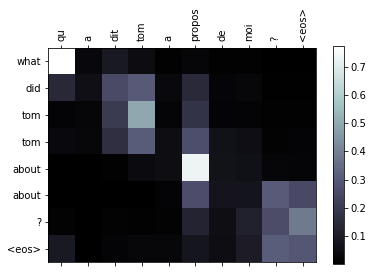

Input:['c', 'est', 'votre', 'decision', '.', '<eos>']
Label:['<sos>', 'it', 's', 'your', 'decision', '.', '<eos>']
Output:['that', 's', 'your', 'your', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 4500], [train loss 12.9265 +/- 11.5071], [epoch elapsed time 333.02]
--------------------------------------------------------------------


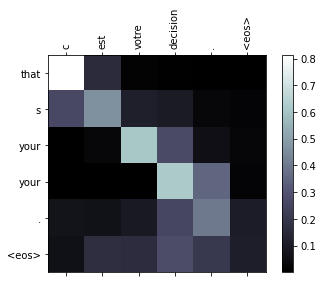

Input:['laissez', 'moi', 'm', 'en', 'charger', '!', '<eos>']
Label:['<sos>', 'let', 'me', 'deal', 'with', 'this', '.', '<eos>']
Output:['let', 'me', 'get', 'it', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 4800], [train loss 12.9710 +/- 11.4734], [epoch elapsed time 355.28]
--------------------------------------------------------------------


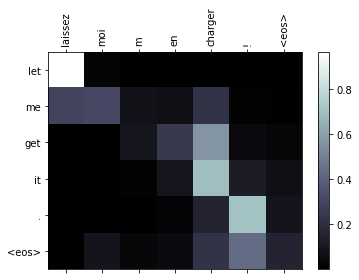

Input:['je', 'vous', 'aime', 'encore', '.', '<eos>']
Label:['<sos>', 'i', 'still', 'love', 'you', '.', '<eos>']
Output:['i', 'like', 'you', 'you', '.', '<eos>']
--------------------------------------------------------------------
[epoch 23 iter 5100], [train loss 13.1402 +/- 11.5860], [epoch elapsed time 377.83]
--------------------------------------------------------------------


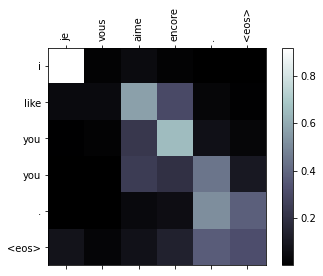

In [ ]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_iterator, criterion, epoch)

    # Computing test loss and metrics.
    test(test_iterator, criterion, epoch)

